In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import imageio
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [2]:
class ZeldaLevelDataset(Dataset):
    """Zelda Game levels dataset."""

    def __init__(self, data_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_dir = data_dir
        self.levels = self.load_levels()

    def __len__(self):
        return len(self.levels)

    def __getitem__(self, idx):
        return self.levels[idx]
    
    def load_levels(self):
        levels = []
        directory = os.fsencode(self.data_dir)
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".pt"): 
                level = torch.load(self.data_dir + '/' + filename).float()
                levels.append(level)
        return levels
                
        

In [3]:
#transform = transforms.Compose([
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5,),(0.5,)),
#])
to_pil_image = transforms.ToPILImage()
train_data = ZeldaLevelDataset('./data/tensorizedConv/')
print("data size", len(train_data))

data size 459


In [29]:
# learning parameters
no_cuda = False
batch_size = 16
epochs = 10000
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
seed = 2020
temperature = 1.0
hard = False
categorical_dim = 10
k = 1 # number of steps to apply to the discriminator
is_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
torch.manual_seed(seed)
if is_cuda:
    torch.cuda.manual_seed(seed)

In [5]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


In [7]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    if is_cuda:
        U = U.cuda()
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    permuted_logits = logits.permute(0,2,3,1)
    permuted_y = gumbel_softmax_sample(permuted_logits, temperature)
    #if not hard:
    #    return y.view(-1, nz * categorical_dim)
    
    shape = permuted_y.size()
    _, ind = permuted_y.max(dim=-1)
    y_hard = torch.zeros_like(permuted_y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - permuted_y).detach() + permuted_y
    y_final = y_hard.permute(0,3,1,2)
    return y_final#.view(-1, latent_dim * categorical_dim)

In [13]:
# testing
print(iter(train_loader).next().shape)

torch.Size([16, 10, 16, 11])


In [37]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1760),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 16, 110)
    
class GeneratorConv(nn.Module):
    def __init__(self, nz, temp):
        super(GeneratorConv, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.nz, 64, (3,2), 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 16, (3,2), 2, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(16, 10, (4,2), 1, bias=False),
            #nn.Tanh()
        )

    def forward(self, x, temp, hard):
        x = self.main(x)
        x = gumbel_softmax(x, temp, hard)
        return x

In [38]:
generator = GeneratorConv(nz, temperature).to(device)
#generator.apply(weights_init)
print(generator)

GeneratorConv(
  (main): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 16, kernel_size=(3, 2), stride=(2, 2), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 10, kernel_size=(4, 2), stride=(1, 1), bias=False)
  )
)


In [39]:
# CONV shape tests
test_level = torch.rand(1, 10, 16, 11)

conv1 = nn.Conv2d(10, 32, 4, 1, bias=False)
conv2 = nn.Conv2d(32, 48, 4, 1, bias=False)
conv3 = nn.Conv2d(48, 64, 4, 1, bias=False)
flatt = nn.Flatten()
lin1 = nn.Linear(64*7*2, 128)
print("dis")
x = conv1(test_level)
print(x.shape)
x = conv2(x)
print(x.shape)
x = conv3(x)
print(x.shape)
x = flatt(x)
print(x.shape)
x = lin1(x)
print(x.shape)

print("gen")
test_latent = torch.rand(1, 128, 4, 4)
deconv1 = nn.ConvTranspose2d(128, 64, (3,2), 1, bias=False)
deconv2 = nn.ConvTranspose2d(64, 16, (3,2), 2, bias=False)
deconv3 = nn.ConvTranspose2d(16, 10, (4,2), 1, bias=False)
y = deconv1(test_latent)
print(y.shape)
y = deconv2(y)
print(y.shape)
y = deconv3(y)
print(y.shape)

dis
torch.Size([1, 32, 13, 8])
torch.Size([1, 48, 10, 5])
torch.Size([1, 64, 7, 2])
torch.Size([1, 896])
torch.Size([1, 128])
gen
torch.Size([1, 64, 6, 5])
torch.Size([1, 16, 13, 10])
torch.Size([1, 10, 16, 11])


In [40]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 1760
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 1760)
        return self.main(x)

class DiscriminatorConv(nn.Module):
    def __init__(self):
        super(DiscriminatorConv, self).__init__()
        self.main = nn.Sequential(
            # input is B x C x H x W
            # B = 16, C = 10, H = 16, W = 11
            nn.Conv2d(10, 32, 4, 1, bias=False),
            # output:
            # B = 16, C = 32, H = (in+2P-k)/S + 1 = (16+0-4)/1 + 1 = 13, W = (in+2P-k)/S + 1 = (11+0-4)/1 + 1 = 8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 1, bias=False),
            # output:
            # B = 16, C = 32, H = (in+2P-k)/S + 1 = (13+0-4)/1 + 1 = 10, W = (in+2P-k)/S + 1 = (8+0-4)/1 + 1 = 5
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 1, bias=False),
            # output:
            # B = 16, C = 1, H = (in+2P-k)/S + 1 = (10+0-4)/2 + 1 = 7, W = (in+2P-k)/S + 1 = (5+0-4)/2 + 1 = 2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*7*2, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [41]:
discriminator = DiscriminatorConv().to(device)
#discriminator.apply(weights_init)
print(discriminator)

DiscriminatorConv(
  (main): Sequential(
    (0): Conv2d(10, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=1792, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=16, bias=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=1, bias=True)
    (15): Sigmoid()
  )
)


In [42]:

temp_min = 0.5
ANNEAL_RATE = 0.00003
if is_cuda:
    generator.cuda()
    discriminator.cuda()

In [43]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz, 4, 4).to(device)

In [44]:
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.00005)
optim_d = optim.Adam(discriminator.parameters(), lr=0.00005)

real_label = 1.
fake_label = 0.

# create the noise vector
noise = create_noise(64, nz)

In [45]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [46]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [47]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [48]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [49]:
def transform_to_image_format(level):
    colorR = torch.tensor([0.69,0.3, 0.8,0,   0.06,0.08,0.52,0.3, 0.26,0])
    colorG = torch.tensor([0.69,1,   0,  0.14,0.12,0.94,0.13,0.52,0.14,0])
    colorB = torch.tensor([0.69,1,   0.1,0.8 ,0.35,0.33,0.08,0.08,0.31,0])
    
    colorMap = torch.tensor([[0.69,0.3, 0.8,0,   0.06,0.08,0.52,0.3, 0.26,0],
                            [0.69,1,   0,  0.14,0.12,0.94,0.13,0.52,0.14,0],
                            [0.69,1,   0.1,0.8 ,0.35,0.33,0.08,0.08,0.31,0]]).transpose(0,1)
    permuted_level = level.permute(0,2,3,1)
    
    colored_permuted_level = torch.matmul(permuted_level,colorMap)
    colored_level = colored_permuted_level.permute(0,3,1,2)
    
    return colored_level

In [50]:
t1 = torch.rand(64,10,16,11)
t1p = t1.permute(0,2,3,1)
print(t1p.shape)
t2 = torch.rand(10,3)
t = torch.matmul(t1p,t2)
print(t.shape)
tp = t.permute(0,3,1,2)
print(tp.shape)

torch.Size([64, 16, 11, 10])
torch.Size([64, 16, 11, 3])
torch.Size([64, 3, 16, 11])


In [51]:
generator.train()
discriminator.train()

DiscriminatorConv(
  (main): Sequential(
    (0): Conv2d(10, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=1792, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=16, bias=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=1, bias=True)
    (15): Sigmoid()
  )
)

In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    temp = temperature
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        level = data
        level = level.to(device)
        b_size = len(level)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz), temp, hard).detach()
            data_real = level
            # train the discriminator network
            
            loss_d += train_discriminator(optim_d, data_real, data_fake)
            #print(loss_d)
        data_fake = generator(create_noise(b_size, nz), temp, hard)
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
        if bi % 100 == 1:
            temp = np.maximum(temp * np.exp(-ANNEAL_RATE * bi), temp_min)
        #print(loss_d)
    # create the final fake image for the epoch
    generated_level = generator(noise, temp, hard).cpu().detach()
    # make the images as grid
    #generated_level = transform_to_image_format(generated_level)
    #generated_level = make_grid(generated_level)
    # save the generated torch tensor models to disk
    #save_generator_image(generated_level, f"./outputs/gen_img{epoch}.png")
    images.append(generated_level)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    if epoch > 1 and epoch_loss_g < losses_g[-1]:
        torch.save(generator.state_dict(), f'./outputs/generators/v1_conv_gumbel/generator{epoch}.pth')
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

29it [00:02, 13.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 0 of 10000
Generator loss: 0.81630075, Discriminator loss: 1.40507734


29it [00:01, 19.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 1 of 10000
Generator loss: 1.07015836, Discriminator loss: 1.22809911


29it [00:01, 20.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 2 of 10000
Generator loss: 2.45665336, Discriminator loss: 0.78729212


29it [00:01, 16.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 3 of 10000
Generator loss: 4.03332758, Discriminator loss: 0.42978576


29it [00:01, 20.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 4 of 10000
Generator loss: 5.11395502, Discriminator loss: 0.13774799


29it [00:01, 17.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 5 of 10000
Generator loss: 5.78976297, Discriminator loss: 0.03712935


29it [00:01, 18.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 6 of 10000
Generator loss: 6.62265062, Discriminator loss: 0.01563399


29it [00:01, 20.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 7 of 10000
Generator loss: 7.13593435, Discriminator loss: 0.00884843


29it [00:01, 18.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 8 of 10000
Generator loss: 7.46528625, Discriminator loss: 0.00608763


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 9 of 10000
Generator loss: 7.80579996, Discriminator loss: 0.00427960


29it [00:01, 20.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 10 of 10000
Generator loss: 8.14676952, Discriminator loss: 0.00330825


29it [00:01, 18.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 11 of 10000
Generator loss: 8.33414555, Discriminator loss: 0.00272593


29it [00:01, 20.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 12 of 10000
Generator loss: 8.64182091, Discriminator loss: 0.00217225


29it [00:01, 21.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 13 of 10000
Generator loss: 8.71955776, Discriminator loss: 0.00181558


29it [00:01, 20.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 14 of 10000
Generator loss: 8.89720058, Discriminator loss: 0.00153543


29it [00:01, 16.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 15 of 10000
Generator loss: 9.08097363, Discriminator loss: 0.00133314


29it [00:01, 17.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 16 of 10000
Generator loss: 9.16989803, Discriminator loss: 0.00117465


29it [00:01, 17.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 17 of 10000
Generator loss: 9.34225178, Discriminator loss: 0.00106393


29it [00:01, 19.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 18 of 10000
Generator loss: 9.46484852, Discriminator loss: 0.00092023


29it [00:01, 20.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 19 of 10000
Generator loss: 9.48482227, Discriminator loss: 0.00082119


29it [00:01, 19.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 20 of 10000
Generator loss: 9.60582161, Discriminator loss: 0.00084516


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 21 of 10000
Generator loss: 9.67832947, Discriminator loss: 0.00073734


29it [00:01, 20.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 22 of 10000
Generator loss: 9.70457172, Discriminator loss: 0.00070129


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 23 of 10000
Generator loss: 9.82142448, Discriminator loss: 0.00069287


29it [00:01, 17.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 24 of 10000
Generator loss: 9.87837410, Discriminator loss: 0.00061807


29it [00:01, 19.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 25 of 10000
Generator loss: 9.98652840, Discriminator loss: 0.00059018


29it [00:01, 19.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 26 of 10000
Generator loss: 10.04331684, Discriminator loss: 0.00056924


29it [00:01, 20.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 27 of 10000
Generator loss: 9.96137810, Discriminator loss: 0.00051967


29it [00:01, 18.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 28 of 10000
Generator loss: 10.08905888, Discriminator loss: 0.00056092


29it [00:01, 19.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 29 of 10000
Generator loss: 10.08686161, Discriminator loss: 0.00053225


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 30 of 10000
Generator loss: 9.74088573, Discriminator loss: 0.00053168


29it [00:01, 19.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 31 of 10000
Generator loss: 9.83516788, Discriminator loss: 0.00067046


29it [00:01, 20.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 32 of 10000
Generator loss: 9.49907780, Discriminator loss: 0.00056543


29it [00:01, 19.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 33 of 10000
Generator loss: 9.83435917, Discriminator loss: 0.00072272


29it [00:01, 20.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 34 of 10000
Generator loss: 10.15727329, Discriminator loss: 0.00069085


29it [00:01, 20.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 35 of 10000
Generator loss: 10.31487846, Discriminator loss: 0.00058510


29it [00:01, 18.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 36 of 10000
Generator loss: 10.61128998, Discriminator loss: 0.00050601


29it [00:01, 20.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 37 of 10000
Generator loss: 11.28220844, Discriminator loss: 0.00058076


29it [00:01, 20.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 38 of 10000
Generator loss: 11.11954975, Discriminator loss: 0.00036087


29it [00:01, 19.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 39 of 10000
Generator loss: 11.36915684, Discriminator loss: 0.00029511


29it [00:01, 20.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 40 of 10000
Generator loss: 11.63162804, Discriminator loss: 0.00027480


29it [00:01, 20.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 41 of 10000
Generator loss: 11.47977924, Discriminator loss: 0.00029055


29it [00:01, 19.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 42 of 10000
Generator loss: 11.40419292, Discriminator loss: 0.00024529


29it [00:01, 19.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 43 of 10000
Generator loss: 11.75830650, Discriminator loss: 0.00025884


29it [00:01, 20.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 44 of 10000
Generator loss: 11.87807178, Discriminator loss: 0.00020562


29it [00:01, 20.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 45 of 10000
Generator loss: 12.08087349, Discriminator loss: 0.00018656


29it [00:01, 19.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 46 of 10000
Generator loss: 12.19962883, Discriminator loss: 0.00016084


29it [00:01, 20.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 47 of 10000
Generator loss: 12.50098133, Discriminator loss: 0.00017911


29it [00:01, 20.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 48 of 10000
Generator loss: 12.52548981, Discriminator loss: 0.00016555


29it [00:01, 20.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 49 of 10000
Generator loss: 12.47927856, Discriminator loss: 0.00013680


29it [00:01, 14.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 50 of 10000
Generator loss: 13.03749752, Discriminator loss: 0.00013570


29it [00:01, 18.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 51 of 10000
Generator loss: 12.68418217, Discriminator loss: 0.00010966


29it [00:01, 18.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 52 of 10000
Generator loss: 13.22973728, Discriminator loss: 0.00011517


29it [00:01, 20.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 53 of 10000
Generator loss: 13.03193092, Discriminator loss: 0.00011438


29it [00:01, 19.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 54 of 10000
Generator loss: 13.36688137, Discriminator loss: 0.00011342


29it [00:01, 20.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 55 of 10000
Generator loss: 13.47611809, Discriminator loss: 0.00009034


29it [00:01, 20.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 56 of 10000
Generator loss: 13.29279137, Discriminator loss: 0.00008510


29it [00:01, 19.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 57 of 10000
Generator loss: 13.50462341, Discriminator loss: 0.00009787


29it [00:01, 20.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 58 of 10000
Generator loss: 12.91081238, Discriminator loss: 0.00007610


29it [00:01, 16.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 59 of 10000
Generator loss: 13.20336246, Discriminator loss: 0.00006809


29it [00:01, 16.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 60 of 10000
Generator loss: 13.52239895, Discriminator loss: 0.00008695


29it [00:01, 14.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 61 of 10000
Generator loss: 13.79220295, Discriminator loss: 0.00006873


29it [00:01, 16.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 62 of 10000
Generator loss: 13.53290749, Discriminator loss: 0.00007018


29it [00:01, 16.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 63 of 10000
Generator loss: 13.42562580, Discriminator loss: 0.00007203


29it [00:01, 16.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 64 of 10000
Generator loss: 13.54801178, Discriminator loss: 0.00007225


29it [00:01, 17.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 65 of 10000
Generator loss: 13.38625526, Discriminator loss: 0.00006684


29it [00:01, 16.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 66 of 10000
Generator loss: 13.66931915, Discriminator loss: 0.00007356


29it [00:01, 20.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 67 of 10000
Generator loss: 13.36696148, Discriminator loss: 0.00008369


29it [00:01, 19.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 68 of 10000
Generator loss: 13.79238319, Discriminator loss: 0.00008269


29it [00:01, 20.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 69 of 10000
Generator loss: 13.32953644, Discriminator loss: 0.00006243


29it [00:01, 19.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 70 of 10000
Generator loss: 13.51413250, Discriminator loss: 0.00005546


29it [00:01, 18.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 71 of 10000
Generator loss: 13.23834896, Discriminator loss: 0.00006216


29it [00:01, 16.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 72 of 10000
Generator loss: 13.65327930, Discriminator loss: 0.00007145


29it [00:01, 18.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 73 of 10000
Generator loss: 13.25130939, Discriminator loss: 0.00006305


29it [00:01, 19.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 74 of 10000
Generator loss: 13.61721897, Discriminator loss: 0.00007082


29it [00:01, 20.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 75 of 10000
Generator loss: 13.80702972, Discriminator loss: 0.00005405


29it [00:01, 20.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 76 of 10000
Generator loss: 13.59389496, Discriminator loss: 0.00006243


29it [00:01, 19.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 77 of 10000
Generator loss: 13.66388226, Discriminator loss: 0.00005119


29it [00:01, 20.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 78 of 10000
Generator loss: 13.69242668, Discriminator loss: 0.00006987


29it [00:01, 20.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 79 of 10000
Generator loss: 13.36119175, Discriminator loss: 0.00006289


29it [00:01, 19.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 80 of 10000
Generator loss: 13.82344627, Discriminator loss: 0.00004335


29it [00:01, 20.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 81 of 10000
Generator loss: 13.32219124, Discriminator loss: 0.00004296


29it [00:01, 18.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 82 of 10000
Generator loss: 13.45124340, Discriminator loss: 0.00004134


29it [00:01, 20.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 83 of 10000
Generator loss: 13.16042233, Discriminator loss: 0.00004355


29it [00:01, 19.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 84 of 10000
Generator loss: 13.67747784, Discriminator loss: 0.00004140


29it [00:01, 20.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 85 of 10000
Generator loss: 13.33657932, Discriminator loss: 0.00004548


29it [00:01, 19.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 86 of 10000
Generator loss: 13.19558907, Discriminator loss: 0.00004597


29it [00:01, 19.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 87 of 10000
Generator loss: 13.64326286, Discriminator loss: 0.00003911


29it [00:01, 20.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 88 of 10000
Generator loss: 13.22645378, Discriminator loss: 0.00003866


29it [00:01, 19.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 89 of 10000
Generator loss: 13.25380230, Discriminator loss: 0.00004554


29it [00:01, 20.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 90 of 10000
Generator loss: 13.41068745, Discriminator loss: 0.00004087


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 91 of 10000
Generator loss: 13.30778408, Discriminator loss: 0.00003912


29it [00:01, 19.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 92 of 10000
Generator loss: 13.81441498, Discriminator loss: 0.00005383


29it [00:01, 20.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 93 of 10000
Generator loss: 13.97835732, Discriminator loss: 0.00003896


29it [00:01, 20.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 94 of 10000
Generator loss: 13.34935284, Discriminator loss: 0.00003836


29it [00:01, 19.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 95 of 10000
Generator loss: 13.91337013, Discriminator loss: 0.00004124


29it [00:01, 19.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 96 of 10000
Generator loss: 13.73295689, Discriminator loss: 0.00002930


29it [00:01, 19.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 97 of 10000
Generator loss: 13.89325047, Discriminator loss: 0.00003240


29it [00:01, 20.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 98 of 10000
Generator loss: 13.84500217, Discriminator loss: 0.00004210


29it [00:01, 18.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 99 of 10000
Generator loss: 14.25911713, Discriminator loss: 0.00004200


29it [00:03,  9.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 100 of 10000
Generator loss: 14.27408409, Discriminator loss: 0.00002763


29it [00:01, 18.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 101 of 10000
Generator loss: 14.00421047, Discriminator loss: 0.00002482


29it [00:01, 18.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 102 of 10000
Generator loss: 14.94936466, Discriminator loss: 0.00005576


29it [00:01, 16.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 103 of 10000
Generator loss: 14.17797375, Discriminator loss: 0.00002388


29it [00:01, 16.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 104 of 10000
Generator loss: 14.54257107, Discriminator loss: 0.00002167


29it [00:01, 16.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 105 of 10000
Generator loss: 14.33968258, Discriminator loss: 0.00002207


29it [00:03,  8.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 106 of 10000
Generator loss: 14.81789589, Discriminator loss: 0.00002058


29it [00:01, 17.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 107 of 10000
Generator loss: 14.65281010, Discriminator loss: 0.00001925


29it [00:01, 17.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 108 of 10000
Generator loss: 14.82849407, Discriminator loss: 0.00002369


29it [00:01, 18.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 109 of 10000
Generator loss: 14.75120640, Discriminator loss: 0.00001766


29it [00:01, 15.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 110 of 10000
Generator loss: 14.70866299, Discriminator loss: 0.00002010


29it [00:03,  9.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 111 of 10000
Generator loss: 14.66244507, Discriminator loss: 0.00002412


29it [00:02, 10.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 112 of 10000
Generator loss: 14.72110081, Discriminator loss: 0.00002169


29it [00:02, 11.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 113 of 10000
Generator loss: 14.96900368, Discriminator loss: 0.00002686


29it [00:04,  6.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 114 of 10000
Generator loss: 14.62378883, Discriminator loss: 0.00003443


29it [00:01, 15.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 115 of 10000
Generator loss: 14.57926178, Discriminator loss: 0.00005932


29it [00:01, 19.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 116 of 10000
Generator loss: 14.66278744, Discriminator loss: 0.00006541


29it [00:01, 20.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 117 of 10000
Generator loss: 14.56017113, Discriminator loss: 0.00016550


29it [00:01, 19.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 118 of 10000
Generator loss: 14.09205055, Discriminator loss: 0.00004384


29it [00:01, 15.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 119 of 10000
Generator loss: 14.14379215, Discriminator loss: 0.00028140


29it [00:01, 17.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 120 of 10000
Generator loss: 12.94267178, Discriminator loss: 0.00069295


29it [00:01, 18.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 121 of 10000
Generator loss: 11.25109577, Discriminator loss: 0.01112613


29it [00:01, 15.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 122 of 10000
Generator loss: 13.31508732, Discriminator loss: 0.02841145


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 123 of 10000
Generator loss: 13.52632332, Discriminator loss: 0.05079087


29it [00:01, 18.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 124 of 10000
Generator loss: 13.01046658, Discriminator loss: 0.00278837


29it [00:01, 18.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 125 of 10000
Generator loss: 13.94932556, Discriminator loss: 0.00029740


29it [00:01, 19.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 126 of 10000
Generator loss: 13.94288921, Discriminator loss: 0.00037156


29it [00:01, 19.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 127 of 10000
Generator loss: 14.16098690, Discriminator loss: 0.00025615


29it [00:01, 19.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 128 of 10000
Generator loss: 14.19199944, Discriminator loss: 0.00021178


29it [00:01, 19.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 129 of 10000
Generator loss: 14.67546368, Discriminator loss: 0.00052060


29it [00:01, 20.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 130 of 10000
Generator loss: 14.92313194, Discriminator loss: 0.00043156


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 131 of 10000
Generator loss: 13.84042072, Discriminator loss: 0.00136716


29it [00:01, 16.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 132 of 10000
Generator loss: 13.39569283, Discriminator loss: 0.00107885


29it [00:01, 18.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 133 of 10000
Generator loss: 14.55930138, Discriminator loss: 0.00013528


29it [00:01, 17.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 134 of 10000
Generator loss: 14.62491512, Discriminator loss: 0.00011896


29it [00:01, 18.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 135 of 10000
Generator loss: 14.34390736, Discriminator loss: 0.00014781


29it [00:01, 18.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 136 of 10000
Generator loss: 14.42937660, Discriminator loss: 0.00010689


29it [00:01, 18.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 137 of 10000
Generator loss: 13.94912052, Discriminator loss: 0.00012289


29it [00:01, 19.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 138 of 10000
Generator loss: 14.18265533, Discriminator loss: 0.00011465


29it [00:01, 19.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 139 of 10000
Generator loss: 13.93651676, Discriminator loss: 0.00013021


29it [00:01, 18.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 140 of 10000
Generator loss: 13.91727352, Discriminator loss: 0.00016780


29it [00:01, 18.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 141 of 10000
Generator loss: 13.90571308, Discriminator loss: 0.00025972


29it [00:01, 17.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 142 of 10000
Generator loss: 14.06899261, Discriminator loss: 0.00033825


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 143 of 10000
Generator loss: 14.03892326, Discriminator loss: 0.00014299


29it [00:01, 18.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 144 of 10000
Generator loss: 13.82880974, Discriminator loss: 0.00028860


29it [00:01, 19.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 145 of 10000
Generator loss: 13.61473370, Discriminator loss: 0.00025102


29it [00:01, 20.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 146 of 10000
Generator loss: 13.33771610, Discriminator loss: 0.00052365


29it [00:01, 19.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 147 of 10000
Generator loss: 12.98001575, Discriminator loss: 0.00114229


29it [00:01, 19.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 148 of 10000
Generator loss: 13.78995705, Discriminator loss: 0.00040009


29it [00:01, 20.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 149 of 10000
Generator loss: 13.91634464, Discriminator loss: 0.00058450


29it [00:01, 20.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 150 of 10000
Generator loss: 12.52590275, Discriminator loss: 0.00045563


29it [00:01, 18.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 151 of 10000
Generator loss: 14.30645084, Discriminator loss: 0.00080734


29it [00:01, 20.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 152 of 10000
Generator loss: 15.40510845, Discriminator loss: 0.00028296


29it [00:01, 20.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 153 of 10000
Generator loss: 14.04502010, Discriminator loss: 0.00020866


29it [00:01, 20.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 154 of 10000
Generator loss: 13.19970417, Discriminator loss: 0.00026741


29it [00:01, 20.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 155 of 10000
Generator loss: 13.34946728, Discriminator loss: 0.00040824


29it [00:01, 20.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 156 of 10000
Generator loss: 13.88411522, Discriminator loss: 0.00043040


29it [00:01, 20.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 157 of 10000
Generator loss: 12.74876976, Discriminator loss: 0.00022187


29it [00:01, 19.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 158 of 10000
Generator loss: 13.78783607, Discriminator loss: 0.00017242


29it [00:01, 20.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 159 of 10000
Generator loss: 14.15629673, Discriminator loss: 0.00013105


29it [00:01, 20.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 160 of 10000
Generator loss: 14.52980995, Discriminator loss: 0.00009074


29it [00:01, 20.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 161 of 10000
Generator loss: 14.45500660, Discriminator loss: 0.00012477


29it [00:01, 20.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 162 of 10000
Generator loss: 14.30062199, Discriminator loss: 0.00013780


29it [00:01, 20.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 163 of 10000
Generator loss: 14.84871864, Discriminator loss: 0.00015246


29it [00:01, 20.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 164 of 10000
Generator loss: 14.78733063, Discriminator loss: 0.00006035


29it [00:01, 20.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 165 of 10000
Generator loss: 15.13533306, Discriminator loss: 0.00004970


29it [00:01, 20.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 166 of 10000
Generator loss: 15.51434135, Discriminator loss: 0.00004885


29it [00:01, 20.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 167 of 10000
Generator loss: 15.92039204, Discriminator loss: 0.00004542


29it [00:01, 17.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 168 of 10000
Generator loss: 15.79082394, Discriminator loss: 0.00004715


29it [00:01, 16.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 169 of 10000
Generator loss: 15.77918720, Discriminator loss: 0.00005121


29it [00:01, 18.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 170 of 10000
Generator loss: 15.56807613, Discriminator loss: 0.00004635


29it [00:01, 18.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 171 of 10000
Generator loss: 15.34792900, Discriminator loss: 0.00005069


29it [00:01, 18.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 172 of 10000
Generator loss: 14.80074596, Discriminator loss: 0.00005333


29it [00:01, 17.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 173 of 10000
Generator loss: 14.82860756, Discriminator loss: 0.00004820


29it [00:01, 19.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 174 of 10000
Generator loss: 14.68469524, Discriminator loss: 0.00006039


29it [00:01, 19.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 175 of 10000
Generator loss: 14.38552856, Discriminator loss: 0.00007901


29it [00:01, 19.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 176 of 10000
Generator loss: 14.20026302, Discriminator loss: 0.00006106


29it [00:01, 17.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 177 of 10000
Generator loss: 14.17324257, Discriminator loss: 0.00009296


29it [00:01, 19.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 178 of 10000
Generator loss: 14.56646061, Discriminator loss: 0.00006714


29it [00:01, 19.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 179 of 10000
Generator loss: 14.30354977, Discriminator loss: 0.00018093


29it [00:01, 19.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 180 of 10000
Generator loss: 14.68213749, Discriminator loss: 0.00006555


29it [00:01, 20.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 181 of 10000
Generator loss: 14.45170498, Discriminator loss: 0.00010379


29it [00:01, 19.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 182 of 10000
Generator loss: 14.41656017, Discriminator loss: 0.00010122


29it [00:01, 19.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 183 of 10000
Generator loss: 13.86969185, Discriminator loss: 0.00010025


29it [00:01, 19.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 184 of 10000
Generator loss: 13.75550938, Discriminator loss: 0.00014164


29it [00:01, 18.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 185 of 10000
Generator loss: 13.69110012, Discriminator loss: 0.00012131


29it [00:01, 20.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 186 of 10000
Generator loss: 13.41677094, Discriminator loss: 0.00022910


29it [00:01, 20.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 187 of 10000
Generator loss: 13.92076874, Discriminator loss: 0.00036948


29it [00:01, 20.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 188 of 10000
Generator loss: 13.05744934, Discriminator loss: 0.00023016


29it [00:01, 19.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 189 of 10000
Generator loss: 14.57323170, Discriminator loss: 0.00014275


29it [00:01, 18.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 190 of 10000
Generator loss: 13.65321445, Discriminator loss: 0.00012619


29it [00:01, 18.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 191 of 10000
Generator loss: 13.84982204, Discriminator loss: 0.00016640


29it [00:01, 19.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 192 of 10000
Generator loss: 14.34305763, Discriminator loss: 0.00009509


29it [00:01, 19.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 193 of 10000
Generator loss: 14.41842842, Discriminator loss: 0.00013908


29it [00:01, 18.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 194 of 10000
Generator loss: 13.82705975, Discriminator loss: 0.00011990


29it [00:01, 19.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 195 of 10000
Generator loss: 13.65060139, Discriminator loss: 0.00015569


29it [00:01, 19.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 196 of 10000
Generator loss: 13.93441010, Discriminator loss: 0.00015990


29it [00:01, 18.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 197 of 10000
Generator loss: 13.76695538, Discriminator loss: 0.00011078


29it [00:01, 20.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 198 of 10000
Generator loss: 14.26879597, Discriminator loss: 0.00012926


29it [00:01, 20.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 199 of 10000
Generator loss: 14.29005432, Discriminator loss: 0.00006974


29it [00:01, 20.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 200 of 10000
Generator loss: 14.29678154, Discriminator loss: 0.00010455


29it [00:01, 20.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 201 of 10000
Generator loss: 14.61376953, Discriminator loss: 0.00015634


29it [00:01, 20.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 202 of 10000
Generator loss: 14.90743732, Discriminator loss: 0.00007012


29it [00:01, 20.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 203 of 10000
Generator loss: 14.65597057, Discriminator loss: 0.00007007


29it [00:01, 20.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 204 of 10000
Generator loss: 15.01054192, Discriminator loss: 0.00006293


29it [00:01, 20.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 205 of 10000
Generator loss: 14.18718815, Discriminator loss: 0.00034373


29it [00:01, 18.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 206 of 10000
Generator loss: 14.45370960, Discriminator loss: 0.00007157


29it [00:01, 20.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 207 of 10000
Generator loss: 15.13011265, Discriminator loss: 0.00027666


29it [00:01, 20.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 208 of 10000
Generator loss: 12.99027824, Discriminator loss: 0.00012561


29it [00:01, 20.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 209 of 10000
Generator loss: 13.95726776, Discriminator loss: 0.00004646


29it [00:01, 20.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 210 of 10000
Generator loss: 15.33811092, Discriminator loss: 0.00003225


29it [00:01, 20.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 211 of 10000
Generator loss: 15.91151524, Discriminator loss: 0.00002644


29it [00:01, 20.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 212 of 10000
Generator loss: 16.32249641, Discriminator loss: 0.00001707


29it [00:01, 20.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 213 of 10000
Generator loss: 16.50317955, Discriminator loss: 0.00001606


29it [00:01, 20.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 214 of 10000
Generator loss: 17.15957069, Discriminator loss: 0.00001855


29it [00:01, 20.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 215 of 10000
Generator loss: 17.51399803, Discriminator loss: 0.00001491


29it [00:01, 19.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 216 of 10000
Generator loss: 17.83041191, Discriminator loss: 0.00001509


29it [00:01, 20.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 217 of 10000
Generator loss: 18.02510262, Discriminator loss: 0.00001434


29it [00:01, 20.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 218 of 10000
Generator loss: 18.00182343, Discriminator loss: 0.00001491


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 219 of 10000
Generator loss: 18.40007591, Discriminator loss: 0.00001336


29it [00:01, 20.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 220 of 10000
Generator loss: 18.47897720, Discriminator loss: 0.00001335


29it [00:01, 20.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 221 of 10000
Generator loss: 18.54321098, Discriminator loss: 0.00001370


29it [00:01, 20.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 222 of 10000
Generator loss: 18.49113083, Discriminator loss: 0.00001292


29it [00:01, 19.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 223 of 10000
Generator loss: 18.49865341, Discriminator loss: 0.00001263


29it [00:01, 20.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 224 of 10000
Generator loss: 18.20066833, Discriminator loss: 0.00001311


29it [00:01, 20.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 225 of 10000
Generator loss: 18.13886833, Discriminator loss: 0.00001185


29it [00:01, 20.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 226 of 10000
Generator loss: 18.17789650, Discriminator loss: 0.00001206


29it [00:01, 20.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 227 of 10000
Generator loss: 18.20840836, Discriminator loss: 0.00001381


29it [00:01, 20.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 228 of 10000
Generator loss: 18.13933372, Discriminator loss: 0.00001133


29it [00:01, 20.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 229 of 10000
Generator loss: 18.06530380, Discriminator loss: 0.00001220


29it [00:01, 20.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 230 of 10000
Generator loss: 17.80449486, Discriminator loss: 0.00001203


29it [00:01, 20.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 231 of 10000
Generator loss: 17.81821632, Discriminator loss: 0.00001109


29it [00:01, 20.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 232 of 10000
Generator loss: 17.79693222, Discriminator loss: 0.00001169


29it [00:01, 19.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 233 of 10000
Generator loss: 17.56984901, Discriminator loss: 0.00001319


29it [00:01, 19.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 234 of 10000
Generator loss: 17.27137756, Discriminator loss: 0.00001083


29it [00:01, 18.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 235 of 10000
Generator loss: 17.45601273, Discriminator loss: 0.00001067


29it [00:01, 20.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 236 of 10000
Generator loss: 17.08788681, Discriminator loss: 0.00001059


29it [00:01, 20.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 237 of 10000
Generator loss: 17.09654808, Discriminator loss: 0.00001049


29it [00:01, 20.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 238 of 10000
Generator loss: 16.88395119, Discriminator loss: 0.00001281


29it [00:01, 18.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 239 of 10000
Generator loss: 16.67281342, Discriminator loss: 0.00001648


29it [00:01, 20.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 240 of 10000
Generator loss: 16.40686226, Discriminator loss: 0.00001356


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 241 of 10000
Generator loss: 16.53275299, Discriminator loss: 0.00001185


29it [00:01, 20.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 242 of 10000
Generator loss: 16.27747726, Discriminator loss: 0.00001221


29it [00:01, 20.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 243 of 10000
Generator loss: 16.48230362, Discriminator loss: 0.00001122


29it [00:01, 20.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 244 of 10000
Generator loss: 16.13657570, Discriminator loss: 0.00001103


29it [00:01, 19.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 245 of 10000
Generator loss: 16.23604965, Discriminator loss: 0.00001196


29it [00:01, 20.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 246 of 10000
Generator loss: 16.11377144, Discriminator loss: 0.00001745


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 247 of 10000
Generator loss: 16.10629082, Discriminator loss: 0.00001144


29it [00:01, 19.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 248 of 10000
Generator loss: 16.01160812, Discriminator loss: 0.00003206


29it [00:01, 19.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 249 of 10000
Generator loss: 16.20429039, Discriminator loss: 0.00001262


29it [00:01, 20.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 250 of 10000
Generator loss: 16.03296852, Discriminator loss: 0.00001141


29it [00:01, 20.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 251 of 10000
Generator loss: 15.95957470, Discriminator loss: 0.00001124


29it [00:01, 20.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 252 of 10000
Generator loss: 15.74573994, Discriminator loss: 0.00001794


29it [00:01, 20.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 253 of 10000
Generator loss: 15.86678791, Discriminator loss: 0.00001293


29it [00:01, 20.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 254 of 10000
Generator loss: 15.73017883, Discriminator loss: 0.00001405


29it [00:01, 20.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 255 of 10000
Generator loss: 15.55146790, Discriminator loss: 0.00001838


29it [00:01, 20.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 256 of 10000
Generator loss: 15.70899296, Discriminator loss: 0.00002265


29it [00:01, 20.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 257 of 10000
Generator loss: 15.11726665, Discriminator loss: 0.00001554


29it [00:01, 20.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 258 of 10000
Generator loss: 14.91866398, Discriminator loss: 0.00002496


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 259 of 10000
Generator loss: 14.55949306, Discriminator loss: 0.00003170


29it [00:01, 20.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 260 of 10000
Generator loss: 14.25158024, Discriminator loss: 0.00005362


29it [00:01, 20.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 261 of 10000
Generator loss: 14.13978291, Discriminator loss: 0.00014281


29it [00:01, 19.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 262 of 10000
Generator loss: 13.51152897, Discriminator loss: 0.00014001


29it [00:01, 19.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 263 of 10000
Generator loss: 13.23511696, Discriminator loss: 0.00022601


29it [00:01, 20.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 264 of 10000
Generator loss: 13.25747395, Discriminator loss: 0.00077620


29it [00:01, 20.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 265 of 10000
Generator loss: 12.19120884, Discriminator loss: 0.03610278


29it [00:01, 20.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 266 of 10000
Generator loss: 13.04965305, Discriminator loss: 0.10970642


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 267 of 10000
Generator loss: 12.86660576, Discriminator loss: 0.10140643


29it [00:01, 20.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 268 of 10000
Generator loss: 11.86672878, Discriminator loss: 0.00410850


29it [00:01, 20.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 269 of 10000
Generator loss: 12.71125793, Discriminator loss: 0.01009744


29it [00:01, 20.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 270 of 10000
Generator loss: 11.45797825, Discriminator loss: 0.00473337


29it [00:01, 20.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 271 of 10000
Generator loss: 12.40945911, Discriminator loss: 0.00415596


29it [00:01, 20.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 272 of 10000
Generator loss: 12.53750896, Discriminator loss: 0.00360975


29it [00:01, 20.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 273 of 10000
Generator loss: 11.75650120, Discriminator loss: 0.03220832


29it [00:01, 20.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 274 of 10000
Generator loss: 15.87898254, Discriminator loss: 0.00098380


29it [00:01, 20.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 275 of 10000
Generator loss: 16.83483124, Discriminator loss: 0.00017378


29it [00:01, 20.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 276 of 10000
Generator loss: 17.71638870, Discriminator loss: 0.00019775


29it [00:01, 20.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 277 of 10000
Generator loss: 18.55776596, Discriminator loss: 0.00014381


29it [00:01, 20.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 278 of 10000
Generator loss: 18.50433540, Discriminator loss: 0.00013692


29it [00:01, 19.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 279 of 10000
Generator loss: 18.37002945, Discriminator loss: 0.00013062


29it [00:01, 19.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 280 of 10000
Generator loss: 17.77706718, Discriminator loss: 0.00016818


29it [00:01, 20.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 281 of 10000
Generator loss: 17.04049301, Discriminator loss: 0.00012529


29it [00:01, 20.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 282 of 10000
Generator loss: 16.41283798, Discriminator loss: 0.00014146


29it [00:01, 19.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 283 of 10000
Generator loss: 15.83854008, Discriminator loss: 0.00023530


29it [00:01, 19.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 284 of 10000
Generator loss: 15.48408508, Discriminator loss: 0.00013544


29it [00:01, 20.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 285 of 10000
Generator loss: 14.68060112, Discriminator loss: 0.00015311


29it [00:01, 19.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 286 of 10000
Generator loss: 14.47424030, Discriminator loss: 0.00039721


29it [00:01, 19.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 287 of 10000
Generator loss: 14.69171429, Discriminator loss: 0.00019470


29it [00:01, 19.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 288 of 10000
Generator loss: 14.44589138, Discriminator loss: 0.00021941


29it [00:01, 19.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 289 of 10000
Generator loss: 14.31041431, Discriminator loss: 0.00048459


29it [00:01, 20.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 290 of 10000
Generator loss: 14.21528912, Discriminator loss: 0.00051427


29it [00:01, 19.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 291 of 10000
Generator loss: 14.51865292, Discriminator loss: 0.00073160


29it [00:01, 20.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 292 of 10000
Generator loss: 13.82327080, Discriminator loss: 0.00063358


29it [00:01, 20.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 293 of 10000
Generator loss: 14.56304073, Discriminator loss: 0.00019435


29it [00:01, 20.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 294 of 10000
Generator loss: 14.84715843, Discriminator loss: 0.00015936


29it [00:01, 20.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 295 of 10000
Generator loss: 14.69224453, Discriminator loss: 0.00014472


29it [00:01, 20.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 296 of 10000
Generator loss: 15.01396751, Discriminator loss: 0.00024216


29it [00:01, 19.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 297 of 10000
Generator loss: 15.23490143, Discriminator loss: 0.00062542


29it [00:01, 19.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 298 of 10000
Generator loss: 16.02419472, Discriminator loss: 0.00014109


29it [00:01, 20.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 299 of 10000
Generator loss: 15.78546333, Discriminator loss: 0.00016091


29it [00:01, 19.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 300 of 10000
Generator loss: 15.65539837, Discriminator loss: 0.00019977


29it [00:01, 20.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 301 of 10000
Generator loss: 15.36351109, Discriminator loss: 0.00011489


29it [00:01, 19.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 302 of 10000
Generator loss: 15.17454815, Discriminator loss: 0.00013047


29it [00:01, 19.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 303 of 10000
Generator loss: 15.10428810, Discriminator loss: 0.00013530


29it [00:01, 19.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 304 of 10000
Generator loss: 14.76153564, Discriminator loss: 0.00030171


29it [00:01, 19.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 305 of 10000
Generator loss: 14.42792988, Discriminator loss: 0.00011911


29it [00:01, 19.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 306 of 10000
Generator loss: 14.41695976, Discriminator loss: 0.00010315


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 307 of 10000
Generator loss: 14.12027550, Discriminator loss: 0.00015976


29it [00:01, 18.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 308 of 10000
Generator loss: 14.42510319, Discriminator loss: 0.00010514


29it [00:01, 20.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 309 of 10000
Generator loss: 14.57258797, Discriminator loss: 0.00014442


29it [00:01, 20.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 310 of 10000
Generator loss: 14.72396183, Discriminator loss: 0.00011373


29it [00:01, 20.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 311 of 10000
Generator loss: 14.64865208, Discriminator loss: 0.00010018


29it [00:01, 20.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 312 of 10000
Generator loss: 14.60313988, Discriminator loss: 0.00013166


29it [00:01, 20.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 313 of 10000
Generator loss: 14.70927906, Discriminator loss: 0.00008587


29it [00:01, 17.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 314 of 10000
Generator loss: 14.65083027, Discriminator loss: 0.00011097


29it [00:01, 16.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 315 of 10000
Generator loss: 14.57795048, Discriminator loss: 0.00008398


29it [00:01, 16.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 316 of 10000
Generator loss: 14.65862751, Discriminator loss: 0.00011345


29it [00:01, 20.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 317 of 10000
Generator loss: 14.58895588, Discriminator loss: 0.00009865


29it [00:01, 20.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 318 of 10000
Generator loss: 14.81716347, Discriminator loss: 0.00008299


29it [00:01, 20.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 319 of 10000
Generator loss: 14.66079712, Discriminator loss: 0.00010609


29it [00:01, 19.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 320 of 10000
Generator loss: 14.87088490, Discriminator loss: 0.00008604


29it [00:01, 20.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 321 of 10000
Generator loss: 14.60299492, Discriminator loss: 0.00008336


29it [00:01, 20.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 322 of 10000
Generator loss: 14.64636517, Discriminator loss: 0.00038830


29it [00:01, 20.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 323 of 10000
Generator loss: 13.60715485, Discriminator loss: 0.00010682


29it [00:01, 20.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 324 of 10000
Generator loss: 13.51746464, Discriminator loss: 0.00012382


29it [00:01, 19.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 325 of 10000
Generator loss: 13.94533539, Discriminator loss: 0.00008353


29it [00:01, 20.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 326 of 10000
Generator loss: 14.33953571, Discriminator loss: 0.00013499


29it [00:01, 20.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 327 of 10000
Generator loss: 14.54382229, Discriminator loss: 0.00008171


29it [00:01, 20.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 328 of 10000
Generator loss: 14.60466480, Discriminator loss: 0.00007271


29it [00:01, 20.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 329 of 10000
Generator loss: 14.46888733, Discriminator loss: 0.00007917


29it [00:01, 20.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 330 of 10000
Generator loss: 14.96553040, Discriminator loss: 0.00007949


29it [00:01, 19.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 331 of 10000
Generator loss: 15.03036308, Discriminator loss: 0.00007681


29it [00:01, 20.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 332 of 10000
Generator loss: 14.91598320, Discriminator loss: 0.00009022


29it [00:01, 19.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 333 of 10000
Generator loss: 14.87826538, Discriminator loss: 0.00013099


29it [00:01, 19.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 334 of 10000
Generator loss: 14.44995308, Discriminator loss: 0.00010001


29it [00:01, 19.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 335 of 10000
Generator loss: 14.38999939, Discriminator loss: 0.00017734


29it [00:01, 19.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 336 of 10000
Generator loss: 14.18774509, Discriminator loss: 0.00013815


29it [00:01, 19.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 337 of 10000
Generator loss: 14.28411579, Discriminator loss: 0.00008659


29it [00:01, 20.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 338 of 10000
Generator loss: 14.26040173, Discriminator loss: 0.00009881


29it [00:01, 20.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 339 of 10000
Generator loss: 14.38127613, Discriminator loss: 0.00014206


29it [00:01, 20.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 340 of 10000
Generator loss: 14.49430847, Discriminator loss: 0.00010078


29it [00:01, 20.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 341 of 10000
Generator loss: 14.34787941, Discriminator loss: 0.00008840


29it [00:01, 19.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 342 of 10000
Generator loss: 14.22019386, Discriminator loss: 0.00011743


29it [00:01, 20.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 343 of 10000
Generator loss: 14.20784950, Discriminator loss: 0.00014848


29it [00:01, 20.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 344 of 10000
Generator loss: 14.75148582, Discriminator loss: 0.00058082


29it [00:01, 20.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 345 of 10000
Generator loss: 14.04656792, Discriminator loss: 0.00032441


29it [00:01, 19.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 346 of 10000
Generator loss: 12.45245647, Discriminator loss: 0.00030746


29it [00:01, 19.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 347 of 10000
Generator loss: 13.62556934, Discriminator loss: 0.00016859


29it [00:01, 20.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 348 of 10000
Generator loss: 13.85134888, Discriminator loss: 0.00044530


29it [00:01, 20.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 349 of 10000
Generator loss: 14.64632988, Discriminator loss: 0.00021628


29it [00:01, 20.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 350 of 10000
Generator loss: 13.32218361, Discriminator loss: 0.00026446


29it [00:01, 19.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 351 of 10000
Generator loss: 13.61940575, Discriminator loss: 0.00024824


29it [00:01, 20.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 352 of 10000
Generator loss: 14.17326641, Discriminator loss: 0.00013135


29it [00:01, 20.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 353 of 10000
Generator loss: 13.96175957, Discriminator loss: 0.00051611


29it [00:01, 19.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 354 of 10000
Generator loss: 12.84240246, Discriminator loss: 0.00038965


29it [00:01, 20.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 355 of 10000
Generator loss: 14.73446941, Discriminator loss: 0.00006002


29it [00:01, 20.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 356 of 10000
Generator loss: 15.37273312, Discriminator loss: 0.00005552


29it [00:01, 20.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 357 of 10000
Generator loss: 15.15922451, Discriminator loss: 0.00010118


29it [00:01, 20.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 358 of 10000
Generator loss: 15.32753754, Discriminator loss: 0.00004838


29it [00:01, 20.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 359 of 10000
Generator loss: 15.56440926, Discriminator loss: 0.00007554


29it [00:01, 20.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 360 of 10000
Generator loss: 15.47092724, Discriminator loss: 0.00003680


29it [00:01, 19.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 361 of 10000
Generator loss: 16.09839249, Discriminator loss: 0.00011119


29it [00:01, 20.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 362 of 10000
Generator loss: 16.04125595, Discriminator loss: 0.00003405


29it [00:01, 19.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 363 of 10000
Generator loss: 16.66430283, Discriminator loss: 0.00002899


29it [00:01, 20.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 364 of 10000
Generator loss: 16.31599617, Discriminator loss: 0.00003188


29it [00:01, 20.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 365 of 10000
Generator loss: 16.30317497, Discriminator loss: 0.00003092


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 366 of 10000
Generator loss: 17.01209641, Discriminator loss: 0.00002913


29it [00:01, 20.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 367 of 10000
Generator loss: 17.15822792, Discriminator loss: 0.00002931


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 368 of 10000
Generator loss: 17.26648521, Discriminator loss: 0.00002785


29it [00:01, 20.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 369 of 10000
Generator loss: 17.23215103, Discriminator loss: 0.00002648


29it [00:01, 20.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 370 of 10000
Generator loss: 17.39745331, Discriminator loss: 0.00003951


29it [00:01, 20.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 371 of 10000
Generator loss: 17.47280502, Discriminator loss: 0.00002475


29it [00:01, 20.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 372 of 10000
Generator loss: 17.50363541, Discriminator loss: 0.00002389


29it [00:01, 20.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 373 of 10000
Generator loss: 17.94939804, Discriminator loss: 0.00002706


29it [00:01, 20.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 374 of 10000
Generator loss: 17.68373871, Discriminator loss: 0.00003509


29it [00:01, 19.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 375 of 10000
Generator loss: 17.80017090, Discriminator loss: 0.00002243


29it [00:01, 20.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 376 of 10000
Generator loss: 17.91608810, Discriminator loss: 0.00002218


29it [00:01, 19.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 377 of 10000
Generator loss: 18.13571930, Discriminator loss: 0.00002577


29it [00:01, 20.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 378 of 10000
Generator loss: 17.83543968, Discriminator loss: 0.00002057


29it [00:01, 20.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 379 of 10000
Generator loss: 18.14652061, Discriminator loss: 0.00002078


29it [00:01, 20.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 380 of 10000
Generator loss: 17.84231567, Discriminator loss: 0.00002806


29it [00:01, 20.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 381 of 10000
Generator loss: 17.90201187, Discriminator loss: 0.00001979


29it [00:01, 20.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 382 of 10000
Generator loss: 18.11283112, Discriminator loss: 0.00001911


29it [00:01, 20.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 383 of 10000
Generator loss: 18.14388466, Discriminator loss: 0.00001950


29it [00:01, 20.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 384 of 10000
Generator loss: 17.96642494, Discriminator loss: 0.00001893


29it [00:01, 19.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 385 of 10000
Generator loss: 18.23466110, Discriminator loss: 0.00001864


29it [00:01, 20.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 386 of 10000
Generator loss: 18.13965225, Discriminator loss: 0.00001744


29it [00:01, 20.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 387 of 10000
Generator loss: 17.84468460, Discriminator loss: 0.00001711


29it [00:01, 19.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 388 of 10000
Generator loss: 18.12157440, Discriminator loss: 0.00001881


29it [00:01, 20.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 389 of 10000
Generator loss: 18.45582581, Discriminator loss: 0.00001994


29it [00:01, 20.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 390 of 10000
Generator loss: 18.28355789, Discriminator loss: 0.00001685


29it [00:01, 20.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 391 of 10000
Generator loss: 18.18111038, Discriminator loss: 0.00001613


29it [00:01, 20.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 392 of 10000
Generator loss: 18.11087608, Discriminator loss: 0.00001746


29it [00:01, 20.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 393 of 10000
Generator loss: 18.48618507, Discriminator loss: 0.00001554


29it [00:01, 20.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 394 of 10000
Generator loss: 18.23399544, Discriminator loss: 0.00001495


29it [00:01, 19.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 395 of 10000
Generator loss: 18.36581993, Discriminator loss: 0.00001534


29it [00:01, 20.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 396 of 10000
Generator loss: 18.19320869, Discriminator loss: 0.00001518


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 397 of 10000
Generator loss: 18.24263954, Discriminator loss: 0.00001492


29it [00:01, 20.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 398 of 10000
Generator loss: 18.33126831, Discriminator loss: 0.00001509


29it [00:01, 20.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 399 of 10000
Generator loss: 18.47713280, Discriminator loss: 0.00001714


29it [00:01, 20.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 400 of 10000
Generator loss: 18.39995003, Discriminator loss: 0.00001345


29it [00:01, 18.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 401 of 10000
Generator loss: 18.31300354, Discriminator loss: 0.00001497


29it [00:01, 19.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 402 of 10000
Generator loss: 18.35931206, Discriminator loss: 0.00001354


29it [00:01, 20.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 403 of 10000
Generator loss: 18.37821579, Discriminator loss: 0.00001435


29it [00:01, 20.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 404 of 10000
Generator loss: 18.30015373, Discriminator loss: 0.00001324


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 405 of 10000
Generator loss: 18.22280502, Discriminator loss: 0.00001408


29it [00:01, 20.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 406 of 10000
Generator loss: 18.21176338, Discriminator loss: 0.00001249


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 407 of 10000
Generator loss: 18.45645142, Discriminator loss: 0.00001315


29it [00:01, 20.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 408 of 10000
Generator loss: 18.28585815, Discriminator loss: 0.00001212


29it [00:01, 20.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 409 of 10000
Generator loss: 18.15810966, Discriminator loss: 0.00001685


29it [00:01, 18.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 410 of 10000
Generator loss: 18.34138489, Discriminator loss: 0.00001154


29it [00:01, 20.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 411 of 10000
Generator loss: 18.62114143, Discriminator loss: 0.00001152


29it [00:01, 19.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 412 of 10000
Generator loss: 18.52157974, Discriminator loss: 0.00001154


29it [00:01, 19.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 413 of 10000
Generator loss: 18.34307289, Discriminator loss: 0.00001136


29it [00:01, 19.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 414 of 10000
Generator loss: 18.44421768, Discriminator loss: 0.00001094


29it [00:01, 20.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 415 of 10000
Generator loss: 18.25452423, Discriminator loss: 0.00001054


29it [00:01, 19.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 416 of 10000
Generator loss: 18.27432442, Discriminator loss: 0.00001140


29it [00:01, 20.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 417 of 10000
Generator loss: 18.21423912, Discriminator loss: 0.00001032


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 418 of 10000
Generator loss: 18.52194595, Discriminator loss: 0.00000981


29it [00:01, 20.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 419 of 10000
Generator loss: 18.20251846, Discriminator loss: 0.00001065


29it [00:01, 19.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 420 of 10000
Generator loss: 18.39792061, Discriminator loss: 0.00001028


29it [00:01, 20.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 421 of 10000
Generator loss: 18.35639000, Discriminator loss: 0.00000970


29it [00:01, 19.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 422 of 10000
Generator loss: 18.30377197, Discriminator loss: 0.00001094


29it [00:01, 18.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 423 of 10000
Generator loss: 18.36083031, Discriminator loss: 0.00000939


29it [00:01, 20.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 424 of 10000
Generator loss: 18.23525620, Discriminator loss: 0.00000916


29it [00:01, 19.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 425 of 10000
Generator loss: 18.32047653, Discriminator loss: 0.00000965


29it [00:01, 20.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 426 of 10000
Generator loss: 18.43483162, Discriminator loss: 0.00000959


29it [00:01, 20.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 427 of 10000
Generator loss: 18.05976295, Discriminator loss: 0.00000969


29it [00:01, 20.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 428 of 10000
Generator loss: 18.30961800, Discriminator loss: 0.00001329


29it [00:01, 20.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 429 of 10000
Generator loss: 18.16843033, Discriminator loss: 0.00001005


29it [00:01, 19.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 430 of 10000
Generator loss: 17.98685265, Discriminator loss: 0.00000950


29it [00:01, 19.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 431 of 10000
Generator loss: 18.02396965, Discriminator loss: 0.00000796


29it [00:01, 20.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 432 of 10000
Generator loss: 17.94819450, Discriminator loss: 0.00000758


29it [00:01, 20.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 433 of 10000
Generator loss: 18.04205513, Discriminator loss: 0.00000822


29it [00:01, 20.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 434 of 10000
Generator loss: 18.00372505, Discriminator loss: 0.00000947


29it [00:01, 19.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 435 of 10000
Generator loss: 18.18242836, Discriminator loss: 0.00000793


29it [00:01, 20.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 436 of 10000
Generator loss: 18.15426445, Discriminator loss: 0.00000804


29it [00:01, 20.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 437 of 10000
Generator loss: 17.68294716, Discriminator loss: 0.00000794


29it [00:01, 20.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 438 of 10000
Generator loss: 18.13256454, Discriminator loss: 0.00001581


29it [00:01, 20.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 439 of 10000
Generator loss: 18.17214012, Discriminator loss: 0.00000798


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 440 of 10000
Generator loss: 18.25950241, Discriminator loss: 0.00000831


29it [00:01, 20.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 441 of 10000
Generator loss: 18.26456642, Discriminator loss: 0.00000814


29it [00:01, 20.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 442 of 10000
Generator loss: 18.20885468, Discriminator loss: 0.00000783


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 443 of 10000
Generator loss: 18.35638809, Discriminator loss: 0.00000689


29it [00:01, 20.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 444 of 10000
Generator loss: 18.26073647, Discriminator loss: 0.00000757


29it [00:01, 20.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 445 of 10000
Generator loss: 17.97283363, Discriminator loss: 0.00000740


29it [00:01, 19.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 446 of 10000
Generator loss: 18.34824753, Discriminator loss: 0.00000778


29it [00:01, 19.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 447 of 10000
Generator loss: 18.14440536, Discriminator loss: 0.00000674


29it [00:01, 19.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 448 of 10000
Generator loss: 18.03402901, Discriminator loss: 0.00000744


29it [00:01, 20.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 449 of 10000
Generator loss: 17.86703491, Discriminator loss: 0.00001200


29it [00:01, 20.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 450 of 10000
Generator loss: 17.90190315, Discriminator loss: 0.00000945


29it [00:01, 20.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 451 of 10000
Generator loss: 17.93070412, Discriminator loss: 0.00000892


29it [00:01, 20.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 452 of 10000
Generator loss: 17.59483910, Discriminator loss: 0.00000681


29it [00:01, 19.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 453 of 10000
Generator loss: 17.74978828, Discriminator loss: 0.00001532


29it [00:01, 20.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 454 of 10000
Generator loss: 17.66449547, Discriminator loss: 0.00000734


29it [00:01, 20.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 455 of 10000
Generator loss: 18.20539474, Discriminator loss: 0.00002465


29it [00:01, 20.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 456 of 10000
Generator loss: 18.30659103, Discriminator loss: 0.00000632


29it [00:01, 20.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 457 of 10000
Generator loss: 18.32954407, Discriminator loss: 0.00001337


29it [00:01, 20.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 458 of 10000
Generator loss: 18.32141304, Discriminator loss: 0.00000686


29it [00:01, 20.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 459 of 10000
Generator loss: 18.37117195, Discriminator loss: 0.00000739


29it [00:01, 20.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 460 of 10000
Generator loss: 18.23833275, Discriminator loss: 0.00000877


29it [00:01, 19.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 461 of 10000
Generator loss: 18.21714211, Discriminator loss: 0.00000792


29it [00:01, 19.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 462 of 10000
Generator loss: 18.12648010, Discriminator loss: 0.00001037


29it [00:01, 19.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 463 of 10000
Generator loss: 18.04408836, Discriminator loss: 0.00000687


29it [00:01, 19.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 464 of 10000
Generator loss: 20.76553345, Discriminator loss: 0.00009275


29it [00:01, 20.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 465 of 10000
Generator loss: 22.71290398, Discriminator loss: 0.00039369


29it [00:01, 20.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 466 of 10000
Generator loss: 15.55858517, Discriminator loss: 0.00027243


29it [00:01, 19.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 467 of 10000
Generator loss: 20.14566612, Discriminator loss: 0.00000699


29it [00:01, 20.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 468 of 10000
Generator loss: 20.85482407, Discriminator loss: 0.00000791


29it [00:01, 20.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 469 of 10000
Generator loss: 21.31556320, Discriminator loss: 0.00000318


29it [00:01, 20.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 470 of 10000
Generator loss: 21.22197914, Discriminator loss: 0.00000314


29it [00:01, 18.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 471 of 10000
Generator loss: 21.31984901, Discriminator loss: 0.00000319


29it [00:01, 20.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 472 of 10000
Generator loss: 21.39521599, Discriminator loss: 0.00000318


29it [00:01, 20.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 473 of 10000
Generator loss: 21.47561836, Discriminator loss: 0.00000297


29it [00:01, 18.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 474 of 10000
Generator loss: 21.37515068, Discriminator loss: 0.00000311


29it [00:01, 18.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 475 of 10000
Generator loss: 21.44374275, Discriminator loss: 0.00000290


29it [00:01, 18.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 476 of 10000
Generator loss: 21.52059555, Discriminator loss: 0.00000292


29it [00:01, 19.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 477 of 10000
Generator loss: 21.54885483, Discriminator loss: 0.00000281


29it [00:01, 19.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 478 of 10000
Generator loss: 21.51075554, Discriminator loss: 0.00000278


29it [00:01, 18.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 479 of 10000
Generator loss: 21.50224304, Discriminator loss: 0.00000282


29it [00:01, 19.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 480 of 10000
Generator loss: 21.43543434, Discriminator loss: 0.00000316


29it [00:01, 19.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 481 of 10000
Generator loss: 21.61960411, Discriminator loss: 0.00000278


29it [00:01, 20.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 482 of 10000
Generator loss: 21.40518761, Discriminator loss: 0.00000297


29it [00:01, 20.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 483 of 10000
Generator loss: 21.49799156, Discriminator loss: 0.00000271


29it [00:01, 20.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 484 of 10000
Generator loss: 21.12299919, Discriminator loss: 0.00000254


29it [00:01, 19.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 485 of 10000
Generator loss: 21.29931450, Discriminator loss: 0.00000263


29it [00:01, 20.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 486 of 10000
Generator loss: 21.20164299, Discriminator loss: 0.00000248


29it [00:01, 20.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 487 of 10000
Generator loss: 21.39846420, Discriminator loss: 0.00000251


29it [00:01, 20.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 488 of 10000
Generator loss: 21.14931679, Discriminator loss: 0.00000242


29it [00:01, 19.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 489 of 10000
Generator loss: 20.86010361, Discriminator loss: 0.00000244


29it [00:01, 19.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 490 of 10000
Generator loss: 20.95393562, Discriminator loss: 0.00000235


29it [00:01, 20.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 491 of 10000
Generator loss: 21.08883858, Discriminator loss: 0.00000244


29it [00:01, 20.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 492 of 10000
Generator loss: 20.88019943, Discriminator loss: 0.00000239


29it [00:01, 19.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 493 of 10000
Generator loss: 20.78320122, Discriminator loss: 0.00000232


29it [00:01, 18.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 494 of 10000
Generator loss: 20.79561043, Discriminator loss: 0.00000223


29it [00:01, 20.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 495 of 10000
Generator loss: 20.83139420, Discriminator loss: 0.00000258


29it [00:01, 20.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 496 of 10000
Generator loss: 20.66161728, Discriminator loss: 0.00000228


29it [00:01, 19.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 497 of 10000
Generator loss: 20.47592354, Discriminator loss: 0.00000225


29it [00:01, 20.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 498 of 10000
Generator loss: 20.48306274, Discriminator loss: 0.00000241


29it [00:01, 20.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 499 of 10000
Generator loss: 20.40236282, Discriminator loss: 0.00000223


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 500 of 10000
Generator loss: 20.27151489, Discriminator loss: 0.00000220


29it [00:01, 18.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 501 of 10000
Generator loss: 20.19386292, Discriminator loss: 0.00000210


29it [00:01, 18.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 502 of 10000
Generator loss: 20.08793640, Discriminator loss: 0.00000229


29it [00:01, 19.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 503 of 10000
Generator loss: 20.05822754, Discriminator loss: 0.00000211


29it [00:01, 19.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 504 of 10000
Generator loss: 20.04636002, Discriminator loss: 0.00000212


29it [00:01, 19.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 505 of 10000
Generator loss: 19.92682457, Discriminator loss: 0.00000213


29it [00:01, 19.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 506 of 10000
Generator loss: 19.94405937, Discriminator loss: 0.00000205


29it [00:01, 20.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 507 of 10000
Generator loss: 19.70888138, Discriminator loss: 0.00000196


29it [00:01, 19.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 508 of 10000
Generator loss: 19.74312973, Discriminator loss: 0.00000190


29it [00:01, 20.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 509 of 10000
Generator loss: 19.57889748, Discriminator loss: 0.00000204


29it [00:01, 20.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 510 of 10000
Generator loss: 19.67754173, Discriminator loss: 0.00000196


29it [00:01, 20.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 511 of 10000
Generator loss: 19.52149010, Discriminator loss: 0.00000182


29it [00:01, 19.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 512 of 10000
Generator loss: 19.52943039, Discriminator loss: 0.00000229


29it [00:01, 20.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 513 of 10000
Generator loss: 19.19589806, Discriminator loss: 0.00000186


29it [00:01, 20.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 514 of 10000
Generator loss: 19.62345505, Discriminator loss: 0.00000182


29it [00:01, 20.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 515 of 10000
Generator loss: 19.28746605, Discriminator loss: 0.00000178


29it [00:01, 19.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 516 of 10000
Generator loss: 19.42424583, Discriminator loss: 0.00000179


29it [00:01, 20.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 517 of 10000
Generator loss: 19.32991219, Discriminator loss: 0.00000201


29it [00:01, 18.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 518 of 10000
Generator loss: 19.37040710, Discriminator loss: 0.00000196


29it [00:01, 17.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 519 of 10000
Generator loss: 19.15939522, Discriminator loss: 0.00000184


29it [00:01, 19.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 520 of 10000
Generator loss: 19.06758118, Discriminator loss: 0.00000187


29it [00:01, 19.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 521 of 10000
Generator loss: 19.00787544, Discriminator loss: 0.00000188


29it [00:01, 19.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 522 of 10000
Generator loss: 19.03273582, Discriminator loss: 0.00000192


29it [00:01, 18.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 523 of 10000
Generator loss: 18.91900253, Discriminator loss: 0.00000179


29it [00:01, 18.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 524 of 10000
Generator loss: 18.92378235, Discriminator loss: 0.00000182


29it [00:01, 19.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 525 of 10000
Generator loss: 18.76772499, Discriminator loss: 0.00000172


29it [00:01, 19.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 526 of 10000
Generator loss: 18.78831482, Discriminator loss: 0.00000225


29it [00:01, 20.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 527 of 10000
Generator loss: 18.64886856, Discriminator loss: 0.00000180


29it [00:01, 20.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 528 of 10000
Generator loss: 18.67127991, Discriminator loss: 0.00000171


29it [00:01, 20.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 529 of 10000
Generator loss: 18.63731003, Discriminator loss: 0.00000170


29it [00:01, 19.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 530 of 10000
Generator loss: 18.76861382, Discriminator loss: 0.00000362


29it [00:01, 20.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 531 of 10000
Generator loss: 18.97926903, Discriminator loss: 0.00000168


29it [00:01, 20.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 532 of 10000
Generator loss: 19.09873772, Discriminator loss: 0.00000180


29it [00:01, 20.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 533 of 10000
Generator loss: 19.06416130, Discriminator loss: 0.00000171


29it [00:01, 19.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 534 of 10000
Generator loss: 18.95599747, Discriminator loss: 0.00000160


29it [00:01, 19.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 535 of 10000
Generator loss: 19.13875008, Discriminator loss: 0.00000201


29it [00:01, 20.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 536 of 10000
Generator loss: 19.21276283, Discriminator loss: 0.00000421


29it [00:01, 20.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 537 of 10000
Generator loss: 19.48853493, Discriminator loss: 0.00000150


29it [00:01, 20.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 538 of 10000
Generator loss: 19.70632362, Discriminator loss: 0.00000174


29it [00:01, 20.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 539 of 10000
Generator loss: 19.73847008, Discriminator loss: 0.00000144


29it [00:01, 20.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 540 of 10000
Generator loss: 19.44392204, Discriminator loss: 0.00000147


29it [00:01, 18.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 541 of 10000
Generator loss: 19.47767639, Discriminator loss: 0.00000173


29it [00:01, 20.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 542 of 10000
Generator loss: 19.30959511, Discriminator loss: 0.00000132


29it [00:01, 19.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 543 of 10000
Generator loss: 19.60060692, Discriminator loss: 0.00000148


29it [00:01, 20.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 544 of 10000
Generator loss: 19.39930153, Discriminator loss: 0.00000140


29it [00:01, 20.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 545 of 10000
Generator loss: 19.82681084, Discriminator loss: 0.00000137


29it [00:01, 20.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 546 of 10000
Generator loss: 19.44697189, Discriminator loss: 0.00000142


29it [00:01, 19.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 547 of 10000
Generator loss: 19.54332161, Discriminator loss: 0.00000136


29it [00:01, 20.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 548 of 10000
Generator loss: 19.68796158, Discriminator loss: 0.00000116


29it [00:01, 20.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 549 of 10000
Generator loss: 19.81733513, Discriminator loss: 0.00000132


29it [00:01, 20.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 550 of 10000
Generator loss: 19.67585182, Discriminator loss: 0.00000122


29it [00:01, 19.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 551 of 10000
Generator loss: 19.83950806, Discriminator loss: 0.00000116


29it [00:01, 20.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 552 of 10000
Generator loss: 19.77560806, Discriminator loss: 0.00000118


29it [00:01, 20.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 553 of 10000
Generator loss: 19.97381973, Discriminator loss: 0.00000119


29it [00:01, 20.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 554 of 10000
Generator loss: 20.11631584, Discriminator loss: 0.00000113


29it [00:01, 20.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 555 of 10000
Generator loss: 19.89903259, Discriminator loss: 0.00000114


29it [00:01, 19.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 556 of 10000
Generator loss: 20.18531990, Discriminator loss: 0.00000111


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 557 of 10000
Generator loss: 20.01284790, Discriminator loss: 0.00000106


29it [00:01, 20.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 558 of 10000
Generator loss: 20.38465881, Discriminator loss: 0.00000107


29it [00:01, 20.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 559 of 10000
Generator loss: 20.24821854, Discriminator loss: 0.00000111


29it [00:01, 19.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 560 of 10000
Generator loss: 20.25737953, Discriminator loss: 0.00000101


29it [00:01, 19.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 561 of 10000
Generator loss: 20.07908821, Discriminator loss: 0.00000110


29it [00:01, 19.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 562 of 10000
Generator loss: 20.03363419, Discriminator loss: 0.00000094


29it [00:01, 20.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 563 of 10000
Generator loss: 20.11219978, Discriminator loss: 0.00000093


29it [00:01, 18.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 564 of 10000
Generator loss: 20.19671822, Discriminator loss: 0.00000096


29it [00:01, 20.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 565 of 10000
Generator loss: 20.33015060, Discriminator loss: 0.00000267


29it [00:01, 20.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 566 of 10000
Generator loss: 20.58877945, Discriminator loss: 0.00000107


29it [00:01, 20.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 567 of 10000
Generator loss: 20.73681831, Discriminator loss: 0.00000092


29it [00:01, 20.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 568 of 10000
Generator loss: 20.58089066, Discriminator loss: 0.00000107


29it [00:01, 20.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 569 of 10000
Generator loss: 20.83668327, Discriminator loss: 0.00000089


29it [00:01, 20.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 570 of 10000
Generator loss: 20.83395386, Discriminator loss: 0.00000088


29it [00:01, 20.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 571 of 10000
Generator loss: 20.56268883, Discriminator loss: 0.00000085


29it [00:01, 19.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 572 of 10000
Generator loss: 20.80070114, Discriminator loss: 0.00000095


29it [00:01, 20.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 573 of 10000
Generator loss: 20.53940392, Discriminator loss: 0.00000083


29it [00:01, 19.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 574 of 10000
Generator loss: 20.92046738, Discriminator loss: 0.00000087


29it [00:01, 19.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 575 of 10000
Generator loss: 20.88268852, Discriminator loss: 0.00000087


29it [00:01, 20.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 576 of 10000
Generator loss: 20.81260490, Discriminator loss: 0.00000084


29it [00:01, 19.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 577 of 10000
Generator loss: 20.61732483, Discriminator loss: 0.00000086


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 578 of 10000
Generator loss: 20.68531609, Discriminator loss: 0.00000085


29it [00:01, 20.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 579 of 10000
Generator loss: 20.73008919, Discriminator loss: 0.00000078


29it [00:01, 20.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 580 of 10000
Generator loss: 20.62809181, Discriminator loss: 0.00000078


29it [00:01, 19.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 581 of 10000
Generator loss: 20.39820862, Discriminator loss: 0.00000083


29it [00:01, 19.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 582 of 10000
Generator loss: 20.32858658, Discriminator loss: 0.00000082


29it [00:01, 19.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 583 of 10000
Generator loss: 20.22035217, Discriminator loss: 0.00000100


29it [00:01, 19.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 584 of 10000
Generator loss: 20.42394829, Discriminator loss: 0.00000079


29it [00:01, 20.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 585 of 10000
Generator loss: 20.47979164, Discriminator loss: 0.00000085


29it [00:01, 20.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 586 of 10000
Generator loss: 20.07050705, Discriminator loss: 0.00000092


29it [00:01, 18.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 587 of 10000
Generator loss: 20.03087997, Discriminator loss: 0.00000077


29it [00:01, 20.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 588 of 10000
Generator loss: 20.08205795, Discriminator loss: 0.00000076


29it [00:01, 20.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 589 of 10000
Generator loss: 20.10515213, Discriminator loss: 0.00000136


29it [00:01, 20.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 590 of 10000
Generator loss: 19.92843437, Discriminator loss: 0.00000079


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 591 of 10000
Generator loss: 19.86177063, Discriminator loss: 0.00000082


29it [00:01, 19.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 592 of 10000
Generator loss: 19.94644165, Discriminator loss: 0.00000081


29it [00:01, 20.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 593 of 10000
Generator loss: 19.88925171, Discriminator loss: 0.00000082


29it [00:01, 20.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 594 of 10000
Generator loss: 19.78058815, Discriminator loss: 0.00000103


29it [00:01, 19.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 595 of 10000
Generator loss: 19.87853813, Discriminator loss: 0.00000090


29it [00:01, 20.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 596 of 10000
Generator loss: 19.58871841, Discriminator loss: 0.00000071


29it [00:01, 19.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 597 of 10000
Generator loss: 19.91411209, Discriminator loss: 0.00000088


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 598 of 10000
Generator loss: 19.63951492, Discriminator loss: 0.00000069


29it [00:01, 19.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 599 of 10000
Generator loss: 19.79183578, Discriminator loss: 0.00000077


29it [00:01, 20.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 600 of 10000
Generator loss: 19.54452324, Discriminator loss: 0.00000077


29it [00:01, 19.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 601 of 10000
Generator loss: 19.61912918, Discriminator loss: 0.00000118


29it [00:01, 19.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 602 of 10000
Generator loss: 19.66541862, Discriminator loss: 0.00000077


29it [00:01, 20.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 603 of 10000
Generator loss: 19.81868172, Discriminator loss: 0.00000071


29it [00:01, 20.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 604 of 10000
Generator loss: 19.90524101, Discriminator loss: 0.00000111


29it [00:01, 20.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 605 of 10000
Generator loss: 19.51246643, Discriminator loss: 0.00000073


29it [00:01, 20.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 606 of 10000
Generator loss: 19.95796013, Discriminator loss: 0.00000086


29it [00:01, 20.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 607 of 10000
Generator loss: 20.13895607, Discriminator loss: 0.00000120


29it [00:01, 20.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 608 of 10000
Generator loss: 20.04150772, Discriminator loss: 0.00000064


29it [00:01, 19.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 609 of 10000
Generator loss: 20.17712212, Discriminator loss: 0.00000116


29it [00:01, 20.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 610 of 10000
Generator loss: 20.32843971, Discriminator loss: 0.00000068


29it [00:01, 17.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 611 of 10000
Generator loss: 20.46965218, Discriminator loss: 0.00000060


29it [00:01, 15.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 612 of 10000
Generator loss: 20.18750191, Discriminator loss: 0.00000067


29it [00:01, 16.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 613 of 10000
Generator loss: 20.38561440, Discriminator loss: 0.00000088


29it [00:01, 19.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 614 of 10000
Generator loss: 20.26540756, Discriminator loss: 0.00000058


29it [00:01, 19.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 615 of 10000
Generator loss: 20.64066505, Discriminator loss: 0.00000057


29it [00:01, 19.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 616 of 10000
Generator loss: 20.37676620, Discriminator loss: 0.00000052


29it [00:01, 15.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 617 of 10000
Generator loss: 20.53263283, Discriminator loss: 0.00000054


29it [00:01, 18.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 618 of 10000
Generator loss: 20.34802246, Discriminator loss: 0.00000053


29it [00:01, 16.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 619 of 10000
Generator loss: 20.40167236, Discriminator loss: 0.00000068


29it [00:01, 17.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 620 of 10000
Generator loss: 20.34789658, Discriminator loss: 0.00000053


29it [00:01, 16.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 621 of 10000
Generator loss: 20.67484093, Discriminator loss: 0.00000061


29it [00:01, 16.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 622 of 10000
Generator loss: 20.26297379, Discriminator loss: 0.00000053


29it [00:01, 16.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 623 of 10000
Generator loss: 20.73631668, Discriminator loss: 0.00000069


29it [00:01, 18.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 624 of 10000
Generator loss: 20.72237778, Discriminator loss: 0.00000052


29it [00:01, 17.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 625 of 10000
Generator loss: 20.79227257, Discriminator loss: 0.00000054


29it [00:01, 17.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 626 of 10000
Generator loss: 20.68771744, Discriminator loss: 0.00000059


29it [00:01, 15.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 627 of 10000
Generator loss: 20.81727600, Discriminator loss: 0.00000045


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 628 of 10000
Generator loss: 21.01654434, Discriminator loss: 0.00000064


29it [00:01, 18.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 629 of 10000
Generator loss: 21.07635880, Discriminator loss: 0.00000045


29it [00:01, 17.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 630 of 10000
Generator loss: 20.71753883, Discriminator loss: 0.00000059


29it [00:01, 15.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 631 of 10000
Generator loss: 20.74065018, Discriminator loss: 0.00000115


29it [00:01, 18.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 632 of 10000
Generator loss: 20.43922615, Discriminator loss: 0.00000040


29it [00:01, 17.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 633 of 10000
Generator loss: 20.62668037, Discriminator loss: 0.00000049


29it [00:01, 18.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 634 of 10000
Generator loss: 20.65666199, Discriminator loss: 0.00000042


29it [00:01, 18.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 635 of 10000
Generator loss: 20.45116615, Discriminator loss: 0.00000057


29it [00:01, 16.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 636 of 10000
Generator loss: 20.62821770, Discriminator loss: 0.00000039


29it [00:01, 16.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 637 of 10000
Generator loss: 20.77806091, Discriminator loss: 0.00000047


29it [00:02, 12.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 638 of 10000
Generator loss: 20.75370789, Discriminator loss: 0.00000039


29it [00:01, 17.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 639 of 10000
Generator loss: 20.67581367, Discriminator loss: 0.00000045


29it [00:01, 15.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 640 of 10000
Generator loss: 20.57113647, Discriminator loss: 0.00000037


29it [00:01, 16.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 641 of 10000
Generator loss: 20.96784973, Discriminator loss: 0.00000039


29it [00:01, 18.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 642 of 10000
Generator loss: 20.86159897, Discriminator loss: 0.00000041


29it [00:01, 17.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 643 of 10000
Generator loss: 21.00381279, Discriminator loss: 0.00000043


29it [00:01, 19.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 644 of 10000
Generator loss: 20.97022057, Discriminator loss: 0.00000030


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 645 of 10000
Generator loss: 20.81415939, Discriminator loss: 0.00000032


29it [00:01, 16.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 646 of 10000
Generator loss: 20.81697464, Discriminator loss: 0.00000035


29it [00:01, 19.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 647 of 10000
Generator loss: 21.18196106, Discriminator loss: 0.00000031


29it [00:01, 18.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 648 of 10000
Generator loss: 21.21788597, Discriminator loss: 0.00000040


29it [00:01, 18.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 649 of 10000
Generator loss: 21.15380669, Discriminator loss: 0.00000031


29it [00:01, 15.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 650 of 10000
Generator loss: 21.16643333, Discriminator loss: 0.00000030


29it [00:01, 18.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 651 of 10000
Generator loss: 21.23963737, Discriminator loss: 0.00000027


29it [00:01, 18.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 652 of 10000
Generator loss: 21.08546448, Discriminator loss: 0.00000026


29it [00:01, 17.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 653 of 10000
Generator loss: 21.32661057, Discriminator loss: 0.00000031


29it [00:01, 18.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 654 of 10000
Generator loss: 21.60297775, Discriminator loss: 0.00000028


29it [00:01, 19.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 655 of 10000
Generator loss: 21.52257919, Discriminator loss: 0.00000026


29it [00:01, 18.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 656 of 10000
Generator loss: 21.27582359, Discriminator loss: 0.00000027


29it [00:01, 17.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 657 of 10000
Generator loss: 21.84851265, Discriminator loss: 0.00000031


29it [00:01, 17.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 658 of 10000
Generator loss: 21.81326103, Discriminator loss: 0.00000027


29it [00:01, 16.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 659 of 10000
Generator loss: 21.58360481, Discriminator loss: 0.00000025


29it [00:01, 16.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 660 of 10000
Generator loss: 21.56459236, Discriminator loss: 0.00000026


29it [00:01, 18.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 661 of 10000
Generator loss: 21.55013084, Discriminator loss: 0.00000023


29it [00:01, 18.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 662 of 10000
Generator loss: 21.72287560, Discriminator loss: 0.00000024


29it [00:01, 20.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 663 of 10000
Generator loss: 21.87991142, Discriminator loss: 0.00000030


29it [00:01, 18.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 664 of 10000
Generator loss: 21.85452843, Discriminator loss: 0.00000022


29it [00:01, 15.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 665 of 10000
Generator loss: 21.83450127, Discriminator loss: 0.00000024


29it [00:01, 16.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 666 of 10000
Generator loss: 21.69307137, Discriminator loss: 0.00000030


29it [00:01, 17.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 667 of 10000
Generator loss: 21.78125381, Discriminator loss: 0.00000023


29it [00:01, 18.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 668 of 10000
Generator loss: 21.59553337, Discriminator loss: 0.00000022


29it [00:01, 17.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 669 of 10000
Generator loss: 21.65074158, Discriminator loss: 0.00000023


29it [00:01, 19.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 670 of 10000
Generator loss: 21.86218643, Discriminator loss: 0.00000020


29it [00:01, 18.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 671 of 10000
Generator loss: 21.95772934, Discriminator loss: 0.00000024


29it [00:01, 18.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 672 of 10000
Generator loss: 21.75437927, Discriminator loss: 0.00000023


29it [00:01, 17.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 673 of 10000
Generator loss: 21.72475243, Discriminator loss: 0.00000020


29it [00:01, 18.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 674 of 10000
Generator loss: 21.74390030, Discriminator loss: 0.00000023


29it [00:01, 20.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 675 of 10000
Generator loss: 21.64519882, Discriminator loss: 0.00000020


29it [00:01, 19.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 676 of 10000
Generator loss: 21.87465096, Discriminator loss: 0.00000020


29it [00:01, 19.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 677 of 10000
Generator loss: 21.78781509, Discriminator loss: 0.00000020


29it [00:01, 18.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 678 of 10000
Generator loss: 21.86543655, Discriminator loss: 0.00000019


29it [00:01, 20.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 679 of 10000
Generator loss: 21.87010765, Discriminator loss: 0.00000019


29it [00:01, 19.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 680 of 10000
Generator loss: 22.03642273, Discriminator loss: 0.00000017


29it [00:01, 20.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 681 of 10000
Generator loss: 21.83088493, Discriminator loss: 0.00000017


29it [00:01, 18.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 682 of 10000
Generator loss: 22.01787949, Discriminator loss: 0.00000017


29it [00:01, 20.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 683 of 10000
Generator loss: 22.10766411, Discriminator loss: 0.00000019


29it [00:01, 20.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 684 of 10000
Generator loss: 21.79933739, Discriminator loss: 0.00000026


29it [00:01, 19.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 685 of 10000
Generator loss: 22.10317612, Discriminator loss: 0.00000017


29it [00:01, 20.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 686 of 10000
Generator loss: 21.92076111, Discriminator loss: 0.00000015


29it [00:01, 17.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 687 of 10000
Generator loss: 21.80880737, Discriminator loss: 0.00000014


29it [00:01, 14.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 688 of 10000
Generator loss: 22.06179619, Discriminator loss: 0.00000015


29it [00:01, 15.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 689 of 10000
Generator loss: 21.76058960, Discriminator loss: 0.00000017


29it [00:01, 18.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 690 of 10000
Generator loss: 21.83980179, Discriminator loss: 0.00000014


29it [00:01, 20.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 691 of 10000
Generator loss: 22.16336441, Discriminator loss: 0.00000017


29it [00:01, 19.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 692 of 10000
Generator loss: 21.86571884, Discriminator loss: 0.00000013


29it [00:01, 19.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 693 of 10000
Generator loss: 21.81503868, Discriminator loss: 0.00000013


29it [00:01, 18.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 694 of 10000
Generator loss: 21.96952629, Discriminator loss: 0.00000013


29it [00:01, 20.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 695 of 10000
Generator loss: 22.09911728, Discriminator loss: 0.00000013


29it [00:01, 19.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 696 of 10000
Generator loss: 22.09524727, Discriminator loss: 0.00000012


29it [00:01, 18.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 697 of 10000
Generator loss: 21.92397690, Discriminator loss: 0.00000013


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 698 of 10000
Generator loss: 22.19279099, Discriminator loss: 0.00000012


29it [00:01, 19.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 699 of 10000
Generator loss: 21.83396530, Discriminator loss: 0.00000013


29it [00:01, 19.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 700 of 10000
Generator loss: 22.05907631, Discriminator loss: 0.00000013


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 701 of 10000
Generator loss: 21.94386292, Discriminator loss: 0.00000017


29it [00:01, 18.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 702 of 10000
Generator loss: 21.88345909, Discriminator loss: 0.00000013


29it [00:01, 19.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 703 of 10000
Generator loss: 21.71166420, Discriminator loss: 0.00000013


29it [00:01, 18.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 704 of 10000
Generator loss: 21.76851463, Discriminator loss: 0.00000016


29it [00:01, 18.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 705 of 10000
Generator loss: 21.58742905, Discriminator loss: 0.00000015


29it [00:01, 17.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 706 of 10000
Generator loss: 21.67844963, Discriminator loss: 0.00000014


29it [00:01, 19.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 707 of 10000
Generator loss: 21.50921822, Discriminator loss: 0.00000013


29it [00:01, 18.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 708 of 10000
Generator loss: 21.63654518, Discriminator loss: 0.00000014


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 709 of 10000
Generator loss: 21.36921310, Discriminator loss: 0.00000013


29it [00:01, 16.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 710 of 10000
Generator loss: 21.17749977, Discriminator loss: 0.00000016


29it [00:01, 17.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 711 of 10000
Generator loss: 20.88648033, Discriminator loss: 0.00000016


29it [00:01, 14.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 712 of 10000
Generator loss: 20.62787056, Discriminator loss: 0.00000059


29it [00:01, 17.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 713 of 10000
Generator loss: 21.04014969, Discriminator loss: 0.00000034


29it [00:01, 20.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 714 of 10000
Generator loss: 21.40959358, Discriminator loss: 0.00000015


29it [00:01, 19.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 715 of 10000
Generator loss: 20.63386345, Discriminator loss: 0.00000059


29it [00:01, 16.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 716 of 10000
Generator loss: 20.19208717, Discriminator loss: 0.00000059


29it [00:02, 13.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 717 of 10000
Generator loss: 19.32996178, Discriminator loss: 0.00000160


29it [00:02, 13.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 718 of 10000
Generator loss: 20.66026878, Discriminator loss: 0.00000037


29it [00:01, 20.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 719 of 10000
Generator loss: 20.09994125, Discriminator loss: 0.00000058


29it [00:01, 16.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 720 of 10000
Generator loss: 18.91937828, Discriminator loss: 0.00000087


29it [00:01, 18.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 721 of 10000
Generator loss: 19.43675613, Discriminator loss: 0.00000208


29it [00:01, 20.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 722 of 10000
Generator loss: 20.26147270, Discriminator loss: 0.00000264


29it [00:01, 20.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 723 of 10000
Generator loss: 20.10907555, Discriminator loss: 0.00000121


29it [00:01, 18.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 724 of 10000
Generator loss: 21.52198792, Discriminator loss: 0.03319437


29it [00:01, 20.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 725 of 10000
Generator loss: 22.48114014, Discriminator loss: 0.06263140


29it [00:01, 16.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 726 of 10000
Generator loss: 22.42424011, Discriminator loss: 0.03961008


29it [00:02, 11.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 727 of 10000
Generator loss: 18.08127785, Discriminator loss: 0.11149491


29it [00:02, 10.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 728 of 10000
Generator loss: 16.00189400, Discriminator loss: 0.23213445


29it [00:02, 13.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 729 of 10000
Generator loss: 15.12006855, Discriminator loss: 0.01224624


29it [00:01, 18.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 730 of 10000
Generator loss: 13.38810253, Discriminator loss: 0.00143702


29it [00:01, 19.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 731 of 10000
Generator loss: 15.09035206, Discriminator loss: 0.00834570


29it [00:01, 19.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 732 of 10000
Generator loss: 16.59820175, Discriminator loss: 0.00064794


29it [00:01, 15.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 733 of 10000
Generator loss: 20.68420219, Discriminator loss: 0.00001764


29it [00:02, 13.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 734 of 10000
Generator loss: 22.62846756, Discriminator loss: 0.00001642


29it [00:02, 13.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 735 of 10000
Generator loss: 23.58469772, Discriminator loss: 0.00001636


29it [00:01, 15.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 736 of 10000
Generator loss: 23.40316582, Discriminator loss: 0.00001577


29it [00:01, 17.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 737 of 10000
Generator loss: 21.71858597, Discriminator loss: 0.00001599


29it [00:01, 19.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 738 of 10000
Generator loss: 17.92423439, Discriminator loss: 0.00064411


29it [00:01, 18.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 739 of 10000
Generator loss: 16.43866348, Discriminator loss: 0.00222093


29it [00:01, 19.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 740 of 10000
Generator loss: 16.05749512, Discriminator loss: 0.00602789


29it [00:01, 18.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 741 of 10000
Generator loss: 17.09597969, Discriminator loss: 0.00023166


29it [00:01, 20.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 742 of 10000
Generator loss: 13.21896172, Discriminator loss: 0.00059339


29it [00:01, 19.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 743 of 10000
Generator loss: 13.02963161, Discriminator loss: 0.00517373


29it [00:01, 19.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 744 of 10000
Generator loss: 13.76619816, Discriminator loss: 0.00275042


29it [00:01, 19.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 745 of 10000
Generator loss: 14.37006474, Discriminator loss: 0.00403033


29it [00:01, 20.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 746 of 10000
Generator loss: 15.04149437, Discriminator loss: 0.00088654


29it [00:01, 20.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 747 of 10000
Generator loss: 14.31341553, Discriminator loss: 0.00114899


29it [00:01, 18.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 748 of 10000
Generator loss: 14.56341743, Discriminator loss: 0.00063142


29it [00:01, 20.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 749 of 10000
Generator loss: 12.73046017, Discriminator loss: 0.00239802


29it [00:01, 19.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 750 of 10000
Generator loss: 12.64132595, Discriminator loss: 0.00322107


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 751 of 10000
Generator loss: 12.90664196, Discriminator loss: 0.00583570


29it [00:01, 20.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 752 of 10000
Generator loss: 14.82414246, Discriminator loss: 0.00368507


29it [00:01, 20.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 753 of 10000
Generator loss: 19.92833900, Discriminator loss: 0.00014218


29it [00:01, 20.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 754 of 10000
Generator loss: 19.31669998, Discriminator loss: 0.00001967


29it [00:01, 18.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 755 of 10000
Generator loss: 18.99139595, Discriminator loss: 0.00001966


29it [00:01, 18.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 756 of 10000
Generator loss: 18.90366936, Discriminator loss: 0.00001652


29it [00:01, 19.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 757 of 10000
Generator loss: 18.51194382, Discriminator loss: 0.00023634


29it [00:01, 19.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 758 of 10000
Generator loss: 18.24498749, Discriminator loss: 0.00001809


29it [00:01, 18.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 759 of 10000
Generator loss: 17.90715981, Discriminator loss: 0.00001766


29it [00:01, 19.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 760 of 10000
Generator loss: 17.80315399, Discriminator loss: 0.00005465


29it [00:01, 19.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 761 of 10000
Generator loss: 17.55092049, Discriminator loss: 0.00002018


29it [00:01, 19.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 762 of 10000
Generator loss: 17.73642159, Discriminator loss: 0.00001395


29it [00:01, 20.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 763 of 10000
Generator loss: 17.67211533, Discriminator loss: 0.00002980


29it [00:01, 19.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 764 of 10000
Generator loss: 18.01918221, Discriminator loss: 0.00001248


29it [00:01, 20.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 765 of 10000
Generator loss: 18.01964951, Discriminator loss: 0.00001364


29it [00:01, 20.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 766 of 10000
Generator loss: 18.02472496, Discriminator loss: 0.00001162


29it [00:01, 20.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 767 of 10000
Generator loss: 18.08536148, Discriminator loss: 0.00001468


29it [00:01, 20.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 768 of 10000
Generator loss: 18.31307983, Discriminator loss: 0.00002689


29it [00:01, 20.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 769 of 10000
Generator loss: 18.28070831, Discriminator loss: 0.00001444


29it [00:01, 18.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 770 of 10000
Generator loss: 18.46643448, Discriminator loss: 0.00001257


29it [00:01, 20.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 771 of 10000
Generator loss: 18.63871574, Discriminator loss: 0.00001476


29it [00:01, 20.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 772 of 10000
Generator loss: 18.98918533, Discriminator loss: 0.00001262


29it [00:01, 20.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 773 of 10000
Generator loss: 18.96447563, Discriminator loss: 0.00003500


29it [00:01, 18.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 774 of 10000
Generator loss: 19.45244408, Discriminator loss: 0.00002166


29it [00:01, 20.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 775 of 10000
Generator loss: 19.57958603, Discriminator loss: 0.00001158


29it [00:01, 20.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 776 of 10000
Generator loss: 19.61794090, Discriminator loss: 0.00001271


29it [00:01, 20.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 777 of 10000
Generator loss: 19.83848381, Discriminator loss: 0.00001624


29it [00:01, 20.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 778 of 10000
Generator loss: 20.07574844, Discriminator loss: 0.00001433


29it [00:01, 20.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 779 of 10000
Generator loss: 20.10341454, Discriminator loss: 0.00002233


29it [00:01, 20.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 780 of 10000
Generator loss: 20.16747475, Discriminator loss: 0.00001692


29it [00:01, 20.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 781 of 10000
Generator loss: 20.00929832, Discriminator loss: 0.00001054


29it [00:01, 17.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 782 of 10000
Generator loss: 20.15672874, Discriminator loss: 0.00013315


29it [00:01, 20.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 783 of 10000
Generator loss: 19.96839333, Discriminator loss: 0.00001030


29it [00:01, 19.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 784 of 10000
Generator loss: 20.49660301, Discriminator loss: 0.00001887


29it [00:01, 20.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 785 of 10000
Generator loss: 20.73977089, Discriminator loss: 0.00000954


29it [00:01, 20.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 786 of 10000
Generator loss: 20.67001915, Discriminator loss: 0.00001069


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 787 of 10000
Generator loss: 20.75028610, Discriminator loss: 0.00001048


29it [00:01, 20.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 788 of 10000
Generator loss: 19.97288704, Discriminator loss: 0.00001015


29it [00:01, 19.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 789 of 10000
Generator loss: 18.34236717, Discriminator loss: 0.00001226


29it [00:01, 18.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 790 of 10000
Generator loss: 14.22174835, Discriminator loss: 0.00053587


29it [00:01, 18.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 791 of 10000
Generator loss: 14.18862915, Discriminator loss: 0.00327467


29it [00:01, 18.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 792 of 10000
Generator loss: 15.68696308, Discriminator loss: 0.00425664


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 793 of 10000
Generator loss: 12.55591869, Discriminator loss: 0.00306492


29it [00:01, 19.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 794 of 10000
Generator loss: 22.28077126, Discriminator loss: 0.00021694


29it [00:01, 20.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 795 of 10000
Generator loss: 23.24319458, Discriminator loss: 0.00001857


29it [00:01, 20.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 796 of 10000
Generator loss: 23.49867249, Discriminator loss: 0.00002224


29it [00:01, 19.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 797 of 10000
Generator loss: 23.79279137, Discriminator loss: 0.00001374


29it [00:01, 20.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 798 of 10000
Generator loss: 23.31009865, Discriminator loss: 0.00009426


29it [00:01, 19.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 799 of 10000
Generator loss: 20.31285286, Discriminator loss: 0.00001019


29it [00:01, 18.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 800 of 10000
Generator loss: 15.75106716, Discriminator loss: 0.00112298


29it [00:01, 18.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 801 of 10000
Generator loss: 14.83520699, Discriminator loss: 0.00732278


29it [00:01, 18.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 802 of 10000
Generator loss: 13.74611568, Discriminator loss: 0.00799855


29it [00:01, 18.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 803 of 10000
Generator loss: 13.58066559, Discriminator loss: 0.00044225


29it [00:01, 15.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 804 of 10000
Generator loss: 13.77297211, Discriminator loss: 0.00113560


29it [00:01, 15.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 805 of 10000
Generator loss: 12.66982555, Discriminator loss: 0.00168136


29it [00:01, 15.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 806 of 10000
Generator loss: 16.20856667, Discriminator loss: 0.00002374


29it [00:01, 17.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 807 of 10000
Generator loss: 16.58266258, Discriminator loss: 0.00003068


29it [00:01, 18.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 808 of 10000
Generator loss: 16.61805153, Discriminator loss: 0.00003744


29it [00:01, 19.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 809 of 10000
Generator loss: 16.37418365, Discriminator loss: 0.00004623


29it [00:01, 15.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 810 of 10000
Generator loss: 16.56945419, Discriminator loss: 0.00001768


29it [00:01, 18.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 811 of 10000
Generator loss: 16.86765480, Discriminator loss: 0.00001009


29it [00:01, 18.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 812 of 10000
Generator loss: 16.88487053, Discriminator loss: 0.00003137


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 813 of 10000
Generator loss: 17.35979843, Discriminator loss: 0.00002160


29it [00:01, 17.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 814 of 10000
Generator loss: 17.84363365, Discriminator loss: 0.00001072


29it [00:01, 18.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 815 of 10000
Generator loss: 18.79440498, Discriminator loss: 0.00001750


29it [00:01, 17.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 816 of 10000
Generator loss: 19.87532234, Discriminator loss: 0.00001577


29it [00:01, 17.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 817 of 10000
Generator loss: 19.79262352, Discriminator loss: 0.00003323


29it [00:01, 16.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 818 of 10000
Generator loss: 19.22525597, Discriminator loss: 0.00010947


29it [00:01, 16.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 819 of 10000
Generator loss: 18.46791458, Discriminator loss: 0.00001883


29it [00:01, 19.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 820 of 10000
Generator loss: 17.02745056, Discriminator loss: 0.00003921


29it [00:01, 15.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 821 of 10000
Generator loss: 16.67606354, Discriminator loss: 0.00022673


29it [00:01, 15.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 822 of 10000
Generator loss: 16.33542633, Discriminator loss: 0.00010821


29it [00:01, 15.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 823 of 10000
Generator loss: 19.06281471, Discriminator loss: 0.00238059


29it [00:01, 17.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 824 of 10000
Generator loss: 22.63554001, Discriminator loss: 0.00064008


29it [00:01, 17.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 825 of 10000
Generator loss: 16.70983887, Discriminator loss: 0.00548007


29it [00:01, 16.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 826 of 10000
Generator loss: 23.91668892, Discriminator loss: 0.00023361


29it [00:01, 18.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 827 of 10000
Generator loss: 19.84278488, Discriminator loss: 0.00054339


29it [00:01, 17.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 828 of 10000
Generator loss: 14.12138271, Discriminator loss: 0.00139522


29it [00:01, 17.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 829 of 10000
Generator loss: 18.20833206, Discriminator loss: 0.00013897


29it [00:01, 17.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 830 of 10000
Generator loss: 14.95100975, Discriminator loss: 0.00052055


29it [00:01, 16.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 831 of 10000
Generator loss: 14.31420326, Discriminator loss: 0.01022844


29it [00:01, 16.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 832 of 10000
Generator loss: 20.75517464, Discriminator loss: 0.39884374


29it [00:01, 16.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 833 of 10000
Generator loss: 14.78864384, Discriminator loss: 0.05818468


29it [00:01, 15.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 834 of 10000
Generator loss: 12.92688274, Discriminator loss: 0.01611699


29it [00:01, 16.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 835 of 10000
Generator loss: 13.60268879, Discriminator loss: 0.00287268


29it [00:01, 17.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 836 of 10000
Generator loss: 14.10045910, Discriminator loss: 0.00931527


29it [00:01, 17.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 837 of 10000
Generator loss: 16.11558914, Discriminator loss: 0.00107408


29it [00:01, 17.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 838 of 10000
Generator loss: 15.32173824, Discriminator loss: 0.00047706


29it [00:01, 17.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 839 of 10000
Generator loss: 12.75883675, Discriminator loss: 0.00656745


29it [00:01, 16.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 840 of 10000
Generator loss: 12.49208546, Discriminator loss: 0.00959755


29it [00:01, 15.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 841 of 10000
Generator loss: 11.81359673, Discriminator loss: 0.00698835


29it [00:02, 14.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 842 of 10000
Generator loss: 12.26365185, Discriminator loss: 0.00326940


29it [00:01, 16.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 843 of 10000
Generator loss: 13.25299168, Discriminator loss: 0.00439867


29it [00:01, 17.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 844 of 10000
Generator loss: 14.19865131, Discriminator loss: 0.00162932


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 845 of 10000
Generator loss: 15.65062714, Discriminator loss: 0.00096957


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 846 of 10000
Generator loss: 15.42621517, Discriminator loss: 0.00098162


29it [00:01, 17.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 847 of 10000
Generator loss: 15.87829399, Discriminator loss: 0.00015845


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 848 of 10000
Generator loss: 16.37032127, Discriminator loss: 0.00064465


29it [00:01, 18.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 849 of 10000
Generator loss: 17.39599419, Discriminator loss: 0.00111571


29it [00:01, 18.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 850 of 10000
Generator loss: 16.56497955, Discriminator loss: 0.00084589


29it [00:01, 17.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 851 of 10000
Generator loss: 16.64383698, Discriminator loss: 0.00030494


29it [00:01, 18.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 852 of 10000
Generator loss: 17.51938057, Discriminator loss: 0.00007536


29it [00:01, 15.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 853 of 10000
Generator loss: 17.67650223, Discriminator loss: 0.00005143


29it [00:01, 15.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 854 of 10000
Generator loss: 18.38644791, Discriminator loss: 0.00006737


29it [00:01, 18.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 855 of 10000
Generator loss: 17.68998337, Discriminator loss: 0.00007749


29it [00:01, 15.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 856 of 10000
Generator loss: 17.88550949, Discriminator loss: 0.00010940


29it [00:01, 16.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 857 of 10000
Generator loss: 17.17444992, Discriminator loss: 0.00006241


29it [00:01, 17.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 858 of 10000
Generator loss: 15.14843750, Discriminator loss: 0.00157126


29it [00:01, 18.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 859 of 10000
Generator loss: 15.63992023, Discriminator loss: 0.00376559


29it [00:01, 18.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 860 of 10000
Generator loss: 17.48202515, Discriminator loss: 0.00020507


29it [00:01, 20.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 861 of 10000
Generator loss: 15.86980152, Discriminator loss: 0.00029871


29it [00:01, 18.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 862 of 10000
Generator loss: 15.08337402, Discriminator loss: 0.00071205


29it [00:01, 15.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 863 of 10000
Generator loss: 15.27018261, Discriminator loss: 0.00161733


29it [00:01, 16.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 864 of 10000
Generator loss: 13.74087238, Discriminator loss: 0.00113613


29it [00:01, 15.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 865 of 10000
Generator loss: 13.66899967, Discriminator loss: 0.00230575


29it [00:01, 18.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 866 of 10000
Generator loss: 13.92012691, Discriminator loss: 0.00121012


29it [00:01, 16.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 867 of 10000
Generator loss: 14.50464535, Discriminator loss: 0.00099664


29it [00:01, 19.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 868 of 10000
Generator loss: 13.87080860, Discriminator loss: 0.00067709


29it [00:02, 11.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 869 of 10000
Generator loss: 13.45379066, Discriminator loss: 0.00092483


29it [00:02, 14.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 870 of 10000
Generator loss: 14.70694447, Discriminator loss: 0.00071354


29it [00:02, 13.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 871 of 10000
Generator loss: 13.33957577, Discriminator loss: 0.00292938


29it [00:01, 18.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 872 of 10000
Generator loss: 14.49985027, Discriminator loss: 0.00022494


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 873 of 10000
Generator loss: 15.51584053, Discriminator loss: 0.00014027


29it [00:01, 15.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 874 of 10000
Generator loss: 15.34321880, Discriminator loss: 0.00018457


29it [00:02, 13.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 875 of 10000
Generator loss: 15.50587749, Discriminator loss: 0.00014695


29it [00:02, 14.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 876 of 10000
Generator loss: 16.00001335, Discriminator loss: 0.00061974


29it [00:01, 14.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 877 of 10000
Generator loss: 15.63300800, Discriminator loss: 0.00021187


29it [00:01, 19.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 878 of 10000
Generator loss: 15.59451008, Discriminator loss: 0.00007517


29it [00:01, 19.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 879 of 10000
Generator loss: 14.77396393, Discriminator loss: 0.00079999


29it [00:02, 10.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 880 of 10000
Generator loss: 13.73750782, Discriminator loss: 0.00010008


29it [00:03,  7.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 881 of 10000
Generator loss: 14.39968109, Discriminator loss: 0.00014482


29it [00:02, 12.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 882 of 10000
Generator loss: 15.33109093, Discriminator loss: 0.00008037


29it [00:02, 13.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 883 of 10000
Generator loss: 15.21387959, Discriminator loss: 0.00007774


29it [00:02,  9.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 884 of 10000
Generator loss: 15.67591858, Discriminator loss: 0.00005228


29it [00:01, 20.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 885 of 10000
Generator loss: 15.54506874, Discriminator loss: 0.00006387


29it [00:01, 19.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 886 of 10000
Generator loss: 16.06492233, Discriminator loss: 0.00012042


29it [00:01, 16.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 887 of 10000
Generator loss: 16.96160507, Discriminator loss: 0.00003906


29it [00:02, 13.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 888 of 10000
Generator loss: 16.68317032, Discriminator loss: 0.00006091


29it [00:02, 13.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 889 of 10000
Generator loss: 16.84058189, Discriminator loss: 0.00004302


29it [00:01, 16.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 890 of 10000
Generator loss: 16.58335876, Discriminator loss: 0.00003807


29it [00:01, 16.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 891 of 10000
Generator loss: 16.91221809, Discriminator loss: 0.00004252


29it [00:01, 18.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 892 of 10000
Generator loss: 16.84071159, Discriminator loss: 0.00003836


29it [00:01, 16.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 893 of 10000
Generator loss: 17.30433655, Discriminator loss: 0.00004578


29it [00:01, 18.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 894 of 10000
Generator loss: 17.97290611, Discriminator loss: 0.00003596


29it [00:01, 18.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 895 of 10000
Generator loss: 17.49359703, Discriminator loss: 0.00003618


29it [00:01, 17.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 896 of 10000
Generator loss: 17.47701263, Discriminator loss: 0.00004023


29it [00:01, 19.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 897 of 10000
Generator loss: 18.04657936, Discriminator loss: 0.00003389


29it [00:01, 18.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 898 of 10000
Generator loss: 18.00942802, Discriminator loss: 0.00034015


29it [00:01, 17.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 899 of 10000
Generator loss: 17.15243721, Discriminator loss: 0.00004509


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 900 of 10000
Generator loss: 16.43570518, Discriminator loss: 0.00004571


29it [00:01, 18.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 901 of 10000
Generator loss: 16.08215904, Discriminator loss: 0.00017570


29it [00:01, 16.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 902 of 10000
Generator loss: 16.75310898, Discriminator loss: 0.00004550


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 903 of 10000
Generator loss: 16.93369102, Discriminator loss: 0.00005425


29it [00:01, 19.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 904 of 10000
Generator loss: 17.05255890, Discriminator loss: 0.00003212


29it [00:01, 19.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 905 of 10000
Generator loss: 17.26887894, Discriminator loss: 0.00003038


29it [00:01, 14.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 906 of 10000
Generator loss: 17.25641632, Discriminator loss: 0.00003711


29it [00:01, 15.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 907 of 10000
Generator loss: 17.28994179, Discriminator loss: 0.00002915


29it [00:01, 15.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 908 of 10000
Generator loss: 17.05190468, Discriminator loss: 0.00003107


29it [00:02, 13.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 909 of 10000
Generator loss: 17.72693825, Discriminator loss: 0.00003734


29it [00:01, 17.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 910 of 10000
Generator loss: 17.68487358, Discriminator loss: 0.00002999


29it [00:01, 18.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 911 of 10000
Generator loss: 17.77941322, Discriminator loss: 0.00003250


29it [00:01, 16.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 912 of 10000
Generator loss: 18.08465195, Discriminator loss: 0.00002839


29it [00:01, 19.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 913 of 10000
Generator loss: 17.93563652, Discriminator loss: 0.00003370


29it [00:01, 18.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 914 of 10000
Generator loss: 18.18402672, Discriminator loss: 0.00002884


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 915 of 10000
Generator loss: 18.04187202, Discriminator loss: 0.00002932


29it [00:01, 18.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 916 of 10000
Generator loss: 18.10618591, Discriminator loss: 0.00002425


29it [00:01, 18.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 917 of 10000
Generator loss: 18.27009201, Discriminator loss: 0.00003004


29it [00:01, 17.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 918 of 10000
Generator loss: 18.33778572, Discriminator loss: 0.00003254


29it [00:01, 15.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 919 of 10000
Generator loss: 18.05702400, Discriminator loss: 0.00002603


29it [00:01, 17.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 920 of 10000
Generator loss: 18.22438240, Discriminator loss: 0.00001966


29it [00:01, 18.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 921 of 10000
Generator loss: 18.60628700, Discriminator loss: 0.00002451


29it [00:01, 16.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 922 of 10000
Generator loss: 18.50828362, Discriminator loss: 0.00002124


29it [00:02, 13.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 923 of 10000
Generator loss: 18.60289383, Discriminator loss: 0.00002085


29it [00:02, 14.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 924 of 10000
Generator loss: 18.53960037, Discriminator loss: 0.00002904


29it [00:01, 15.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 925 of 10000
Generator loss: 18.74699211, Discriminator loss: 0.00001702


29it [00:01, 17.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 926 of 10000
Generator loss: 18.38845634, Discriminator loss: 0.00001480


29it [00:01, 14.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 927 of 10000
Generator loss: 19.10433006, Discriminator loss: 0.00001933


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 928 of 10000
Generator loss: 18.80820847, Discriminator loss: 0.00001536


29it [00:01, 17.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 929 of 10000
Generator loss: 18.29897881, Discriminator loss: 0.00002077


29it [00:01, 15.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 930 of 10000
Generator loss: 18.75921822, Discriminator loss: 0.00001725


29it [00:02, 11.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 931 of 10000
Generator loss: 18.63327980, Discriminator loss: 0.00001317


29it [00:02, 13.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 932 of 10000
Generator loss: 18.55532265, Discriminator loss: 0.00001163


29it [00:02, 13.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 933 of 10000
Generator loss: 18.53170776, Discriminator loss: 0.00001246


29it [00:01, 19.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 934 of 10000
Generator loss: 18.86839294, Discriminator loss: 0.00001117


29it [00:01, 20.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 935 of 10000
Generator loss: 18.76691246, Discriminator loss: 0.00001028


29it [00:01, 19.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 936 of 10000
Generator loss: 18.74003410, Discriminator loss: 0.00000895


29it [00:01, 16.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 937 of 10000
Generator loss: 18.78821373, Discriminator loss: 0.00000967


29it [00:01, 19.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 938 of 10000
Generator loss: 19.18424606, Discriminator loss: 0.00000911


29it [00:02, 11.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 939 of 10000
Generator loss: 19.75680161, Discriminator loss: 0.00000745


29it [00:05,  5.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 940 of 10000
Generator loss: 19.71733665, Discriminator loss: 0.00000914


29it [00:03,  8.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 941 of 10000
Generator loss: 19.41566086, Discriminator loss: 0.00000819


29it [00:02, 13.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 942 of 10000
Generator loss: 19.71505356, Discriminator loss: 0.00000638


29it [00:01, 18.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 943 of 10000
Generator loss: 19.49411201, Discriminator loss: 0.00000877


29it [00:01, 19.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 944 of 10000
Generator loss: 19.61568832, Discriminator loss: 0.00000539


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 945 of 10000
Generator loss: 19.58063698, Discriminator loss: 0.00000623


29it [00:01, 19.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 946 of 10000
Generator loss: 19.97017479, Discriminator loss: 0.00000542


29it [00:01, 20.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 947 of 10000
Generator loss: 20.01733398, Discriminator loss: 0.00000891


29it [00:01, 19.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 948 of 10000
Generator loss: 19.63132668, Discriminator loss: 0.00000509


29it [00:01, 17.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 949 of 10000
Generator loss: 19.25960922, Discriminator loss: 0.00000479


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 950 of 10000
Generator loss: 19.41375542, Discriminator loss: 0.00000374


29it [00:01, 17.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 951 of 10000
Generator loss: 19.65176392, Discriminator loss: 0.00000469


29it [00:01, 19.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 952 of 10000
Generator loss: 19.68972969, Discriminator loss: 0.00000402


29it [00:01, 20.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 953 of 10000
Generator loss: 19.63060379, Discriminator loss: 0.00000366


29it [00:01, 16.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 954 of 10000
Generator loss: 19.91912270, Discriminator loss: 0.00000376


29it [00:01, 19.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 955 of 10000
Generator loss: 19.84095573, Discriminator loss: 0.00000336


29it [00:01, 19.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 956 of 10000
Generator loss: 19.85049248, Discriminator loss: 0.00000330


29it [00:01, 20.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 957 of 10000
Generator loss: 20.16884422, Discriminator loss: 0.00000289


29it [00:01, 20.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 958 of 10000
Generator loss: 20.10859489, Discriminator loss: 0.00000314


29it [00:01, 19.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 959 of 10000
Generator loss: 19.95779419, Discriminator loss: 0.00000271


29it [00:01, 19.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 960 of 10000
Generator loss: 20.09541702, Discriminator loss: 0.00000243


29it [00:01, 20.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 961 of 10000
Generator loss: 20.33715820, Discriminator loss: 0.00000452


29it [00:01, 20.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 962 of 10000
Generator loss: 20.32187080, Discriminator loss: 0.00000265


29it [00:01, 18.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 963 of 10000
Generator loss: 20.44847298, Discriminator loss: 0.00000840


29it [00:01, 20.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 964 of 10000
Generator loss: 20.92658806, Discriminator loss: 0.00000259


29it [00:01, 20.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 965 of 10000
Generator loss: 21.22727394, Discriminator loss: 0.00000234


29it [00:01, 20.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 966 of 10000
Generator loss: 21.46250725, Discriminator loss: 0.00000218


29it [00:01, 20.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 967 of 10000
Generator loss: 21.21142387, Discriminator loss: 0.00000207


29it [00:01, 17.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 968 of 10000
Generator loss: 21.61155319, Discriminator loss: 0.00000190


29it [00:01, 20.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 969 of 10000
Generator loss: 22.14043999, Discriminator loss: 0.00000250


29it [00:01, 14.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 970 of 10000
Generator loss: 21.33372498, Discriminator loss: 0.00000194


29it [00:01, 16.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 971 of 10000
Generator loss: 21.98148537, Discriminator loss: 0.00000208


29it [00:01, 17.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 972 of 10000
Generator loss: 21.81150818, Discriminator loss: 0.00000268


29it [00:02, 13.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 973 of 10000
Generator loss: 22.24607658, Discriminator loss: 0.00000720


29it [00:01, 19.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 974 of 10000
Generator loss: 22.70665550, Discriminator loss: 0.00001952


29it [00:01, 18.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 975 of 10000
Generator loss: 21.83250046, Discriminator loss: 0.00000179


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 976 of 10000
Generator loss: 22.26511765, Discriminator loss: 0.00000221


29it [00:01, 20.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 977 of 10000
Generator loss: 21.86367607, Discriminator loss: 0.00000181


29it [00:01, 19.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 978 of 10000
Generator loss: 22.19865036, Discriminator loss: 0.00000202


29it [00:01, 20.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 979 of 10000
Generator loss: 21.89365768, Discriminator loss: 0.00000197


29it [00:01, 19.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 980 of 10000
Generator loss: 22.14568710, Discriminator loss: 0.00000194


29it [00:01, 20.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 981 of 10000
Generator loss: 22.23071098, Discriminator loss: 0.00000184


29it [00:01, 20.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 982 of 10000
Generator loss: 22.20074463, Discriminator loss: 0.00000145


29it [00:01, 16.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 983 of 10000
Generator loss: 22.37325478, Discriminator loss: 0.00000134


29it [00:01, 18.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 984 of 10000
Generator loss: 22.13483238, Discriminator loss: 0.00000132


29it [00:01, 16.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 985 of 10000
Generator loss: 22.20252800, Discriminator loss: 0.00000158


29it [00:01, 19.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 986 of 10000
Generator loss: 22.24205208, Discriminator loss: 0.00000153


29it [00:01, 19.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 987 of 10000
Generator loss: 22.76666641, Discriminator loss: 0.00000236


29it [00:01, 17.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 988 of 10000
Generator loss: 22.40308952, Discriminator loss: 0.00000159


29it [00:01, 16.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 989 of 10000
Generator loss: 21.96000099, Discriminator loss: 0.00000134


29it [00:01, 18.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 990 of 10000
Generator loss: 22.60119629, Discriminator loss: 0.00000140


29it [00:01, 16.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 991 of 10000
Generator loss: 22.46309280, Discriminator loss: 0.00000119


29it [00:01, 14.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 992 of 10000
Generator loss: 22.51509476, Discriminator loss: 0.00000128


29it [00:01, 16.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 993 of 10000
Generator loss: 22.60146141, Discriminator loss: 0.00000175


29it [00:01, 17.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 994 of 10000
Generator loss: 22.39140129, Discriminator loss: 0.00000138


29it [00:01, 15.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 995 of 10000
Generator loss: 22.34555626, Discriminator loss: 0.00000124


29it [00:02, 14.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 996 of 10000
Generator loss: 22.72117233, Discriminator loss: 0.00000131


29it [00:01, 16.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 997 of 10000
Generator loss: 22.27423668, Discriminator loss: 0.00000117


29it [00:01, 15.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 998 of 10000
Generator loss: 22.24616814, Discriminator loss: 0.00000127


29it [00:01, 17.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 999 of 10000
Generator loss: 22.03911400, Discriminator loss: 0.00000347


29it [00:01, 16.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1000 of 10000
Generator loss: 22.90404320, Discriminator loss: 0.00000110


29it [00:01, 16.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 1001 of 10000
Generator loss: 22.68400955, Discriminator loss: 0.00000114


29it [00:01, 15.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 1002 of 10000
Generator loss: 22.87632370, Discriminator loss: 0.00000121


29it [00:01, 19.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 1003 of 10000
Generator loss: 22.64975357, Discriminator loss: 0.00000136


29it [00:01, 15.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 1004 of 10000
Generator loss: 22.71286201, Discriminator loss: 0.00000123


29it [00:01, 17.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1005 of 10000
Generator loss: 22.62136841, Discriminator loss: 0.00000124


29it [00:01, 18.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 1006 of 10000
Generator loss: 22.73625565, Discriminator loss: 0.00000159


29it [00:01, 15.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 1007 of 10000
Generator loss: 22.49818039, Discriminator loss: 0.00000244


29it [00:02, 14.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 1008 of 10000
Generator loss: 22.74907875, Discriminator loss: 0.00000111


29it [00:01, 19.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 1009 of 10000
Generator loss: 22.63709450, Discriminator loss: 0.00000107


29it [00:01, 19.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 1010 of 10000
Generator loss: 22.94431496, Discriminator loss: 0.00000120


29it [00:01, 19.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1011 of 10000
Generator loss: 22.70294380, Discriminator loss: 0.00000141


29it [00:01, 15.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 1012 of 10000
Generator loss: 22.78365707, Discriminator loss: 0.00000190


29it [00:01, 17.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 1013 of 10000
Generator loss: 22.79419327, Discriminator loss: 0.00000160


29it [00:01, 18.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 1014 of 10000
Generator loss: 23.28651237, Discriminator loss: 0.00000096


29it [00:01, 18.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 1015 of 10000
Generator loss: 23.22662735, Discriminator loss: 0.00000111


29it [00:01, 17.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 1016 of 10000
Generator loss: 22.65001297, Discriminator loss: 0.00000124


29it [00:01, 16.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 1017 of 10000
Generator loss: 22.62291145, Discriminator loss: 0.00000106


29it [00:02, 12.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 1018 of 10000
Generator loss: 22.62240410, Discriminator loss: 0.00000168


29it [00:01, 16.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 1019 of 10000
Generator loss: 22.33686447, Discriminator loss: 0.00000105


29it [00:01, 17.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 1020 of 10000
Generator loss: 22.78181458, Discriminator loss: 0.00000090


29it [00:01, 20.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 1021 of 10000
Generator loss: 22.77964592, Discriminator loss: 0.00000112


29it [00:01, 17.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 1022 of 10000
Generator loss: 22.85970116, Discriminator loss: 0.00000088


29it [00:01, 20.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 1023 of 10000
Generator loss: 22.85658455, Discriminator loss: 0.00000095


29it [00:01, 20.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1024 of 10000
Generator loss: 22.98988342, Discriminator loss: 0.00000093


29it [00:01, 21.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 1025 of 10000
Generator loss: 22.82472610, Discriminator loss: 0.00000094


29it [00:01, 16.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 1026 of 10000
Generator loss: 22.55965233, Discriminator loss: 0.00000115


29it [00:01, 19.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 1027 of 10000
Generator loss: 22.91463280, Discriminator loss: 0.00000095


29it [00:01, 19.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 1028 of 10000
Generator loss: 22.97128296, Discriminator loss: 0.00000080


29it [00:01, 21.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1029 of 10000
Generator loss: 22.82174683, Discriminator loss: 0.00000093


29it [00:01, 20.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 1030 of 10000
Generator loss: 22.76667595, Discriminator loss: 0.00000092


29it [00:01, 20.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1031 of 10000
Generator loss: 23.01753044, Discriminator loss: 0.00000147


29it [00:01, 20.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 1032 of 10000
Generator loss: 23.33014297, Discriminator loss: 0.00000081


29it [00:01, 19.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 1033 of 10000
Generator loss: 23.11618042, Discriminator loss: 0.00000194


29it [00:01, 17.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 1034 of 10000
Generator loss: 23.69893074, Discriminator loss: 0.00000093


29it [00:02, 13.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 1035 of 10000
Generator loss: 23.37761116, Discriminator loss: 0.00000083


29it [00:01, 18.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 1036 of 10000
Generator loss: 23.14081955, Discriminator loss: 0.00000089


29it [00:01, 19.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 1037 of 10000
Generator loss: 23.11470413, Discriminator loss: 0.00000082


29it [00:01, 20.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 1038 of 10000
Generator loss: 23.03988457, Discriminator loss: 0.00000078


29it [00:01, 19.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 1039 of 10000
Generator loss: 23.28948784, Discriminator loss: 0.00000093


29it [00:01, 18.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 1040 of 10000
Generator loss: 23.47047997, Discriminator loss: 0.00000074


29it [00:01, 20.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 1041 of 10000
Generator loss: 23.10706711, Discriminator loss: 0.00000067


29it [00:01, 18.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 1042 of 10000
Generator loss: 22.81892204, Discriminator loss: 0.00000065


29it [00:01, 19.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 1043 of 10000
Generator loss: 23.18005180, Discriminator loss: 0.00000087


29it [00:01, 19.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1044 of 10000
Generator loss: 23.29166985, Discriminator loss: 0.00000082


29it [00:01, 20.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 1045 of 10000
Generator loss: 23.22732925, Discriminator loss: 0.00000129


29it [00:01, 19.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 1046 of 10000
Generator loss: 23.00697136, Discriminator loss: 0.00000077


29it [00:01, 17.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 1047 of 10000
Generator loss: 23.05548286, Discriminator loss: 0.00000069


29it [00:01, 20.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 1048 of 10000
Generator loss: 23.12577629, Discriminator loss: 0.00000060


29it [00:01, 20.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 1049 of 10000
Generator loss: 22.82625008, Discriminator loss: 0.00000066


29it [00:01, 18.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 1050 of 10000
Generator loss: 23.51312828, Discriminator loss: 0.00000065


29it [00:01, 20.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 1051 of 10000
Generator loss: 23.15018654, Discriminator loss: 0.00000061


29it [00:01, 19.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 1052 of 10000
Generator loss: 23.62672234, Discriminator loss: 0.00000054


29it [00:01, 16.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1053 of 10000
Generator loss: 23.63722038, Discriminator loss: 0.00000056


29it [00:01, 20.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 1054 of 10000
Generator loss: 23.21319008, Discriminator loss: 0.00000056


29it [00:01, 20.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 1055 of 10000
Generator loss: 23.11625862, Discriminator loss: 0.00000068


29it [00:01, 19.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 1056 of 10000
Generator loss: 23.31497383, Discriminator loss: 0.00000058


29it [00:02, 12.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 1057 of 10000
Generator loss: 23.20782280, Discriminator loss: 0.00000063


29it [00:01, 18.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 1058 of 10000
Generator loss: 23.20926857, Discriminator loss: 0.00000057


29it [00:01, 18.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 1059 of 10000
Generator loss: 23.37751770, Discriminator loss: 0.00000059


29it [00:01, 20.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 1060 of 10000
Generator loss: 23.06768990, Discriminator loss: 0.00000048


29it [00:01, 19.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 1061 of 10000
Generator loss: 23.45008659, Discriminator loss: 0.00000053


29it [00:01, 20.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 1062 of 10000
Generator loss: 23.24501419, Discriminator loss: 0.00000045


29it [00:01, 19.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 1063 of 10000
Generator loss: 23.06417656, Discriminator loss: 0.00000052


29it [00:01, 19.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 1064 of 10000
Generator loss: 23.76704788, Discriminator loss: 0.00000051


29it [00:01, 21.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 1065 of 10000
Generator loss: 23.48354912, Discriminator loss: 0.00000046


29it [00:01, 19.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 1066 of 10000
Generator loss: 23.38052177, Discriminator loss: 0.00000060


29it [00:02, 13.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1067 of 10000
Generator loss: 23.31365395, Discriminator loss: 0.00000055


29it [00:01, 17.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 1068 of 10000
Generator loss: 23.58227539, Discriminator loss: 0.00000041


29it [00:01, 19.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 1069 of 10000
Generator loss: 23.20025253, Discriminator loss: 0.00000043


29it [00:01, 19.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 1070 of 10000
Generator loss: 23.33933449, Discriminator loss: 0.00000045


29it [00:01, 19.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 1071 of 10000
Generator loss: 23.01109123, Discriminator loss: 0.00000044


29it [00:02, 13.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 1072 of 10000
Generator loss: 23.22297859, Discriminator loss: 0.00000047


29it [00:01, 19.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 1073 of 10000
Generator loss: 23.42578506, Discriminator loss: 0.00000057


29it [00:01, 17.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 1074 of 10000
Generator loss: 22.98332214, Discriminator loss: 0.00000055


29it [00:01, 15.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 1075 of 10000
Generator loss: 23.51425743, Discriminator loss: 0.00000048


29it [00:01, 18.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1076 of 10000
Generator loss: 23.64588547, Discriminator loss: 0.00000061


29it [00:01, 18.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 1077 of 10000
Generator loss: 23.64762497, Discriminator loss: 0.00000039


29it [00:01, 19.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 1078 of 10000
Generator loss: 23.42083359, Discriminator loss: 0.00000044


29it [00:01, 20.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 1079 of 10000
Generator loss: 23.88358498, Discriminator loss: 0.00000040


29it [00:01, 21.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1080 of 10000
Generator loss: 23.69238853, Discriminator loss: 0.00000038


29it [00:01, 19.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 1081 of 10000
Generator loss: 23.50187111, Discriminator loss: 0.00000042


29it [00:01, 15.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 1082 of 10000
Generator loss: 23.77359390, Discriminator loss: 0.00000040


29it [00:01, 18.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 1083 of 10000
Generator loss: 23.99857712, Discriminator loss: 0.00000034


29it [00:01, 21.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1084 of 10000
Generator loss: 23.82995033, Discriminator loss: 0.00000035


29it [00:01, 20.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 1085 of 10000
Generator loss: 24.00496483, Discriminator loss: 0.00000035


29it [00:01, 16.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 1086 of 10000
Generator loss: 23.71749496, Discriminator loss: 0.00000036


29it [00:01, 18.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 1087 of 10000
Generator loss: 23.81693840, Discriminator loss: 0.00000046


29it [00:01, 19.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 1088 of 10000
Generator loss: 24.15498734, Discriminator loss: 0.00000035


29it [00:01, 20.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 1089 of 10000
Generator loss: 24.04186630, Discriminator loss: 0.00000033


29it [00:01, 19.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 1090 of 10000
Generator loss: 23.80127525, Discriminator loss: 0.00000080


29it [00:01, 19.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 1091 of 10000
Generator loss: 23.79456711, Discriminator loss: 0.00000031


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 1092 of 10000
Generator loss: 23.76892090, Discriminator loss: 0.00000085


29it [00:01, 20.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 1093 of 10000
Generator loss: 24.07339096, Discriminator loss: 0.00000033


29it [00:01, 18.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 1094 of 10000
Generator loss: 24.43462181, Discriminator loss: 0.00000032


29it [00:01, 17.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 1095 of 10000
Generator loss: 24.36001015, Discriminator loss: 0.00000115


29it [00:01, 17.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 1096 of 10000
Generator loss: 24.22805977, Discriminator loss: 0.00000027


29it [00:01, 16.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 1097 of 10000
Generator loss: 24.43393135, Discriminator loss: 0.00000048


29it [00:01, 16.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 1098 of 10000
Generator loss: 24.84859848, Discriminator loss: 0.00000210


29it [00:01, 20.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 1099 of 10000
Generator loss: 25.20265579, Discriminator loss: 0.00000031


29it [00:01, 20.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 1100 of 10000
Generator loss: 25.38343239, Discriminator loss: 0.00000032


29it [00:01, 15.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1101 of 10000
Generator loss: 25.48888016, Discriminator loss: 0.00000035


29it [00:01, 17.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 1102 of 10000
Generator loss: 25.37026405, Discriminator loss: 0.00000034


29it [00:01, 16.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1103 of 10000
Generator loss: 25.40847778, Discriminator loss: 0.00000028


29it [00:01, 19.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 1104 of 10000
Generator loss: 25.23861504, Discriminator loss: 0.00000025


29it [00:01, 16.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 1105 of 10000
Generator loss: 25.15805244, Discriminator loss: 0.00000028


29it [00:01, 15.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 1106 of 10000
Generator loss: 25.20307541, Discriminator loss: 0.00000024


29it [00:01, 15.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 1107 of 10000
Generator loss: 25.07079887, Discriminator loss: 0.00000025


29it [00:01, 16.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 1108 of 10000
Generator loss: 25.16002464, Discriminator loss: 0.00000029


29it [00:02, 12.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 1109 of 10000
Generator loss: 25.22763062, Discriminator loss: 0.00000032


29it [00:01, 18.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 1110 of 10000
Generator loss: 25.26249123, Discriminator loss: 0.00000029


29it [00:01, 19.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 1111 of 10000
Generator loss: 25.22338867, Discriminator loss: 0.00000027


29it [00:01, 18.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 1112 of 10000
Generator loss: 24.85633469, Discriminator loss: 0.00000031


29it [00:01, 20.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 1113 of 10000
Generator loss: 25.32625008, Discriminator loss: 0.00000024


29it [00:01, 20.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 1114 of 10000
Generator loss: 24.99341393, Discriminator loss: 0.00000021


29it [00:01, 19.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 1115 of 10000
Generator loss: 24.97718239, Discriminator loss: 0.00000026


29it [00:01, 19.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1116 of 10000
Generator loss: 25.04762840, Discriminator loss: 0.00000022


29it [00:01, 20.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 1117 of 10000
Generator loss: 25.22132301, Discriminator loss: 0.00000023


29it [00:01, 20.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 1118 of 10000
Generator loss: 24.80613327, Discriminator loss: 0.00000023


29it [00:01, 20.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 1119 of 10000
Generator loss: 25.35592270, Discriminator loss: 0.00000020


29it [00:01, 21.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 1120 of 10000
Generator loss: 24.85383987, Discriminator loss: 0.00000020


29it [00:01, 19.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 1121 of 10000
Generator loss: 25.00861740, Discriminator loss: 0.00000019


29it [00:01, 20.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 1122 of 10000
Generator loss: 24.82087135, Discriminator loss: 0.00000019


29it [00:01, 19.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 1123 of 10000
Generator loss: 25.04175758, Discriminator loss: 0.00000022


29it [00:01, 21.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1124 of 10000
Generator loss: 24.90391541, Discriminator loss: 0.00000019


29it [00:01, 19.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 1125 of 10000
Generator loss: 24.52311325, Discriminator loss: 0.00000017


29it [00:01, 20.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 1126 of 10000
Generator loss: 25.02175522, Discriminator loss: 0.00000017


29it [00:03,  9.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 1127 of 10000
Generator loss: 24.78724480, Discriminator loss: 0.00000019


29it [00:01, 17.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 1128 of 10000
Generator loss: 24.87236404, Discriminator loss: 0.00000021


29it [00:01, 18.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1129 of 10000
Generator loss: 25.13786888, Discriminator loss: 0.00000018


29it [00:02, 14.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1130 of 10000
Generator loss: 24.69515991, Discriminator loss: 0.00000016


29it [00:02, 14.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 1131 of 10000
Generator loss: 25.21608543, Discriminator loss: 0.00000021


29it [00:01, 16.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 1132 of 10000
Generator loss: 24.99322319, Discriminator loss: 0.00000018


29it [00:01, 14.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 1133 of 10000
Generator loss: 25.06242943, Discriminator loss: 0.00000017


29it [00:01, 16.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 1134 of 10000
Generator loss: 24.90282822, Discriminator loss: 0.00000018


29it [00:01, 15.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 1135 of 10000
Generator loss: 24.64168358, Discriminator loss: 0.00000033


29it [00:01, 16.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 1136 of 10000
Generator loss: 24.73861885, Discriminator loss: 0.00000019


29it [00:02, 14.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1137 of 10000
Generator loss: 25.19723892, Discriminator loss: 0.00000018


29it [00:01, 16.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 1138 of 10000
Generator loss: 25.31696129, Discriminator loss: 0.00000020


29it [00:01, 15.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 1139 of 10000
Generator loss: 25.12443161, Discriminator loss: 0.00000017


29it [00:01, 14.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 1140 of 10000
Generator loss: 25.21999931, Discriminator loss: 0.00000017


29it [00:01, 16.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 1141 of 10000
Generator loss: 25.07203865, Discriminator loss: 0.00000012


29it [00:01, 14.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 1142 of 10000
Generator loss: 25.14316368, Discriminator loss: 0.00000016


29it [00:01, 16.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 1143 of 10000
Generator loss: 25.15654373, Discriminator loss: 0.00000035


29it [00:01, 18.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 1144 of 10000
Generator loss: 25.46996880, Discriminator loss: 0.00000016


29it [00:01, 18.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 1145 of 10000
Generator loss: 24.98547173, Discriminator loss: 0.00000018


29it [00:01, 15.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 1146 of 10000
Generator loss: 25.38211250, Discriminator loss: 0.00000017


29it [00:01, 16.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 1147 of 10000
Generator loss: 25.26315689, Discriminator loss: 0.00000015


29it [00:01, 15.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 1148 of 10000
Generator loss: 25.09269905, Discriminator loss: 0.00000013


29it [00:01, 16.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 1149 of 10000
Generator loss: 25.32334328, Discriminator loss: 0.00000016


29it [00:01, 15.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 1150 of 10000
Generator loss: 25.00464058, Discriminator loss: 0.00000020


29it [00:01, 14.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 1151 of 10000
Generator loss: 25.55508614, Discriminator loss: 0.00000041


29it [00:01, 17.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 1152 of 10000
Generator loss: 25.43057823, Discriminator loss: 0.00000023


29it [00:01, 15.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1153 of 10000
Generator loss: 25.37479591, Discriminator loss: 0.00000013


29it [00:01, 16.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1154 of 10000
Generator loss: 25.64240456, Discriminator loss: 0.00000012


29it [00:01, 15.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1155 of 10000
Generator loss: 25.56545830, Discriminator loss: 0.00000017


29it [00:01, 15.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 1156 of 10000
Generator loss: 25.59556770, Discriminator loss: 0.00000012


29it [00:01, 15.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 1157 of 10000
Generator loss: 25.55888367, Discriminator loss: 0.00000021


29it [00:01, 15.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 1158 of 10000
Generator loss: 25.66067123, Discriminator loss: 0.00000013


29it [00:01, 16.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 1159 of 10000
Generator loss: 25.78635025, Discriminator loss: 0.00000015


29it [00:01, 16.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 1160 of 10000
Generator loss: 25.54106712, Discriminator loss: 0.00000012


29it [00:01, 15.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 1161 of 10000
Generator loss: 25.70245743, Discriminator loss: 0.00000015


29it [00:01, 16.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 1162 of 10000
Generator loss: 25.66752815, Discriminator loss: 0.00000012


29it [00:01, 15.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 1163 of 10000
Generator loss: 25.77041054, Discriminator loss: 0.00000019


29it [00:01, 17.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 1164 of 10000
Generator loss: 25.41728401, Discriminator loss: 0.00000016


29it [00:01, 15.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 1165 of 10000
Generator loss: 25.32078362, Discriminator loss: 0.00000014


29it [00:01, 16.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 1166 of 10000
Generator loss: 25.50971031, Discriminator loss: 0.00000012


29it [00:01, 14.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1167 of 10000
Generator loss: 25.64308357, Discriminator loss: 0.00000010


29it [00:01, 18.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 1168 of 10000
Generator loss: 25.77745247, Discriminator loss: 0.00000011


29it [00:01, 17.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1169 of 10000
Generator loss: 25.45808029, Discriminator loss: 0.00000010


29it [00:02, 14.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1170 of 10000
Generator loss: 25.47819519, Discriminator loss: 0.00000015


29it [00:01, 17.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 1171 of 10000
Generator loss: 25.66502380, Discriminator loss: 0.00000011


29it [00:01, 16.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 1172 of 10000
Generator loss: 25.57876968, Discriminator loss: 0.00000010


29it [00:01, 14.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 1173 of 10000
Generator loss: 25.65205383, Discriminator loss: 0.00000009


29it [00:01, 18.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 1174 of 10000
Generator loss: 25.64805412, Discriminator loss: 0.00000009


29it [00:01, 16.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 1175 of 10000
Generator loss: 25.59820557, Discriminator loss: 0.00000008


29it [00:01, 15.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 1176 of 10000
Generator loss: 25.62055588, Discriminator loss: 0.00000009


29it [00:01, 17.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 1177 of 10000
Generator loss: 25.50679016, Discriminator loss: 0.00000009


29it [00:01, 14.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 1178 of 10000
Generator loss: 25.80398560, Discriminator loss: 0.00000029


29it [00:01, 17.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1179 of 10000
Generator loss: 25.99123192, Discriminator loss: 0.00000011


29it [00:01, 14.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 1180 of 10000
Generator loss: 25.67411804, Discriminator loss: 0.00000009


29it [00:02, 11.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 1181 of 10000
Generator loss: 25.98184586, Discriminator loss: 0.00000009


29it [00:01, 18.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 1182 of 10000
Generator loss: 26.25828743, Discriminator loss: 0.00000010


29it [00:01, 21.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1183 of 10000
Generator loss: 26.21954918, Discriminator loss: 0.00000008


29it [00:01, 19.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 1184 of 10000
Generator loss: 26.30997658, Discriminator loss: 0.00000009


29it [00:01, 18.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 1185 of 10000
Generator loss: 25.96698189, Discriminator loss: 0.00000008


29it [00:02, 11.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 1186 of 10000
Generator loss: 25.90215874, Discriminator loss: 0.00000022


29it [00:01, 18.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1187 of 10000
Generator loss: 26.01548386, Discriminator loss: 0.00000016


29it [00:02, 12.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 1188 of 10000
Generator loss: 25.91156387, Discriminator loss: 0.00000010


29it [00:01, 16.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1189 of 10000
Generator loss: 25.61788559, Discriminator loss: 0.00000006


29it [00:01, 19.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 1190 of 10000
Generator loss: 25.72563553, Discriminator loss: 0.00000007


29it [00:01, 20.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 1191 of 10000
Generator loss: 25.98312950, Discriminator loss: 0.00000015


29it [00:01, 18.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 1192 of 10000
Generator loss: 25.98373032, Discriminator loss: 0.00000008


29it [00:01, 21.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 1193 of 10000
Generator loss: 25.83410454, Discriminator loss: 0.00000007


29it [00:01, 19.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 1194 of 10000
Generator loss: 26.12539864, Discriminator loss: 0.00000072


29it [00:01, 19.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 1195 of 10000
Generator loss: 27.05570984, Discriminator loss: 0.00000013


29it [00:01, 19.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 1196 of 10000
Generator loss: 27.39620590, Discriminator loss: 0.00000009


29it [00:01, 16.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 1197 of 10000
Generator loss: 27.27050781, Discriminator loss: 0.00000008


29it [00:01, 19.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 1198 of 10000
Generator loss: 26.81121826, Discriminator loss: 0.00000008


29it [00:01, 17.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 1199 of 10000
Generator loss: 27.13461113, Discriminator loss: 0.00000007


29it [00:01, 16.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 1200 of 10000
Generator loss: 27.21988487, Discriminator loss: 0.00000008


29it [00:01, 19.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1201 of 10000
Generator loss: 27.23434448, Discriminator loss: 0.00000007


29it [00:01, 19.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 1202 of 10000
Generator loss: 27.39137077, Discriminator loss: 0.00000007


29it [00:01, 19.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 1203 of 10000
Generator loss: 26.81457329, Discriminator loss: 0.00000007


29it [00:01, 19.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 1204 of 10000
Generator loss: 26.87583923, Discriminator loss: 0.00000006


29it [00:01, 18.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 1205 of 10000
Generator loss: 26.81100082, Discriminator loss: 0.00000006


29it [00:02, 14.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 1206 of 10000
Generator loss: 26.57068062, Discriminator loss: 0.00000007


29it [00:01, 17.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 1207 of 10000
Generator loss: 26.94289207, Discriminator loss: 0.00000007


29it [00:01, 19.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 1208 of 10000
Generator loss: 27.10284996, Discriminator loss: 0.00000006


29it [00:01, 18.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 1209 of 10000
Generator loss: 26.89705467, Discriminator loss: 0.00000005


29it [00:02, 12.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 1210 of 10000
Generator loss: 27.09346390, Discriminator loss: 0.00000010


29it [00:01, 18.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 1211 of 10000
Generator loss: 26.92450905, Discriminator loss: 0.00000005


29it [00:01, 17.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 1212 of 10000
Generator loss: 26.77960396, Discriminator loss: 0.00000005


29it [00:01, 19.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 1213 of 10000
Generator loss: 27.14842224, Discriminator loss: 0.00000007


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 1214 of 10000
Generator loss: 26.75846863, Discriminator loss: 0.00000005


29it [00:01, 18.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 1215 of 10000
Generator loss: 26.95813560, Discriminator loss: 0.00000007


29it [00:01, 17.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 1216 of 10000
Generator loss: 26.92397881, Discriminator loss: 0.00000004


29it [00:01, 18.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 1217 of 10000
Generator loss: 26.79981041, Discriminator loss: 0.00000005


29it [00:01, 20.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 1218 of 10000
Generator loss: 26.83306694, Discriminator loss: 0.00000005


29it [00:01, 18.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 1219 of 10000
Generator loss: 26.84360695, Discriminator loss: 0.00000006


29it [00:01, 20.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 1220 of 10000
Generator loss: 26.36458397, Discriminator loss: 0.00000003


29it [00:01, 20.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1221 of 10000
Generator loss: 27.00511742, Discriminator loss: 0.00000004


29it [00:01, 15.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 1222 of 10000
Generator loss: 26.73970413, Discriminator loss: 0.00000006


29it [00:01, 19.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 1223 of 10000
Generator loss: 26.86310196, Discriminator loss: 0.00000004


29it [00:01, 21.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1224 of 10000
Generator loss: 26.79992485, Discriminator loss: 0.00000004


29it [00:01, 17.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 1225 of 10000
Generator loss: 26.44890213, Discriminator loss: 0.00000004


29it [00:01, 19.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 1226 of 10000
Generator loss: 26.49906731, Discriminator loss: 0.00000008


29it [00:01, 19.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 1227 of 10000
Generator loss: 26.74224663, Discriminator loss: 0.00000004


29it [00:01, 17.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 1228 of 10000
Generator loss: 26.81700516, Discriminator loss: 0.00000004


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 1229 of 10000
Generator loss: 26.40318680, Discriminator loss: 0.00000003


29it [00:01, 18.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 1230 of 10000
Generator loss: 26.59980583, Discriminator loss: 0.00000011


29it [00:01, 19.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 1231 of 10000
Generator loss: 26.41603661, Discriminator loss: 0.00000005


29it [00:01, 19.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 1232 of 10000
Generator loss: 26.25981140, Discriminator loss: 0.00000003


29it [00:01, 20.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1233 of 10000
Generator loss: 26.53903770, Discriminator loss: 0.00000003


29it [00:01, 20.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 1234 of 10000
Generator loss: 26.18932533, Discriminator loss: 0.00000004


29it [00:01, 19.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 1235 of 10000
Generator loss: 26.37548637, Discriminator loss: 0.00000004


29it [00:01, 20.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 1236 of 10000
Generator loss: 26.34550476, Discriminator loss: 0.00000003


29it [00:01, 19.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 1237 of 10000
Generator loss: 26.39418221, Discriminator loss: 0.00000005


29it [00:01, 18.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 1238 of 10000
Generator loss: 26.06051826, Discriminator loss: 0.00000004


29it [00:01, 18.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 1239 of 10000
Generator loss: 26.36616516, Discriminator loss: 0.00000005


29it [00:01, 16.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1240 of 10000
Generator loss: 26.44567871, Discriminator loss: 0.00000004


29it [00:01, 19.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 1241 of 10000
Generator loss: 26.01530266, Discriminator loss: 0.00000003


29it [00:01, 16.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 1242 of 10000
Generator loss: 25.98892212, Discriminator loss: 0.00000003


29it [00:01, 16.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 1243 of 10000
Generator loss: 26.29018974, Discriminator loss: 0.00000002


29it [00:02, 13.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 1244 of 10000
Generator loss: 26.34078598, Discriminator loss: 0.00000003


29it [00:01, 15.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 1245 of 10000
Generator loss: 26.18465614, Discriminator loss: 0.00000003


29it [00:01, 15.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 1246 of 10000
Generator loss: 26.61966324, Discriminator loss: 0.00000004


29it [00:01, 17.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 1247 of 10000
Generator loss: 26.28883171, Discriminator loss: 0.00000006


29it [00:01, 14.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 1248 of 10000
Generator loss: 26.34618568, Discriminator loss: 0.00000003


29it [00:01, 16.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 1249 of 10000
Generator loss: 26.43882751, Discriminator loss: 0.00000002


29it [00:01, 19.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 1250 of 10000
Generator loss: 26.46134377, Discriminator loss: 0.00000004


29it [00:01, 19.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 1251 of 10000
Generator loss: 26.57209206, Discriminator loss: 0.00000003


29it [00:01, 17.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 1252 of 10000
Generator loss: 26.58947754, Discriminator loss: 0.00000002


29it [00:01, 15.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 1253 of 10000
Generator loss: 26.54507256, Discriminator loss: 0.00000003


29it [00:01, 17.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 1254 of 10000
Generator loss: 26.66153145, Discriminator loss: 0.00000003


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1255 of 10000
Generator loss: 26.51067924, Discriminator loss: 0.00000003


29it [00:01, 14.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1256 of 10000
Generator loss: 26.85988998, Discriminator loss: 0.00000002


29it [00:01, 18.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 1257 of 10000
Generator loss: 26.34315109, Discriminator loss: 0.00000002


29it [00:01, 17.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1258 of 10000
Generator loss: 26.56162453, Discriminator loss: 0.00000008


29it [00:01, 19.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1259 of 10000
Generator loss: 26.86660194, Discriminator loss: 0.00000003


29it [00:01, 20.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 1260 of 10000
Generator loss: 26.98375893, Discriminator loss: 0.00000005


29it [00:01, 20.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1261 of 10000
Generator loss: 27.19186211, Discriminator loss: 0.00000003


29it [00:01, 20.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 1262 of 10000
Generator loss: 27.23547173, Discriminator loss: 0.00000003


29it [00:02, 13.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 1263 of 10000
Generator loss: 26.82676888, Discriminator loss: 0.00000003


29it [00:01, 18.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1264 of 10000
Generator loss: 26.95266151, Discriminator loss: 0.00000002


29it [00:01, 15.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 1265 of 10000
Generator loss: 26.95940781, Discriminator loss: 0.00000002


29it [00:01, 18.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 1266 of 10000
Generator loss: 26.63130188, Discriminator loss: 0.00000002


29it [00:05,  5.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 1267 of 10000
Generator loss: 26.42115402, Discriminator loss: 0.00000003


29it [00:01, 15.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 1268 of 10000
Generator loss: 27.17283249, Discriminator loss: 0.00000003


29it [00:01, 15.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1269 of 10000
Generator loss: 26.77090454, Discriminator loss: 0.00000002


29it [00:01, 16.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 1270 of 10000
Generator loss: 26.69502831, Discriminator loss: 0.00000018


29it [00:02, 14.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 1271 of 10000
Generator loss: 26.50057793, Discriminator loss: 0.00000002


29it [00:02, 14.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 1272 of 10000
Generator loss: 26.33325768, Discriminator loss: 0.00000002


29it [00:01, 19.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 1273 of 10000
Generator loss: 26.65741920, Discriminator loss: 0.00000003


29it [00:01, 16.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 1274 of 10000
Generator loss: 26.55490494, Discriminator loss: 0.00000002


29it [00:01, 15.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 1275 of 10000
Generator loss: 26.80783272, Discriminator loss: 0.00000002


29it [00:01, 18.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 1276 of 10000
Generator loss: 26.55078506, Discriminator loss: 0.00000020


29it [00:02, 14.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 1277 of 10000
Generator loss: 27.33687019, Discriminator loss: 0.00000003


29it [00:01, 15.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 1278 of 10000
Generator loss: 27.72213554, Discriminator loss: 0.00000002


29it [00:01, 18.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 1279 of 10000
Generator loss: 27.43197823, Discriminator loss: 0.00000002


29it [00:01, 17.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 1280 of 10000
Generator loss: 27.34355736, Discriminator loss: 0.00000001


29it [00:01, 19.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 1281 of 10000
Generator loss: 27.36273575, Discriminator loss: 0.00000002


29it [00:01, 20.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 1282 of 10000
Generator loss: 27.66633797, Discriminator loss: 0.00000002


29it [00:01, 20.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 1283 of 10000
Generator loss: 27.63229370, Discriminator loss: 0.00000002


29it [00:01, 17.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 1284 of 10000
Generator loss: 27.46339989, Discriminator loss: 0.00000002


29it [00:02, 13.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1285 of 10000
Generator loss: 27.29747391, Discriminator loss: 0.00000002


29it [00:01, 16.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 1286 of 10000
Generator loss: 27.38277054, Discriminator loss: 0.00000001


29it [00:01, 16.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 1287 of 10000
Generator loss: 27.32747269, Discriminator loss: 0.00000053


29it [00:01, 20.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 1288 of 10000
Generator loss: 25.92934036, Discriminator loss: 0.00000002


29it [00:02, 14.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 1289 of 10000
Generator loss: 25.66794968, Discriminator loss: 0.00000005


29it [00:01, 18.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 1290 of 10000
Generator loss: 26.29960632, Discriminator loss: 0.00000005


29it [00:01, 18.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 1291 of 10000
Generator loss: 26.08407593, Discriminator loss: 0.00000001


29it [00:01, 21.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1292 of 10000
Generator loss: 26.10757828, Discriminator loss: 0.00000006


29it [00:01, 20.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 1293 of 10000
Generator loss: 26.63562393, Discriminator loss: 0.00000001


29it [00:01, 15.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 1294 of 10000
Generator loss: 26.68875694, Discriminator loss: 0.00000001


29it [00:01, 20.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 1295 of 10000
Generator loss: 26.70522690, Discriminator loss: 0.00000002


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 1296 of 10000
Generator loss: 26.45186043, Discriminator loss: 0.00000001


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 1297 of 10000
Generator loss: 26.72383118, Discriminator loss: 0.00000002


29it [00:01, 19.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 1298 of 10000
Generator loss: 26.50255394, Discriminator loss: 0.00000001


29it [00:01, 19.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 1299 of 10000
Generator loss: 26.27691460, Discriminator loss: 0.00000001


29it [00:01, 20.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1300 of 10000
Generator loss: 26.72784615, Discriminator loss: 0.00000003


29it [00:01, 15.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 1301 of 10000
Generator loss: 27.06964111, Discriminator loss: 0.00000026


29it [00:01, 16.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 1302 of 10000
Generator loss: 28.21242905, Discriminator loss: 0.00000001


29it [00:01, 18.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 1303 of 10000
Generator loss: 27.69079208, Discriminator loss: 0.00000002


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1304 of 10000
Generator loss: 27.46583748, Discriminator loss: 0.00000001


29it [00:01, 18.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 1305 of 10000
Generator loss: 27.80816269, Discriminator loss: 0.00000001


29it [00:01, 17.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1306 of 10000
Generator loss: 27.68741798, Discriminator loss: 0.00000001


29it [00:02, 13.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 1307 of 10000
Generator loss: 27.63442612, Discriminator loss: 0.00000001


29it [00:02, 13.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 1308 of 10000
Generator loss: 27.90204239, Discriminator loss: 0.00000003


29it [00:01, 16.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 1309 of 10000
Generator loss: 28.22353935, Discriminator loss: 0.00000001


29it [00:01, 17.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 1310 of 10000
Generator loss: 27.91354370, Discriminator loss: 0.00000001


29it [00:01, 15.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 1311 of 10000
Generator loss: 28.17926025, Discriminator loss: 0.00000001


29it [00:01, 18.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 1312 of 10000
Generator loss: 27.44207382, Discriminator loss: 0.00000001


29it [00:01, 19.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1313 of 10000
Generator loss: 27.46134567, Discriminator loss: 0.00000001


29it [00:01, 20.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 1314 of 10000
Generator loss: 27.33942032, Discriminator loss: 0.00000001


29it [00:01, 17.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 1315 of 10000
Generator loss: 27.50716209, Discriminator loss: 0.00000001


29it [00:01, 19.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 1316 of 10000
Generator loss: 27.60187721, Discriminator loss: 0.00000002


29it [00:01, 19.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1317 of 10000
Generator loss: 27.25364876, Discriminator loss: 0.00000001


29it [00:01, 16.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 1318 of 10000
Generator loss: 27.81221581, Discriminator loss: 0.00000001


29it [00:01, 17.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1319 of 10000
Generator loss: 27.53935814, Discriminator loss: 0.00000001


29it [00:01, 18.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 1320 of 10000
Generator loss: 27.63067818, Discriminator loss: 0.00000001


29it [00:01, 16.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 1321 of 10000
Generator loss: 27.84700584, Discriminator loss: 0.00000001


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 1322 of 10000
Generator loss: 27.57429123, Discriminator loss: 0.00000001


29it [00:01, 19.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 1323 of 10000
Generator loss: 27.43589973, Discriminator loss: 0.00000001


29it [00:01, 20.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 1324 of 10000
Generator loss: 27.87463379, Discriminator loss: 0.00000003


29it [00:01, 19.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 1325 of 10000
Generator loss: 27.57644844, Discriminator loss: 0.00000001


29it [00:01, 19.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 1326 of 10000
Generator loss: 27.62458801, Discriminator loss: 0.00000001


29it [00:01, 18.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 1327 of 10000
Generator loss: 27.63110733, Discriminator loss: 0.00000001


29it [00:01, 20.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 1328 of 10000
Generator loss: 27.54445457, Discriminator loss: 0.00000039


29it [00:01, 20.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 1329 of 10000
Generator loss: 29.05789757, Discriminator loss: 0.00000001


29it [00:01, 17.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 1330 of 10000
Generator loss: 29.61685562, Discriminator loss: 0.00000002


29it [00:01, 18.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 1331 of 10000
Generator loss: 29.40647697, Discriminator loss: 0.00000002


29it [00:01, 16.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 1332 of 10000
Generator loss: 29.37490273, Discriminator loss: 0.00000003


29it [00:01, 16.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1333 of 10000
Generator loss: 29.21913338, Discriminator loss: 0.00000002


29it [00:01, 20.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1334 of 10000
Generator loss: 29.74548149, Discriminator loss: 0.00000001


29it [00:01, 20.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 1335 of 10000
Generator loss: 29.48411179, Discriminator loss: 0.00000001


29it [00:01, 20.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 1336 of 10000
Generator loss: 29.58640099, Discriminator loss: 0.00000002


29it [00:01, 20.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 1337 of 10000
Generator loss: 29.58920860, Discriminator loss: 0.00000001


29it [00:01, 18.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1338 of 10000
Generator loss: 29.11097336, Discriminator loss: 0.00000002


29it [00:01, 18.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1339 of 10000
Generator loss: 29.23695755, Discriminator loss: 0.00000001


29it [00:02, 13.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 1340 of 10000
Generator loss: 29.23725700, Discriminator loss: 0.00000001


29it [00:02, 13.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 1341 of 10000
Generator loss: 29.47217751, Discriminator loss: 0.00000001


29it [00:02, 13.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 1342 of 10000
Generator loss: 29.27051926, Discriminator loss: 0.00000001


29it [00:01, 16.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 1343 of 10000
Generator loss: 28.98339462, Discriminator loss: 0.00000001


29it [00:01, 17.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 1344 of 10000
Generator loss: 29.36712837, Discriminator loss: 0.00000001


29it [00:01, 16.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 1345 of 10000
Generator loss: 28.81889725, Discriminator loss: 0.00000016


29it [00:01, 19.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1346 of 10000
Generator loss: 28.70757675, Discriminator loss: 0.00000001


29it [00:01, 20.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 1347 of 10000
Generator loss: 28.26919174, Discriminator loss: 0.00000001


29it [00:01, 19.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 1348 of 10000
Generator loss: 28.44759750, Discriminator loss: 0.00000001


29it [00:01, 16.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 1349 of 10000
Generator loss: 28.41674614, Discriminator loss: 0.00000001


29it [00:01, 17.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1350 of 10000
Generator loss: 28.78970909, Discriminator loss: 0.00000000


29it [00:01, 20.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 1351 of 10000
Generator loss: 28.42103195, Discriminator loss: 0.00000001


29it [00:01, 20.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1352 of 10000
Generator loss: 28.40597153, Discriminator loss: 0.00000001


29it [00:01, 20.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 1353 of 10000
Generator loss: 28.58131599, Discriminator loss: 0.00000001


29it [00:01, 18.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 1354 of 10000
Generator loss: 28.27168846, Discriminator loss: 0.00000000


29it [00:01, 16.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1355 of 10000
Generator loss: 29.92601204, Discriminator loss: 0.00000052


29it [00:01, 16.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1356 of 10000
Generator loss: 31.08638573, Discriminator loss: 0.00000002


29it [00:01, 15.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 1357 of 10000
Generator loss: 31.74257088, Discriminator loss: 0.00000003


29it [00:02, 12.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 1358 of 10000
Generator loss: 31.40806580, Discriminator loss: 0.00000002


29it [00:01, 19.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 1359 of 10000
Generator loss: 31.71503067, Discriminator loss: 0.00000001


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 1360 of 10000
Generator loss: 31.36990356, Discriminator loss: 0.00000001


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 1361 of 10000
Generator loss: 31.32689285, Discriminator loss: 0.00000005


29it [00:01, 16.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1362 of 10000
Generator loss: 31.06404686, Discriminator loss: 0.00000001


29it [00:01, 15.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 1363 of 10000
Generator loss: 31.18165398, Discriminator loss: 0.00000001


29it [00:01, 19.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 1364 of 10000
Generator loss: 31.20394325, Discriminator loss: 0.00000001


29it [00:01, 17.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 1365 of 10000
Generator loss: 31.35412788, Discriminator loss: 0.00000001


29it [00:01, 14.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 1366 of 10000
Generator loss: 31.52497673, Discriminator loss: 0.00000001


29it [00:01, 15.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 1367 of 10000
Generator loss: 31.15963173, Discriminator loss: 0.00000001


29it [00:01, 16.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 1368 of 10000
Generator loss: 31.18116188, Discriminator loss: 0.00000001


29it [00:01, 18.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 1369 of 10000
Generator loss: 31.45353699, Discriminator loss: 0.00000002


29it [00:01, 18.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 1370 of 10000
Generator loss: 31.15618515, Discriminator loss: 0.00000001


29it [00:01, 16.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 1371 of 10000
Generator loss: 31.01315689, Discriminator loss: 0.00000001


29it [00:01, 18.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 1372 of 10000
Generator loss: 31.47575188, Discriminator loss: 0.00000001


29it [00:01, 20.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 1373 of 10000
Generator loss: 31.19656563, Discriminator loss: 0.00000001


29it [00:01, 19.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1374 of 10000
Generator loss: 31.05253601, Discriminator loss: 0.00000001


29it [00:01, 20.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 1375 of 10000
Generator loss: 30.70948982, Discriminator loss: 0.00000011


29it [00:01, 17.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 1376 of 10000
Generator loss: 30.50708008, Discriminator loss: 0.00000000


29it [00:01, 17.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 1377 of 10000
Generator loss: 30.25781250, Discriminator loss: 0.00000001


29it [00:01, 16.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1378 of 10000
Generator loss: 30.08640671, Discriminator loss: 0.00000000


29it [00:02, 14.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 1379 of 10000
Generator loss: 30.39726067, Discriminator loss: 0.00000001


29it [00:01, 19.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 1380 of 10000
Generator loss: 30.02200890, Discriminator loss: 0.00000001


29it [00:01, 19.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1381 of 10000
Generator loss: 30.09250450, Discriminator loss: 0.00000000


29it [00:01, 21.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 1382 of 10000
Generator loss: 29.90665054, Discriminator loss: 0.00000000


29it [00:01, 17.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 1383 of 10000
Generator loss: 30.09013939, Discriminator loss: 0.00000000


29it [00:01, 19.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1384 of 10000
Generator loss: 29.68753242, Discriminator loss: 0.00000000


29it [00:01, 19.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 1385 of 10000
Generator loss: 30.04274178, Discriminator loss: 0.00000001


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 1386 of 10000
Generator loss: 30.45046425, Discriminator loss: 0.00000000


29it [00:01, 20.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 1387 of 10000
Generator loss: 29.84250259, Discriminator loss: 0.00000001


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 1388 of 10000
Generator loss: 29.97418404, Discriminator loss: 0.00000000


29it [00:01, 19.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 1389 of 10000
Generator loss: 30.28338814, Discriminator loss: 0.00000001


29it [00:01, 20.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1390 of 10000
Generator loss: 29.68068123, Discriminator loss: 0.00000000


29it [00:01, 20.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 1391 of 10000
Generator loss: 29.99929428, Discriminator loss: 0.00000000


29it [00:01, 21.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 1392 of 10000
Generator loss: 29.35929489, Discriminator loss: 0.00000000


29it [00:01, 20.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 1393 of 10000
Generator loss: 29.51413918, Discriminator loss: 0.00000001


29it [00:01, 21.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 1394 of 10000
Generator loss: 29.56253624, Discriminator loss: 0.00000002


29it [00:01, 20.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 1395 of 10000
Generator loss: 29.36694527, Discriminator loss: 0.00000000


29it [00:01, 20.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 1396 of 10000
Generator loss: 28.92148972, Discriminator loss: 0.00000002


29it [00:02, 13.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1397 of 10000
Generator loss: 28.92591476, Discriminator loss: 0.00000000


29it [00:01, 19.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 1398 of 10000
Generator loss: 28.90005875, Discriminator loss: 0.00000000


29it [00:01, 19.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 1399 of 10000
Generator loss: 29.26806259, Discriminator loss: 0.00000001


29it [00:01, 20.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 1400 of 10000
Generator loss: 29.25577927, Discriminator loss: 0.00000000


29it [00:01, 19.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 1401 of 10000
Generator loss: 28.88265038, Discriminator loss: 0.00000000


29it [00:01, 18.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 1402 of 10000
Generator loss: 28.94153976, Discriminator loss: 0.00000000


29it [00:01, 20.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1403 of 10000
Generator loss: 28.89784622, Discriminator loss: 0.00000000


29it [00:01, 17.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 1404 of 10000
Generator loss: 29.50757980, Discriminator loss: 0.00000000


29it [00:01, 17.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 1405 of 10000
Generator loss: 28.86781311, Discriminator loss: 0.00000000


29it [00:01, 15.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 1406 of 10000
Generator loss: 28.85571671, Discriminator loss: 0.00000000


29it [00:01, 19.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 1407 of 10000
Generator loss: 28.92720985, Discriminator loss: 0.00000001


29it [00:01, 17.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 1408 of 10000
Generator loss: 29.08061600, Discriminator loss: 0.00000000


29it [00:01, 19.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 1409 of 10000
Generator loss: 28.86630440, Discriminator loss: 0.00000000


29it [00:01, 17.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 1410 of 10000
Generator loss: 28.69200134, Discriminator loss: 0.00000001


29it [00:01, 17.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 1411 of 10000
Generator loss: 28.89131165, Discriminator loss: 0.00000000


29it [00:01, 20.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 1412 of 10000
Generator loss: 28.91803932, Discriminator loss: 0.00000000


29it [00:01, 20.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 1413 of 10000
Generator loss: 28.89761543, Discriminator loss: 0.00000000


29it [00:01, 19.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1414 of 10000
Generator loss: 29.09851074, Discriminator loss: 0.00000000


29it [00:01, 16.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 1415 of 10000
Generator loss: 28.97828293, Discriminator loss: 0.00000000


29it [00:01, 19.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 1416 of 10000
Generator loss: 28.79308128, Discriminator loss: 0.00000000


29it [00:01, 19.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 1417 of 10000
Generator loss: 28.87117386, Discriminator loss: 0.00000000


29it [00:01, 16.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 1418 of 10000
Generator loss: 28.63400459, Discriminator loss: 0.00000000


29it [00:01, 19.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 1419 of 10000
Generator loss: 29.02355766, Discriminator loss: 0.00000000


29it [00:01, 17.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 1420 of 10000
Generator loss: 29.06795120, Discriminator loss: 0.00000000


29it [00:01, 18.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 1421 of 10000
Generator loss: 28.48080254, Discriminator loss: 0.00000000


29it [00:01, 19.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1422 of 10000
Generator loss: 28.37846375, Discriminator loss: 0.00000000


29it [00:02, 11.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 1423 of 10000
Generator loss: 29.07303429, Discriminator loss: 0.00000000


29it [00:02, 14.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1424 of 10000
Generator loss: 28.92590523, Discriminator loss: 0.00000000


29it [00:01, 17.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 1425 of 10000
Generator loss: 28.69017982, Discriminator loss: 0.00000000


29it [00:01, 17.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 1426 of 10000
Generator loss: 28.23023987, Discriminator loss: 0.00000000


29it [00:01, 17.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 1427 of 10000
Generator loss: 28.71060753, Discriminator loss: 0.00000000


29it [00:01, 16.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 1428 of 10000
Generator loss: 29.00197983, Discriminator loss: 0.00000001


29it [00:01, 17.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 1429 of 10000
Generator loss: 28.28254700, Discriminator loss: 0.00000000


29it [00:01, 19.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 1430 of 10000
Generator loss: 28.81363869, Discriminator loss: 0.00000000


29it [00:01, 15.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 1431 of 10000
Generator loss: 28.63673401, Discriminator loss: 0.00000000


29it [00:01, 18.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 1432 of 10000
Generator loss: 28.61596107, Discriminator loss: 0.00000000


29it [00:01, 18.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1433 of 10000
Generator loss: 28.43098259, Discriminator loss: 0.00000000


29it [00:01, 17.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 1434 of 10000
Generator loss: 28.34659958, Discriminator loss: 0.00000000


29it [00:02, 14.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 1435 of 10000
Generator loss: 29.10227585, Discriminator loss: 0.00000000


29it [00:01, 20.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 1436 of 10000
Generator loss: 28.80786324, Discriminator loss: 0.00000000


29it [00:01, 19.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 1437 of 10000
Generator loss: 29.01053429, Discriminator loss: 0.00000000


29it [00:01, 20.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 1438 of 10000
Generator loss: 28.76703453, Discriminator loss: 0.00000000


29it [00:01, 20.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 1439 of 10000
Generator loss: 28.66255379, Discriminator loss: 0.00000000


29it [00:01, 15.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1440 of 10000
Generator loss: 28.91015244, Discriminator loss: 0.00000000


29it [00:01, 19.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 1441 of 10000
Generator loss: 28.94400597, Discriminator loss: 0.00000000


29it [00:01, 19.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 1442 of 10000
Generator loss: 28.80607033, Discriminator loss: 0.00000000


29it [00:01, 19.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1443 of 10000
Generator loss: 28.77862740, Discriminator loss: 0.00000006


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 1444 of 10000
Generator loss: 27.40780830, Discriminator loss: 0.00000000


29it [00:01, 20.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 1445 of 10000
Generator loss: 27.55273819, Discriminator loss: 0.00000000


29it [00:01, 20.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 1446 of 10000
Generator loss: 27.72995377, Discriminator loss: 0.00000000


29it [00:01, 17.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 1447 of 10000
Generator loss: 27.52828598, Discriminator loss: 0.00000000


29it [00:01, 15.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 1448 of 10000
Generator loss: 28.03886414, Discriminator loss: 0.00000000


29it [00:01, 20.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 1449 of 10000
Generator loss: 27.98758125, Discriminator loss: 0.00000000


29it [00:01, 19.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1450 of 10000
Generator loss: 27.77991295, Discriminator loss: 0.00000000


29it [00:01, 20.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 1451 of 10000
Generator loss: 27.56820107, Discriminator loss: 0.00000000


29it [00:01, 20.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 1452 of 10000
Generator loss: 28.32101250, Discriminator loss: 0.00000000


29it [00:01, 18.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1453 of 10000
Generator loss: 27.65156937, Discriminator loss: 0.00000000


29it [00:01, 17.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 1454 of 10000
Generator loss: 27.72827339, Discriminator loss: 0.00000000


29it [00:01, 18.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 1455 of 10000
Generator loss: 27.63227654, Discriminator loss: 0.00000000


29it [00:01, 16.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 1456 of 10000
Generator loss: 27.53937340, Discriminator loss: 0.00000000


29it [00:01, 20.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 1457 of 10000
Generator loss: 27.58499527, Discriminator loss: 0.00000000


29it [00:01, 20.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 1458 of 10000
Generator loss: 27.84701538, Discriminator loss: 0.00000000


29it [00:01, 20.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 1459 of 10000
Generator loss: 27.82671165, Discriminator loss: 0.00000000


29it [00:02, 13.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 1460 of 10000
Generator loss: 27.83193779, Discriminator loss: 0.00000000


29it [00:01, 15.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 1461 of 10000
Generator loss: 27.61609840, Discriminator loss: 0.00000000


29it [00:01, 20.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 1462 of 10000
Generator loss: 28.08350563, Discriminator loss: 0.00000000


29it [00:01, 20.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 1463 of 10000
Generator loss: 27.53937340, Discriminator loss: 0.00000000


29it [00:01, 20.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 1464 of 10000
Generator loss: 27.90970230, Discriminator loss: 0.00000000


29it [00:01, 17.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1465 of 10000
Generator loss: 27.86396217, Discriminator loss: 0.00000000


29it [00:01, 16.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 1466 of 10000
Generator loss: 27.95556641, Discriminator loss: 0.00000000


29it [00:01, 17.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 1467 of 10000
Generator loss: 28.08697510, Discriminator loss: 0.00000000


29it [00:01, 20.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 1468 of 10000
Generator loss: 28.21024704, Discriminator loss: 0.00000000


29it [00:01, 18.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 1469 of 10000
Generator loss: 27.95689774, Discriminator loss: 0.00000000


29it [00:01, 17.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 1470 of 10000
Generator loss: 28.18513680, Discriminator loss: 0.00000000


29it [00:01, 16.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1471 of 10000
Generator loss: 27.58989143, Discriminator loss: 0.00000000


29it [00:01, 17.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 1472 of 10000
Generator loss: 27.92880821, Discriminator loss: 0.00000000


29it [00:02, 12.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 1473 of 10000
Generator loss: 27.95219612, Discriminator loss: 0.00000000


29it [00:01, 15.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 1474 of 10000
Generator loss: 28.10210609, Discriminator loss: 0.00000000


29it [00:01, 15.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 1475 of 10000
Generator loss: 28.41277695, Discriminator loss: 0.00000001


29it [00:01, 19.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1476 of 10000
Generator loss: 28.47090721, Discriminator loss: 0.00000000


29it [00:01, 20.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 1477 of 10000
Generator loss: 28.62325096, Discriminator loss: 0.00000001


29it [00:01, 20.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 1478 of 10000
Generator loss: 28.59595108, Discriminator loss: 0.00000000


29it [00:01, 19.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 1479 of 10000
Generator loss: 28.81148720, Discriminator loss: 0.00000000


29it [00:01, 20.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 1480 of 10000
Generator loss: 28.83359909, Discriminator loss: 0.00000000


29it [00:01, 18.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 1481 of 10000
Generator loss: 28.83087349, Discriminator loss: 0.00000000


29it [00:01, 15.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 1482 of 10000
Generator loss: 28.78494453, Discriminator loss: 0.00000000


29it [00:01, 20.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 1483 of 10000
Generator loss: 28.84114265, Discriminator loss: 0.00000000


29it [00:01, 20.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1484 of 10000
Generator loss: 28.88481522, Discriminator loss: 0.00000000


29it [00:01, 21.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1485 of 10000
Generator loss: 29.07972527, Discriminator loss: 0.00000000


29it [00:01, 20.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 1486 of 10000
Generator loss: 28.72719002, Discriminator loss: 0.00000000


29it [00:01, 20.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 1487 of 10000
Generator loss: 29.11384964, Discriminator loss: 0.00000000


29it [00:01, 15.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 1488 of 10000
Generator loss: 29.22406006, Discriminator loss: 0.00000000


29it [00:01, 17.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1489 of 10000
Generator loss: 29.09447289, Discriminator loss: 0.00000000


29it [00:01, 20.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 1490 of 10000
Generator loss: 29.07894897, Discriminator loss: 0.00000000


29it [00:01, 17.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 1491 of 10000
Generator loss: 29.04132080, Discriminator loss: 0.00000000


29it [00:01, 16.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 1492 of 10000
Generator loss: 29.21560287, Discriminator loss: 0.00000000


29it [00:01, 15.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 1493 of 10000
Generator loss: 29.14113808, Discriminator loss: 0.00000000


29it [00:01, 17.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 1494 of 10000
Generator loss: 29.26350403, Discriminator loss: 0.00000000


29it [00:02, 14.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1495 of 10000
Generator loss: 29.13726997, Discriminator loss: 0.00000000


29it [00:02, 14.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 1496 of 10000
Generator loss: 28.86786270, Discriminator loss: 0.00000000


29it [00:01, 15.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 1497 of 10000
Generator loss: 29.01795006, Discriminator loss: 0.00000000


29it [00:01, 19.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 1498 of 10000
Generator loss: 29.16980362, Discriminator loss: 0.00000000


29it [00:01, 16.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 1499 of 10000
Generator loss: 29.09245110, Discriminator loss: 0.00000000


29it [00:01, 17.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 1500 of 10000
Generator loss: 29.18379021, Discriminator loss: 0.00000000


29it [00:01, 17.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 1501 of 10000
Generator loss: 29.05531120, Discriminator loss: 0.00000000


29it [00:01, 14.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1502 of 10000
Generator loss: 28.81987190, Discriminator loss: 0.00000000


29it [00:01, 19.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 1503 of 10000
Generator loss: 29.08701515, Discriminator loss: 0.00000000


29it [00:01, 15.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 1504 of 10000
Generator loss: 28.98893356, Discriminator loss: 0.00000000


29it [00:01, 19.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 1505 of 10000
Generator loss: 29.42013550, Discriminator loss: 0.00000000


29it [00:01, 16.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 1506 of 10000
Generator loss: 29.35138893, Discriminator loss: 0.00000000


29it [00:01, 19.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 1507 of 10000
Generator loss: 29.31991196, Discriminator loss: 0.00000000


29it [00:01, 19.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 1508 of 10000
Generator loss: 29.25861549, Discriminator loss: 0.00000000


29it [00:01, 20.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 1509 of 10000
Generator loss: 29.42373848, Discriminator loss: 0.00000000


29it [00:01, 19.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 1510 of 10000
Generator loss: 29.13939095, Discriminator loss: 0.00000000


29it [00:02, 14.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 1511 of 10000
Generator loss: 29.27518845, Discriminator loss: 0.00000000


29it [00:01, 14.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 1512 of 10000
Generator loss: 29.47568893, Discriminator loss: 0.00000000


29it [00:01, 17.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1513 of 10000
Generator loss: 29.29312706, Discriminator loss: 0.00000000


29it [00:01, 18.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 1514 of 10000
Generator loss: 29.47829819, Discriminator loss: 0.00000001


29it [00:01, 18.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 1515 of 10000
Generator loss: 29.10957909, Discriminator loss: 0.00000000


29it [00:01, 19.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1516 of 10000
Generator loss: 29.56243515, Discriminator loss: 0.00000000


29it [00:01, 20.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1517 of 10000
Generator loss: 29.10181618, Discriminator loss: 0.00000000


29it [00:01, 19.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 1518 of 10000
Generator loss: 28.99264145, Discriminator loss: 0.00000000


29it [00:01, 20.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1519 of 10000
Generator loss: 28.93903923, Discriminator loss: 0.00000000


29it [00:01, 19.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 1520 of 10000
Generator loss: 29.29337692, Discriminator loss: 0.00000000


29it [00:01, 18.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 1521 of 10000
Generator loss: 29.07741737, Discriminator loss: 0.00000001


29it [00:01, 17.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1522 of 10000
Generator loss: 29.54970169, Discriminator loss: 0.00000000


29it [00:01, 17.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 1523 of 10000
Generator loss: 29.95435524, Discriminator loss: 0.00000000


29it [00:01, 17.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 1524 of 10000
Generator loss: 29.89146996, Discriminator loss: 0.00000000


29it [00:01, 15.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 1525 of 10000
Generator loss: 29.88293457, Discriminator loss: 0.00000000


29it [00:01, 20.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 1526 of 10000
Generator loss: 29.66759300, Discriminator loss: 0.00000000


29it [00:01, 14.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 1527 of 10000
Generator loss: 29.91289139, Discriminator loss: 0.00000000


29it [00:01, 18.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 1528 of 10000
Generator loss: 29.49302101, Discriminator loss: 0.00000000


29it [00:01, 19.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 1529 of 10000
Generator loss: 29.92924118, Discriminator loss: 0.00000000


29it [00:01, 19.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 1530 of 10000
Generator loss: 29.42481804, Discriminator loss: 0.00000000


29it [00:01, 18.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 1531 of 10000
Generator loss: 29.64942551, Discriminator loss: 0.00000000


29it [00:01, 17.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 1532 of 10000
Generator loss: 29.91463852, Discriminator loss: 0.00000000


29it [00:01, 16.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 1533 of 10000
Generator loss: 30.16076279, Discriminator loss: 0.00000002


29it [00:01, 16.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 1534 of 10000
Generator loss: 29.07787132, Discriminator loss: 0.00000000


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 1535 of 10000
Generator loss: 28.56152153, Discriminator loss: 0.00000000


29it [00:01, 17.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 1536 of 10000
Generator loss: 28.80537987, Discriminator loss: 0.00000000


29it [00:01, 16.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 1537 of 10000
Generator loss: 28.47003746, Discriminator loss: 0.00000000


29it [00:01, 16.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 1538 of 10000
Generator loss: 28.66131973, Discriminator loss: 0.00000000


29it [00:01, 17.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 1539 of 10000
Generator loss: 28.63743210, Discriminator loss: 0.00000000


29it [00:01, 20.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 1540 of 10000
Generator loss: 28.81023598, Discriminator loss: 0.00000000


29it [00:02, 14.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 1541 of 10000
Generator loss: 28.98687363, Discriminator loss: 0.00000000


29it [00:01, 18.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 1542 of 10000
Generator loss: 28.69238091, Discriminator loss: 0.00000000


29it [00:01, 18.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1543 of 10000
Generator loss: 28.69541931, Discriminator loss: 0.00000000


29it [00:01, 20.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 1544 of 10000
Generator loss: 28.91637993, Discriminator loss: 0.00000000


29it [00:01, 20.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 1545 of 10000
Generator loss: 28.77505684, Discriminator loss: 0.00000000


29it [00:01, 17.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 1546 of 10000
Generator loss: 28.45706558, Discriminator loss: 0.00000000


29it [00:01, 17.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 1547 of 10000
Generator loss: 28.68542480, Discriminator loss: 0.00000000


29it [00:01, 15.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 1548 of 10000
Generator loss: 28.81922340, Discriminator loss: 0.00000000


29it [00:01, 17.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1549 of 10000
Generator loss: 28.62084389, Discriminator loss: 0.00000000


29it [00:01, 16.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 1550 of 10000
Generator loss: 29.13994408, Discriminator loss: 0.00000001


29it [00:02, 13.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 1551 of 10000
Generator loss: 29.66993713, Discriminator loss: 0.00000000


29it [00:02, 14.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 1552 of 10000
Generator loss: 30.60682678, Discriminator loss: 0.00000000


29it [00:01, 19.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 1553 of 10000
Generator loss: 29.74017143, Discriminator loss: 0.00000000


29it [00:01, 18.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 1554 of 10000
Generator loss: 30.39223862, Discriminator loss: 0.00000000


29it [00:01, 20.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1555 of 10000
Generator loss: 29.95076942, Discriminator loss: 0.00000000


29it [00:01, 18.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 1556 of 10000
Generator loss: 30.04500961, Discriminator loss: 0.00000000


29it [00:01, 18.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1557 of 10000
Generator loss: 30.59251213, Discriminator loss: 0.00000000


29it [00:01, 17.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 1558 of 10000
Generator loss: 29.86533737, Discriminator loss: 0.00000000


29it [00:01, 16.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 1559 of 10000
Generator loss: 29.88186264, Discriminator loss: 0.00000000


29it [00:01, 20.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 1560 of 10000
Generator loss: 30.60519409, Discriminator loss: 0.00000000


29it [00:01, 20.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 1561 of 10000
Generator loss: 29.89470100, Discriminator loss: 0.00000000


29it [00:01, 19.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1562 of 10000
Generator loss: 30.17548943, Discriminator loss: 0.00000000


29it [00:01, 17.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1563 of 10000
Generator loss: 30.22906494, Discriminator loss: 0.00000000


29it [00:01, 15.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 1564 of 10000
Generator loss: 30.33114243, Discriminator loss: 0.00000000


29it [00:01, 18.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 1565 of 10000
Generator loss: 30.59980965, Discriminator loss: 0.00000000


29it [00:01, 19.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1566 of 10000
Generator loss: 30.11094475, Discriminator loss: 0.00000000


29it [00:01, 16.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 1567 of 10000
Generator loss: 30.10491562, Discriminator loss: 0.00000000


29it [00:01, 14.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1568 of 10000
Generator loss: 30.24616814, Discriminator loss: 0.00000000


29it [00:01, 17.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 1569 of 10000
Generator loss: 30.30730820, Discriminator loss: 0.00000000


29it [00:01, 17.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1570 of 10000
Generator loss: 30.03984261, Discriminator loss: 0.00000000


29it [00:02, 13.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1571 of 10000
Generator loss: 30.01464653, Discriminator loss: 0.00000000


29it [00:01, 19.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 1572 of 10000
Generator loss: 30.15474510, Discriminator loss: 0.00000000


29it [00:01, 16.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1573 of 10000
Generator loss: 29.72691917, Discriminator loss: 0.00000000


29it [00:01, 14.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 1574 of 10000
Generator loss: 29.91203880, Discriminator loss: 0.00000000


29it [00:01, 15.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 1575 of 10000
Generator loss: 30.06365395, Discriminator loss: 0.00000000


29it [00:03,  8.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 1576 of 10000
Generator loss: 30.16102409, Discriminator loss: 0.00000000


29it [00:01, 20.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 1577 of 10000
Generator loss: 29.98276901, Discriminator loss: 0.00000000


29it [00:01, 20.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1578 of 10000
Generator loss: 29.55603409, Discriminator loss: 0.00000000


29it [00:01, 16.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 1579 of 10000
Generator loss: 29.93543816, Discriminator loss: 0.00000000


29it [00:01, 16.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 1580 of 10000
Generator loss: 29.77447128, Discriminator loss: 0.00000000


29it [00:01, 15.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 1581 of 10000
Generator loss: 30.15609550, Discriminator loss: 0.00000000


29it [00:01, 15.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1582 of 10000
Generator loss: 29.89589882, Discriminator loss: 0.00000000


29it [00:02, 12.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 1583 of 10000
Generator loss: 30.03209496, Discriminator loss: 0.00000000


29it [00:01, 15.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 1584 of 10000
Generator loss: 29.86058426, Discriminator loss: 0.00000000


29it [00:01, 14.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 1585 of 10000
Generator loss: 29.66250229, Discriminator loss: 0.00000001


29it [00:01, 14.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1586 of 10000
Generator loss: 29.56453133, Discriminator loss: 0.00000000


29it [00:02, 13.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 1587 of 10000
Generator loss: 29.68318748, Discriminator loss: 0.00000000


29it [00:02, 13.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 1588 of 10000
Generator loss: 29.92502403, Discriminator loss: 0.00000000


29it [00:01, 15.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 1589 of 10000
Generator loss: 29.31950569, Discriminator loss: 0.00000000


29it [00:01, 15.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 1590 of 10000
Generator loss: 29.37378120, Discriminator loss: 0.00000000


29it [00:01, 16.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1591 of 10000
Generator loss: 29.76394844, Discriminator loss: 0.00000000


29it [00:01, 15.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 1592 of 10000
Generator loss: 29.40929985, Discriminator loss: 0.00000000


29it [00:01, 15.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 1593 of 10000
Generator loss: 29.64444542, Discriminator loss: 0.00000000


29it [00:01, 15.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 1594 of 10000
Generator loss: 29.24508095, Discriminator loss: 0.00000000


29it [00:02, 13.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 1595 of 10000
Generator loss: 29.72790718, Discriminator loss: 0.00000000


29it [00:01, 16.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 1596 of 10000
Generator loss: 29.76280022, Discriminator loss: 0.00000000


29it [00:01, 18.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 1597 of 10000
Generator loss: 29.68364334, Discriminator loss: 0.00000000


29it [00:01, 18.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 1598 of 10000
Generator loss: 30.05987549, Discriminator loss: 0.00000000


29it [00:01, 19.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 1599 of 10000
Generator loss: 29.71494675, Discriminator loss: 0.00000000


29it [00:01, 15.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 1600 of 10000
Generator loss: 29.69402885, Discriminator loss: 0.00000000


29it [00:01, 19.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 1601 of 10000
Generator loss: 29.59349251, Discriminator loss: 0.00000000


29it [00:01, 18.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 1602 of 10000
Generator loss: 29.86194801, Discriminator loss: 0.00000000


29it [00:01, 18.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 1603 of 10000
Generator loss: 29.90127182, Discriminator loss: 0.00000000


29it [00:01, 18.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1604 of 10000
Generator loss: 30.24214745, Discriminator loss: 0.00000000


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 1605 of 10000
Generator loss: 29.68242455, Discriminator loss: 0.00000000


29it [00:01, 18.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1606 of 10000
Generator loss: 30.07561684, Discriminator loss: 0.00000000


29it [00:01, 19.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 1607 of 10000
Generator loss: 30.03964615, Discriminator loss: 0.00000000


29it [00:02, 13.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 1608 of 10000
Generator loss: 30.28230095, Discriminator loss: 0.00000000


29it [00:01, 18.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 1609 of 10000
Generator loss: 30.33420944, Discriminator loss: 0.00000000


29it [00:01, 18.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 1610 of 10000
Generator loss: 30.38269424, Discriminator loss: 0.00000000


29it [00:01, 20.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 1611 of 10000
Generator loss: 30.33774757, Discriminator loss: 0.00000000


29it [00:01, 19.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 1612 of 10000
Generator loss: 30.05034447, Discriminator loss: 0.00000000


29it [00:01, 19.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 1613 of 10000
Generator loss: 30.02129555, Discriminator loss: 0.00000000


29it [00:01, 14.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 1614 of 10000
Generator loss: 30.37010193, Discriminator loss: 0.00000000


29it [00:01, 17.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 1615 of 10000
Generator loss: 30.14137077, Discriminator loss: 0.00000000


29it [00:02, 12.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 1616 of 10000
Generator loss: 30.20436668, Discriminator loss: 0.00000000


29it [00:04,  6.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 1617 of 10000
Generator loss: 29.85764885, Discriminator loss: 0.00000000


29it [00:02, 12.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 1618 of 10000
Generator loss: 30.53006935, Discriminator loss: 0.00000000


29it [00:01, 15.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 1619 of 10000
Generator loss: 30.26218033, Discriminator loss: 0.00000000


29it [00:01, 17.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 1620 of 10000
Generator loss: 30.04364586, Discriminator loss: 0.00000000


29it [00:01, 18.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 1621 of 10000
Generator loss: 30.54563904, Discriminator loss: 0.00000000


29it [00:01, 17.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 1622 of 10000
Generator loss: 29.84023857, Discriminator loss: 0.00000000


29it [00:01, 18.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1623 of 10000
Generator loss: 30.25964928, Discriminator loss: 0.00000000


29it [00:01, 19.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 1624 of 10000
Generator loss: 30.17098999, Discriminator loss: 0.00000000


29it [00:01, 18.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 1625 of 10000
Generator loss: 30.33001328, Discriminator loss: 0.00000000


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1626 of 10000
Generator loss: 30.40843773, Discriminator loss: 0.00000000


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 1627 of 10000
Generator loss: 30.56333923, Discriminator loss: 0.00000000


29it [00:01, 18.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1628 of 10000
Generator loss: 30.80831909, Discriminator loss: 0.00000000


29it [00:01, 18.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 1629 of 10000
Generator loss: 30.42492867, Discriminator loss: 0.00000000


29it [00:01, 17.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 1630 of 10000
Generator loss: 30.29119873, Discriminator loss: 0.00000000


29it [00:01, 19.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 1631 of 10000
Generator loss: 30.05193710, Discriminator loss: 0.00000000


29it [00:01, 19.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1632 of 10000
Generator loss: 30.28120041, Discriminator loss: 0.00000000


29it [00:01, 19.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 1633 of 10000
Generator loss: 29.98055840, Discriminator loss: 0.00000000


29it [00:01, 20.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 1634 of 10000
Generator loss: 30.41019058, Discriminator loss: 0.00000000


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 1635 of 10000
Generator loss: 30.38775063, Discriminator loss: 0.00000000


29it [00:01, 19.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 1636 of 10000
Generator loss: 30.60096359, Discriminator loss: 0.00000000


29it [00:01, 15.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1637 of 10000
Generator loss: 30.61643028, Discriminator loss: 0.00000000


29it [00:01, 19.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 1638 of 10000
Generator loss: 30.06780052, Discriminator loss: 0.00000000


29it [00:01, 18.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 1639 of 10000
Generator loss: 30.37479591, Discriminator loss: 0.00000000


29it [00:01, 19.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 1640 of 10000
Generator loss: 30.91669083, Discriminator loss: 0.00000000


29it [00:01, 19.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1641 of 10000
Generator loss: 30.55508804, Discriminator loss: 0.00000000


29it [00:01, 18.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 1642 of 10000
Generator loss: 30.57097244, Discriminator loss: 0.00000000


29it [00:01, 19.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 1643 of 10000
Generator loss: 30.30300522, Discriminator loss: 0.00000000


29it [00:01, 19.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 1644 of 10000
Generator loss: 31.43175125, Discriminator loss: 0.00000000


29it [00:01, 19.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 1645 of 10000
Generator loss: 30.81376839, Discriminator loss: 0.00000000


29it [00:01, 19.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 1646 of 10000
Generator loss: 31.11903000, Discriminator loss: 0.00000000


29it [00:01, 18.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 1647 of 10000
Generator loss: 30.92914200, Discriminator loss: 0.00000000


29it [00:01, 19.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 1648 of 10000
Generator loss: 31.06020164, Discriminator loss: 0.00000000


29it [00:01, 18.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 1649 of 10000
Generator loss: 30.67252731, Discriminator loss: 0.00000000


29it [00:01, 20.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1650 of 10000
Generator loss: 30.55630493, Discriminator loss: 0.00000000


29it [00:01, 18.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 1651 of 10000
Generator loss: 31.06259727, Discriminator loss: 0.00000000


29it [00:01, 20.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 1652 of 10000
Generator loss: 31.54354858, Discriminator loss: 0.00000000


29it [00:01, 20.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 1653 of 10000
Generator loss: 31.53911018, Discriminator loss: 0.00000000


29it [00:01, 19.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 1654 of 10000
Generator loss: 31.62572670, Discriminator loss: 0.00000000


29it [00:01, 20.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 1655 of 10000
Generator loss: 31.64319038, Discriminator loss: 0.00000000


29it [00:01, 19.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1656 of 10000
Generator loss: 31.60601616, Discriminator loss: 0.00000000


29it [00:01, 18.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1657 of 10000
Generator loss: 31.51158524, Discriminator loss: 0.00000000


29it [00:01, 16.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 1658 of 10000
Generator loss: 31.82124138, Discriminator loss: 0.00000000


29it [00:01, 16.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 1659 of 10000
Generator loss: 31.76889038, Discriminator loss: 0.00000000


29it [00:01, 14.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 1660 of 10000
Generator loss: 31.54277229, Discriminator loss: 0.00000000


29it [00:01, 15.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 1661 of 10000
Generator loss: 31.86346054, Discriminator loss: 0.00000000


29it [00:01, 15.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1662 of 10000
Generator loss: 31.51582718, Discriminator loss: 0.00000000


29it [00:01, 14.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 1663 of 10000
Generator loss: 31.79271126, Discriminator loss: 0.00000000


29it [00:01, 19.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 1664 of 10000
Generator loss: 31.77559090, Discriminator loss: 0.00000000


29it [00:01, 19.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1665 of 10000
Generator loss: 32.06942368, Discriminator loss: 0.00000000


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 1666 of 10000
Generator loss: 32.25421524, Discriminator loss: 0.00000000


29it [00:01, 20.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 1667 of 10000
Generator loss: 31.77960396, Discriminator loss: 0.00000000


29it [00:01, 19.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1668 of 10000
Generator loss: 31.91624832, Discriminator loss: 0.00000000


29it [00:01, 20.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 1669 of 10000
Generator loss: 31.56123352, Discriminator loss: 0.00000001


29it [00:01, 18.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 1670 of 10000
Generator loss: 28.20217323, Discriminator loss: 0.00000000


29it [00:01, 19.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1671 of 10000
Generator loss: 27.52136230, Discriminator loss: 0.00000000


29it [00:01, 19.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 1672 of 10000
Generator loss: 27.92767334, Discriminator loss: 0.00000000


29it [00:01, 20.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 1673 of 10000
Generator loss: 28.85086632, Discriminator loss: 0.00000000


29it [00:01, 19.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 1674 of 10000
Generator loss: 28.76559830, Discriminator loss: 0.00000000


29it [00:01, 18.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 1675 of 10000
Generator loss: 28.35424805, Discriminator loss: 0.00000000


29it [00:01, 19.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 1676 of 10000
Generator loss: 29.37070084, Discriminator loss: 0.00000000


29it [00:01, 19.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 1677 of 10000
Generator loss: 28.90042686, Discriminator loss: 0.00000000


29it [00:01, 18.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 1678 of 10000
Generator loss: 29.21598244, Discriminator loss: 0.00000000


29it [00:01, 19.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 1679 of 10000
Generator loss: 29.39430618, Discriminator loss: 0.00000000


29it [00:01, 18.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 1680 of 10000
Generator loss: 30.19017982, Discriminator loss: 0.00000000


29it [00:01, 19.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 1681 of 10000
Generator loss: 29.90072441, Discriminator loss: 0.00000000


29it [00:01, 18.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1682 of 10000
Generator loss: 30.11469841, Discriminator loss: 0.00000000


29it [00:01, 19.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 1683 of 10000
Generator loss: 29.84246445, Discriminator loss: 0.00000000


29it [00:01, 19.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 1684 of 10000
Generator loss: 30.00432014, Discriminator loss: 0.00000000


29it [00:01, 19.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 1685 of 10000
Generator loss: 30.07244492, Discriminator loss: 0.00000000


29it [00:01, 19.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 1686 of 10000
Generator loss: 30.44827461, Discriminator loss: 0.00000000


29it [00:01, 20.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 1687 of 10000
Generator loss: 30.29838943, Discriminator loss: 0.00000000


29it [00:01, 18.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 1688 of 10000
Generator loss: 30.88053513, Discriminator loss: 0.00000000


29it [00:01, 19.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 1689 of 10000
Generator loss: 31.00071526, Discriminator loss: 0.00000000


29it [00:01, 19.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 1690 of 10000
Generator loss: 30.58955383, Discriminator loss: 0.00000000


29it [00:01, 19.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 1691 of 10000
Generator loss: 30.80123329, Discriminator loss: 0.00000000


29it [00:01, 20.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 1692 of 10000
Generator loss: 31.35792351, Discriminator loss: 0.00000000


29it [00:01, 19.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 1693 of 10000
Generator loss: 30.71448708, Discriminator loss: 0.00000000


29it [00:01, 18.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 1694 of 10000
Generator loss: 30.87551498, Discriminator loss: 0.00000000


29it [00:01, 19.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 1695 of 10000
Generator loss: 30.93531799, Discriminator loss: 0.00000000


29it [00:01, 18.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 1696 of 10000
Generator loss: 30.60592079, Discriminator loss: 0.00000000


29it [00:01, 15.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 1697 of 10000
Generator loss: 30.61788559, Discriminator loss: 0.00000000


29it [00:01, 16.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1698 of 10000
Generator loss: 30.83879280, Discriminator loss: 0.00000000


29it [00:01, 17.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1699 of 10000
Generator loss: 31.12044907, Discriminator loss: 0.00000000


29it [00:01, 14.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 1700 of 10000
Generator loss: 30.86017990, Discriminator loss: 0.00000000


29it [00:02, 14.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 1701 of 10000
Generator loss: 30.65650749, Discriminator loss: 0.00000000


29it [00:01, 18.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 1702 of 10000
Generator loss: 30.98634148, Discriminator loss: 0.00000000


29it [00:01, 17.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 1703 of 10000
Generator loss: 30.99037361, Discriminator loss: 0.00000000


29it [00:01, 16.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 1704 of 10000
Generator loss: 30.79951286, Discriminator loss: 0.00000000


29it [00:01, 19.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 1705 of 10000
Generator loss: 30.74044609, Discriminator loss: 0.00000000


29it [00:01, 19.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 1706 of 10000
Generator loss: 31.05201340, Discriminator loss: 0.00000000


29it [00:01, 19.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1707 of 10000
Generator loss: 30.91756248, Discriminator loss: 0.00000000


29it [00:01, 19.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 1708 of 10000
Generator loss: 31.08338356, Discriminator loss: 0.00000000


29it [00:01, 19.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 1709 of 10000
Generator loss: 30.98735237, Discriminator loss: 0.00000000


29it [00:01, 18.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 1710 of 10000
Generator loss: 31.15896797, Discriminator loss: 0.00000000


29it [00:01, 19.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 1711 of 10000
Generator loss: 31.34035110, Discriminator loss: 0.00000000


29it [00:01, 19.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1712 of 10000
Generator loss: 31.39479637, Discriminator loss: 0.00000000


29it [00:01, 20.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 1713 of 10000
Generator loss: 31.45205307, Discriminator loss: 0.00000000


29it [00:01, 20.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 1714 of 10000
Generator loss: 31.36730576, Discriminator loss: 0.00000000


29it [00:01, 18.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 1715 of 10000
Generator loss: 31.08946800, Discriminator loss: 0.00000000


29it [00:01, 18.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 1716 of 10000
Generator loss: 31.86654091, Discriminator loss: 0.00000000


29it [00:01, 15.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 1717 of 10000
Generator loss: 31.60369873, Discriminator loss: 0.00000000


29it [00:01, 17.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 1718 of 10000
Generator loss: 31.54361916, Discriminator loss: 0.00000000


29it [00:01, 15.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 1719 of 10000
Generator loss: 31.60470581, Discriminator loss: 0.00000000


29it [00:01, 16.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 1720 of 10000
Generator loss: 31.82123947, Discriminator loss: 0.00000000


29it [00:01, 18.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1721 of 10000
Generator loss: 31.80240440, Discriminator loss: 0.00000000


29it [00:01, 17.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 1722 of 10000
Generator loss: 31.38425064, Discriminator loss: 0.00000000


29it [00:01, 19.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 1723 of 10000
Generator loss: 31.72822380, Discriminator loss: 0.00000000


29it [00:01, 18.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1724 of 10000
Generator loss: 31.41531181, Discriminator loss: 0.00000000


29it [00:01, 20.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1725 of 10000
Generator loss: 31.25164795, Discriminator loss: 0.00000000


29it [00:01, 18.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 1726 of 10000
Generator loss: 31.48887062, Discriminator loss: 0.00000000


29it [00:01, 19.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 1727 of 10000
Generator loss: 31.70802307, Discriminator loss: 0.00000000


29it [00:01, 19.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 1728 of 10000
Generator loss: 31.12940788, Discriminator loss: 0.00000000


29it [00:01, 18.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 1729 of 10000
Generator loss: 31.23312378, Discriminator loss: 0.00000000


29it [00:01, 19.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 1730 of 10000
Generator loss: 31.36100388, Discriminator loss: 0.00000000


29it [00:01, 19.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 1731 of 10000
Generator loss: 31.30816460, Discriminator loss: 0.00000000


29it [00:01, 19.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 1732 of 10000
Generator loss: 30.98964882, Discriminator loss: 0.00000000


29it [00:01, 19.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1733 of 10000
Generator loss: 30.74041176, Discriminator loss: 0.00000000


29it [00:01, 19.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 1734 of 10000
Generator loss: 31.04832649, Discriminator loss: 0.00000000


29it [00:01, 18.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 1735 of 10000
Generator loss: 31.10564804, Discriminator loss: 0.00000000


29it [00:01, 19.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 1736 of 10000
Generator loss: 31.41977501, Discriminator loss: 0.00000000


29it [00:01, 20.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 1737 of 10000
Generator loss: 31.52495193, Discriminator loss: 0.00000000


29it [00:01, 19.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1738 of 10000
Generator loss: 31.24250221, Discriminator loss: 0.00000000


29it [00:01, 19.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 1739 of 10000
Generator loss: 31.25951004, Discriminator loss: 0.00000000


29it [00:01, 19.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 1740 of 10000
Generator loss: 31.08374977, Discriminator loss: 0.00000000


29it [00:01, 18.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 1741 of 10000
Generator loss: 31.04707336, Discriminator loss: 0.00000000


29it [00:01, 20.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 1742 of 10000
Generator loss: 31.48484421, Discriminator loss: 0.00000000


29it [00:01, 18.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 1743 of 10000
Generator loss: 31.26736259, Discriminator loss: 0.00000000


29it [00:01, 20.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 1744 of 10000
Generator loss: 31.37420654, Discriminator loss: 0.00000000


29it [00:01, 19.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 1745 of 10000
Generator loss: 31.36097908, Discriminator loss: 0.00000000


29it [00:01, 20.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 1746 of 10000
Generator loss: 31.52304649, Discriminator loss: 0.00000000


29it [00:01, 19.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 1747 of 10000
Generator loss: 31.90016174, Discriminator loss: 0.00000000


29it [00:01, 17.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 1748 of 10000
Generator loss: 31.41518211, Discriminator loss: 0.00000000


29it [00:01, 19.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1749 of 10000
Generator loss: 31.60799980, Discriminator loss: 0.00000000


29it [00:01, 18.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 1750 of 10000
Generator loss: 31.55402184, Discriminator loss: 0.00000000


29it [00:01, 18.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 1751 of 10000
Generator loss: 31.43906975, Discriminator loss: 0.00000000


29it [00:01, 20.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1752 of 10000
Generator loss: 32.01028061, Discriminator loss: 0.00000000


29it [00:01, 18.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 1753 of 10000
Generator loss: 31.91429710, Discriminator loss: 0.00000000


29it [00:01, 19.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 1754 of 10000
Generator loss: 31.86439705, Discriminator loss: 0.00000000


29it [00:01, 19.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1755 of 10000
Generator loss: 31.46969223, Discriminator loss: 0.00000000


29it [00:01, 19.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 1756 of 10000
Generator loss: 31.66277122, Discriminator loss: 0.00000000


29it [00:01, 18.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 1757 of 10000
Generator loss: 31.62906456, Discriminator loss: 0.00000000


29it [00:01, 19.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 1758 of 10000
Generator loss: 31.50131607, Discriminator loss: 0.00000000


29it [00:01, 19.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 1759 of 10000
Generator loss: 31.72741508, Discriminator loss: 0.00000000


29it [00:01, 19.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 1760 of 10000
Generator loss: 31.90895081, Discriminator loss: 0.00000000


29it [00:01, 19.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1761 of 10000
Generator loss: 31.77452087, Discriminator loss: 0.00000000


29it [00:01, 18.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 1762 of 10000
Generator loss: 32.11053848, Discriminator loss: 0.00000000


29it [00:01, 18.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1763 of 10000
Generator loss: 31.86606789, Discriminator loss: 0.00000000


29it [00:01, 19.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 1764 of 10000
Generator loss: 32.49404144, Discriminator loss: 0.00000000


29it [00:01, 19.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 1765 of 10000
Generator loss: 31.85798836, Discriminator loss: 0.00000000


29it [00:01, 20.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 1766 of 10000
Generator loss: 32.21713638, Discriminator loss: 0.00000000


29it [00:01, 18.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 1767 of 10000
Generator loss: 31.95676804, Discriminator loss: 0.00000000


29it [00:02,  9.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 1768 of 10000
Generator loss: 31.92947006, Discriminator loss: 0.00000000


29it [00:01, 16.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 1769 of 10000
Generator loss: 31.91557884, Discriminator loss: 0.00000000


29it [00:01, 17.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 1770 of 10000
Generator loss: 31.48359680, Discriminator loss: 0.00000000


29it [00:01, 14.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 1771 of 10000
Generator loss: 31.56788254, Discriminator loss: 0.00000000


29it [00:01, 17.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 1772 of 10000
Generator loss: 31.18723679, Discriminator loss: 0.00000000


29it [00:01, 15.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 1773 of 10000
Generator loss: 31.67076111, Discriminator loss: 0.00000000


29it [00:01, 19.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 1774 of 10000
Generator loss: 31.70945358, Discriminator loss: 0.00000000


29it [00:01, 19.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 1775 of 10000
Generator loss: 32.12740326, Discriminator loss: 0.00000000


29it [00:01, 18.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 1776 of 10000
Generator loss: 31.90162849, Discriminator loss: 0.00000000


29it [00:01, 18.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1777 of 10000
Generator loss: 31.67773438, Discriminator loss: 0.00000000


29it [00:01, 18.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 1778 of 10000
Generator loss: 31.98705482, Discriminator loss: 0.00000000


29it [00:01, 16.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 1779 of 10000
Generator loss: 31.61723518, Discriminator loss: 0.00000000


29it [00:01, 19.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 1780 of 10000
Generator loss: 31.85406685, Discriminator loss: 0.00000000


29it [00:01, 18.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 1781 of 10000
Generator loss: 31.58620071, Discriminator loss: 0.00000000


29it [00:01, 18.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 1782 of 10000
Generator loss: 31.81871605, Discriminator loss: 0.00000000


29it [00:01, 19.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 1783 of 10000
Generator loss: 31.60512733, Discriminator loss: 0.00000000


29it [00:01, 18.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 1784 of 10000
Generator loss: 31.91192055, Discriminator loss: 0.00000000


29it [00:01, 15.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 1785 of 10000
Generator loss: 32.47073746, Discriminator loss: 0.00000001


29it [00:02, 14.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 1786 of 10000
Generator loss: 31.13179398, Discriminator loss: 0.05432718


29it [00:01, 18.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 1787 of 10000
Generator loss: 28.26276970, Discriminator loss: 0.01116621


29it [00:01, 19.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 1788 of 10000
Generator loss: 32.55025864, Discriminator loss: 0.00902388


29it [00:01, 18.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1789 of 10000
Generator loss: 29.49717140, Discriminator loss: 0.01739486


29it [00:01, 19.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 1790 of 10000
Generator loss: 23.39028358, Discriminator loss: 0.02735604


29it [00:01, 18.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 1791 of 10000
Generator loss: 17.30457878, Discriminator loss: 0.24998139


29it [00:01, 19.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1792 of 10000
Generator loss: 17.63293266, Discriminator loss: 0.02770198


29it [00:01, 18.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 1793 of 10000
Generator loss: 22.55842018, Discriminator loss: 0.01562955


29it [00:01, 19.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 1794 of 10000
Generator loss: 22.30464554, Discriminator loss: 0.00001419


29it [00:01, 19.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 1795 of 10000
Generator loss: 23.51328087, Discriminator loss: 0.00465449


29it [00:01, 18.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 1796 of 10000
Generator loss: 27.40777779, Discriminator loss: 0.00071696


29it [00:01, 19.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 1797 of 10000
Generator loss: 27.51821327, Discriminator loss: 0.00039068


29it [00:01, 19.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 1798 of 10000
Generator loss: 26.50898933, Discriminator loss: 0.00000972


29it [00:01, 18.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 1799 of 10000
Generator loss: 25.94142532, Discriminator loss: 0.00003877


29it [00:01, 19.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 1800 of 10000
Generator loss: 25.64185524, Discriminator loss: 0.00002376


29it [00:01, 19.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 1801 of 10000
Generator loss: 24.94639015, Discriminator loss: 0.00002094


29it [00:01, 19.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 1802 of 10000
Generator loss: 24.00750542, Discriminator loss: 0.00002788


29it [00:01, 19.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1803 of 10000
Generator loss: 22.56661987, Discriminator loss: 0.00003621


29it [00:01, 17.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1804 of 10000
Generator loss: 21.39011002, Discriminator loss: 0.00003441


29it [00:01, 19.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1805 of 10000
Generator loss: 19.37259102, Discriminator loss: 0.00033909


29it [00:01, 18.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1806 of 10000
Generator loss: 19.16108704, Discriminator loss: 0.00003915


29it [00:01, 19.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 1807 of 10000
Generator loss: 20.60847282, Discriminator loss: 0.00014806


29it [00:01, 19.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 1808 of 10000
Generator loss: 20.20484352, Discriminator loss: 0.00020721


29it [00:01, 18.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 1809 of 10000
Generator loss: 20.93571472, Discriminator loss: 0.00039531


29it [00:01, 19.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 1810 of 10000
Generator loss: 22.54286194, Discriminator loss: 0.00003625


29it [00:01, 18.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 1811 of 10000
Generator loss: 24.30323792, Discriminator loss: 0.00001898


29it [00:01, 19.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 1812 of 10000
Generator loss: 24.43511581, Discriminator loss: 0.00002692


29it [00:01, 19.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 1813 of 10000
Generator loss: 24.41880989, Discriminator loss: 0.00095632


29it [00:01, 16.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 1814 of 10000
Generator loss: 24.02410316, Discriminator loss: 0.00000284


29it [00:01, 18.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1815 of 10000
Generator loss: 24.75581360, Discriminator loss: 0.00000406


29it [00:01, 19.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 1816 of 10000
Generator loss: 25.37436104, Discriminator loss: 0.00000739


29it [00:01, 19.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 1817 of 10000
Generator loss: 25.75526428, Discriminator loss: 0.00000336


29it [00:01, 19.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1818 of 10000
Generator loss: 26.43780708, Discriminator loss: 0.00000257


29it [00:01, 19.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 1819 of 10000
Generator loss: 26.05718803, Discriminator loss: 0.00000417


29it [00:01, 19.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 1820 of 10000
Generator loss: 26.70332336, Discriminator loss: 0.00000245


29it [00:02, 14.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1821 of 10000
Generator loss: 27.06111526, Discriminator loss: 0.00000652


29it [00:02, 13.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 1822 of 10000
Generator loss: 27.59254456, Discriminator loss: 0.00000273


29it [00:01, 19.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1823 of 10000
Generator loss: 27.64208412, Discriminator loss: 0.00000391


29it [00:01, 14.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 1824 of 10000
Generator loss: 27.84832764, Discriminator loss: 0.00000465


29it [00:01, 15.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 1825 of 10000
Generator loss: 28.13114738, Discriminator loss: 0.00000256


29it [00:01, 15.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 1826 of 10000
Generator loss: 28.21108818, Discriminator loss: 0.00000669


29it [00:01, 16.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 1827 of 10000
Generator loss: 28.04781914, Discriminator loss: 0.00000349


29it [00:01, 14.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 1828 of 10000
Generator loss: 28.35661125, Discriminator loss: 0.00000338


29it [00:01, 16.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 1829 of 10000
Generator loss: 28.42146111, Discriminator loss: 0.00000384


29it [00:01, 17.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 1830 of 10000
Generator loss: 28.75451088, Discriminator loss: 0.00000328


29it [00:01, 15.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 1831 of 10000
Generator loss: 29.14637184, Discriminator loss: 0.00000263


29it [00:01, 17.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1832 of 10000
Generator loss: 28.99566460, Discriminator loss: 0.00000317


29it [00:01, 15.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 1833 of 10000
Generator loss: 29.46170998, Discriminator loss: 0.00000240


29it [00:01, 16.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 1834 of 10000
Generator loss: 29.50362587, Discriminator loss: 0.00000594


29it [00:01, 16.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 1835 of 10000
Generator loss: 29.33178139, Discriminator loss: 0.00000694


29it [00:01, 15.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 1836 of 10000
Generator loss: 29.25834656, Discriminator loss: 0.00000612


29it [00:01, 15.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 1837 of 10000
Generator loss: 29.43725014, Discriminator loss: 0.00000240


29it [00:01, 14.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 1838 of 10000
Generator loss: 29.70754051, Discriminator loss: 0.00000523


29it [00:01, 15.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 1839 of 10000
Generator loss: 29.83674049, Discriminator loss: 0.00000492


29it [00:01, 15.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1840 of 10000
Generator loss: 29.70079231, Discriminator loss: 0.00000361


29it [00:01, 14.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 1841 of 10000
Generator loss: 29.58340454, Discriminator loss: 0.00001129


29it [00:01, 16.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 1842 of 10000
Generator loss: 29.61285782, Discriminator loss: 0.00000341


29it [00:01, 14.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 1843 of 10000
Generator loss: 29.41797829, Discriminator loss: 0.00000387


29it [00:01, 15.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 1844 of 10000
Generator loss: 29.10058212, Discriminator loss: 0.00000328


29it [00:01, 14.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 1845 of 10000
Generator loss: 28.73289680, Discriminator loss: 0.00000232


29it [00:01, 15.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 1846 of 10000
Generator loss: 28.49881363, Discriminator loss: 0.00000237


29it [00:01, 14.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1847 of 10000
Generator loss: 27.79697800, Discriminator loss: 0.00000246


29it [00:01, 14.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 1848 of 10000
Generator loss: 27.87254715, Discriminator loss: 0.00000383


29it [00:01, 16.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 1849 of 10000
Generator loss: 27.76256752, Discriminator loss: 0.00000342


29it [00:01, 16.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 1850 of 10000
Generator loss: 27.24239159, Discriminator loss: 0.00000775


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 1851 of 10000
Generator loss: 27.11235237, Discriminator loss: 0.00000269


29it [00:01, 19.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 1852 of 10000
Generator loss: 26.90922546, Discriminator loss: 0.00000260


29it [00:01, 18.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1853 of 10000
Generator loss: 26.72710228, Discriminator loss: 0.00000360


29it [00:01, 19.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1854 of 10000
Generator loss: 26.52886581, Discriminator loss: 0.00000264


29it [00:01, 18.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 1855 of 10000
Generator loss: 26.89521217, Discriminator loss: 0.00000317


29it [00:01, 15.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 1856 of 10000
Generator loss: 26.80708885, Discriminator loss: 0.00000822


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 1857 of 10000
Generator loss: 26.79865837, Discriminator loss: 0.00000237


29it [00:01, 19.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 1858 of 10000
Generator loss: 26.59068680, Discriminator loss: 0.00000253


29it [00:01, 17.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 1859 of 10000
Generator loss: 26.95723343, Discriminator loss: 0.00000367


29it [00:01, 19.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 1860 of 10000
Generator loss: 27.16166306, Discriminator loss: 0.00000261


29it [00:01, 18.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 1861 of 10000
Generator loss: 26.54252815, Discriminator loss: 0.00000221


29it [00:01, 19.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 1862 of 10000
Generator loss: 26.60149765, Discriminator loss: 0.00000242


29it [00:01, 19.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 1863 of 10000
Generator loss: 26.42840004, Discriminator loss: 0.00000366


29it [00:01, 19.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 1864 of 10000
Generator loss: 26.51481247, Discriminator loss: 0.00000395


29it [00:01, 18.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1865 of 10000
Generator loss: 26.56167412, Discriminator loss: 0.00000261


29it [00:01, 20.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 1866 of 10000
Generator loss: 26.39941406, Discriminator loss: 0.00000676


29it [00:01, 18.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 1867 of 10000
Generator loss: 26.28892708, Discriminator loss: 0.00000893


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 1868 of 10000
Generator loss: 26.51088524, Discriminator loss: 0.00000271


29it [00:01, 18.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 1869 of 10000
Generator loss: 26.16442490, Discriminator loss: 0.00000211


29it [00:01, 15.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 1870 of 10000
Generator loss: 25.59035683, Discriminator loss: 0.00000250


29it [00:01, 18.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 1871 of 10000
Generator loss: 25.07337761, Discriminator loss: 0.00000221


29it [00:01, 19.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 1872 of 10000
Generator loss: 24.35561562, Discriminator loss: 0.00000244


29it [00:01, 19.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 1873 of 10000
Generator loss: 23.68070412, Discriminator loss: 0.00000203


29it [00:01, 19.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 1874 of 10000
Generator loss: 23.35935974, Discriminator loss: 0.00000418


29it [00:01, 19.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 1875 of 10000
Generator loss: 22.87428856, Discriminator loss: 0.00000291


29it [00:01, 18.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 1876 of 10000
Generator loss: 22.99770546, Discriminator loss: 0.00001134


29it [00:01, 19.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 1877 of 10000
Generator loss: 22.52368355, Discriminator loss: 0.00001859


29it [00:01, 19.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1878 of 10000
Generator loss: 22.49160576, Discriminator loss: 0.00000201


29it [00:01, 19.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 1879 of 10000
Generator loss: 22.30621529, Discriminator loss: 0.00000250


29it [00:01, 19.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 1880 of 10000
Generator loss: 22.15585136, Discriminator loss: 0.00000218


29it [00:01, 17.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 1881 of 10000
Generator loss: 21.74368286, Discriminator loss: 0.00000243


29it [00:01, 18.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1882 of 10000
Generator loss: 22.04351997, Discriminator loss: 0.00000348


29it [00:01, 18.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1883 of 10000
Generator loss: 22.10959053, Discriminator loss: 0.00000278


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 1884 of 10000
Generator loss: 21.45578194, Discriminator loss: 0.00000305


29it [00:01, 18.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 1885 of 10000
Generator loss: 21.87106705, Discriminator loss: 0.00000296


29it [00:01, 19.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1886 of 10000
Generator loss: 21.95521736, Discriminator loss: 0.00000801


29it [00:01, 19.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 1887 of 10000
Generator loss: 21.92809677, Discriminator loss: 0.00000566


29it [00:01, 18.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 1888 of 10000
Generator loss: 21.64068604, Discriminator loss: 0.00000256


29it [00:01, 20.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1889 of 10000
Generator loss: 21.74775696, Discriminator loss: 0.00000434


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 1890 of 10000
Generator loss: 21.35570335, Discriminator loss: 0.00000264


29it [00:01, 18.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 1891 of 10000
Generator loss: 21.51575279, Discriminator loss: 0.00000758


29it [00:01, 19.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 1892 of 10000
Generator loss: 21.17350197, Discriminator loss: 0.00000459


29it [00:01, 18.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 1893 of 10000
Generator loss: 21.19014931, Discriminator loss: 0.00000356


29it [00:01, 19.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 1894 of 10000
Generator loss: 21.06371880, Discriminator loss: 0.00000463


29it [00:01, 19.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 1895 of 10000
Generator loss: 21.46986198, Discriminator loss: 0.00000274


29it [00:01, 18.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 1896 of 10000
Generator loss: 21.17846298, Discriminator loss: 0.00000251


29it [00:01, 19.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 1897 of 10000
Generator loss: 21.15620041, Discriminator loss: 0.00000259


29it [00:01, 18.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1898 of 10000
Generator loss: 21.45722771, Discriminator loss: 0.00000276


29it [00:01, 19.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 1899 of 10000
Generator loss: 21.14140511, Discriminator loss: 0.00000333


29it [00:01, 18.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1900 of 10000
Generator loss: 21.31660652, Discriminator loss: 0.00000748


29it [00:01, 17.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 1901 of 10000
Generator loss: 21.36868477, Discriminator loss: 0.00000422


29it [00:01, 19.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 1902 of 10000
Generator loss: 21.31023979, Discriminator loss: 0.00000240


29it [00:01, 19.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 1903 of 10000
Generator loss: 21.15838814, Discriminator loss: 0.00000225


29it [00:01, 18.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 1904 of 10000
Generator loss: 21.37771416, Discriminator loss: 0.00000211


29it [00:01, 18.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 1905 of 10000
Generator loss: 21.29905701, Discriminator loss: 0.00000515


29it [00:01, 19.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1906 of 10000
Generator loss: 21.31785011, Discriminator loss: 0.00000816


29it [00:01, 18.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 1907 of 10000
Generator loss: 21.00998497, Discriminator loss: 0.00000422


29it [00:01, 19.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 1908 of 10000
Generator loss: 20.80589104, Discriminator loss: 0.00000256


29it [00:01, 19.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 1909 of 10000
Generator loss: 20.97139549, Discriminator loss: 0.00000653


29it [00:01, 18.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 1910 of 10000
Generator loss: 21.57116508, Discriminator loss: 0.00001064


29it [00:01, 19.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 1911 of 10000
Generator loss: 21.58035851, Discriminator loss: 0.00000387


29it [00:01, 19.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 1912 of 10000
Generator loss: 21.61529160, Discriminator loss: 0.00000850


29it [00:01, 18.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 1913 of 10000
Generator loss: 21.77513123, Discriminator loss: 0.00000580


29it [00:01, 19.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 1914 of 10000
Generator loss: 22.21748161, Discriminator loss: 0.00000556


29it [00:01, 19.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 1915 of 10000
Generator loss: 22.29885864, Discriminator loss: 0.00002389


29it [00:01, 20.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 1916 of 10000
Generator loss: 22.47299004, Discriminator loss: 0.00000210


29it [00:01, 19.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 1917 of 10000
Generator loss: 22.43832970, Discriminator loss: 0.00000233


29it [00:01, 18.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 1918 of 10000
Generator loss: 22.39455605, Discriminator loss: 0.00000265


29it [00:01, 19.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 1919 of 10000
Generator loss: 22.70816231, Discriminator loss: 0.00000290


29it [00:01, 19.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 1920 of 10000
Generator loss: 22.45438766, Discriminator loss: 0.00000337


29it [00:01, 18.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1921 of 10000
Generator loss: 22.67150879, Discriminator loss: 0.00000262


29it [00:01, 19.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 1922 of 10000
Generator loss: 22.87167740, Discriminator loss: 0.00000203


29it [00:01, 18.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 1923 of 10000
Generator loss: 22.79583359, Discriminator loss: 0.00000185


29it [00:01, 18.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 1924 of 10000
Generator loss: 22.81097984, Discriminator loss: 0.00000191


29it [00:01, 18.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 1925 of 10000
Generator loss: 23.07375908, Discriminator loss: 0.00000299


29it [00:01, 19.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 1926 of 10000
Generator loss: 22.80336571, Discriminator loss: 0.00000380


29it [00:01, 18.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 1927 of 10000
Generator loss: 23.22881126, Discriminator loss: 0.00000186


29it [00:01, 19.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 1928 of 10000
Generator loss: 23.14473915, Discriminator loss: 0.00000678


29it [00:01, 19.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 1929 of 10000
Generator loss: 22.71592331, Discriminator loss: 0.00003543


29it [00:01, 18.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 1930 of 10000
Generator loss: 22.82914162, Discriminator loss: 0.00000226


29it [00:01, 19.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 1931 of 10000
Generator loss: 22.74318886, Discriminator loss: 0.00000188


29it [00:01, 18.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 1932 of 10000
Generator loss: 22.95592690, Discriminator loss: 0.00000155


29it [00:01, 19.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 1933 of 10000
Generator loss: 22.70442200, Discriminator loss: 0.00000227


29it [00:01, 18.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1934 of 10000
Generator loss: 23.10579491, Discriminator loss: 0.00000170


29it [00:01, 18.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 1935 of 10000
Generator loss: 22.99513054, Discriminator loss: 0.00000172


29it [00:01, 18.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 1936 of 10000
Generator loss: 22.90200806, Discriminator loss: 0.00000154


29it [00:01, 19.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 1937 of 10000
Generator loss: 22.85516167, Discriminator loss: 0.00000188


29it [00:01, 19.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 1938 of 10000
Generator loss: 23.18493080, Discriminator loss: 0.00000192


29it [00:01, 18.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 1939 of 10000
Generator loss: 22.76785660, Discriminator loss: 0.00000158


29it [00:01, 19.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 1940 of 10000
Generator loss: 22.80683899, Discriminator loss: 0.00000158


29it [00:01, 18.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 1941 of 10000
Generator loss: 22.91898727, Discriminator loss: 0.00000207


29it [00:01, 19.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 1942 of 10000
Generator loss: 22.78282166, Discriminator loss: 0.00000148


29it [00:01, 18.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 1943 of 10000
Generator loss: 23.07842636, Discriminator loss: 0.00000382


29it [00:01, 19.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 1944 of 10000
Generator loss: 22.98036194, Discriminator loss: 0.00000139


29it [00:01, 18.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 1945 of 10000
Generator loss: 22.70091629, Discriminator loss: 0.00000206


29it [00:01, 18.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1946 of 10000
Generator loss: 23.36276245, Discriminator loss: 0.00000166


29it [00:01, 16.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 1947 of 10000
Generator loss: 23.54586411, Discriminator loss: 0.00000256


29it [00:01, 18.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 1948 of 10000
Generator loss: 23.49952126, Discriminator loss: 0.00000138


29it [00:01, 18.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 1949 of 10000
Generator loss: 23.04846573, Discriminator loss: 0.00000156


29it [00:01, 19.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 1950 of 10000
Generator loss: 23.30680847, Discriminator loss: 0.00000237


29it [00:01, 18.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 1951 of 10000
Generator loss: 23.37180138, Discriminator loss: 0.00000212


29it [00:01, 19.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 1952 of 10000
Generator loss: 23.17934036, Discriminator loss: 0.00000163


29it [00:01, 18.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 1953 of 10000
Generator loss: 23.21170044, Discriminator loss: 0.00000161


29it [00:01, 19.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 1954 of 10000
Generator loss: 23.42676926, Discriminator loss: 0.00000826


29it [00:01, 19.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 1955 of 10000
Generator loss: 23.16210938, Discriminator loss: 0.00000155


29it [00:01, 17.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 1956 of 10000
Generator loss: 23.07085228, Discriminator loss: 0.00000146


29it [00:01, 18.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 1957 of 10000
Generator loss: 22.94153786, Discriminator loss: 0.00000140


29it [00:01, 18.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 1958 of 10000
Generator loss: 23.18884087, Discriminator loss: 0.00000133


29it [00:01, 17.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 1959 of 10000
Generator loss: 23.28801155, Discriminator loss: 0.00000137


29it [00:01, 19.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 1960 of 10000
Generator loss: 23.37295914, Discriminator loss: 0.00000147


29it [00:01, 19.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 1961 of 10000
Generator loss: 23.21109390, Discriminator loss: 0.00000175


29it [00:01, 19.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 1962 of 10000
Generator loss: 22.90807533, Discriminator loss: 0.00000138


29it [00:01, 19.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 1963 of 10000
Generator loss: 23.01993942, Discriminator loss: 0.00000147


29it [00:01, 19.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1964 of 10000
Generator loss: 23.21057701, Discriminator loss: 0.00000190


29it [00:01, 18.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 1965 of 10000
Generator loss: 23.04676437, Discriminator loss: 0.00000153


29it [00:01, 19.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 1966 of 10000
Generator loss: 23.24269485, Discriminator loss: 0.00000286


29it [00:01, 18.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 1967 of 10000
Generator loss: 23.27143860, Discriminator loss: 0.00000194


29it [00:01, 18.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 1968 of 10000
Generator loss: 23.38990211, Discriminator loss: 0.00000139


29it [00:01, 19.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 1969 of 10000
Generator loss: 23.45896530, Discriminator loss: 0.00000133


29it [00:01, 19.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 1970 of 10000
Generator loss: 23.45054245, Discriminator loss: 0.00000145


29it [00:01, 15.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 1971 of 10000
Generator loss: 23.15225792, Discriminator loss: 0.00000149


29it [00:01, 18.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 1972 of 10000
Generator loss: 23.36412430, Discriminator loss: 0.00000270


29it [00:01, 17.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 1973 of 10000
Generator loss: 23.20855904, Discriminator loss: 0.00000140


29it [00:01, 18.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 1974 of 10000
Generator loss: 23.27316093, Discriminator loss: 0.00000192


29it [00:01, 18.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 1975 of 10000
Generator loss: 23.52728462, Discriminator loss: 0.00000138


29it [00:01, 17.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 1976 of 10000
Generator loss: 23.35791206, Discriminator loss: 0.00000134


29it [00:01, 18.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 1977 of 10000
Generator loss: 23.16401672, Discriminator loss: 0.00000144


29it [00:01, 17.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 1978 of 10000
Generator loss: 23.68513680, Discriminator loss: 0.00000222


29it [00:01, 18.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 1979 of 10000
Generator loss: 23.27892685, Discriminator loss: 0.00000140


29it [00:01, 18.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 1980 of 10000
Generator loss: 23.11637306, Discriminator loss: 0.00000136


29it [00:01, 18.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 1981 of 10000
Generator loss: 23.14624977, Discriminator loss: 0.00000176


29it [00:01, 19.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 1982 of 10000
Generator loss: 23.09377480, Discriminator loss: 0.00000124


29it [00:01, 18.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 1983 of 10000
Generator loss: 23.08642769, Discriminator loss: 0.00000138


29it [00:01, 19.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 1984 of 10000
Generator loss: 23.05269051, Discriminator loss: 0.00000114


29it [00:01, 18.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 1985 of 10000
Generator loss: 23.37292099, Discriminator loss: 0.00000267


29it [00:01, 19.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 1986 of 10000
Generator loss: 23.44415092, Discriminator loss: 0.00000131


29it [00:01, 19.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 1987 of 10000
Generator loss: 23.76160240, Discriminator loss: 0.00000137


29it [00:01, 15.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 1988 of 10000
Generator loss: 23.37367630, Discriminator loss: 0.00000123


29it [00:02, 13.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 1989 of 10000
Generator loss: 23.53965378, Discriminator loss: 0.00000189


29it [00:01, 15.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 1990 of 10000
Generator loss: 23.39578056, Discriminator loss: 0.00000111


29it [00:02, 14.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 1991 of 10000
Generator loss: 23.41351700, Discriminator loss: 0.00000125


29it [00:01, 15.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 1992 of 10000
Generator loss: 23.16451073, Discriminator loss: 0.00000151


29it [00:01, 15.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 1993 of 10000
Generator loss: 23.36839676, Discriminator loss: 0.00000114


29it [00:01, 14.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 1994 of 10000
Generator loss: 23.56555557, Discriminator loss: 0.00000121


29it [00:01, 16.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 1995 of 10000
Generator loss: 23.59687233, Discriminator loss: 0.00000170


29it [00:01, 17.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 1996 of 10000
Generator loss: 23.52933884, Discriminator loss: 0.00000122


29it [00:01, 14.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 1997 of 10000
Generator loss: 23.63945389, Discriminator loss: 0.00000129


29it [00:01, 17.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 1998 of 10000
Generator loss: 23.73358154, Discriminator loss: 0.00000106


29it [00:01, 19.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 1999 of 10000
Generator loss: 23.24941826, Discriminator loss: 0.00000144


29it [00:02, 13.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 2000 of 10000
Generator loss: 23.55046082, Discriminator loss: 0.00000119


29it [00:01, 16.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 2001 of 10000
Generator loss: 23.53633118, Discriminator loss: 0.00000109


29it [00:01, 17.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 2002 of 10000
Generator loss: 23.76989746, Discriminator loss: 0.00000109


29it [00:01, 18.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 2003 of 10000
Generator loss: 23.75376892, Discriminator loss: 0.00000222


29it [00:01, 17.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 2004 of 10000
Generator loss: 23.63442993, Discriminator loss: 0.00000121


29it [00:01, 17.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 2005 of 10000
Generator loss: 23.57695961, Discriminator loss: 0.00000121


29it [00:01, 16.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 2006 of 10000
Generator loss: 23.61063004, Discriminator loss: 0.00000110


29it [00:01, 18.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 2007 of 10000
Generator loss: 23.43806648, Discriminator loss: 0.00000111


29it [00:01, 16.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 2008 of 10000
Generator loss: 23.62611771, Discriminator loss: 0.00000107


29it [00:01, 15.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 2009 of 10000
Generator loss: 23.85057068, Discriminator loss: 0.00000104


29it [00:02, 13.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 2010 of 10000
Generator loss: 23.87235069, Discriminator loss: 0.00000111


29it [00:01, 18.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 2011 of 10000
Generator loss: 23.73678589, Discriminator loss: 0.00000118


29it [00:01, 16.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 2012 of 10000
Generator loss: 23.56840515, Discriminator loss: 0.00000107


29it [00:01, 18.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 2013 of 10000
Generator loss: 23.65775681, Discriminator loss: 0.00000114


29it [00:01, 17.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 2014 of 10000
Generator loss: 23.97718811, Discriminator loss: 0.00000099


29it [00:01, 16.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 2015 of 10000
Generator loss: 23.45795822, Discriminator loss: 0.00000093


29it [00:01, 18.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 2016 of 10000
Generator loss: 23.78549194, Discriminator loss: 0.00000157


29it [00:01, 17.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 2017 of 10000
Generator loss: 24.15112305, Discriminator loss: 0.00000106


29it [00:01, 16.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 2018 of 10000
Generator loss: 23.91718864, Discriminator loss: 0.00000114


29it [00:01, 17.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 2019 of 10000
Generator loss: 23.95302391, Discriminator loss: 0.00000136


29it [00:01, 19.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 2020 of 10000
Generator loss: 24.20119667, Discriminator loss: 0.00000109


29it [00:01, 19.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2021 of 10000
Generator loss: 23.74712944, Discriminator loss: 0.00000091


29it [00:01, 18.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 2022 of 10000
Generator loss: 24.04416466, Discriminator loss: 0.00000107


29it [00:01, 19.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 2023 of 10000
Generator loss: 24.00769997, Discriminator loss: 0.00000101


29it [00:01, 19.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 2024 of 10000
Generator loss: 24.32440376, Discriminator loss: 0.00000092


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 2025 of 10000
Generator loss: 23.84819603, Discriminator loss: 0.00000087


29it [00:01, 19.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 2026 of 10000
Generator loss: 24.18972397, Discriminator loss: 0.00000106


29it [00:01, 18.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 2027 of 10000
Generator loss: 23.75219536, Discriminator loss: 0.00000104


29it [00:01, 19.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 2028 of 10000
Generator loss: 24.04533005, Discriminator loss: 0.00000084


29it [00:01, 17.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 2029 of 10000
Generator loss: 24.14836693, Discriminator loss: 0.00000102


29it [00:01, 19.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 2030 of 10000
Generator loss: 24.14844704, Discriminator loss: 0.00000101


29it [00:01, 18.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 2031 of 10000
Generator loss: 24.10149956, Discriminator loss: 0.00000106


29it [00:01, 18.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2032 of 10000
Generator loss: 24.06812096, Discriminator loss: 0.00000079


29it [00:01, 19.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 2033 of 10000
Generator loss: 24.12840462, Discriminator loss: 0.00000089


29it [00:01, 19.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2034 of 10000
Generator loss: 24.03072548, Discriminator loss: 0.00000107


29it [00:01, 18.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2035 of 10000
Generator loss: 24.29821587, Discriminator loss: 0.00000181


29it [00:01, 19.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 2036 of 10000
Generator loss: 24.63232040, Discriminator loss: 0.00000096


29it [00:01, 18.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 2037 of 10000
Generator loss: 24.33631325, Discriminator loss: 0.00000080


29it [00:01, 18.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 2038 of 10000
Generator loss: 24.27400208, Discriminator loss: 0.00000083


29it [00:01, 19.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 2039 of 10000
Generator loss: 24.35750961, Discriminator loss: 0.00000087


29it [00:01, 19.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 2040 of 10000
Generator loss: 24.14114189, Discriminator loss: 0.00000080


29it [00:01, 18.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 2041 of 10000
Generator loss: 24.33389091, Discriminator loss: 0.00000094


29it [00:01, 19.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 2042 of 10000
Generator loss: 24.18406487, Discriminator loss: 0.00000083


29it [00:01, 17.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 2043 of 10000
Generator loss: 24.30435562, Discriminator loss: 0.00000085


29it [00:01, 18.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 2044 of 10000
Generator loss: 24.26967812, Discriminator loss: 0.00000079


29it [00:01, 18.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 2045 of 10000
Generator loss: 24.22213936, Discriminator loss: 0.00000094


29it [00:01, 19.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 2046 of 10000
Generator loss: 24.45624733, Discriminator loss: 0.00000077


29it [00:01, 18.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 2047 of 10000
Generator loss: 24.18338966, Discriminator loss: 0.00000087


29it [00:01, 19.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 2048 of 10000
Generator loss: 24.26279259, Discriminator loss: 0.00000082


29it [00:01, 18.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 2049 of 10000
Generator loss: 23.94131851, Discriminator loss: 0.00000090


29it [00:01, 17.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 2050 of 10000
Generator loss: 23.89478683, Discriminator loss: 0.00000070


29it [00:01, 19.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 2051 of 10000
Generator loss: 23.97332191, Discriminator loss: 0.00000072


29it [00:01, 19.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 2052 of 10000
Generator loss: 24.41380310, Discriminator loss: 0.00000071


29it [00:01, 19.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 2053 of 10000
Generator loss: 24.02052498, Discriminator loss: 0.00000069


29it [00:01, 18.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 2054 of 10000
Generator loss: 24.29948235, Discriminator loss: 0.00000089


29it [00:01, 18.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 2055 of 10000
Generator loss: 24.08928871, Discriminator loss: 0.00000073


29it [00:01, 18.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 2056 of 10000
Generator loss: 23.72988510, Discriminator loss: 0.00000070


29it [00:01, 19.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2057 of 10000
Generator loss: 24.02217293, Discriminator loss: 0.00000084


29it [00:01, 19.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 2058 of 10000
Generator loss: 24.13269997, Discriminator loss: 0.00000843


29it [00:01, 18.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 2059 of 10000
Generator loss: 25.12784386, Discriminator loss: 0.00000218


29it [00:01, 19.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 2060 of 10000
Generator loss: 25.35208321, Discriminator loss: 0.00000069


29it [00:01, 18.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 2061 of 10000
Generator loss: 25.21318436, Discriminator loss: 0.00000070


29it [00:01, 18.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 2062 of 10000
Generator loss: 25.40753746, Discriminator loss: 0.00000068


29it [00:01, 19.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 2063 of 10000
Generator loss: 25.53439903, Discriminator loss: 0.00000073


29it [00:01, 19.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 2064 of 10000
Generator loss: 25.18138313, Discriminator loss: 0.00000123


29it [00:01, 18.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 2065 of 10000
Generator loss: 25.26478577, Discriminator loss: 0.00000073


29it [00:01, 18.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 2066 of 10000
Generator loss: 25.49464798, Discriminator loss: 0.00000063


29it [00:01, 18.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 2067 of 10000
Generator loss: 24.99228096, Discriminator loss: 0.00000076


29it [00:01, 18.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 2068 of 10000
Generator loss: 24.69004440, Discriminator loss: 0.00000069


29it [00:01, 19.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2069 of 10000
Generator loss: 24.84109306, Discriminator loss: 0.00000061


29it [00:01, 19.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 2070 of 10000
Generator loss: 24.60036850, Discriminator loss: 0.00000256


29it [00:01, 18.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 2071 of 10000
Generator loss: 24.14512634, Discriminator loss: 0.00000089


29it [00:01, 18.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2072 of 10000
Generator loss: 23.79656410, Discriminator loss: 0.00000075


29it [00:01, 17.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 2073 of 10000
Generator loss: 22.86935806, Discriminator loss: 0.00000122


29it [00:01, 19.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 2074 of 10000
Generator loss: 21.83936691, Discriminator loss: 0.00000166


29it [00:01, 18.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 2075 of 10000
Generator loss: 21.91363335, Discriminator loss: 0.00000994


29it [00:01, 19.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2076 of 10000
Generator loss: 22.20036125, Discriminator loss: 0.00000121


29it [00:01, 19.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 2077 of 10000
Generator loss: 22.31290627, Discriminator loss: 0.00005444


29it [00:01, 19.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 2078 of 10000
Generator loss: 28.34341431, Discriminator loss: 0.00002068


29it [00:01, 18.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 2079 of 10000
Generator loss: 29.52903938, Discriminator loss: 0.00000651


29it [00:01, 19.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 2080 of 10000
Generator loss: 29.64620399, Discriminator loss: 0.00000154


29it [00:01, 19.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 2081 of 10000
Generator loss: 29.42469215, Discriminator loss: 0.00001317


29it [00:01, 17.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 2082 of 10000
Generator loss: 29.20744705, Discriminator loss: 0.00000093


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 2083 of 10000
Generator loss: 29.66734695, Discriminator loss: 0.00000038


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 2084 of 10000
Generator loss: 30.00743484, Discriminator loss: 0.00000037


29it [00:01, 19.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 2085 of 10000
Generator loss: 30.47220421, Discriminator loss: 0.00000042


29it [00:01, 20.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2086 of 10000
Generator loss: 30.72897148, Discriminator loss: 0.00000036


29it [00:01, 18.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 2087 of 10000
Generator loss: 31.19547653, Discriminator loss: 0.00000037


29it [00:01, 19.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 2088 of 10000
Generator loss: 30.89118767, Discriminator loss: 0.00000043


29it [00:01, 18.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 2089 of 10000
Generator loss: 31.29567528, Discriminator loss: 0.00000037


29it [00:01, 19.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 2090 of 10000
Generator loss: 31.79912949, Discriminator loss: 0.00000033


29it [00:01, 19.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2091 of 10000
Generator loss: 31.61466980, Discriminator loss: 0.00000036


29it [00:01, 17.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 2092 of 10000
Generator loss: 31.94126701, Discriminator loss: 0.00000035


29it [00:01, 19.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2093 of 10000
Generator loss: 32.04981995, Discriminator loss: 0.00000035


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 2094 of 10000
Generator loss: 31.92013741, Discriminator loss: 0.00000038


29it [00:01, 17.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 2095 of 10000
Generator loss: 31.98371887, Discriminator loss: 0.00000036


29it [00:01, 19.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 2096 of 10000
Generator loss: 32.17940903, Discriminator loss: 0.00000049


29it [00:01, 18.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 2097 of 10000
Generator loss: 32.21688843, Discriminator loss: 0.00000034


29it [00:01, 19.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 2098 of 10000
Generator loss: 32.24970245, Discriminator loss: 0.00000033


29it [00:01, 19.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 2099 of 10000
Generator loss: 32.42803574, Discriminator loss: 0.00000041


29it [00:01, 19.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 2100 of 10000
Generator loss: 32.26126862, Discriminator loss: 0.00000034


29it [00:01, 18.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2101 of 10000
Generator loss: 32.55831909, Discriminator loss: 0.00000053


29it [00:01, 19.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 2102 of 10000
Generator loss: 32.50820923, Discriminator loss: 0.00000032


29it [00:01, 18.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 2103 of 10000
Generator loss: 32.69766235, Discriminator loss: 0.00000035


29it [00:01, 17.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 2104 of 10000
Generator loss: 32.62181473, Discriminator loss: 0.00000033


29it [00:01, 19.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 2105 of 10000
Generator loss: 32.93711472, Discriminator loss: 0.00000032


29it [00:01, 17.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 2106 of 10000
Generator loss: 33.01006699, Discriminator loss: 0.00000029


29it [00:01, 19.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 2107 of 10000
Generator loss: 32.76938629, Discriminator loss: 0.00000031


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 2108 of 10000
Generator loss: 32.93259811, Discriminator loss: 0.00000030


29it [00:01, 18.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 2109 of 10000
Generator loss: 32.90570450, Discriminator loss: 0.00000032


29it [00:01, 18.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 2110 of 10000
Generator loss: 32.86830521, Discriminator loss: 0.00000031


29it [00:01, 18.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 2111 of 10000
Generator loss: 32.74095917, Discriminator loss: 0.00000030


29it [00:01, 19.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 2112 of 10000
Generator loss: 32.74985886, Discriminator loss: 0.00000028


29it [00:01, 18.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 2113 of 10000
Generator loss: 32.82887268, Discriminator loss: 0.00000031


29it [00:01, 18.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 2114 of 10000
Generator loss: 33.02447128, Discriminator loss: 0.00000027


29it [00:01, 18.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2115 of 10000
Generator loss: 32.96468353, Discriminator loss: 0.00000028


29it [00:01, 17.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2116 of 10000
Generator loss: 33.12681198, Discriminator loss: 0.00000026


29it [00:01, 19.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 2117 of 10000
Generator loss: 33.11401749, Discriminator loss: 0.00000026


29it [00:01, 18.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 2118 of 10000
Generator loss: 32.99591446, Discriminator loss: 0.00000028


29it [00:01, 18.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 2119 of 10000
Generator loss: 33.38855743, Discriminator loss: 0.00000026


29it [00:01, 19.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 2120 of 10000
Generator loss: 32.95343399, Discriminator loss: 0.00000027


29it [00:01, 17.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 2121 of 10000
Generator loss: 33.00798798, Discriminator loss: 0.00000034


29it [00:01, 19.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2122 of 10000
Generator loss: 32.88483047, Discriminator loss: 0.00000025


29it [00:01, 18.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 2123 of 10000
Generator loss: 32.93369675, Discriminator loss: 0.00000024


29it [00:01, 18.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 2124 of 10000
Generator loss: 33.03083038, Discriminator loss: 0.00000026


29it [00:01, 19.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2125 of 10000
Generator loss: 33.21811676, Discriminator loss: 0.00000025


29it [00:01, 18.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 2126 of 10000
Generator loss: 33.34600067, Discriminator loss: 0.00000024


29it [00:01, 19.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 2127 of 10000
Generator loss: 33.20852661, Discriminator loss: 0.00000027


29it [00:01, 18.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2128 of 10000
Generator loss: 33.26621628, Discriminator loss: 0.00000025


29it [00:01, 19.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 2129 of 10000
Generator loss: 33.34319687, Discriminator loss: 0.00000022


29it [00:01, 19.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 2130 of 10000
Generator loss: 33.34426117, Discriminator loss: 0.00000032


29it [00:01, 19.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 2131 of 10000
Generator loss: 33.29481506, Discriminator loss: 0.00000022


29it [00:01, 17.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 2132 of 10000
Generator loss: 33.13356400, Discriminator loss: 0.00000022


29it [00:01, 19.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 2133 of 10000
Generator loss: 33.19078445, Discriminator loss: 0.00000022


29it [00:01, 18.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2134 of 10000
Generator loss: 33.16440964, Discriminator loss: 0.00000021


29it [00:01, 18.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 2135 of 10000
Generator loss: 33.20354843, Discriminator loss: 0.00000022


29it [00:01, 18.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 2136 of 10000
Generator loss: 33.05691910, Discriminator loss: 0.00000022


29it [00:01, 17.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 2137 of 10000
Generator loss: 33.37352371, Discriminator loss: 0.00000022


29it [00:01, 17.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 2138 of 10000
Generator loss: 33.19497681, Discriminator loss: 0.00000022


29it [00:01, 18.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 2139 of 10000
Generator loss: 33.36330032, Discriminator loss: 0.00000020


29it [00:01, 19.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2140 of 10000
Generator loss: 33.31769943, Discriminator loss: 0.00000022


29it [00:01, 18.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2141 of 10000
Generator loss: 33.08985901, Discriminator loss: 0.00000021


29it [00:01, 19.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 2142 of 10000
Generator loss: 33.30658340, Discriminator loss: 0.00000023


29it [00:01, 17.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 2143 of 10000
Generator loss: 33.29388046, Discriminator loss: 0.00000020


29it [00:01, 17.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 2144 of 10000
Generator loss: 33.32642746, Discriminator loss: 0.00000036


29it [00:01, 17.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 2145 of 10000
Generator loss: 33.25782394, Discriminator loss: 0.00000021


29it [00:01, 18.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 2146 of 10000
Generator loss: 33.20322800, Discriminator loss: 0.00000018


29it [00:01, 18.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 2147 of 10000
Generator loss: 33.11799240, Discriminator loss: 0.00000020


29it [00:01, 18.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 2148 of 10000
Generator loss: 33.36368179, Discriminator loss: 0.00000020


29it [00:01, 19.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 2149 of 10000
Generator loss: 33.12332153, Discriminator loss: 0.00000019


29it [00:01, 17.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 2150 of 10000
Generator loss: 33.36214447, Discriminator loss: 0.00000020


29it [00:01, 19.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 2151 of 10000
Generator loss: 33.25220490, Discriminator loss: 0.00000018


29it [00:01, 18.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 2152 of 10000
Generator loss: 33.08327103, Discriminator loss: 0.00000043


29it [00:01, 18.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 2153 of 10000
Generator loss: 33.14327621, Discriminator loss: 0.00000019


29it [00:01, 18.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 2154 of 10000
Generator loss: 33.13750458, Discriminator loss: 0.00000016


29it [00:01, 18.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 2155 of 10000
Generator loss: 33.13753128, Discriminator loss: 0.00000017


29it [00:01, 19.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 2156 of 10000
Generator loss: 32.98558426, Discriminator loss: 0.00000016


29it [00:01, 17.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 2157 of 10000
Generator loss: 32.95090103, Discriminator loss: 0.00000018


29it [00:01, 16.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 2158 of 10000
Generator loss: 32.95286179, Discriminator loss: 0.00000016


29it [00:01, 15.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 2159 of 10000
Generator loss: 33.00664520, Discriminator loss: 0.00000014


29it [00:01, 19.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 2160 of 10000
Generator loss: 32.91082382, Discriminator loss: 0.00000015


29it [00:01, 18.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 2161 of 10000
Generator loss: 32.84196854, Discriminator loss: 0.00000016


29it [00:01, 18.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 2162 of 10000
Generator loss: 32.81078339, Discriminator loss: 0.00000014


29it [00:01, 17.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 2163 of 10000
Generator loss: 32.64007187, Discriminator loss: 0.00000014


29it [00:01, 18.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 2164 of 10000
Generator loss: 32.81602097, Discriminator loss: 0.00000015


29it [00:01, 18.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 2165 of 10000
Generator loss: 32.61635208, Discriminator loss: 0.00000015


29it [00:01, 17.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 2166 of 10000
Generator loss: 32.80130386, Discriminator loss: 0.00000016


29it [00:01, 18.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 2167 of 10000
Generator loss: 32.90351105, Discriminator loss: 0.00000013


29it [00:01, 18.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 2168 of 10000
Generator loss: 32.71441269, Discriminator loss: 0.00000015


29it [00:01, 18.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2169 of 10000
Generator loss: 32.95534134, Discriminator loss: 0.00000013


29it [00:01, 19.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2170 of 10000
Generator loss: 32.76897049, Discriminator loss: 0.00000013


29it [00:01, 17.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 2171 of 10000
Generator loss: 32.65066910, Discriminator loss: 0.00000013


29it [00:01, 19.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 2172 of 10000
Generator loss: 32.79442596, Discriminator loss: 0.00000013


29it [00:01, 18.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 2173 of 10000
Generator loss: 32.54985428, Discriminator loss: 0.00000013


29it [00:01, 19.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 2174 of 10000
Generator loss: 32.31580353, Discriminator loss: 0.00000012


29it [00:01, 18.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2175 of 10000
Generator loss: 32.59685135, Discriminator loss: 0.00000012


29it [00:01, 18.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 2176 of 10000
Generator loss: 32.41527176, Discriminator loss: 0.00000015


29it [00:01, 18.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 2177 of 10000
Generator loss: 32.33737564, Discriminator loss: 0.00000012


29it [00:01, 18.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 2178 of 10000
Generator loss: 32.35045624, Discriminator loss: 0.00000012


29it [00:01, 18.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 2179 of 10000
Generator loss: 32.21613693, Discriminator loss: 0.00000013


29it [00:01, 17.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 2180 of 10000
Generator loss: 32.28219223, Discriminator loss: 0.00000013


29it [00:01, 18.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 2181 of 10000
Generator loss: 32.27436066, Discriminator loss: 0.00000012


29it [00:01, 17.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2182 of 10000
Generator loss: 32.34310532, Discriminator loss: 0.00000011


29it [00:01, 18.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 2183 of 10000
Generator loss: 32.32638168, Discriminator loss: 0.00000011


29it [00:01, 18.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 2184 of 10000
Generator loss: 32.27980423, Discriminator loss: 0.00000011


29it [00:01, 17.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 2185 of 10000
Generator loss: 32.29792404, Discriminator loss: 0.00000011


29it [00:01, 17.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 2186 of 10000
Generator loss: 32.08313370, Discriminator loss: 0.00000011


29it [00:01, 18.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 2187 of 10000
Generator loss: 32.43088913, Discriminator loss: 0.00000012


29it [00:01, 19.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2188 of 10000
Generator loss: 32.08752060, Discriminator loss: 0.00000013


29it [00:01, 18.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 2189 of 10000
Generator loss: 32.16876984, Discriminator loss: 0.00000011


29it [00:01, 19.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 2190 of 10000
Generator loss: 31.99897575, Discriminator loss: 0.00000011


29it [00:01, 18.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 2191 of 10000
Generator loss: 32.16629410, Discriminator loss: 0.00000010


29it [00:01, 17.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 2192 of 10000
Generator loss: 31.99877739, Discriminator loss: 0.00000010


29it [00:01, 19.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2193 of 10000
Generator loss: 32.02611542, Discriminator loss: 0.00000010


29it [00:01, 18.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 2194 of 10000
Generator loss: 31.93051720, Discriminator loss: 0.00000010


29it [00:01, 19.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 2195 of 10000
Generator loss: 32.09999466, Discriminator loss: 0.00000010


29it [00:01, 18.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2196 of 10000
Generator loss: 31.93021011, Discriminator loss: 0.00000011


29it [00:01, 18.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 2197 of 10000
Generator loss: 31.91731071, Discriminator loss: 0.00000009


29it [00:01, 19.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 2198 of 10000
Generator loss: 32.10524368, Discriminator loss: 0.00000010


29it [00:01, 18.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 2199 of 10000
Generator loss: 31.78362465, Discriminator loss: 0.00000010


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 2200 of 10000
Generator loss: 31.30534554, Discriminator loss: 0.00000009


29it [00:01, 17.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2201 of 10000
Generator loss: 31.73048210, Discriminator loss: 0.00000009


29it [00:01, 18.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 2202 of 10000
Generator loss: 31.54298782, Discriminator loss: 0.00000008


29it [00:01, 19.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 2203 of 10000
Generator loss: 31.50094986, Discriminator loss: 0.00000008


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 2204 of 10000
Generator loss: 31.47621727, Discriminator loss: 0.00000008


29it [00:01, 18.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 2205 of 10000
Generator loss: 31.45800209, Discriminator loss: 0.00000008


29it [00:01, 18.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 2206 of 10000
Generator loss: 31.34904289, Discriminator loss: 0.00000008


29it [00:01, 18.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 2207 of 10000
Generator loss: 31.42232704, Discriminator loss: 0.00000009


29it [00:01, 18.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 2208 of 10000
Generator loss: 31.42156410, Discriminator loss: 0.00000008


29it [00:01, 18.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 2209 of 10000
Generator loss: 31.20581055, Discriminator loss: 0.00000008


29it [00:01, 18.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 2210 of 10000
Generator loss: 31.49423409, Discriminator loss: 0.00000007


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 2211 of 10000
Generator loss: 31.64931679, Discriminator loss: 0.00000008


29it [00:01, 18.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 2212 of 10000
Generator loss: 31.38394356, Discriminator loss: 0.00000008


29it [00:01, 18.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 2213 of 10000
Generator loss: 31.29096794, Discriminator loss: 0.00000007


29it [00:01, 18.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 2214 of 10000
Generator loss: 31.25191689, Discriminator loss: 0.00000008


29it [00:01, 19.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 2215 of 10000
Generator loss: 31.27788925, Discriminator loss: 0.00000007


29it [00:01, 17.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 2216 of 10000
Generator loss: 30.92434120, Discriminator loss: 0.00000007


29it [00:01, 19.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 2217 of 10000
Generator loss: 30.77574158, Discriminator loss: 0.00000008


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 2218 of 10000
Generator loss: 31.01329231, Discriminator loss: 0.00000007


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 2219 of 10000
Generator loss: 30.89720345, Discriminator loss: 0.00000007


29it [00:01, 19.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 2220 of 10000
Generator loss: 30.89802933, Discriminator loss: 0.00000007


29it [00:01, 17.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 2221 of 10000
Generator loss: 30.90444756, Discriminator loss: 0.00000007


29it [00:01, 19.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 2222 of 10000
Generator loss: 31.11865044, Discriminator loss: 0.00000006


29it [00:01, 18.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 2223 of 10000
Generator loss: 31.17483711, Discriminator loss: 0.00000007


29it [00:01, 19.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 2224 of 10000
Generator loss: 30.74842453, Discriminator loss: 0.00000007


29it [00:01, 18.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 2225 of 10000
Generator loss: 30.64486122, Discriminator loss: 0.00000007


29it [00:01, 18.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 2226 of 10000
Generator loss: 30.57758141, Discriminator loss: 0.00000008


29it [00:01, 18.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 2227 of 10000
Generator loss: 30.76312256, Discriminator loss: 0.00000006


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 2228 of 10000
Generator loss: 30.67088509, Discriminator loss: 0.00000006


29it [00:01, 19.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 2229 of 10000
Generator loss: 31.03113937, Discriminator loss: 0.00000006


29it [00:01, 18.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 2230 of 10000
Generator loss: 30.58126450, Discriminator loss: 0.00000006


29it [00:01, 18.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 2231 of 10000
Generator loss: 30.71665382, Discriminator loss: 0.00000006


29it [00:01, 17.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 2232 of 10000
Generator loss: 30.97885323, Discriminator loss: 0.00000006


29it [00:01, 20.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 2233 of 10000
Generator loss: 30.79966927, Discriminator loss: 0.00000005


29it [00:01, 17.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 2234 of 10000
Generator loss: 30.57506943, Discriminator loss: 0.00000005


29it [00:01, 17.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 2235 of 10000
Generator loss: 30.55648804, Discriminator loss: 0.00000005


29it [00:01, 18.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 2236 of 10000
Generator loss: 30.58209229, Discriminator loss: 0.00000005


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 2237 of 10000
Generator loss: 30.47904396, Discriminator loss: 0.00000005


29it [00:01, 18.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 2238 of 10000
Generator loss: 29.74827576, Discriminator loss: 0.00000282


29it [00:01, 18.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 2239 of 10000
Generator loss: 27.09576607, Discriminator loss: 0.00000003


29it [00:01, 19.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2240 of 10000
Generator loss: 26.28099632, Discriminator loss: 0.00000001


29it [00:01, 17.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 2241 of 10000
Generator loss: 26.52132797, Discriminator loss: 0.00000001


29it [00:02, 10.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 2242 of 10000
Generator loss: 26.74862480, Discriminator loss: 0.00000001


29it [00:02, 12.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2243 of 10000
Generator loss: 25.94836426, Discriminator loss: 0.00000002


29it [00:02, 13.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 2244 of 10000
Generator loss: 26.13039589, Discriminator loss: 0.00000002


29it [00:01, 14.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 2245 of 10000
Generator loss: 25.42751884, Discriminator loss: 0.00000002


29it [00:02, 13.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 2246 of 10000
Generator loss: 26.04971123, Discriminator loss: 0.00000002


29it [00:01, 16.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 2247 of 10000
Generator loss: 26.36613464, Discriminator loss: 0.00000002


29it [00:01, 15.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 2248 of 10000
Generator loss: 26.39262199, Discriminator loss: 0.00000002


29it [00:01, 15.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 2249 of 10000
Generator loss: 26.15292740, Discriminator loss: 0.00000001


29it [00:01, 14.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 2250 of 10000
Generator loss: 26.24988365, Discriminator loss: 0.00000001


29it [00:01, 16.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 2251 of 10000
Generator loss: 26.41291428, Discriminator loss: 0.00000002


29it [00:01, 15.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 2252 of 10000
Generator loss: 26.10017967, Discriminator loss: 0.00000002


29it [00:01, 15.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 2253 of 10000
Generator loss: 26.26162148, Discriminator loss: 0.00000001


29it [00:01, 15.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 2254 of 10000
Generator loss: 26.20720482, Discriminator loss: 0.00000002


29it [00:02, 14.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2255 of 10000
Generator loss: 26.10403061, Discriminator loss: 0.00000002


29it [00:01, 14.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 2256 of 10000
Generator loss: 26.13577843, Discriminator loss: 0.00000001


29it [00:01, 15.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 2257 of 10000
Generator loss: 26.26828957, Discriminator loss: 0.00000001


29it [00:02, 14.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 2258 of 10000
Generator loss: 26.11022949, Discriminator loss: 0.00000001


29it [00:01, 17.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 2259 of 10000
Generator loss: 26.88049889, Discriminator loss: 0.00000001


29it [00:01, 14.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 2260 of 10000
Generator loss: 26.77111435, Discriminator loss: 0.00000001


29it [00:01, 17.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 2261 of 10000
Generator loss: 26.59815788, Discriminator loss: 0.00000003


29it [00:01, 18.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 2262 of 10000
Generator loss: 26.51028633, Discriminator loss: 0.00000001


29it [00:01, 14.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 2263 of 10000
Generator loss: 26.55398941, Discriminator loss: 0.00000001


29it [00:01, 15.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2264 of 10000
Generator loss: 26.73911476, Discriminator loss: 0.00000001


29it [00:02, 13.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 2265 of 10000
Generator loss: 26.79106331, Discriminator loss: 0.00000002


29it [00:02, 14.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 2266 of 10000
Generator loss: 26.75357628, Discriminator loss: 0.00000002


29it [00:02, 13.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 2267 of 10000
Generator loss: 26.76066399, Discriminator loss: 0.00000001


29it [00:01, 15.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 2268 of 10000
Generator loss: 26.73106194, Discriminator loss: 0.00000001


29it [00:01, 15.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 2269 of 10000
Generator loss: 26.69223213, Discriminator loss: 0.00000001


29it [00:01, 15.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 2270 of 10000
Generator loss: 26.95203209, Discriminator loss: 0.00000001


29it [00:01, 15.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 2271 of 10000
Generator loss: 26.91223145, Discriminator loss: 0.00000001


29it [00:01, 16.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 2272 of 10000
Generator loss: 26.81608200, Discriminator loss: 0.00000001


29it [00:01, 14.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 2273 of 10000
Generator loss: 27.17793655, Discriminator loss: 0.00000001


29it [00:01, 17.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 2274 of 10000
Generator loss: 26.77810287, Discriminator loss: 0.00000001


29it [00:01, 18.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 2275 of 10000
Generator loss: 26.98713875, Discriminator loss: 0.00000006


29it [00:01, 17.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 2276 of 10000
Generator loss: 27.48901749, Discriminator loss: 0.00000001


29it [00:01, 18.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 2277 of 10000
Generator loss: 27.62065506, Discriminator loss: 0.00000001


29it [00:01, 18.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2278 of 10000
Generator loss: 27.67791557, Discriminator loss: 0.00000001


29it [00:01, 16.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 2279 of 10000
Generator loss: 27.63044357, Discriminator loss: 0.00000001


29it [00:02, 12.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 2280 of 10000
Generator loss: 27.52728844, Discriminator loss: 0.00000001


29it [00:01, 14.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 2281 of 10000
Generator loss: 27.43342400, Discriminator loss: 0.00000001


29it [00:01, 17.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 2282 of 10000
Generator loss: 27.53302383, Discriminator loss: 0.00000001


29it [00:01, 18.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 2283 of 10000
Generator loss: 27.36777306, Discriminator loss: 0.00000001


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 2284 of 10000
Generator loss: 27.61754417, Discriminator loss: 0.00000002


29it [00:01, 18.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 2285 of 10000
Generator loss: 27.49236107, Discriminator loss: 0.00000001


29it [00:01, 18.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 2286 of 10000
Generator loss: 27.42287636, Discriminator loss: 0.00000001


29it [00:01, 17.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 2287 of 10000
Generator loss: 27.53780937, Discriminator loss: 0.00000001


29it [00:01, 18.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 2288 of 10000
Generator loss: 27.58860207, Discriminator loss: 0.00000003


29it [00:01, 15.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 2289 of 10000
Generator loss: 28.08198738, Discriminator loss: 0.00000001


29it [00:02, 11.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 2290 of 10000
Generator loss: 27.83404541, Discriminator loss: 0.00000001


29it [00:01, 15.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 2291 of 10000
Generator loss: 27.54128456, Discriminator loss: 0.00000001


29it [00:03,  8.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 2292 of 10000
Generator loss: 27.66324806, Discriminator loss: 0.00000001


29it [00:03,  8.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2293 of 10000
Generator loss: 27.89960670, Discriminator loss: 0.00000001


29it [00:04,  6.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 2294 of 10000
Generator loss: 27.46347618, Discriminator loss: 0.00000001


29it [00:03,  7.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 2295 of 10000
Generator loss: 27.11259460, Discriminator loss: 0.00000001


29it [00:01, 17.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 2296 of 10000
Generator loss: 27.44431877, Discriminator loss: 0.00000001


29it [00:02, 11.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 2297 of 10000
Generator loss: 27.78735352, Discriminator loss: 0.00000001


29it [00:01, 18.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 2298 of 10000
Generator loss: 27.78351974, Discriminator loss: 0.00000001


29it [00:03,  8.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 2299 of 10000
Generator loss: 27.66326523, Discriminator loss: 0.00000001


29it [00:04,  6.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2300 of 10000
Generator loss: 28.09709740, Discriminator loss: 0.00000001


29it [00:02, 11.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 2301 of 10000
Generator loss: 27.79903984, Discriminator loss: 0.00000001


29it [00:04,  6.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 2302 of 10000
Generator loss: 27.85446167, Discriminator loss: 0.00000001


29it [00:03,  7.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 2303 of 10000
Generator loss: 28.29083824, Discriminator loss: 0.00000001


29it [00:02,  9.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2304 of 10000
Generator loss: 27.97255898, Discriminator loss: 0.00000001


29it [00:10,  2.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 2305 of 10000
Generator loss: 27.70433998, Discriminator loss: 0.00000001


29it [00:04,  6.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 2306 of 10000
Generator loss: 27.94684792, Discriminator loss: 0.00000001


29it [00:03,  9.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 2307 of 10000
Generator loss: 27.90797997, Discriminator loss: 0.00000001


29it [00:03,  8.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 2308 of 10000
Generator loss: 27.91860962, Discriminator loss: 0.00000001


29it [00:02, 10.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 2309 of 10000
Generator loss: 28.05418015, Discriminator loss: 0.00000001


29it [00:03,  9.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 2310 of 10000
Generator loss: 27.72844505, Discriminator loss: 0.00000001


29it [00:05,  4.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 2311 of 10000
Generator loss: 28.00521851, Discriminator loss: 0.00000001


29it [00:06,  4.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 2312 of 10000
Generator loss: 27.88555908, Discriminator loss: 0.00000001


29it [00:08,  3.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 2313 of 10000
Generator loss: 27.88276863, Discriminator loss: 0.00000001


29it [00:04,  6.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2314 of 10000
Generator loss: 27.35209846, Discriminator loss: 0.00000001


29it [00:02, 10.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 2315 of 10000
Generator loss: 27.83776474, Discriminator loss: 0.00000001


29it [00:05,  4.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 2316 of 10000
Generator loss: 28.03785706, Discriminator loss: 0.00000001


29it [00:04,  6.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 2317 of 10000
Generator loss: 27.60027695, Discriminator loss: 0.00000001


29it [00:05,  5.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2318 of 10000
Generator loss: 27.52663231, Discriminator loss: 0.00000001


29it [00:06,  4.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 2319 of 10000
Generator loss: 27.46066284, Discriminator loss: 0.00000001


29it [00:04,  6.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 2320 of 10000
Generator loss: 28.06738853, Discriminator loss: 0.00000001


29it [00:03,  7.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 2321 of 10000
Generator loss: 27.97206688, Discriminator loss: 0.00000001


29it [00:05,  5.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2322 of 10000
Generator loss: 27.93548203, Discriminator loss: 0.00000001


29it [00:04,  6.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2323 of 10000
Generator loss: 27.92601204, Discriminator loss: 0.00000001


29it [00:04,  7.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 2324 of 10000
Generator loss: 28.08172989, Discriminator loss: 0.00000001


29it [00:02, 11.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2325 of 10000
Generator loss: 28.32258987, Discriminator loss: 0.00000001


29it [00:02, 11.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 2326 of 10000
Generator loss: 27.93504906, Discriminator loss: 0.00000001


29it [00:03,  8.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 2327 of 10000
Generator loss: 28.31011391, Discriminator loss: 0.00000001


29it [00:02, 10.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2328 of 10000
Generator loss: 28.16964531, Discriminator loss: 0.00000001


29it [00:02, 10.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 2329 of 10000
Generator loss: 28.32658005, Discriminator loss: 0.00000001


29it [00:04,  6.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 2330 of 10000
Generator loss: 28.31446648, Discriminator loss: 0.00000001


29it [00:04,  6.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 2331 of 10000
Generator loss: 28.31171799, Discriminator loss: 0.00000001


29it [00:05,  5.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 2332 of 10000
Generator loss: 28.30257797, Discriminator loss: 0.00000001


29it [00:04,  6.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 2333 of 10000
Generator loss: 28.05017281, Discriminator loss: 0.00000001


29it [00:05,  5.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2334 of 10000
Generator loss: 28.30580711, Discriminator loss: 0.00000001


29it [00:05,  5.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 2335 of 10000
Generator loss: 28.33475876, Discriminator loss: 0.00000001


29it [00:04,  5.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 2336 of 10000
Generator loss: 28.45542336, Discriminator loss: 0.00000000


29it [00:04,  5.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 2337 of 10000
Generator loss: 28.55276871, Discriminator loss: 0.00000000


29it [00:03,  8.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 2338 of 10000
Generator loss: 28.07621765, Discriminator loss: 0.00000000


29it [00:04,  6.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 2339 of 10000
Generator loss: 28.44513893, Discriminator loss: 0.00000001


29it [00:05,  5.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2340 of 10000
Generator loss: 28.30720901, Discriminator loss: 0.00000000


29it [00:03,  8.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 2341 of 10000
Generator loss: 27.93970680, Discriminator loss: 0.00000001


29it [00:03,  9.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2342 of 10000
Generator loss: 28.13870811, Discriminator loss: 0.00000001


29it [00:02, 10.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 2343 of 10000
Generator loss: 28.30159950, Discriminator loss: 0.00000001


29it [00:02, 10.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 2344 of 10000
Generator loss: 28.51756287, Discriminator loss: 0.00000000


29it [00:02, 10.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 2345 of 10000
Generator loss: 28.25988770, Discriminator loss: 0.00000001


29it [00:03,  9.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 2346 of 10000
Generator loss: 28.50278282, Discriminator loss: 0.00000001


29it [00:02, 10.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 2347 of 10000
Generator loss: 28.16620255, Discriminator loss: 0.00000001


29it [00:02, 11.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 2348 of 10000
Generator loss: 28.66811562, Discriminator loss: 0.00000001


29it [00:03,  8.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 2349 of 10000
Generator loss: 28.10749626, Discriminator loss: 0.00000001


29it [00:03,  9.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 2350 of 10000
Generator loss: 28.43292046, Discriminator loss: 0.00000001


29it [00:03,  9.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 2351 of 10000
Generator loss: 28.34515381, Discriminator loss: 0.00000001


29it [00:02, 10.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 2352 of 10000
Generator loss: 28.50730705, Discriminator loss: 0.00000001


29it [00:02, 10.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 2353 of 10000
Generator loss: 28.54934311, Discriminator loss: 0.00000001


29it [00:04,  6.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 2354 of 10000
Generator loss: 28.57848167, Discriminator loss: 0.00000000


29it [00:03,  7.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2355 of 10000
Generator loss: 28.54460526, Discriminator loss: 0.00000000


29it [00:02,  9.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 2356 of 10000
Generator loss: 28.59425354, Discriminator loss: 0.00000000


29it [00:02, 10.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2357 of 10000
Generator loss: 28.48299789, Discriminator loss: 0.00000001


29it [00:02, 10.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2358 of 10000
Generator loss: 28.59663963, Discriminator loss: 0.00000001


29it [00:02, 10.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 2359 of 10000
Generator loss: 28.70698166, Discriminator loss: 0.00000000


29it [00:02, 10.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2360 of 10000
Generator loss: 28.67488098, Discriminator loss: 0.00000001


29it [00:03,  9.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 2361 of 10000
Generator loss: 28.82406998, Discriminator loss: 0.00000000


29it [00:03,  8.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 2362 of 10000
Generator loss: 28.78411674, Discriminator loss: 0.00000001


29it [00:02,  9.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 2363 of 10000
Generator loss: 28.84145737, Discriminator loss: 0.00000001


29it [00:02, 12.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 2364 of 10000
Generator loss: 29.19126320, Discriminator loss: 0.00000000


29it [00:02, 11.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2365 of 10000
Generator loss: 28.68673897, Discriminator loss: 0.00000000


29it [00:03,  9.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 2366 of 10000
Generator loss: 28.58546066, Discriminator loss: 0.00000000


29it [00:02, 10.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 2367 of 10000
Generator loss: 28.75554276, Discriminator loss: 0.00000000


29it [00:02, 11.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 2368 of 10000
Generator loss: 28.72862816, Discriminator loss: 0.00000000


29it [00:07,  3.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 2369 of 10000
Generator loss: 28.87921333, Discriminator loss: 0.00000000


29it [00:03,  9.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 2370 of 10000
Generator loss: 28.68151855, Discriminator loss: 0.00000000


29it [00:03,  9.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2371 of 10000
Generator loss: 29.21007729, Discriminator loss: 0.00000000


29it [00:03,  9.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 2372 of 10000
Generator loss: 28.85046577, Discriminator loss: 0.00000000


29it [00:03,  9.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 2373 of 10000
Generator loss: 28.59274673, Discriminator loss: 0.00000000


29it [00:03,  8.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 2374 of 10000
Generator loss: 28.52478218, Discriminator loss: 0.00000000


29it [00:03,  8.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 2375 of 10000
Generator loss: 28.76554871, Discriminator loss: 0.00000000


29it [00:03,  7.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2376 of 10000
Generator loss: 28.79572868, Discriminator loss: 0.00000000


29it [00:04,  5.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 2377 of 10000
Generator loss: 29.00259209, Discriminator loss: 0.00000000


29it [00:03,  8.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 2378 of 10000
Generator loss: 28.65975761, Discriminator loss: 0.00000001


29it [00:02, 10.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 2379 of 10000
Generator loss: 29.09921265, Discriminator loss: 0.00000000


29it [00:02, 10.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 2380 of 10000
Generator loss: 29.48669052, Discriminator loss: 0.00000000


29it [00:04,  6.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 2381 of 10000
Generator loss: 29.00969887, Discriminator loss: 0.00000000


29it [00:06,  4.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 2382 of 10000
Generator loss: 29.06462669, Discriminator loss: 0.00000000


29it [00:05,  5.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 2383 of 10000
Generator loss: 28.71804428, Discriminator loss: 0.00000000


29it [00:06,  4.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 2384 of 10000
Generator loss: 29.04593277, Discriminator loss: 0.00000000


29it [00:02, 13.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 2385 of 10000
Generator loss: 29.07844543, Discriminator loss: 0.00000000


29it [00:02, 12.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 2386 of 10000
Generator loss: 29.10230827, Discriminator loss: 0.00000000


29it [00:04,  6.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 2387 of 10000
Generator loss: 29.02334595, Discriminator loss: 0.00000000


29it [00:06,  4.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 2388 of 10000
Generator loss: 29.03389549, Discriminator loss: 0.00000001


29it [00:02, 10.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 2389 of 10000
Generator loss: 28.93758965, Discriminator loss: 0.00000000


29it [00:02, 10.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2390 of 10000
Generator loss: 29.06176567, Discriminator loss: 0.00000001


29it [00:02, 12.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 2391 of 10000
Generator loss: 29.26557922, Discriminator loss: 0.00000000


29it [00:02, 14.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2392 of 10000
Generator loss: 29.04296303, Discriminator loss: 0.00000000


29it [00:02, 13.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 2393 of 10000
Generator loss: 28.92483139, Discriminator loss: 0.00000000


29it [00:01, 15.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 2394 of 10000
Generator loss: 29.23087502, Discriminator loss: 0.00000000


29it [00:02, 13.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 2395 of 10000
Generator loss: 28.92019081, Discriminator loss: 0.00000000


29it [00:02, 14.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2396 of 10000
Generator loss: 29.04936028, Discriminator loss: 0.00000000


29it [00:01, 15.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2397 of 10000
Generator loss: 29.25036812, Discriminator loss: 0.00000000


29it [00:02, 11.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 2398 of 10000
Generator loss: 28.97369003, Discriminator loss: 0.00000000


29it [00:02, 14.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 2399 of 10000
Generator loss: 29.07274437, Discriminator loss: 0.00000000


29it [00:02, 13.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 2400 of 10000
Generator loss: 29.00648308, Discriminator loss: 0.00000000


29it [00:01, 15.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 2401 of 10000
Generator loss: 28.87498474, Discriminator loss: 0.00000000


29it [00:02, 13.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 2402 of 10000
Generator loss: 29.10872078, Discriminator loss: 0.00000000


29it [00:01, 14.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 2403 of 10000
Generator loss: 29.14987373, Discriminator loss: 0.00000000


29it [00:04,  7.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 2404 of 10000
Generator loss: 29.34404373, Discriminator loss: 0.00000000


29it [00:05,  5.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 2405 of 10000
Generator loss: 29.11764526, Discriminator loss: 0.00000000


29it [00:07,  4.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 2406 of 10000
Generator loss: 29.19511414, Discriminator loss: 0.00000000


29it [00:04,  5.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 2407 of 10000
Generator loss: 29.16749001, Discriminator loss: 0.00000000


29it [00:03,  8.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 2408 of 10000
Generator loss: 29.22324944, Discriminator loss: 0.00000000


29it [00:03,  9.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 2409 of 10000
Generator loss: 29.16251945, Discriminator loss: 0.00000000


29it [00:02, 10.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 2410 of 10000
Generator loss: 29.35067749, Discriminator loss: 0.00000000


29it [00:03,  9.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 2411 of 10000
Generator loss: 29.13346672, Discriminator loss: 0.00000000


29it [00:03,  7.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2412 of 10000
Generator loss: 29.17834854, Discriminator loss: 0.00000000


29it [00:02, 10.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 2413 of 10000
Generator loss: 29.26792717, Discriminator loss: 0.00000000


29it [00:02,  9.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 2414 of 10000
Generator loss: 29.21895027, Discriminator loss: 0.00000000


29it [00:02,  9.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 2415 of 10000
Generator loss: 29.15954208, Discriminator loss: 0.00000000


29it [00:03,  9.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 2416 of 10000
Generator loss: 29.38636589, Discriminator loss: 0.00000000


29it [00:02, 10.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2417 of 10000
Generator loss: 29.06397820, Discriminator loss: 0.00000000


29it [00:03,  9.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 2418 of 10000
Generator loss: 28.84223557, Discriminator loss: 0.00000000


29it [00:02, 10.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 2419 of 10000
Generator loss: 29.18644333, Discriminator loss: 0.00000000


29it [00:03,  8.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 2420 of 10000
Generator loss: 29.14761162, Discriminator loss: 0.00000000


29it [00:05,  5.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 2421 of 10000
Generator loss: 29.47664261, Discriminator loss: 0.00000000


29it [00:05,  5.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 2422 of 10000
Generator loss: 29.49846077, Discriminator loss: 0.00000000


29it [00:02, 10.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 2423 of 10000
Generator loss: 29.47205162, Discriminator loss: 0.00000000


29it [00:03,  8.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 2424 of 10000
Generator loss: 29.48108482, Discriminator loss: 0.00000000


29it [00:03,  8.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2425 of 10000
Generator loss: 29.41024399, Discriminator loss: 0.00000000


29it [00:02, 10.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 2426 of 10000
Generator loss: 29.45824051, Discriminator loss: 0.00000000


29it [00:02, 10.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 2427 of 10000
Generator loss: 29.09137917, Discriminator loss: 0.00000000


29it [00:02,  9.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 2428 of 10000
Generator loss: 29.06080246, Discriminator loss: 0.00000000


29it [00:03,  9.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 2429 of 10000
Generator loss: 29.50453758, Discriminator loss: 0.00000000


29it [00:02, 11.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 2430 of 10000
Generator loss: 29.13585854, Discriminator loss: 0.00000000


29it [00:03,  8.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 2431 of 10000
Generator loss: 29.36020279, Discriminator loss: 0.00000000


29it [00:06,  4.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2432 of 10000
Generator loss: 29.20043373, Discriminator loss: 0.00000000


29it [00:06,  4.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 2433 of 10000
Generator loss: 29.13582420, Discriminator loss: 0.00000000


29it [00:02, 10.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 2434 of 10000
Generator loss: 29.30127525, Discriminator loss: 0.00000000


29it [00:02, 12.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 2435 of 10000
Generator loss: 29.21612740, Discriminator loss: 0.00000000


29it [00:02, 13.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 2436 of 10000
Generator loss: 29.25484085, Discriminator loss: 0.00000000


29it [00:02, 13.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 2437 of 10000
Generator loss: 29.20480728, Discriminator loss: 0.00000000


29it [00:02, 12.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 2438 of 10000
Generator loss: 29.56811142, Discriminator loss: 0.00000000


29it [00:02, 10.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 2439 of 10000
Generator loss: 29.19731522, Discriminator loss: 0.00000000


29it [00:04,  6.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 2440 of 10000
Generator loss: 29.23724174, Discriminator loss: 0.00000000


29it [00:02, 11.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 2441 of 10000
Generator loss: 29.08255196, Discriminator loss: 0.00000000


29it [00:03,  8.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 2442 of 10000
Generator loss: 29.07523537, Discriminator loss: 0.00000000


29it [00:05,  5.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 2443 of 10000
Generator loss: 29.19145393, Discriminator loss: 0.00000000


29it [00:02,  9.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2444 of 10000
Generator loss: 29.18389702, Discriminator loss: 0.00000000


29it [00:03,  7.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 2445 of 10000
Generator loss: 29.55517578, Discriminator loss: 0.00000000


29it [00:04,  6.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 2446 of 10000
Generator loss: 29.26828384, Discriminator loss: 0.00000000


29it [00:03,  9.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 2447 of 10000
Generator loss: 29.23376656, Discriminator loss: 0.00000000


29it [00:04,  5.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 2448 of 10000
Generator loss: 29.13240433, Discriminator loss: 0.00000000


29it [00:03,  8.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 2449 of 10000
Generator loss: 29.02669144, Discriminator loss: 0.00000000


29it [00:09,  3.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2450 of 10000
Generator loss: 29.24969482, Discriminator loss: 0.00000000


29it [00:05,  5.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2451 of 10000
Generator loss: 29.04787636, Discriminator loss: 0.00000000


29it [00:02, 12.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 2452 of 10000
Generator loss: 28.93075943, Discriminator loss: 0.00000000


29it [00:02, 11.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2453 of 10000
Generator loss: 28.81325912, Discriminator loss: 0.00000000


29it [00:01, 15.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 2454 of 10000
Generator loss: 29.31551170, Discriminator loss: 0.00000000


29it [00:02, 13.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 2455 of 10000
Generator loss: 29.16823006, Discriminator loss: 0.00000000


29it [00:01, 15.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 2456 of 10000
Generator loss: 29.42027283, Discriminator loss: 0.00000000


29it [00:01, 17.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2457 of 10000
Generator loss: 28.93085098, Discriminator loss: 0.00000000


29it [00:01, 17.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 2458 of 10000
Generator loss: 29.27009773, Discriminator loss: 0.00000000


29it [00:01, 15.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 2459 of 10000
Generator loss: 28.85682869, Discriminator loss: 0.00000000


29it [00:01, 15.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 2460 of 10000
Generator loss: 29.02437019, Discriminator loss: 0.00000000


29it [00:01, 15.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2461 of 10000
Generator loss: 29.22137451, Discriminator loss: 0.00000000


29it [00:01, 18.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 2462 of 10000
Generator loss: 29.43629265, Discriminator loss: 0.00000000


29it [00:01, 17.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 2463 of 10000
Generator loss: 28.87570572, Discriminator loss: 0.00000000


29it [00:01, 19.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2464 of 10000
Generator loss: 29.36823845, Discriminator loss: 0.00000000


29it [00:01, 20.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 2465 of 10000
Generator loss: 29.46987534, Discriminator loss: 0.00000000


29it [00:01, 17.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2466 of 10000
Generator loss: 29.17431068, Discriminator loss: 0.00000000


29it [00:01, 19.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 2467 of 10000
Generator loss: 29.11082649, Discriminator loss: 0.00000000


29it [00:01, 18.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 2468 of 10000
Generator loss: 29.49279213, Discriminator loss: 0.00000000


29it [00:01, 15.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 2469 of 10000
Generator loss: 29.37385368, Discriminator loss: 0.00000000


29it [00:01, 15.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 2470 of 10000
Generator loss: 29.39460564, Discriminator loss: 0.00000000


29it [00:01, 18.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 2471 of 10000
Generator loss: 29.42556190, Discriminator loss: 0.00000000


29it [00:01, 18.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 2472 of 10000
Generator loss: 29.57522011, Discriminator loss: 0.00000000


29it [00:01, 15.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 2473 of 10000
Generator loss: 29.43160820, Discriminator loss: 0.00000000


29it [00:01, 16.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 2474 of 10000
Generator loss: 29.65606689, Discriminator loss: 0.00000000


29it [00:01, 15.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 2475 of 10000
Generator loss: 29.47303963, Discriminator loss: 0.00000000


29it [00:01, 19.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 2476 of 10000
Generator loss: 29.73061752, Discriminator loss: 0.00000000


29it [00:01, 17.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 2477 of 10000
Generator loss: 29.46722603, Discriminator loss: 0.00000000


29it [00:01, 15.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 2478 of 10000
Generator loss: 29.47543716, Discriminator loss: 0.00000000


29it [00:01, 19.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 2479 of 10000
Generator loss: 29.65415955, Discriminator loss: 0.00000000


29it [00:01, 20.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 2480 of 10000
Generator loss: 29.71730042, Discriminator loss: 0.00000000


29it [00:01, 20.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 2481 of 10000
Generator loss: 29.47794914, Discriminator loss: 0.00000000


29it [00:01, 16.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 2482 of 10000
Generator loss: 29.66502380, Discriminator loss: 0.00000000


29it [00:01, 19.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 2483 of 10000
Generator loss: 29.53584099, Discriminator loss: 0.00000000


29it [00:01, 16.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 2484 of 10000
Generator loss: 29.63367653, Discriminator loss: 0.00000000


29it [00:01, 15.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 2485 of 10000
Generator loss: 29.77667618, Discriminator loss: 0.00000000


29it [00:01, 16.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 2486 of 10000
Generator loss: 29.83110046, Discriminator loss: 0.00000000


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 2487 of 10000
Generator loss: 29.49962807, Discriminator loss: 0.00000000


29it [00:01, 17.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 2488 of 10000
Generator loss: 29.45083427, Discriminator loss: 0.00000000


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 2489 of 10000
Generator loss: 29.46494484, Discriminator loss: 0.00000000


29it [00:01, 18.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 2490 of 10000
Generator loss: 29.72530174, Discriminator loss: 0.00000000


29it [00:01, 17.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 2491 of 10000
Generator loss: 29.46405220, Discriminator loss: 0.00000000


29it [00:02, 13.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 2492 of 10000
Generator loss: 29.79723167, Discriminator loss: 0.00000000


29it [00:01, 18.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 2493 of 10000
Generator loss: 29.65438652, Discriminator loss: 0.00000000


29it [00:01, 17.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 2494 of 10000
Generator loss: 29.99835396, Discriminator loss: 0.00000000


29it [00:02, 12.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 2495 of 10000
Generator loss: 29.83187675, Discriminator loss: 0.00000000


29it [00:01, 16.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 2496 of 10000
Generator loss: 29.91591263, Discriminator loss: 0.00000000


29it [00:02, 13.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 2497 of 10000
Generator loss: 29.76065254, Discriminator loss: 0.00000000


29it [00:01, 14.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 2498 of 10000
Generator loss: 29.95581245, Discriminator loss: 0.00000000


29it [00:01, 18.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 2499 of 10000
Generator loss: 30.12948418, Discriminator loss: 0.00000000


29it [00:01, 20.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 2500 of 10000
Generator loss: 30.17831802, Discriminator loss: 0.00000000


29it [00:01, 20.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 2501 of 10000
Generator loss: 30.26370811, Discriminator loss: 0.00000000


29it [00:01, 20.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 2502 of 10000
Generator loss: 30.22895241, Discriminator loss: 0.00000000


29it [00:01, 19.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2503 of 10000
Generator loss: 29.97046852, Discriminator loss: 0.00000000


29it [00:01, 16.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 2504 of 10000
Generator loss: 30.21912003, Discriminator loss: 0.00000000


29it [00:01, 17.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 2505 of 10000
Generator loss: 30.25222206, Discriminator loss: 0.00000000


29it [00:01, 17.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 2506 of 10000
Generator loss: 30.01092720, Discriminator loss: 0.00000000


29it [00:01, 15.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 2507 of 10000
Generator loss: 30.31433105, Discriminator loss: 0.00000000


29it [00:01, 17.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 2508 of 10000
Generator loss: 30.01423073, Discriminator loss: 0.00000000


29it [00:01, 14.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 2509 of 10000
Generator loss: 30.56736946, Discriminator loss: 0.00000000


29it [00:01, 19.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 2510 of 10000
Generator loss: 30.37529182, Discriminator loss: 0.00000000


29it [00:01, 18.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 2511 of 10000
Generator loss: 30.22294426, Discriminator loss: 0.00000000


29it [00:01, 15.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 2512 of 10000
Generator loss: 30.29440880, Discriminator loss: 0.00000000


29it [00:01, 15.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 2513 of 10000
Generator loss: 30.33128548, Discriminator loss: 0.00000000


29it [00:01, 16.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 2514 of 10000
Generator loss: 30.08172035, Discriminator loss: 0.00000000


29it [00:01, 19.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 2515 of 10000
Generator loss: 30.42230797, Discriminator loss: 0.00000000


29it [00:01, 18.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 2516 of 10000
Generator loss: 30.30648804, Discriminator loss: 0.00000000


29it [00:01, 19.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 2517 of 10000
Generator loss: 30.16668510, Discriminator loss: 0.00000000


29it [00:01, 20.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 2518 of 10000
Generator loss: 30.22873497, Discriminator loss: 0.00000000


29it [00:01, 15.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2519 of 10000
Generator loss: 30.20701599, Discriminator loss: 0.00000000


29it [00:01, 15.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 2520 of 10000
Generator loss: 30.29108047, Discriminator loss: 0.00000000


29it [00:01, 16.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 2521 of 10000
Generator loss: 30.22080421, Discriminator loss: 0.00000000


29it [00:01, 16.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 2522 of 10000
Generator loss: 30.37547302, Discriminator loss: 0.00000000


29it [00:01, 16.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 2523 of 10000
Generator loss: 30.44384956, Discriminator loss: 0.00000000


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 2524 of 10000
Generator loss: 30.33258247, Discriminator loss: 0.00000000


29it [00:01, 16.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 2525 of 10000
Generator loss: 30.64050293, Discriminator loss: 0.00000000


29it [00:01, 16.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 2526 of 10000
Generator loss: 30.11283684, Discriminator loss: 0.00000000


29it [00:01, 17.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 2527 of 10000
Generator loss: 30.51705933, Discriminator loss: 0.00000000


29it [00:01, 17.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 2528 of 10000
Generator loss: 30.13423729, Discriminator loss: 0.00000000


29it [00:01, 17.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 2529 of 10000
Generator loss: 30.19004250, Discriminator loss: 0.00000000


29it [00:01, 17.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 2530 of 10000
Generator loss: 30.06579399, Discriminator loss: 0.00000000


29it [00:01, 19.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2531 of 10000
Generator loss: 30.05838394, Discriminator loss: 0.00000000


29it [00:01, 18.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 2532 of 10000
Generator loss: 30.35445786, Discriminator loss: 0.00000000


29it [00:01, 18.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 2533 of 10000
Generator loss: 30.68888474, Discriminator loss: 0.00000000


29it [00:01, 20.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2534 of 10000
Generator loss: 30.66615295, Discriminator loss: 0.00000000


29it [00:01, 20.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 2535 of 10000
Generator loss: 30.53493118, Discriminator loss: 0.00000000


29it [00:01, 19.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2536 of 10000
Generator loss: 30.40800285, Discriminator loss: 0.00000000


29it [00:01, 19.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 2537 of 10000
Generator loss: 30.53491020, Discriminator loss: 0.00000000


29it [00:01, 20.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 2538 of 10000
Generator loss: 30.22172928, Discriminator loss: 0.00000000


29it [00:01, 19.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 2539 of 10000
Generator loss: 30.35525322, Discriminator loss: 0.00000000


29it [00:01, 18.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 2540 of 10000
Generator loss: 30.34212112, Discriminator loss: 0.00000000


29it [00:01, 20.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2541 of 10000
Generator loss: 30.29050255, Discriminator loss: 0.00000000


29it [00:01, 20.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 2542 of 10000
Generator loss: 30.65666771, Discriminator loss: 0.00000000


29it [00:01, 17.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 2543 of 10000
Generator loss: 30.53815079, Discriminator loss: 0.00000000


29it [00:01, 18.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2544 of 10000
Generator loss: 30.26532555, Discriminator loss: 0.00000000


29it [00:01, 18.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 2545 of 10000
Generator loss: 30.53132057, Discriminator loss: 0.00000000


29it [00:01, 15.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 2546 of 10000
Generator loss: 30.27093124, Discriminator loss: 0.00000000


29it [00:01, 18.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 2547 of 10000
Generator loss: 30.42771339, Discriminator loss: 0.00000000


29it [00:01, 20.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2548 of 10000
Generator loss: 30.50776863, Discriminator loss: 0.00000000


29it [00:01, 18.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 2549 of 10000
Generator loss: 30.25839615, Discriminator loss: 0.00000000


29it [00:01, 18.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 2550 of 10000
Generator loss: 30.63456726, Discriminator loss: 0.00000000


29it [00:01, 15.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 2551 of 10000
Generator loss: 30.32973862, Discriminator loss: 0.00000000


29it [00:01, 18.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 2552 of 10000
Generator loss: 30.49313354, Discriminator loss: 0.00000000


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 2553 of 10000
Generator loss: 30.34643936, Discriminator loss: 0.00000000


29it [00:01, 17.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 2554 of 10000
Generator loss: 30.37738419, Discriminator loss: 0.00000000


29it [00:01, 16.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 2555 of 10000
Generator loss: 30.93278503, Discriminator loss: 0.00000000


29it [00:01, 20.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 2556 of 10000
Generator loss: 30.59792137, Discriminator loss: 0.00000000


29it [00:01, 19.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 2557 of 10000
Generator loss: 30.48429489, Discriminator loss: 0.00000000


29it [00:01, 17.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 2558 of 10000
Generator loss: 30.41744804, Discriminator loss: 0.00000000


29it [00:01, 18.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 2559 of 10000
Generator loss: 29.93121147, Discriminator loss: 0.00000000


29it [00:01, 18.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2560 of 10000
Generator loss: 30.67241859, Discriminator loss: 0.00000000


29it [00:01, 17.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 2561 of 10000
Generator loss: 30.41516113, Discriminator loss: 0.00000000


29it [00:01, 17.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 2562 of 10000
Generator loss: 30.62096977, Discriminator loss: 0.00000000


29it [00:02, 14.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 2563 of 10000
Generator loss: 30.69659424, Discriminator loss: 0.00000000


29it [00:01, 19.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 2564 of 10000
Generator loss: 30.63585091, Discriminator loss: 0.00000000


29it [00:01, 20.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 2565 of 10000
Generator loss: 30.40855789, Discriminator loss: 0.00000000


29it [00:01, 20.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 2566 of 10000
Generator loss: 30.53955460, Discriminator loss: 0.00000000


29it [00:01, 20.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 2567 of 10000
Generator loss: 30.63704491, Discriminator loss: 0.00000000


29it [00:01, 20.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 2568 of 10000
Generator loss: 30.70187378, Discriminator loss: 0.00000000


29it [00:01, 20.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2569 of 10000
Generator loss: 30.80852890, Discriminator loss: 0.00000000


29it [00:01, 18.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 2570 of 10000
Generator loss: 30.87211418, Discriminator loss: 0.00000000


29it [00:01, 19.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 2571 of 10000
Generator loss: 30.55030441, Discriminator loss: 0.00000000


29it [00:01, 20.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 2572 of 10000
Generator loss: 30.72170448, Discriminator loss: 0.00000000


29it [00:01, 19.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 2573 of 10000
Generator loss: 30.90130615, Discriminator loss: 0.00000000


29it [00:01, 20.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 2574 of 10000
Generator loss: 30.69436836, Discriminator loss: 0.00000000


29it [00:01, 19.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2575 of 10000
Generator loss: 30.67086220, Discriminator loss: 0.00000000


29it [00:01, 20.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 2576 of 10000
Generator loss: 30.47855949, Discriminator loss: 0.00000000


29it [00:01, 14.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 2577 of 10000
Generator loss: 30.43023491, Discriminator loss: 0.00000000


29it [00:01, 20.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 2578 of 10000
Generator loss: 30.78314590, Discriminator loss: 0.00000000


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 2579 of 10000
Generator loss: 30.62207603, Discriminator loss: 0.00000000


29it [00:01, 20.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2580 of 10000
Generator loss: 30.86966324, Discriminator loss: 0.00000000


29it [00:01, 20.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 2581 of 10000
Generator loss: 30.73913002, Discriminator loss: 0.00000000


29it [00:01, 20.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 2582 of 10000
Generator loss: 30.90495682, Discriminator loss: 0.00000000


29it [00:01, 20.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 2583 of 10000
Generator loss: 30.93373108, Discriminator loss: 0.00000000


29it [00:01, 20.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 2584 of 10000
Generator loss: 30.80904198, Discriminator loss: 0.00000000


29it [00:01, 19.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 2585 of 10000
Generator loss: 30.94955063, Discriminator loss: 0.00000000


29it [00:01, 20.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 2586 of 10000
Generator loss: 30.97106552, Discriminator loss: 0.00000000


29it [00:01, 20.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 2587 of 10000
Generator loss: 30.97403526, Discriminator loss: 0.00000000


29it [00:01, 20.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 2588 of 10000
Generator loss: 30.87074852, Discriminator loss: 0.00000000


29it [00:01, 20.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 2589 of 10000
Generator loss: 30.93142319, Discriminator loss: 0.00000000


29it [00:01, 20.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 2590 of 10000
Generator loss: 31.14236832, Discriminator loss: 0.00000000


29it [00:01, 20.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 2591 of 10000
Generator loss: 31.23791695, Discriminator loss: 0.00000000


29it [00:01, 20.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 2592 of 10000
Generator loss: 30.96929359, Discriminator loss: 0.00000000


29it [00:01, 20.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 2593 of 10000
Generator loss: 30.90406799, Discriminator loss: 0.00000000


29it [00:01, 19.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 2594 of 10000
Generator loss: 30.69449425, Discriminator loss: 0.00000000


29it [00:01, 17.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 2595 of 10000
Generator loss: 30.66337967, Discriminator loss: 0.00000000


29it [00:01, 16.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2596 of 10000
Generator loss: 30.78780937, Discriminator loss: 0.00000000


29it [00:01, 19.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2597 of 10000
Generator loss: 31.12293434, Discriminator loss: 0.00000000


29it [00:01, 14.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 2598 of 10000
Generator loss: 30.85042953, Discriminator loss: 0.00000000


29it [00:01, 20.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 2599 of 10000
Generator loss: 30.69067764, Discriminator loss: 0.00000000


29it [00:01, 20.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 2600 of 10000
Generator loss: 30.41504288, Discriminator loss: 0.00000000


29it [00:01, 20.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 2601 of 10000
Generator loss: 30.33560753, Discriminator loss: 0.00000000


29it [00:01, 19.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2602 of 10000
Generator loss: 30.60829735, Discriminator loss: 0.00000000


29it [00:01, 15.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 2603 of 10000
Generator loss: 30.50627518, Discriminator loss: 0.00000000


29it [00:01, 18.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 2604 of 10000
Generator loss: 30.63050270, Discriminator loss: 0.00000000


29it [00:01, 18.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 2605 of 10000
Generator loss: 30.74010658, Discriminator loss: 0.00000000


29it [00:01, 16.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 2606 of 10000
Generator loss: 30.67199707, Discriminator loss: 0.00000000


29it [00:01, 18.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 2607 of 10000
Generator loss: 30.78690147, Discriminator loss: 0.00000000


29it [00:01, 18.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2608 of 10000
Generator loss: 30.88980103, Discriminator loss: 0.00000000


29it [00:01, 20.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 2609 of 10000
Generator loss: 30.64822388, Discriminator loss: 0.00000000


29it [00:01, 20.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 2610 of 10000
Generator loss: 30.76942825, Discriminator loss: 0.00000000


29it [00:01, 20.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 2611 of 10000
Generator loss: 30.95631409, Discriminator loss: 0.00000000


29it [00:01, 19.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 2612 of 10000
Generator loss: 30.89452744, Discriminator loss: 0.00000000


29it [00:01, 18.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 2613 of 10000
Generator loss: 30.72750473, Discriminator loss: 0.00000000


29it [00:01, 16.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 2614 of 10000
Generator loss: 30.88230324, Discriminator loss: 0.00000000


29it [00:01, 16.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2615 of 10000
Generator loss: 30.83501053, Discriminator loss: 0.00000000


29it [00:01, 19.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 2616 of 10000
Generator loss: 30.76600266, Discriminator loss: 0.00000000


29it [00:01, 20.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 2617 of 10000
Generator loss: 30.82248116, Discriminator loss: 0.00000000


29it [00:01, 20.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 2618 of 10000
Generator loss: 31.13435745, Discriminator loss: 0.00000000


29it [00:01, 16.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 2619 of 10000
Generator loss: 30.97274208, Discriminator loss: 0.00000000


29it [00:01, 17.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 2620 of 10000
Generator loss: 31.04260445, Discriminator loss: 0.00000000


29it [00:01, 15.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 2621 of 10000
Generator loss: 30.81070137, Discriminator loss: 0.00000000


29it [00:01, 14.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 2622 of 10000
Generator loss: 30.63373756, Discriminator loss: 0.00000000


29it [00:01, 19.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 2623 of 10000
Generator loss: 30.78454399, Discriminator loss: 0.00000000


29it [00:01, 15.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 2624 of 10000
Generator loss: 30.89033127, Discriminator loss: 0.00000000


29it [00:01, 16.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 2625 of 10000
Generator loss: 30.80279541, Discriminator loss: 0.00000000


29it [00:02, 14.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 2626 of 10000
Generator loss: 30.77300453, Discriminator loss: 0.00000000


29it [00:01, 20.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 2627 of 10000
Generator loss: 30.80426216, Discriminator loss: 0.00000000


29it [00:01, 20.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 2628 of 10000
Generator loss: 30.90837097, Discriminator loss: 0.00000000


29it [00:01, 18.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 2629 of 10000
Generator loss: 30.88304138, Discriminator loss: 0.00000000


29it [00:01, 17.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2630 of 10000
Generator loss: 30.92304420, Discriminator loss: 0.00000000


29it [00:01, 20.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 2631 of 10000
Generator loss: 31.22300911, Discriminator loss: 0.00000000


29it [00:01, 19.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 2632 of 10000
Generator loss: 30.60768509, Discriminator loss: 0.00000000


29it [00:01, 20.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 2633 of 10000
Generator loss: 30.60203171, Discriminator loss: 0.00000000


29it [00:01, 18.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 2634 of 10000
Generator loss: 30.82625198, Discriminator loss: 0.00000000


29it [00:01, 17.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 2635 of 10000
Generator loss: 31.04357338, Discriminator loss: 0.00000000


29it [00:01, 15.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 2636 of 10000
Generator loss: 30.71609306, Discriminator loss: 0.00000000


29it [00:01, 19.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 2637 of 10000
Generator loss: 31.03705215, Discriminator loss: 0.00000000


29it [00:01, 16.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 2638 of 10000
Generator loss: 30.50916862, Discriminator loss: 0.00000000


29it [00:01, 19.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2639 of 10000
Generator loss: 31.07456970, Discriminator loss: 0.00000000


29it [00:01, 15.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 2640 of 10000
Generator loss: 30.76753807, Discriminator loss: 0.00000000


29it [00:01, 18.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 2641 of 10000
Generator loss: 31.14595604, Discriminator loss: 0.00000000


29it [00:01, 19.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 2642 of 10000
Generator loss: 30.76251793, Discriminator loss: 0.00000000


29it [00:01, 20.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 2643 of 10000
Generator loss: 30.71892166, Discriminator loss: 0.00000000


29it [00:01, 19.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 2644 of 10000
Generator loss: 30.92711830, Discriminator loss: 0.00000000


29it [00:01, 20.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 2645 of 10000
Generator loss: 30.87980461, Discriminator loss: 0.00000000


29it [00:01, 20.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 2646 of 10000
Generator loss: 31.04635239, Discriminator loss: 0.00000000


29it [00:01, 20.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 2647 of 10000
Generator loss: 31.03684425, Discriminator loss: 0.00000000


29it [00:01, 20.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 2648 of 10000
Generator loss: 30.95704842, Discriminator loss: 0.00000000


29it [00:01, 17.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 2649 of 10000
Generator loss: 31.22235680, Discriminator loss: 0.00000000


29it [00:01, 15.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 2650 of 10000
Generator loss: 31.19107056, Discriminator loss: 0.00000000


29it [00:01, 18.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 2651 of 10000
Generator loss: 31.16620255, Discriminator loss: 0.00000000


29it [00:01, 19.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 2652 of 10000
Generator loss: 31.17967415, Discriminator loss: 0.00000000


29it [00:01, 18.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 2653 of 10000
Generator loss: 31.36762047, Discriminator loss: 0.00000000


29it [00:01, 18.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 2654 of 10000
Generator loss: 31.38010979, Discriminator loss: 0.00000000


29it [00:01, 18.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 2655 of 10000
Generator loss: 31.34080887, Discriminator loss: 0.00000000


29it [00:01, 19.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 2656 of 10000
Generator loss: 31.45731735, Discriminator loss: 0.00000000


29it [00:01, 19.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 2657 of 10000
Generator loss: 31.46349144, Discriminator loss: 0.00000000


29it [00:01, 18.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 2658 of 10000
Generator loss: 31.30453110, Discriminator loss: 0.00000000


29it [00:01, 16.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2659 of 10000
Generator loss: 31.30688286, Discriminator loss: 0.00000000


29it [00:01, 17.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 2660 of 10000
Generator loss: 31.81624794, Discriminator loss: 0.00000000


29it [00:01, 18.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 2661 of 10000
Generator loss: 31.66121292, Discriminator loss: 0.00000000


29it [00:01, 20.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2662 of 10000
Generator loss: 31.38976097, Discriminator loss: 0.00000000


29it [00:01, 20.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2663 of 10000
Generator loss: 32.39519501, Discriminator loss: 0.00000000


29it [00:01, 20.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 2664 of 10000
Generator loss: 33.17536163, Discriminator loss: 0.00000000


29it [00:01, 16.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 2665 of 10000
Generator loss: 33.74198151, Discriminator loss: 0.00000000


29it [00:01, 16.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 2666 of 10000
Generator loss: 33.37092972, Discriminator loss: 0.00000000


29it [00:01, 19.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 2667 of 10000
Generator loss: 33.22772598, Discriminator loss: 0.00000000


29it [00:01, 20.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 2668 of 10000
Generator loss: 33.42937469, Discriminator loss: 0.00000000


29it [00:01, 20.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 2669 of 10000
Generator loss: 33.67450714, Discriminator loss: 0.00000000


29it [00:01, 20.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 2670 of 10000
Generator loss: 33.58273697, Discriminator loss: 0.00000000


29it [00:01, 19.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 2671 of 10000
Generator loss: 33.66647720, Discriminator loss: 0.00000000


29it [00:01, 14.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 2672 of 10000
Generator loss: 33.59403229, Discriminator loss: 0.00000000


29it [00:01, 20.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 2673 of 10000
Generator loss: 33.45109558, Discriminator loss: 0.00000000


29it [00:01, 20.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 2674 of 10000
Generator loss: 33.51469421, Discriminator loss: 0.00000000


29it [00:01, 20.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 2675 of 10000
Generator loss: 33.37346268, Discriminator loss: 0.00000000


29it [00:01, 20.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 2676 of 10000
Generator loss: 33.51735687, Discriminator loss: 0.00000000


29it [00:02, 14.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 2677 of 10000
Generator loss: 33.51845169, Discriminator loss: 0.00000000


29it [00:01, 15.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 2678 of 10000
Generator loss: 33.45773697, Discriminator loss: 0.00000000


29it [00:01, 14.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 2679 of 10000
Generator loss: 33.39239502, Discriminator loss: 0.00000000


29it [00:01, 16.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 2680 of 10000
Generator loss: 33.64632797, Discriminator loss: 0.00000000


29it [00:01, 15.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 2681 of 10000
Generator loss: 33.69263077, Discriminator loss: 0.00000000


29it [00:01, 15.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 2682 of 10000
Generator loss: 33.61808014, Discriminator loss: 0.00000000


29it [00:01, 15.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 2683 of 10000
Generator loss: 33.38028717, Discriminator loss: 0.00000000


29it [00:01, 17.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 2684 of 10000
Generator loss: 33.63792038, Discriminator loss: 0.00000000


29it [00:01, 17.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2685 of 10000
Generator loss: 33.58315659, Discriminator loss: 0.00000000


29it [00:01, 19.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 2686 of 10000
Generator loss: 33.47686005, Discriminator loss: 0.00000000


29it [00:01, 18.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2687 of 10000
Generator loss: 33.42198563, Discriminator loss: 0.00000000


29it [00:01, 20.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 2688 of 10000
Generator loss: 33.30834198, Discriminator loss: 0.00000000


29it [00:01, 20.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 2689 of 10000
Generator loss: 33.50850677, Discriminator loss: 0.00000000


29it [00:01, 19.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 2690 of 10000
Generator loss: 33.74737930, Discriminator loss: 0.00000000


29it [00:01, 18.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 2691 of 10000
Generator loss: 33.52880859, Discriminator loss: 0.00000000


29it [00:01, 20.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2692 of 10000
Generator loss: 33.87027359, Discriminator loss: 0.00000000


29it [00:01, 20.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 2693 of 10000
Generator loss: 33.69653702, Discriminator loss: 0.00000000


29it [00:01, 17.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2694 of 10000
Generator loss: 33.73484421, Discriminator loss: 0.00000000


29it [00:01, 15.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 2695 of 10000
Generator loss: 34.04072952, Discriminator loss: 0.00000000


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 2696 of 10000
Generator loss: 33.75907516, Discriminator loss: 0.00000000


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 2697 of 10000
Generator loss: 33.76947784, Discriminator loss: 0.00000000


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 2698 of 10000
Generator loss: 33.56741714, Discriminator loss: 0.00000000


29it [00:01, 20.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 2699 of 10000
Generator loss: 33.55003738, Discriminator loss: 0.00000000


29it [00:01, 20.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 2700 of 10000
Generator loss: 33.64986420, Discriminator loss: 0.00000000


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 2701 of 10000
Generator loss: 33.64194107, Discriminator loss: 0.00000000


29it [00:01, 20.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 2702 of 10000
Generator loss: 33.53491592, Discriminator loss: 0.00000000


29it [00:01, 20.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 2703 of 10000
Generator loss: 33.74828339, Discriminator loss: 0.00000000


29it [00:01, 20.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 2704 of 10000
Generator loss: 33.82062531, Discriminator loss: 0.00000000


29it [00:01, 20.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 2705 of 10000
Generator loss: 33.76168442, Discriminator loss: 0.00000000


29it [00:01, 18.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 2706 of 10000
Generator loss: 33.61735535, Discriminator loss: 0.00000000


29it [00:01, 16.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 2707 of 10000
Generator loss: 33.44398880, Discriminator loss: 0.00000000


29it [00:01, 17.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 2708 of 10000
Generator loss: 33.56487274, Discriminator loss: 0.00000000


29it [00:01, 19.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 2709 of 10000
Generator loss: 33.72205353, Discriminator loss: 0.00000000


29it [00:01, 18.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 2710 of 10000
Generator loss: 33.70486450, Discriminator loss: 0.00000000


29it [00:01, 18.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2711 of 10000
Generator loss: 33.25772476, Discriminator loss: 0.00000000


29it [00:01, 20.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 2712 of 10000
Generator loss: 33.43192673, Discriminator loss: 0.00000000


29it [00:01, 17.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 2713 of 10000
Generator loss: 33.26812363, Discriminator loss: 0.00000000


29it [00:01, 18.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2714 of 10000
Generator loss: 33.65777206, Discriminator loss: 0.00000000


29it [00:01, 16.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 2715 of 10000
Generator loss: 33.56256104, Discriminator loss: 0.00000000


29it [00:01, 15.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 2716 of 10000
Generator loss: 33.45874405, Discriminator loss: 0.00000000


29it [00:01, 18.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2717 of 10000
Generator loss: 33.55672455, Discriminator loss: 0.00000000


29it [00:01, 18.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 2718 of 10000
Generator loss: 33.44274139, Discriminator loss: 0.00000000


29it [00:01, 19.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 2719 of 10000
Generator loss: 33.25555801, Discriminator loss: 0.00000000


29it [00:01, 17.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 2720 of 10000
Generator loss: 32.99034119, Discriminator loss: 0.00000000


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 2721 of 10000
Generator loss: 33.35661316, Discriminator loss: 0.00000000


29it [00:01, 20.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 2722 of 10000
Generator loss: 33.74104691, Discriminator loss: 0.00000000


29it [00:01, 18.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 2723 of 10000
Generator loss: 33.50023651, Discriminator loss: 0.00000000


29it [00:01, 18.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2724 of 10000
Generator loss: 33.17019653, Discriminator loss: 0.00000000


29it [00:01, 17.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 2725 of 10000
Generator loss: 33.34224319, Discriminator loss: 0.00000000


29it [00:01, 15.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 2726 of 10000
Generator loss: 33.17315292, Discriminator loss: 0.00000000


29it [00:01, 17.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 2727 of 10000
Generator loss: 33.08285522, Discriminator loss: 0.00000000


29it [00:01, 20.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2728 of 10000
Generator loss: 32.90465164, Discriminator loss: 0.00000000


29it [00:01, 16.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 2729 of 10000
Generator loss: 32.91903305, Discriminator loss: 0.00000000


29it [00:01, 20.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 2730 of 10000
Generator loss: 33.16145325, Discriminator loss: 0.00000000


29it [00:01, 20.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2731 of 10000
Generator loss: 32.88093948, Discriminator loss: 0.00000000


29it [00:01, 20.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 2732 of 10000
Generator loss: 32.86903763, Discriminator loss: 0.00000000


29it [00:01, 20.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 2733 of 10000
Generator loss: 32.89703751, Discriminator loss: 0.00000000


29it [00:01, 18.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 2734 of 10000
Generator loss: 32.87282562, Discriminator loss: 0.00000000


29it [00:01, 18.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 2735 of 10000
Generator loss: 32.68590164, Discriminator loss: 0.00000000


29it [00:01, 16.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 2736 of 10000
Generator loss: 32.92792511, Discriminator loss: 0.00000000


29it [00:02, 13.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 2737 of 10000
Generator loss: 32.84802246, Discriminator loss: 0.00000000


29it [00:01, 16.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 2738 of 10000
Generator loss: 32.71969986, Discriminator loss: 0.00000000


29it [00:01, 20.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 2739 of 10000
Generator loss: 32.80189133, Discriminator loss: 0.00000000


29it [00:01, 18.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2740 of 10000
Generator loss: 32.08967209, Discriminator loss: 0.00000000


29it [00:01, 15.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 2741 of 10000
Generator loss: 32.00757980, Discriminator loss: 0.00000000


29it [00:01, 17.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 2742 of 10000
Generator loss: 31.62401009, Discriminator loss: 0.00000000


29it [00:01, 15.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 2743 of 10000
Generator loss: 31.52937889, Discriminator loss: 0.00000000


29it [00:01, 16.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 2744 of 10000
Generator loss: 31.68124008, Discriminator loss: 0.00000000


29it [00:01, 18.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 2745 of 10000
Generator loss: 32.12738419, Discriminator loss: 0.00000000


29it [00:01, 18.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 2746 of 10000
Generator loss: 31.88936424, Discriminator loss: 0.00000000


29it [00:01, 15.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 2747 of 10000
Generator loss: 31.41832924, Discriminator loss: 0.00000000


29it [00:01, 18.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 2748 of 10000
Generator loss: 32.64911270, Discriminator loss: 0.00000000


29it [00:01, 19.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 2749 of 10000
Generator loss: 32.50446320, Discriminator loss: 0.00000000


29it [00:01, 18.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 2750 of 10000
Generator loss: 32.20526123, Discriminator loss: 0.00000000


29it [00:01, 17.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 2751 of 10000
Generator loss: 32.34946060, Discriminator loss: 0.00000000


29it [00:01, 16.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 2752 of 10000
Generator loss: 32.46501923, Discriminator loss: 0.00000000


29it [00:01, 15.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 2753 of 10000
Generator loss: 32.60828400, Discriminator loss: 0.00000000


29it [00:01, 15.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 2754 of 10000
Generator loss: 32.39045334, Discriminator loss: 0.00000000


29it [00:01, 19.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 2755 of 10000
Generator loss: 32.39720917, Discriminator loss: 0.00000000


29it [00:01, 19.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 2756 of 10000
Generator loss: 32.35261154, Discriminator loss: 0.00000000


29it [00:01, 14.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 2757 of 10000
Generator loss: 32.28184891, Discriminator loss: 0.00000000


29it [00:01, 18.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 2758 of 10000
Generator loss: 32.23443985, Discriminator loss: 0.00000000


29it [00:01, 19.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 2759 of 10000
Generator loss: 32.50568008, Discriminator loss: 0.00000000


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2760 of 10000
Generator loss: 32.03893280, Discriminator loss: 0.00000000


29it [00:01, 18.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 2761 of 10000
Generator loss: 31.93514061, Discriminator loss: 0.00000000


29it [00:01, 20.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 2762 of 10000
Generator loss: 31.87812424, Discriminator loss: 0.00000000


29it [00:01, 17.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 2763 of 10000
Generator loss: 32.05433655, Discriminator loss: 0.00000000


29it [00:01, 15.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 2764 of 10000
Generator loss: 32.25755692, Discriminator loss: 0.00000000


29it [00:01, 16.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 2765 of 10000
Generator loss: 32.20610809, Discriminator loss: 0.00000000


29it [00:01, 20.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 2766 of 10000
Generator loss: 32.04306793, Discriminator loss: 0.00000000


29it [00:01, 15.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 2767 of 10000
Generator loss: 32.19816971, Discriminator loss: 0.00000000


29it [00:01, 19.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 2768 of 10000
Generator loss: 31.71044922, Discriminator loss: 0.00000000


29it [00:01, 20.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 2769 of 10000
Generator loss: 31.85169029, Discriminator loss: 0.00000000


29it [00:01, 17.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 2770 of 10000
Generator loss: 31.98868752, Discriminator loss: 0.00000000


29it [00:01, 19.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 2771 of 10000
Generator loss: 31.31150436, Discriminator loss: 0.00000000


29it [00:01, 16.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2772 of 10000
Generator loss: 31.14832687, Discriminator loss: 0.00000000


29it [00:01, 14.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 2773 of 10000
Generator loss: 31.46920204, Discriminator loss: 0.00000000


29it [00:01, 19.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 2774 of 10000
Generator loss: 31.43563461, Discriminator loss: 0.00000000


29it [00:02, 14.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 2775 of 10000
Generator loss: 31.34970665, Discriminator loss: 0.00000000


29it [00:01, 16.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 2776 of 10000
Generator loss: 31.73396873, Discriminator loss: 0.00000000


29it [00:01, 18.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 2777 of 10000
Generator loss: 31.83576393, Discriminator loss: 0.00000000


29it [00:01, 19.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2778 of 10000
Generator loss: 31.92468452, Discriminator loss: 0.00000000


29it [00:01, 18.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 2779 of 10000
Generator loss: 31.69111824, Discriminator loss: 0.00000000


29it [00:03,  8.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 2780 of 10000
Generator loss: 31.97661209, Discriminator loss: 0.00000000


29it [00:01, 19.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2781 of 10000
Generator loss: 31.58506393, Discriminator loss: 0.00000000


29it [00:01, 19.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 2782 of 10000
Generator loss: 31.58711624, Discriminator loss: 0.00000000


29it [00:03,  9.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 2783 of 10000
Generator loss: 31.77917671, Discriminator loss: 0.00000000


29it [00:01, 16.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 2784 of 10000
Generator loss: 31.73773384, Discriminator loss: 0.00000000


29it [00:01, 18.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 2785 of 10000
Generator loss: 31.87949753, Discriminator loss: 0.00000000


29it [00:01, 17.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 2786 of 10000
Generator loss: 31.99485207, Discriminator loss: 0.00000000


29it [00:01, 20.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 2787 of 10000
Generator loss: 31.73543739, Discriminator loss: 0.00000000


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 2788 of 10000
Generator loss: 32.05599594, Discriminator loss: 0.00000000


29it [00:01, 19.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 2789 of 10000
Generator loss: 32.11208344, Discriminator loss: 0.00000000


29it [00:02, 13.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 2790 of 10000
Generator loss: 31.60118675, Discriminator loss: 0.00000000


29it [00:01, 14.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 2791 of 10000
Generator loss: 31.93210983, Discriminator loss: 0.00000000


29it [00:01, 15.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 2792 of 10000
Generator loss: 31.64446449, Discriminator loss: 0.00000000


29it [00:01, 19.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 2793 of 10000
Generator loss: 31.75097084, Discriminator loss: 0.00000000


29it [00:02, 12.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 2794 of 10000
Generator loss: 32.08536530, Discriminator loss: 0.00000000


29it [00:01, 19.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 2795 of 10000
Generator loss: 32.01779938, Discriminator loss: 0.00000000


29it [00:01, 18.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2796 of 10000
Generator loss: 31.48390007, Discriminator loss: 0.00000000


29it [00:01, 15.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2797 of 10000
Generator loss: 31.78988075, Discriminator loss: 0.00000000


29it [00:01, 18.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 2798 of 10000
Generator loss: 31.52043152, Discriminator loss: 0.00000000


29it [00:01, 17.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 2799 of 10000
Generator loss: 31.39463425, Discriminator loss: 0.00000000


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 2800 of 10000
Generator loss: 31.74635124, Discriminator loss: 0.00000000


29it [00:01, 19.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 2801 of 10000
Generator loss: 31.61851883, Discriminator loss: 0.00000000


29it [00:01, 17.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 2802 of 10000
Generator loss: 31.41514778, Discriminator loss: 0.00000000


29it [00:02, 13.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 2803 of 10000
Generator loss: 31.21260643, Discriminator loss: 0.00000000


29it [00:01, 16.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 2804 of 10000
Generator loss: 31.28121948, Discriminator loss: 0.00000000


29it [00:01, 17.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2805 of 10000
Generator loss: 31.88380241, Discriminator loss: 0.00000000


29it [00:01, 20.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 2806 of 10000
Generator loss: 31.91932487, Discriminator loss: 0.00000000


29it [00:02, 13.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 2807 of 10000
Generator loss: 32.07367325, Discriminator loss: 0.00000000


29it [00:01, 18.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2808 of 10000
Generator loss: 31.95916939, Discriminator loss: 0.00000000


29it [00:01, 18.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 2809 of 10000
Generator loss: 31.73666573, Discriminator loss: 0.00000000


29it [00:01, 20.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 2810 of 10000
Generator loss: 31.95554543, Discriminator loss: 0.00000000


29it [00:01, 20.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 2811 of 10000
Generator loss: 31.76498032, Discriminator loss: 0.00000000


29it [00:01, 19.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 2812 of 10000
Generator loss: 31.78585434, Discriminator loss: 0.00000000


29it [00:01, 20.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2813 of 10000
Generator loss: 31.80313110, Discriminator loss: 0.00000000


29it [00:01, 18.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 2814 of 10000
Generator loss: 31.97160912, Discriminator loss: 0.00000000


29it [00:01, 19.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 2815 of 10000
Generator loss: 31.70432472, Discriminator loss: 0.00000000


29it [00:01, 19.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 2816 of 10000
Generator loss: 31.47151756, Discriminator loss: 0.00000000


29it [00:01, 18.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 2817 of 10000
Generator loss: 31.69490433, Discriminator loss: 0.00000000


29it [00:01, 19.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 2818 of 10000
Generator loss: 31.92887497, Discriminator loss: 0.00000000


29it [00:01, 16.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 2819 of 10000
Generator loss: 31.91434860, Discriminator loss: 0.00000000


29it [00:01, 18.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 2820 of 10000
Generator loss: 31.88578415, Discriminator loss: 0.00000000


29it [00:01, 19.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 2821 of 10000
Generator loss: 31.94470215, Discriminator loss: 0.00000000


29it [00:01, 18.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 2822 of 10000
Generator loss: 32.08490372, Discriminator loss: 0.00000000


29it [00:01, 19.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 2823 of 10000
Generator loss: 32.39760208, Discriminator loss: 0.00000000


29it [00:01, 16.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 2824 of 10000
Generator loss: 32.37641144, Discriminator loss: 0.00000000


29it [00:01, 17.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 2825 of 10000
Generator loss: 32.08843231, Discriminator loss: 0.00000000


29it [00:01, 19.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 2826 of 10000
Generator loss: 32.07904816, Discriminator loss: 0.00000000


29it [00:01, 17.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 2827 of 10000
Generator loss: 32.69641113, Discriminator loss: 0.00000000


29it [00:01, 15.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2828 of 10000
Generator loss: 32.68034744, Discriminator loss: 0.00000000


29it [00:01, 15.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 2829 of 10000
Generator loss: 32.82154083, Discriminator loss: 0.00000000


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 2830 of 10000
Generator loss: 32.42747116, Discriminator loss: 0.00000000


29it [00:01, 18.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 2831 of 10000
Generator loss: 32.71675873, Discriminator loss: 0.00000000


29it [00:01, 19.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 2832 of 10000
Generator loss: 32.59398651, Discriminator loss: 0.00000000


29it [00:01, 17.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 2833 of 10000
Generator loss: 32.52925491, Discriminator loss: 0.00000000


29it [00:01, 19.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 2834 of 10000
Generator loss: 32.52988815, Discriminator loss: 0.00000000


29it [00:01, 18.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 2835 of 10000
Generator loss: 32.86621094, Discriminator loss: 0.00000000


29it [00:01, 17.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 2836 of 10000
Generator loss: 32.68979645, Discriminator loss: 0.00000000


29it [00:01, 18.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2837 of 10000
Generator loss: 32.68967056, Discriminator loss: 0.00000000


29it [00:02, 13.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 2838 of 10000
Generator loss: 32.82586288, Discriminator loss: 0.00000000


29it [00:01, 16.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 2839 of 10000
Generator loss: 32.57676315, Discriminator loss: 0.00000000


29it [00:01, 19.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 2840 of 10000
Generator loss: 32.86586380, Discriminator loss: 0.00000000


29it [00:01, 19.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 2841 of 10000
Generator loss: 33.09835815, Discriminator loss: 0.00000000


29it [00:01, 18.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 2842 of 10000
Generator loss: 33.09143066, Discriminator loss: 0.00000000


29it [00:01, 16.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2843 of 10000
Generator loss: 33.46014023, Discriminator loss: 0.00000000


29it [00:01, 15.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 2844 of 10000
Generator loss: 33.31440353, Discriminator loss: 0.00000000


29it [00:01, 16.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 2845 of 10000
Generator loss: 32.91422272, Discriminator loss: 0.00000000


29it [00:01, 19.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 2846 of 10000
Generator loss: 32.85400391, Discriminator loss: 0.00000000


29it [00:01, 19.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 2847 of 10000
Generator loss: 32.81382370, Discriminator loss: 0.00000000


29it [00:01, 20.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 2848 of 10000
Generator loss: 32.81393051, Discriminator loss: 0.00000000


29it [00:01, 19.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 2849 of 10000
Generator loss: 33.08041382, Discriminator loss: 0.00000000


29it [00:01, 20.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 2850 of 10000
Generator loss: 33.16655731, Discriminator loss: 0.00000000


29it [00:01, 20.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 2851 of 10000
Generator loss: 32.98257828, Discriminator loss: 0.00000000


29it [00:01, 19.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 2852 of 10000
Generator loss: 32.69028473, Discriminator loss: 0.00000000


29it [00:01, 20.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 2853 of 10000
Generator loss: 33.01379395, Discriminator loss: 0.00000000


29it [00:01, 18.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 2854 of 10000
Generator loss: 33.33930588, Discriminator loss: 0.00000000


29it [00:01, 17.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 2855 of 10000
Generator loss: 33.33946991, Discriminator loss: 0.00000000


29it [00:01, 16.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 2856 of 10000
Generator loss: 32.94653702, Discriminator loss: 0.00000000


29it [00:02, 13.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 2857 of 10000
Generator loss: 33.50444031, Discriminator loss: 0.00000000


29it [00:01, 17.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2858 of 10000
Generator loss: 33.19610977, Discriminator loss: 0.00000000


29it [00:01, 16.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 2859 of 10000
Generator loss: 33.28078079, Discriminator loss: 0.00000000


29it [00:01, 19.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 2860 of 10000
Generator loss: 33.33810425, Discriminator loss: 0.00000000


29it [00:01, 18.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 2861 of 10000
Generator loss: 33.26533890, Discriminator loss: 0.00000000


29it [00:01, 15.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2862 of 10000
Generator loss: 33.23110580, Discriminator loss: 0.00000000


29it [00:01, 16.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 2863 of 10000
Generator loss: 33.10014343, Discriminator loss: 0.00000000


29it [00:01, 17.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 2864 of 10000
Generator loss: 33.24865341, Discriminator loss: 0.00000000


29it [00:01, 16.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 2865 of 10000
Generator loss: 33.37386703, Discriminator loss: 0.00000000


29it [00:01, 20.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 2866 of 10000
Generator loss: 33.46619415, Discriminator loss: 0.00000000


29it [00:01, 17.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 2867 of 10000
Generator loss: 33.40445328, Discriminator loss: 0.00000000


29it [00:01, 19.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2868 of 10000
Generator loss: 33.36156464, Discriminator loss: 0.00000000


29it [00:01, 20.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 2869 of 10000
Generator loss: 33.69603348, Discriminator loss: 0.00000000


29it [00:01, 19.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 2870 of 10000
Generator loss: 33.69990158, Discriminator loss: 0.00000000


29it [00:01, 19.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 2871 of 10000
Generator loss: 33.60795593, Discriminator loss: 0.00000000


29it [00:01, 19.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 2872 of 10000
Generator loss: 33.25417328, Discriminator loss: 0.00000000


29it [00:01, 15.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 2873 of 10000
Generator loss: 33.55525589, Discriminator loss: 0.00000000


29it [00:01, 15.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 2874 of 10000
Generator loss: 33.23862457, Discriminator loss: 0.00000000


29it [00:01, 18.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 2875 of 10000
Generator loss: 32.78776169, Discriminator loss: 0.00000000


29it [00:01, 17.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2876 of 10000
Generator loss: 32.90709686, Discriminator loss: 0.00000000


29it [00:01, 15.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 2877 of 10000
Generator loss: 32.89042282, Discriminator loss: 0.00000000


29it [00:01, 15.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 2878 of 10000
Generator loss: 32.88561249, Discriminator loss: 0.00000000


29it [00:01, 18.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 2879 of 10000
Generator loss: 32.85300064, Discriminator loss: 0.00000000


29it [00:01, 17.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 2880 of 10000
Generator loss: 32.53791046, Discriminator loss: 0.00000000


29it [00:01, 16.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 2881 of 10000
Generator loss: 32.75033951, Discriminator loss: 0.00000000


29it [00:01, 16.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 2882 of 10000
Generator loss: 32.44427109, Discriminator loss: 0.00000000


29it [00:01, 19.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 2883 of 10000
Generator loss: 32.30904770, Discriminator loss: 0.00000000


29it [00:01, 20.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 2884 of 10000
Generator loss: 32.27208328, Discriminator loss: 0.00000000


29it [00:01, 16.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 2885 of 10000
Generator loss: 32.59118271, Discriminator loss: 0.00000000


29it [00:01, 18.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 2886 of 10000
Generator loss: 32.62946701, Discriminator loss: 0.00000000


29it [00:01, 18.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 2887 of 10000
Generator loss: 32.58350754, Discriminator loss: 0.00000000


29it [00:01, 18.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 2888 of 10000
Generator loss: 32.83206940, Discriminator loss: 0.00000000


29it [00:01, 19.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 2889 of 10000
Generator loss: 32.80223465, Discriminator loss: 0.00000000


29it [00:01, 15.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 2890 of 10000
Generator loss: 32.86504364, Discriminator loss: 0.00000000


29it [00:01, 20.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 2891 of 10000
Generator loss: 33.07459259, Discriminator loss: 0.00000000


29it [00:01, 20.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 2892 of 10000
Generator loss: 33.38677979, Discriminator loss: 0.00000000


29it [00:01, 20.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 2893 of 10000
Generator loss: 32.96103287, Discriminator loss: 0.00000000


29it [00:01, 19.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 2894 of 10000
Generator loss: 33.09645462, Discriminator loss: 0.00000000


29it [00:01, 20.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 2895 of 10000
Generator loss: 33.16872406, Discriminator loss: 0.00000000


29it [00:01, 17.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 2896 of 10000
Generator loss: 33.48282623, Discriminator loss: 0.00000000


29it [00:01, 20.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 2897 of 10000
Generator loss: 33.27224350, Discriminator loss: 0.00000000


29it [00:01, 17.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 2898 of 10000
Generator loss: 33.18038559, Discriminator loss: 0.00000000


29it [00:01, 16.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 2899 of 10000
Generator loss: 33.37845993, Discriminator loss: 0.00000000


29it [00:02, 11.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 2900 of 10000
Generator loss: 33.29778290, Discriminator loss: 0.00000000


29it [00:01, 16.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2901 of 10000
Generator loss: 33.40007401, Discriminator loss: 0.00000000


29it [00:01, 19.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2902 of 10000
Generator loss: 33.39619446, Discriminator loss: 0.00000000


29it [00:02, 13.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 2903 of 10000
Generator loss: 33.23195648, Discriminator loss: 0.00000000


29it [00:01, 18.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 2904 of 10000
Generator loss: 33.49123383, Discriminator loss: 0.00000000


29it [00:01, 16.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 2905 of 10000
Generator loss: 33.49177933, Discriminator loss: 0.00000000


29it [00:01, 18.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 2906 of 10000
Generator loss: 33.43234634, Discriminator loss: 0.00000000


29it [00:01, 18.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 2907 of 10000
Generator loss: 33.47498703, Discriminator loss: 0.00000000


29it [00:01, 19.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 2908 of 10000
Generator loss: 33.52416229, Discriminator loss: 0.00000000


29it [00:01, 19.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 2909 of 10000
Generator loss: 33.36138535, Discriminator loss: 0.00000000


29it [00:01, 19.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 2910 of 10000
Generator loss: 33.76041031, Discriminator loss: 0.00000000


29it [00:01, 18.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2911 of 10000
Generator loss: 33.90291595, Discriminator loss: 0.00000000


29it [00:01, 15.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 2912 of 10000
Generator loss: 33.52306366, Discriminator loss: 0.00000000


29it [00:01, 18.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 2913 of 10000
Generator loss: 33.89420319, Discriminator loss: 0.00000000


29it [00:01, 18.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 2914 of 10000
Generator loss: 33.73413849, Discriminator loss: 0.00000000


29it [00:01, 17.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 2915 of 10000
Generator loss: 33.58650208, Discriminator loss: 0.00000000


29it [00:01, 17.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 2916 of 10000
Generator loss: 33.56369019, Discriminator loss: 0.00000000


29it [00:01, 19.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 2917 of 10000
Generator loss: 33.75633240, Discriminator loss: 0.00000000


29it [00:01, 18.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 2918 of 10000
Generator loss: 33.76061249, Discriminator loss: 0.00000000


29it [00:01, 20.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 2919 of 10000
Generator loss: 33.74660110, Discriminator loss: 0.00000000


29it [00:01, 18.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 2920 of 10000
Generator loss: 33.88671494, Discriminator loss: 0.00000000


29it [00:01, 17.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 2921 of 10000
Generator loss: 33.60096359, Discriminator loss: 0.00000000


29it [00:01, 19.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 2922 of 10000
Generator loss: 33.59870148, Discriminator loss: 0.00000000


29it [00:01, 19.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 2923 of 10000
Generator loss: 33.54616547, Discriminator loss: 0.00000000


29it [00:01, 20.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 2924 of 10000
Generator loss: 33.70815659, Discriminator loss: 0.00000000


29it [00:01, 19.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 2925 of 10000
Generator loss: 33.73659897, Discriminator loss: 0.00000000


29it [00:01, 19.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2926 of 10000
Generator loss: 33.68693161, Discriminator loss: 0.00000000


29it [00:01, 17.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 2927 of 10000
Generator loss: 33.58797455, Discriminator loss: 0.00000000


29it [00:01, 14.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 2928 of 10000
Generator loss: 33.52035904, Discriminator loss: 0.00000000


29it [00:01, 16.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 2929 of 10000
Generator loss: 33.63528824, Discriminator loss: 0.00000000


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 2930 of 10000
Generator loss: 33.85192490, Discriminator loss: 0.00000000


29it [00:01, 19.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2931 of 10000
Generator loss: 33.60653305, Discriminator loss: 0.00000000


29it [00:02, 14.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 2932 of 10000
Generator loss: 33.76506805, Discriminator loss: 0.00000000


29it [00:01, 16.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 2933 of 10000
Generator loss: 33.45379257, Discriminator loss: 0.00000000


29it [00:01, 17.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2934 of 10000
Generator loss: 33.68477249, Discriminator loss: 0.00000000


29it [00:02, 12.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 2935 of 10000
Generator loss: 33.70966339, Discriminator loss: 0.00000000


29it [00:01, 16.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2936 of 10000
Generator loss: 33.80517197, Discriminator loss: 0.00000000


29it [00:01, 16.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 2937 of 10000
Generator loss: 33.71425629, Discriminator loss: 0.00000000


29it [00:01, 17.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2938 of 10000
Generator loss: 33.84199524, Discriminator loss: 0.00000000


29it [00:01, 17.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 2939 of 10000
Generator loss: 33.88060379, Discriminator loss: 0.00000000


29it [00:01, 17.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 2940 of 10000
Generator loss: 33.64389420, Discriminator loss: 0.00000000


29it [00:01, 16.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 2941 of 10000
Generator loss: 33.77194595, Discriminator loss: 0.00000000


29it [00:01, 16.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 2942 of 10000
Generator loss: 33.82609558, Discriminator loss: 0.00000000


29it [00:01, 19.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 2943 of 10000
Generator loss: 33.55548477, Discriminator loss: 0.00000000


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2944 of 10000
Generator loss: 33.64037323, Discriminator loss: 0.00000000


29it [00:01, 19.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 2945 of 10000
Generator loss: 33.55443954, Discriminator loss: 0.00000000


29it [00:02, 13.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 2946 of 10000
Generator loss: 33.69485855, Discriminator loss: 0.00000000


29it [00:01, 18.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 2947 of 10000
Generator loss: 33.66623688, Discriminator loss: 0.00000000


29it [00:01, 16.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 2948 of 10000
Generator loss: 33.84883499, Discriminator loss: 0.00000000


29it [00:01, 17.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 2949 of 10000
Generator loss: 33.80680084, Discriminator loss: 0.00000000


29it [00:01, 17.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 2950 of 10000
Generator loss: 33.91964722, Discriminator loss: 0.00000000


29it [00:01, 16.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 2951 of 10000
Generator loss: 33.86563492, Discriminator loss: 0.00000000


29it [00:01, 15.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 2952 of 10000
Generator loss: 33.79085159, Discriminator loss: 0.00000000


29it [00:01, 15.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 2953 of 10000
Generator loss: 34.04116440, Discriminator loss: 0.00000000


29it [00:01, 16.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 2954 of 10000
Generator loss: 34.07193756, Discriminator loss: 0.00000000


29it [00:01, 17.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 2955 of 10000
Generator loss: 34.06616974, Discriminator loss: 0.00000000


29it [00:01, 18.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 2956 of 10000
Generator loss: 34.18748856, Discriminator loss: 0.00000000


29it [00:01, 16.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 2957 of 10000
Generator loss: 33.87717056, Discriminator loss: 0.00000000


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 2958 of 10000
Generator loss: 34.08026505, Discriminator loss: 0.00000000


29it [00:01, 18.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 2959 of 10000
Generator loss: 33.96927261, Discriminator loss: 0.00000000


29it [00:01, 18.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 2960 of 10000
Generator loss: 33.88640594, Discriminator loss: 0.00000000


29it [00:01, 15.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 2961 of 10000
Generator loss: 34.27804184, Discriminator loss: 0.00000000


29it [00:01, 18.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 2962 of 10000
Generator loss: 34.29755020, Discriminator loss: 0.00000000


29it [00:01, 19.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 2963 of 10000
Generator loss: 34.32189178, Discriminator loss: 0.00000000


29it [00:01, 19.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 2964 of 10000
Generator loss: 34.12224960, Discriminator loss: 0.00000000


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2965 of 10000
Generator loss: 34.13650131, Discriminator loss: 0.00000000


29it [00:01, 20.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 2966 of 10000
Generator loss: 34.24041367, Discriminator loss: 0.00000000


29it [00:01, 19.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 2967 of 10000
Generator loss: 34.19824600, Discriminator loss: 0.00000000


29it [00:01, 19.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 2968 of 10000
Generator loss: 34.26934433, Discriminator loss: 0.00000000


29it [00:01, 20.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 2969 of 10000
Generator loss: 34.48446274, Discriminator loss: 0.00000000


29it [00:01, 15.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2970 of 10000
Generator loss: 34.16642380, Discriminator loss: 0.00000000


29it [00:01, 14.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 2971 of 10000
Generator loss: 34.37203979, Discriminator loss: 0.00000000


29it [00:01, 16.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 2972 of 10000
Generator loss: 34.35315704, Discriminator loss: 0.00000000


29it [00:01, 17.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 2973 of 10000
Generator loss: 34.30937576, Discriminator loss: 0.00000000


29it [00:01, 19.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 2974 of 10000
Generator loss: 34.38855362, Discriminator loss: 0.00000000


29it [00:01, 20.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 2975 of 10000
Generator loss: 34.51461411, Discriminator loss: 0.00000000


29it [00:01, 17.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 2976 of 10000
Generator loss: 34.28633881, Discriminator loss: 0.00000000


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 2977 of 10000
Generator loss: 34.25083542, Discriminator loss: 0.00000000


29it [00:02, 13.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 2978 of 10000
Generator loss: 34.30761337, Discriminator loss: 0.00000000


29it [00:01, 18.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 2979 of 10000
Generator loss: 34.25349808, Discriminator loss: 0.00000000


29it [00:01, 17.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 2980 of 10000
Generator loss: 34.76416779, Discriminator loss: 0.00000000


29it [00:01, 18.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 2981 of 10000
Generator loss: 34.26144028, Discriminator loss: 0.00000000


29it [00:01, 18.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 2982 of 10000
Generator loss: 34.34457016, Discriminator loss: 0.00000000


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2983 of 10000
Generator loss: 34.39491272, Discriminator loss: 0.00000000


29it [00:01, 19.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 2984 of 10000
Generator loss: 34.39648819, Discriminator loss: 0.00000000


29it [00:01, 19.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 2985 of 10000
Generator loss: 34.54458237, Discriminator loss: 0.00000000


29it [00:01, 19.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 2986 of 10000
Generator loss: 34.73405075, Discriminator loss: 0.00000000


29it [00:01, 18.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 2987 of 10000
Generator loss: 34.73246002, Discriminator loss: 0.00000000


29it [00:01, 15.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 2988 of 10000
Generator loss: 34.53355789, Discriminator loss: 0.00000000


29it [00:01, 17.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 2989 of 10000
Generator loss: 34.59708405, Discriminator loss: 0.00000000


29it [00:01, 15.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 2990 of 10000
Generator loss: 34.37155533, Discriminator loss: 0.00000000


29it [00:01, 15.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 2991 of 10000
Generator loss: 34.68495560, Discriminator loss: 0.00000000


29it [00:01, 17.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 2992 of 10000
Generator loss: 34.72731018, Discriminator loss: 0.00000000


29it [00:01, 19.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 2993 of 10000
Generator loss: 34.51271820, Discriminator loss: 0.00000000


29it [00:01, 17.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 2994 of 10000
Generator loss: 34.87100983, Discriminator loss: 0.00000000


29it [00:01, 17.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 2995 of 10000
Generator loss: 34.67926407, Discriminator loss: 0.00000000


29it [00:01, 18.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 2996 of 10000
Generator loss: 34.57248306, Discriminator loss: 0.00000000


29it [00:01, 18.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 2997 of 10000
Generator loss: 34.60378265, Discriminator loss: 0.00000000


29it [00:01, 19.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 2998 of 10000
Generator loss: 34.22929764, Discriminator loss: 0.00000000


29it [00:01, 19.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 2999 of 10000
Generator loss: 34.48755646, Discriminator loss: 0.00000000


29it [00:01, 18.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3000 of 10000
Generator loss: 34.54384995, Discriminator loss: 0.00000000


29it [00:01, 19.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 3001 of 10000
Generator loss: 34.33810043, Discriminator loss: 0.00000000


29it [00:01, 18.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 3002 of 10000
Generator loss: 34.26935196, Discriminator loss: 0.00000000


29it [00:01, 19.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 3003 of 10000
Generator loss: 34.36664581, Discriminator loss: 0.00000000


29it [00:01, 19.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 3004 of 10000
Generator loss: 34.32852554, Discriminator loss: 0.00000000


29it [00:01, 18.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 3005 of 10000
Generator loss: 34.19595718, Discriminator loss: 0.00000000


29it [00:01, 17.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 3006 of 10000
Generator loss: 34.49146652, Discriminator loss: 0.00000000


29it [00:01, 19.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 3007 of 10000
Generator loss: 33.97211075, Discriminator loss: 0.00000000


29it [00:01, 19.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 3008 of 10000
Generator loss: 34.36041641, Discriminator loss: 0.00000000


29it [00:01, 17.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3009 of 10000
Generator loss: 34.17948151, Discriminator loss: 0.00000000


29it [00:01, 18.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 3010 of 10000
Generator loss: 34.23049164, Discriminator loss: 0.00000000


29it [00:01, 18.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3011 of 10000
Generator loss: 34.40158844, Discriminator loss: 0.00000000


29it [00:01, 19.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3012 of 10000
Generator loss: 33.99451828, Discriminator loss: 0.00000000


29it [00:01, 16.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 3013 of 10000
Generator loss: 34.19303513, Discriminator loss: 0.00000000


29it [00:01, 18.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3014 of 10000
Generator loss: 35.11632919, Discriminator loss: 0.00000000


29it [00:01, 19.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 3015 of 10000
Generator loss: 35.30599213, Discriminator loss: 0.00000000


29it [00:01, 15.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 3016 of 10000
Generator loss: 35.52683640, Discriminator loss: 0.00000000


29it [00:01, 18.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 3017 of 10000
Generator loss: 35.49297333, Discriminator loss: 0.00000000


29it [00:01, 16.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 3018 of 10000
Generator loss: 35.71435928, Discriminator loss: 0.00000000


29it [00:01, 19.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3019 of 10000
Generator loss: 35.22020340, Discriminator loss: 0.00000000


29it [00:02, 14.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 3020 of 10000
Generator loss: 35.56811905, Discriminator loss: 0.00000000


29it [00:01, 17.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 3021 of 10000
Generator loss: 35.88202286, Discriminator loss: 0.00000000


29it [00:01, 18.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 3022 of 10000
Generator loss: 35.79154205, Discriminator loss: 0.00000000


29it [00:01, 17.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 3023 of 10000
Generator loss: 32.49005127, Discriminator loss: 0.00000000


29it [00:01, 18.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 3024 of 10000
Generator loss: 31.83916283, Discriminator loss: 0.00000000


29it [00:01, 17.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 3025 of 10000
Generator loss: 31.72674942, Discriminator loss: 0.00000000


29it [00:01, 16.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 3026 of 10000
Generator loss: 32.03972244, Discriminator loss: 0.00000000


29it [00:01, 19.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 3027 of 10000
Generator loss: 31.88941765, Discriminator loss: 0.00000000


29it [00:01, 18.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3028 of 10000
Generator loss: 32.00485611, Discriminator loss: 0.00000000


29it [00:01, 17.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3029 of 10000
Generator loss: 32.32863998, Discriminator loss: 0.00000000


29it [00:01, 19.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 3030 of 10000
Generator loss: 32.35941696, Discriminator loss: 0.00000000


29it [00:01, 20.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 3031 of 10000
Generator loss: 32.09682846, Discriminator loss: 0.00000000


29it [00:01, 19.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 3032 of 10000
Generator loss: 32.12745285, Discriminator loss: 0.00000000


29it [00:01, 20.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 3033 of 10000
Generator loss: 32.44520950, Discriminator loss: 0.00000000


29it [00:01, 19.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 3034 of 10000
Generator loss: 32.22346878, Discriminator loss: 0.00000000


29it [00:01, 15.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 3035 of 10000
Generator loss: 32.24246597, Discriminator loss: 0.00000000


29it [00:01, 19.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 3036 of 10000
Generator loss: 32.30816269, Discriminator loss: 0.00000000


29it [00:01, 18.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 3037 of 10000
Generator loss: 32.71532059, Discriminator loss: 0.00000000


29it [00:01, 19.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 3038 of 10000
Generator loss: 33.30426788, Discriminator loss: 0.00000000


29it [00:01, 18.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 3039 of 10000
Generator loss: 33.36082077, Discriminator loss: 0.00000000


29it [00:01, 18.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 3040 of 10000
Generator loss: 33.18030930, Discriminator loss: 0.00000000


29it [00:01, 18.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 3041 of 10000
Generator loss: 33.61671829, Discriminator loss: 0.00000000


29it [00:02, 14.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3042 of 10000
Generator loss: 33.01669312, Discriminator loss: 0.00000000


29it [00:02, 12.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 3043 of 10000
Generator loss: 33.36362839, Discriminator loss: 0.00000000


29it [00:02, 14.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 3044 of 10000
Generator loss: 33.32447433, Discriminator loss: 0.00000000


29it [00:02, 13.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3045 of 10000
Generator loss: 33.49030304, Discriminator loss: 0.00000000


29it [00:01, 18.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3046 of 10000
Generator loss: 33.46065521, Discriminator loss: 0.00000000


29it [00:01, 17.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 3047 of 10000
Generator loss: 33.84116745, Discriminator loss: 0.00000000


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 3048 of 10000
Generator loss: 33.19369125, Discriminator loss: 0.00000000


29it [00:01, 17.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3049 of 10000
Generator loss: 33.83398819, Discriminator loss: 0.00000000


29it [00:01, 16.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 3050 of 10000
Generator loss: 34.08379364, Discriminator loss: 0.00000000


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 3051 of 10000
Generator loss: 33.70207596, Discriminator loss: 0.00000000


29it [00:01, 15.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 3052 of 10000
Generator loss: 33.94449234, Discriminator loss: 0.00000000


29it [00:02, 13.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 3053 of 10000
Generator loss: 34.05146027, Discriminator loss: 0.00000000


29it [00:01, 15.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 3054 of 10000
Generator loss: 34.13237762, Discriminator loss: 0.00000000


29it [00:01, 17.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 3055 of 10000
Generator loss: 34.06891632, Discriminator loss: 0.00000000


29it [00:01, 17.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 3056 of 10000
Generator loss: 34.33308411, Discriminator loss: 0.00000000


29it [00:02, 13.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 3057 of 10000
Generator loss: 34.04558945, Discriminator loss: 0.00000000


29it [00:01, 17.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 3058 of 10000
Generator loss: 34.32979584, Discriminator loss: 0.00000000


29it [00:01, 18.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 3059 of 10000
Generator loss: 33.74730682, Discriminator loss: 0.00000000


29it [00:01, 18.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 3060 of 10000
Generator loss: 34.05883026, Discriminator loss: 0.00000000


29it [00:01, 17.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3061 of 10000
Generator loss: 34.12609100, Discriminator loss: 0.00000000


29it [00:01, 20.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 3062 of 10000
Generator loss: 33.94562912, Discriminator loss: 0.00000000


29it [00:01, 18.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 3063 of 10000
Generator loss: 34.22563934, Discriminator loss: 0.00000000


29it [00:01, 16.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 3064 of 10000
Generator loss: 34.13642120, Discriminator loss: 0.00000000


29it [00:01, 15.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 3065 of 10000
Generator loss: 33.81351852, Discriminator loss: 0.00000000


29it [00:01, 15.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 3066 of 10000
Generator loss: 34.03659821, Discriminator loss: 0.00000000


29it [00:01, 17.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 3067 of 10000
Generator loss: 34.21787643, Discriminator loss: 0.00000000


29it [00:01, 18.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 3068 of 10000
Generator loss: 34.37707138, Discriminator loss: 0.00000000


29it [00:01, 18.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 3069 of 10000
Generator loss: 34.74118423, Discriminator loss: 0.00000000


29it [00:01, 19.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3070 of 10000
Generator loss: 34.62287140, Discriminator loss: 0.00000000


29it [00:01, 19.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 3071 of 10000
Generator loss: 34.63278580, Discriminator loss: 0.00000000


29it [00:01, 18.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 3072 of 10000
Generator loss: 34.55103302, Discriminator loss: 0.00000000


29it [00:01, 17.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 3073 of 10000
Generator loss: 34.34048462, Discriminator loss: 0.00000000


29it [00:01, 14.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 3074 of 10000
Generator loss: 34.31288910, Discriminator loss: 0.00000000


29it [00:01, 15.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 3075 of 10000
Generator loss: 34.39437103, Discriminator loss: 0.00000000


29it [00:01, 17.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 3076 of 10000
Generator loss: 34.56486893, Discriminator loss: 0.00000000


29it [00:01, 20.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 3077 of 10000
Generator loss: 34.59612274, Discriminator loss: 0.00000000


29it [00:01, 14.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3078 of 10000
Generator loss: 34.37585068, Discriminator loss: 0.00000000


29it [00:01, 18.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 3079 of 10000
Generator loss: 34.31111145, Discriminator loss: 0.00000000


29it [00:01, 19.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 3080 of 10000
Generator loss: 34.48865128, Discriminator loss: 0.00000000


29it [00:01, 16.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 3081 of 10000
Generator loss: 34.25745773, Discriminator loss: 0.00000000


29it [00:01, 17.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 3082 of 10000
Generator loss: 34.44361877, Discriminator loss: 0.00000000


29it [00:01, 19.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 3083 of 10000
Generator loss: 34.20639420, Discriminator loss: 0.00000000


29it [00:01, 18.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 3084 of 10000
Generator loss: 34.16608810, Discriminator loss: 0.00000000


29it [00:01, 17.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 3085 of 10000
Generator loss: 34.43096542, Discriminator loss: 0.00000000


29it [00:01, 16.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 3086 of 10000
Generator loss: 34.57900238, Discriminator loss: 0.00000000


29it [00:02, 14.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3087 of 10000
Generator loss: 34.57421494, Discriminator loss: 0.00000000


29it [00:01, 17.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 3088 of 10000
Generator loss: 34.36416245, Discriminator loss: 0.00000000


29it [00:01, 20.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 3089 of 10000
Generator loss: 34.28367996, Discriminator loss: 0.00000000


29it [00:01, 17.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 3090 of 10000
Generator loss: 34.15978241, Discriminator loss: 0.00000000


29it [00:01, 16.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 3091 of 10000
Generator loss: 34.39808273, Discriminator loss: 0.00000000


29it [00:01, 17.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 3092 of 10000
Generator loss: 34.52062988, Discriminator loss: 0.00000000


29it [00:01, 17.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 3093 of 10000
Generator loss: 34.46388245, Discriminator loss: 0.00000000


29it [00:01, 18.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3094 of 10000
Generator loss: 34.36423492, Discriminator loss: 0.00000000


29it [00:01, 18.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 3095 of 10000
Generator loss: 34.37660599, Discriminator loss: 0.00000000


29it [00:01, 15.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 3096 of 10000
Generator loss: 34.47026825, Discriminator loss: 0.00000000


29it [00:01, 14.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3097 of 10000
Generator loss: 34.43033981, Discriminator loss: 0.00000000


29it [00:01, 16.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 3098 of 10000
Generator loss: 34.44472504, Discriminator loss: 0.00000000


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 3099 of 10000
Generator loss: 34.25043488, Discriminator loss: 0.00000000


29it [00:01, 17.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 3100 of 10000
Generator loss: 34.30144882, Discriminator loss: 0.00000000


29it [00:01, 18.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 3101 of 10000
Generator loss: 34.25199890, Discriminator loss: 0.00000000


29it [00:01, 17.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 3102 of 10000
Generator loss: 34.38964462, Discriminator loss: 0.00000000


29it [00:01, 15.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 3103 of 10000
Generator loss: 34.33843613, Discriminator loss: 0.00000000


29it [00:01, 17.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3104 of 10000
Generator loss: 34.47551727, Discriminator loss: 0.00000000


29it [00:01, 15.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 3105 of 10000
Generator loss: 34.58809662, Discriminator loss: 0.00000000


29it [00:01, 19.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 3106 of 10000
Generator loss: 34.45407867, Discriminator loss: 0.00000000


29it [00:01, 18.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 3107 of 10000
Generator loss: 34.56696701, Discriminator loss: 0.00000000


29it [00:01, 18.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 3108 of 10000
Generator loss: 34.67520905, Discriminator loss: 0.00000000


29it [00:01, 15.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 3109 of 10000
Generator loss: 34.61185837, Discriminator loss: 0.00000000


29it [00:02, 13.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 3110 of 10000
Generator loss: 34.64905930, Discriminator loss: 0.00000000


29it [00:01, 17.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3111 of 10000
Generator loss: 34.50854111, Discriminator loss: 0.00000000


29it [00:01, 15.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 3112 of 10000
Generator loss: 34.33199310, Discriminator loss: 0.00000000


29it [00:01, 15.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 3113 of 10000
Generator loss: 34.75060272, Discriminator loss: 0.00000000


29it [00:01, 16.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 3114 of 10000
Generator loss: 34.95992279, Discriminator loss: 0.00000000


29it [00:01, 15.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 3115 of 10000
Generator loss: 34.81885147, Discriminator loss: 0.00000000


29it [00:01, 15.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 3116 of 10000
Generator loss: 35.05906677, Discriminator loss: 0.00000000


29it [00:01, 18.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 3117 of 10000
Generator loss: 34.84504700, Discriminator loss: 0.00000000


29it [00:01, 16.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 3118 of 10000
Generator loss: 35.11660767, Discriminator loss: 0.00000000


29it [00:01, 17.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3119 of 10000
Generator loss: 34.96164322, Discriminator loss: 0.00000000


29it [00:01, 18.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 3120 of 10000
Generator loss: 34.46926117, Discriminator loss: 0.00000000


29it [00:01, 18.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 3121 of 10000
Generator loss: 34.60081482, Discriminator loss: 0.00000000


29it [00:01, 17.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 3122 of 10000
Generator loss: 34.70898438, Discriminator loss: 0.00000000


29it [00:01, 17.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 3123 of 10000
Generator loss: 35.07435226, Discriminator loss: 0.00000000


29it [00:01, 16.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3124 of 10000
Generator loss: 34.68072128, Discriminator loss: 0.00000000


29it [00:01, 19.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 3125 of 10000
Generator loss: 35.08052444, Discriminator loss: 0.00000000


29it [00:01, 20.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 3126 of 10000
Generator loss: 34.76291275, Discriminator loss: 0.00000000


29it [00:01, 15.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 3127 of 10000
Generator loss: 34.71004105, Discriminator loss: 0.00000000


29it [00:01, 20.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3128 of 10000
Generator loss: 34.80479431, Discriminator loss: 0.00000000


29it [00:01, 19.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 3129 of 10000
Generator loss: 34.68270111, Discriminator loss: 0.00000000


29it [00:01, 19.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3130 of 10000
Generator loss: 34.94713211, Discriminator loss: 0.00000000


29it [00:01, 20.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 3131 of 10000
Generator loss: 34.83399582, Discriminator loss: 0.00000000


29it [00:01, 19.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 3132 of 10000
Generator loss: 34.77694702, Discriminator loss: 0.00000000


29it [00:01, 18.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 3133 of 10000
Generator loss: 34.91153336, Discriminator loss: 0.00000000


29it [00:01, 17.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 3134 of 10000
Generator loss: 34.61666870, Discriminator loss: 0.00000000


29it [00:01, 17.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 3135 of 10000
Generator loss: 34.86919403, Discriminator loss: 0.00000000


29it [00:01, 17.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 3136 of 10000
Generator loss: 35.25895309, Discriminator loss: 0.00000000


29it [00:02, 13.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 3137 of 10000
Generator loss: 35.01408768, Discriminator loss: 0.00000000


29it [00:01, 15.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3138 of 10000
Generator loss: 34.92153931, Discriminator loss: 0.00000000


29it [00:01, 18.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3139 of 10000
Generator loss: 34.98776245, Discriminator loss: 0.00000000


29it [00:01, 18.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 3140 of 10000
Generator loss: 34.71549225, Discriminator loss: 0.00000000


29it [00:01, 19.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 3141 of 10000
Generator loss: 34.90174103, Discriminator loss: 0.00000000


29it [00:01, 19.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 3142 of 10000
Generator loss: 35.01324081, Discriminator loss: 0.00000000


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 3143 of 10000
Generator loss: 35.00785065, Discriminator loss: 0.00000000


29it [00:01, 18.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 3144 of 10000
Generator loss: 34.73794556, Discriminator loss: 0.00000000


29it [00:01, 18.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 3145 of 10000
Generator loss: 34.95274353, Discriminator loss: 0.00000000


29it [00:01, 15.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 3146 of 10000
Generator loss: 35.03871536, Discriminator loss: 0.00000000


29it [00:01, 14.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 3147 of 10000
Generator loss: 34.79763031, Discriminator loss: 0.00000000


29it [00:01, 18.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 3148 of 10000
Generator loss: 35.00767136, Discriminator loss: 0.00000000


29it [00:01, 19.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 3149 of 10000
Generator loss: 35.05764008, Discriminator loss: 0.00000000


29it [00:01, 17.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 3150 of 10000
Generator loss: 34.67416000, Discriminator loss: 0.00000000


29it [00:01, 18.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 3151 of 10000
Generator loss: 35.02673721, Discriminator loss: 0.00000000


29it [00:01, 18.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 3152 of 10000
Generator loss: 35.30764771, Discriminator loss: 0.00000000


29it [00:01, 20.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 3153 of 10000
Generator loss: 34.79766846, Discriminator loss: 0.00000000


29it [00:01, 15.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 3154 of 10000
Generator loss: 34.77743912, Discriminator loss: 0.00000000


29it [00:02, 13.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 3155 of 10000
Generator loss: 34.83803558, Discriminator loss: 0.00000000


29it [00:01, 16.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 3156 of 10000
Generator loss: 34.88521194, Discriminator loss: 0.00000000


29it [00:01, 15.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 3157 of 10000
Generator loss: 35.04531097, Discriminator loss: 0.00000000


29it [00:01, 15.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 3158 of 10000
Generator loss: 34.95176315, Discriminator loss: 0.00000000


29it [00:01, 17.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 3159 of 10000
Generator loss: 35.12066269, Discriminator loss: 0.00000000


29it [00:01, 18.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 3160 of 10000
Generator loss: 34.90491104, Discriminator loss: 0.00000000


29it [00:01, 19.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 3161 of 10000
Generator loss: 35.10916519, Discriminator loss: 0.00000000


29it [00:01, 18.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 3162 of 10000
Generator loss: 34.95441055, Discriminator loss: 0.00000000


29it [00:01, 17.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3163 of 10000
Generator loss: 35.04817581, Discriminator loss: 0.00000000


29it [00:01, 18.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 3164 of 10000
Generator loss: 35.10218811, Discriminator loss: 0.00000000


29it [00:01, 19.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 3165 of 10000
Generator loss: 35.02326584, Discriminator loss: 0.00000000


29it [00:01, 17.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 3166 of 10000
Generator loss: 35.28543472, Discriminator loss: 0.00000000


29it [00:01, 18.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 3167 of 10000
Generator loss: 35.32584000, Discriminator loss: 0.00000000


29it [00:01, 19.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 3168 of 10000
Generator loss: 35.22910690, Discriminator loss: 0.00000000


29it [00:01, 18.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 3169 of 10000
Generator loss: 35.14693832, Discriminator loss: 0.00000000


29it [00:01, 16.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 3170 of 10000
Generator loss: 34.75701141, Discriminator loss: 0.00000000


29it [00:02, 14.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 3171 of 10000
Generator loss: 35.15592194, Discriminator loss: 0.00000000


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3172 of 10000
Generator loss: 35.35083389, Discriminator loss: 0.00000000


29it [00:01, 17.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 3173 of 10000
Generator loss: 35.04300308, Discriminator loss: 0.00000000


29it [00:01, 17.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 3174 of 10000
Generator loss: 35.05980301, Discriminator loss: 0.00000000


29it [00:01, 18.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 3175 of 10000
Generator loss: 35.03224564, Discriminator loss: 0.00000000


29it [00:01, 19.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3176 of 10000
Generator loss: 35.17945862, Discriminator loss: 0.00000000


29it [00:01, 16.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3177 of 10000
Generator loss: 34.93198776, Discriminator loss: 0.00000000


29it [00:01, 18.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 3178 of 10000
Generator loss: 34.99440384, Discriminator loss: 0.00000000


29it [00:01, 16.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 3179 of 10000
Generator loss: 35.11156464, Discriminator loss: 0.00000000


29it [00:01, 18.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 3180 of 10000
Generator loss: 35.10775375, Discriminator loss: 0.00000000


29it [00:01, 18.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 3181 of 10000
Generator loss: 34.81398010, Discriminator loss: 0.00000000


29it [00:01, 19.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 3182 of 10000
Generator loss: 34.95768356, Discriminator loss: 0.00000000


29it [00:01, 17.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 3183 of 10000
Generator loss: 35.10660553, Discriminator loss: 0.00000000


29it [00:01, 17.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 3184 of 10000
Generator loss: 35.09171295, Discriminator loss: 0.00000000


29it [00:02, 12.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 3185 of 10000
Generator loss: 34.85097504, Discriminator loss: 0.00000000


29it [00:01, 17.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 3186 of 10000
Generator loss: 35.40725327, Discriminator loss: 0.00000000


29it [00:01, 19.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 3187 of 10000
Generator loss: 35.09986877, Discriminator loss: 0.00000000


29it [00:01, 19.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 3188 of 10000
Generator loss: 35.15327454, Discriminator loss: 0.00000000


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 3189 of 10000
Generator loss: 35.00516129, Discriminator loss: 0.00000000


29it [00:01, 15.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 3190 of 10000
Generator loss: 34.98968887, Discriminator loss: 0.00000000


29it [00:01, 19.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 3191 of 10000
Generator loss: 35.24303436, Discriminator loss: 0.00000000


29it [00:01, 20.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 3192 of 10000
Generator loss: 35.02042770, Discriminator loss: 0.00000000


29it [00:01, 19.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 3193 of 10000
Generator loss: 35.10612869, Discriminator loss: 0.00000000


29it [00:01, 20.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3194 of 10000
Generator loss: 35.16212082, Discriminator loss: 0.00000000


29it [00:01, 20.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 3195 of 10000
Generator loss: 35.06792831, Discriminator loss: 0.00000000


29it [00:01, 20.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 3196 of 10000
Generator loss: 35.29394913, Discriminator loss: 0.00000000


29it [00:01, 20.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 3197 of 10000
Generator loss: 35.19494247, Discriminator loss: 0.00000000


29it [00:01, 19.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 3198 of 10000
Generator loss: 35.36519623, Discriminator loss: 0.00000000


29it [00:01, 17.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3199 of 10000
Generator loss: 35.13515091, Discriminator loss: 0.00000000


29it [00:01, 16.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 3200 of 10000
Generator loss: 35.27233124, Discriminator loss: 0.00000000


29it [00:02, 12.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 3201 of 10000
Generator loss: 35.22680283, Discriminator loss: 0.00000000


29it [00:01, 17.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 3202 of 10000
Generator loss: 35.32291412, Discriminator loss: 0.00000000


29it [00:01, 15.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 3203 of 10000
Generator loss: 35.32740402, Discriminator loss: 0.00000000


29it [00:01, 18.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 3204 of 10000
Generator loss: 35.34547043, Discriminator loss: 0.00000000


29it [00:01, 17.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 3205 of 10000
Generator loss: 35.08098221, Discriminator loss: 0.00000000


29it [00:02, 14.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 3206 of 10000
Generator loss: 35.31808853, Discriminator loss: 0.00000000


29it [00:01, 18.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 3207 of 10000
Generator loss: 35.38700867, Discriminator loss: 0.00000000


29it [00:01, 18.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3208 of 10000
Generator loss: 35.17527390, Discriminator loss: 0.00000000


29it [00:01, 18.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 3209 of 10000
Generator loss: 35.32146454, Discriminator loss: 0.00000000


29it [00:02, 13.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 3210 of 10000
Generator loss: 35.38046265, Discriminator loss: 0.00000000


29it [00:01, 20.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 3211 of 10000
Generator loss: 35.56106949, Discriminator loss: 0.00000000


29it [00:01, 16.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 3212 of 10000
Generator loss: 35.32638931, Discriminator loss: 0.00000000


29it [00:01, 18.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3213 of 10000
Generator loss: 35.77495575, Discriminator loss: 0.00000000


29it [00:01, 18.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3214 of 10000
Generator loss: 35.18975830, Discriminator loss: 0.00000000


29it [00:01, 19.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3215 of 10000
Generator loss: 35.18785095, Discriminator loss: 0.00000000


29it [00:01, 19.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 3216 of 10000
Generator loss: 35.43626022, Discriminator loss: 0.00000000


29it [00:01, 19.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 3217 of 10000
Generator loss: 35.34201431, Discriminator loss: 0.00000000


29it [00:01, 15.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 3218 of 10000
Generator loss: 35.35443115, Discriminator loss: 0.00000000


29it [00:01, 17.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 3219 of 10000
Generator loss: 35.16895676, Discriminator loss: 0.00000000


29it [00:01, 15.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 3220 of 10000
Generator loss: 35.51682281, Discriminator loss: 0.00000000


29it [00:01, 18.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 3221 of 10000
Generator loss: 34.88332748, Discriminator loss: 0.00000000


29it [00:01, 19.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3222 of 10000
Generator loss: 35.36759186, Discriminator loss: 0.00000000


29it [00:01, 19.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 3223 of 10000
Generator loss: 35.20904922, Discriminator loss: 0.00000000


29it [00:01, 18.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 3224 of 10000
Generator loss: 34.99202347, Discriminator loss: 0.00000000


29it [00:01, 20.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 3225 of 10000
Generator loss: 34.96479797, Discriminator loss: 0.00000000


29it [00:01, 18.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 3226 of 10000
Generator loss: 35.56787109, Discriminator loss: 0.00000000


29it [00:01, 19.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 3227 of 10000
Generator loss: 35.33478928, Discriminator loss: 0.00000000


29it [00:01, 17.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 3228 of 10000
Generator loss: 35.18967056, Discriminator loss: 0.00000000


29it [00:01, 14.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3229 of 10000
Generator loss: 35.30533218, Discriminator loss: 0.00000000


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 3230 of 10000
Generator loss: 35.13569260, Discriminator loss: 0.00000000


29it [00:01, 15.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 3231 of 10000
Generator loss: 35.34740448, Discriminator loss: 0.00000000


29it [00:01, 16.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 3232 of 10000
Generator loss: 35.06544113, Discriminator loss: 0.00000000


29it [00:01, 18.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 3233 of 10000
Generator loss: 35.01537323, Discriminator loss: 0.00000000


29it [00:01, 19.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 3234 of 10000
Generator loss: 35.37916565, Discriminator loss: 0.00000000


29it [00:01, 18.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 3235 of 10000
Generator loss: 35.35578918, Discriminator loss: 0.00000000


29it [00:01, 17.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 3236 of 10000
Generator loss: 35.46791458, Discriminator loss: 0.00000000


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 3237 of 10000
Generator loss: 35.22457123, Discriminator loss: 0.00000000


29it [00:01, 16.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 3238 of 10000
Generator loss: 35.41725922, Discriminator loss: 0.00000000


29it [00:01, 16.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 3239 of 10000
Generator loss: 35.50705338, Discriminator loss: 0.00000000


29it [00:01, 18.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 3240 of 10000
Generator loss: 35.12934113, Discriminator loss: 0.00000000


29it [00:01, 17.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 3241 of 10000
Generator loss: 35.05232239, Discriminator loss: 0.00000000


29it [00:01, 19.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 3242 of 10000
Generator loss: 35.49637985, Discriminator loss: 0.00000000


29it [00:01, 14.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 3243 of 10000
Generator loss: 34.97228622, Discriminator loss: 0.00000000


29it [00:01, 19.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 3244 of 10000
Generator loss: 34.83713913, Discriminator loss: 0.00000000


29it [00:01, 18.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 3245 of 10000
Generator loss: 35.00215912, Discriminator loss: 0.00000000


29it [00:01, 15.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 3246 of 10000
Generator loss: 34.89117432, Discriminator loss: 0.00000000


29it [00:02, 14.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3247 of 10000
Generator loss: 34.88908005, Discriminator loss: 0.00000000


29it [00:03,  7.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 3248 of 10000
Generator loss: 34.57669449, Discriminator loss: 0.00000000


29it [00:03,  8.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 3249 of 10000
Generator loss: 34.81850052, Discriminator loss: 0.00000000


29it [00:02, 12.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 3250 of 10000
Generator loss: 34.66038132, Discriminator loss: 0.00000000


29it [00:01, 16.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 3251 of 10000
Generator loss: 34.73648834, Discriminator loss: 0.00000000


29it [00:02,  9.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 3252 of 10000
Generator loss: 35.38186264, Discriminator loss: 0.00000000


29it [00:02, 14.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 3253 of 10000
Generator loss: 35.18157196, Discriminator loss: 0.00000000


29it [00:02, 13.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 3254 of 10000
Generator loss: 34.95079041, Discriminator loss: 0.00000000


29it [00:01, 19.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 3255 of 10000
Generator loss: 35.17036819, Discriminator loss: 0.00000000


29it [00:01, 19.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 3256 of 10000
Generator loss: 35.05935669, Discriminator loss: 0.00000000


29it [00:01, 16.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 3257 of 10000
Generator loss: 34.95111847, Discriminator loss: 0.00000000


29it [00:01, 19.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 3258 of 10000
Generator loss: 34.57347870, Discriminator loss: 0.00000000


29it [00:01, 15.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3259 of 10000
Generator loss: 34.92053223, Discriminator loss: 0.00000000


29it [00:01, 15.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3260 of 10000
Generator loss: 35.08071136, Discriminator loss: 0.00000000


29it [00:01, 19.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 3261 of 10000
Generator loss: 35.13258362, Discriminator loss: 0.00000000


29it [00:01, 15.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 3262 of 10000
Generator loss: 34.95844269, Discriminator loss: 0.00000000


29it [00:01, 17.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 3263 of 10000
Generator loss: 35.26875687, Discriminator loss: 0.00000000


29it [00:01, 19.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 3264 of 10000
Generator loss: 35.14196014, Discriminator loss: 0.00000000


29it [00:02, 11.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 3265 of 10000
Generator loss: 35.28026962, Discriminator loss: 0.00000000


29it [00:01, 19.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3266 of 10000
Generator loss: 35.32052231, Discriminator loss: 0.00000000


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 3267 of 10000
Generator loss: 35.27833176, Discriminator loss: 0.00000000


29it [00:01, 19.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 3268 of 10000
Generator loss: 34.86260605, Discriminator loss: 0.00000000


29it [00:01, 17.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3269 of 10000
Generator loss: 35.19199371, Discriminator loss: 0.00000000


29it [00:01, 14.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3270 of 10000
Generator loss: 35.16792679, Discriminator loss: 0.00000000


29it [00:01, 19.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 3271 of 10000
Generator loss: 34.88746643, Discriminator loss: 0.00000000


29it [00:01, 20.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 3272 of 10000
Generator loss: 34.90025711, Discriminator loss: 0.00000000


29it [00:01, 19.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 3273 of 10000
Generator loss: 34.98245239, Discriminator loss: 0.00000000


29it [00:01, 20.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 3274 of 10000
Generator loss: 34.72080612, Discriminator loss: 0.00000000


29it [00:01, 20.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 3275 of 10000
Generator loss: 34.66701126, Discriminator loss: 0.00000000


29it [00:01, 19.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 3276 of 10000
Generator loss: 34.45522308, Discriminator loss: 0.00000000


29it [00:01, 20.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 3277 of 10000
Generator loss: 34.36497879, Discriminator loss: 0.00000000


29it [00:01, 17.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 3278 of 10000
Generator loss: 34.31904221, Discriminator loss: 0.00000000


29it [00:01, 19.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3279 of 10000
Generator loss: 34.70679474, Discriminator loss: 0.00000000


29it [00:01, 17.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3280 of 10000
Generator loss: 34.74480057, Discriminator loss: 0.00000000


29it [00:01, 19.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 3281 of 10000
Generator loss: 34.54570770, Discriminator loss: 0.00000000


29it [00:02, 11.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 3282 of 10000
Generator loss: 34.76175308, Discriminator loss: 0.00000000


29it [00:01, 17.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 3283 of 10000
Generator loss: 35.06483841, Discriminator loss: 0.00000000


29it [00:01, 18.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 3284 of 10000
Generator loss: 34.70479584, Discriminator loss: 0.00000000


29it [00:01, 16.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 3285 of 10000
Generator loss: 34.74305344, Discriminator loss: 0.00000000


29it [00:01, 17.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 3286 of 10000
Generator loss: 34.71458054, Discriminator loss: 0.00000000


29it [00:01, 20.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 3287 of 10000
Generator loss: 35.13905334, Discriminator loss: 0.00000000


29it [00:01, 19.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 3288 of 10000
Generator loss: 34.60200119, Discriminator loss: 0.00000000


29it [00:01, 17.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 3289 of 10000
Generator loss: 34.88452148, Discriminator loss: 0.00000000


29it [00:01, 15.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 3290 of 10000
Generator loss: 34.57868958, Discriminator loss: 0.00000000


29it [00:02, 10.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 3291 of 10000
Generator loss: 34.60688400, Discriminator loss: 0.00000000


29it [00:02, 11.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 3292 of 10000
Generator loss: 34.45907974, Discriminator loss: 0.00000000


29it [00:01, 17.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 3293 of 10000
Generator loss: 34.34903336, Discriminator loss: 0.00000000


29it [00:01, 17.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 3294 of 10000
Generator loss: 34.42461395, Discriminator loss: 0.00000000


29it [00:01, 18.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 3295 of 10000
Generator loss: 34.66590118, Discriminator loss: 0.00000000


29it [00:01, 16.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 3296 of 10000
Generator loss: 34.60741425, Discriminator loss: 0.00000000


29it [00:01, 15.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3297 of 10000
Generator loss: 34.53697586, Discriminator loss: 0.00000000


29it [00:01, 18.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 3298 of 10000
Generator loss: 34.31984329, Discriminator loss: 0.00000000


29it [00:01, 19.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 3299 of 10000
Generator loss: 34.50782394, Discriminator loss: 0.00000000


29it [00:01, 16.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3300 of 10000
Generator loss: 34.33480453, Discriminator loss: 0.00000000


29it [00:01, 17.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 3301 of 10000
Generator loss: 34.39862823, Discriminator loss: 0.00000000


29it [00:01, 17.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 3302 of 10000
Generator loss: 34.30063248, Discriminator loss: 0.00000000


29it [00:01, 16.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 3303 of 10000
Generator loss: 34.53074646, Discriminator loss: 0.00000000


29it [00:01, 16.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 3304 of 10000
Generator loss: 34.24753571, Discriminator loss: 0.00000000


29it [00:01, 14.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 3305 of 10000
Generator loss: 34.33909988, Discriminator loss: 0.00000000


29it [00:01, 16.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 3306 of 10000
Generator loss: 34.15259933, Discriminator loss: 0.00000000


29it [00:01, 16.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 3307 of 10000
Generator loss: 34.26932526, Discriminator loss: 0.00000000


29it [00:01, 15.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3308 of 10000
Generator loss: 34.65197372, Discriminator loss: 0.00000000


29it [00:01, 17.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 3309 of 10000
Generator loss: 34.48587799, Discriminator loss: 0.00000000


29it [00:01, 17.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3310 of 10000
Generator loss: 34.40403366, Discriminator loss: 0.00000000


29it [00:01, 15.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 3311 of 10000
Generator loss: 34.18730545, Discriminator loss: 0.00000000


29it [00:01, 16.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 3312 of 10000
Generator loss: 34.03749466, Discriminator loss: 0.00000000


29it [00:01, 15.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 3313 of 10000
Generator loss: 33.86365128, Discriminator loss: 0.00000000


29it [00:01, 18.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 3314 of 10000
Generator loss: 33.74706268, Discriminator loss: 0.00000000


29it [00:01, 17.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 3315 of 10000
Generator loss: 33.73236847, Discriminator loss: 0.00000000


29it [00:01, 15.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 3316 of 10000
Generator loss: 33.56269073, Discriminator loss: 0.00000000


29it [00:01, 18.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 3317 of 10000
Generator loss: 33.95434189, Discriminator loss: 0.00000000


29it [00:01, 20.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 3318 of 10000
Generator loss: 33.93473434, Discriminator loss: 0.00000000


29it [00:01, 19.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 3319 of 10000
Generator loss: 33.97453690, Discriminator loss: 0.00000000


29it [00:01, 20.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 3320 of 10000
Generator loss: 33.68220139, Discriminator loss: 0.00000000


29it [00:01, 18.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 3321 of 10000
Generator loss: 33.97804642, Discriminator loss: 0.00000000


29it [00:01, 18.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 3322 of 10000
Generator loss: 33.61835480, Discriminator loss: 0.00000000


29it [00:01, 14.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3323 of 10000
Generator loss: 33.97298813, Discriminator loss: 0.00000000


29it [00:01, 15.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 3324 of 10000
Generator loss: 33.83562851, Discriminator loss: 0.00000000


29it [00:01, 18.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 3325 of 10000
Generator loss: 33.49168015, Discriminator loss: 0.00000000


29it [00:02, 14.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 3326 of 10000
Generator loss: 33.83809662, Discriminator loss: 0.00000000


29it [00:01, 19.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3327 of 10000
Generator loss: 33.39471054, Discriminator loss: 0.00000000


29it [00:01, 19.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 3328 of 10000
Generator loss: 33.22722244, Discriminator loss: 0.00000000


29it [00:01, 19.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 3329 of 10000
Generator loss: 33.16476440, Discriminator loss: 0.00000000


29it [00:01, 20.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 3330 of 10000
Generator loss: 33.42393875, Discriminator loss: 0.00000000


29it [00:01, 20.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 3331 of 10000
Generator loss: 33.89797211, Discriminator loss: 0.00000000


29it [00:01, 18.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 3332 of 10000
Generator loss: 33.59698868, Discriminator loss: 0.00000000


29it [00:01, 15.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3333 of 10000
Generator loss: 33.42815018, Discriminator loss: 0.00000000


29it [00:01, 14.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 3334 of 10000
Generator loss: 33.80117035, Discriminator loss: 0.00000000


29it [00:01, 19.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 3335 of 10000
Generator loss: 33.26768494, Discriminator loss: 0.00000000


29it [00:01, 19.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3336 of 10000
Generator loss: 33.32184601, Discriminator loss: 0.00000000


29it [00:01, 19.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 3337 of 10000
Generator loss: 33.04235077, Discriminator loss: 0.00000000


29it [00:01, 20.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 3338 of 10000
Generator loss: 33.45845795, Discriminator loss: 0.00000000


29it [00:01, 19.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 3339 of 10000
Generator loss: 33.46506119, Discriminator loss: 0.00000000


29it [00:01, 14.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3340 of 10000
Generator loss: 33.84442902, Discriminator loss: 0.00000000


29it [00:01, 17.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 3341 of 10000
Generator loss: 33.83417511, Discriminator loss: 0.00000000


29it [00:01, 18.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 3342 of 10000
Generator loss: 33.48576736, Discriminator loss: 0.00000000


29it [00:01, 19.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3343 of 10000
Generator loss: 33.90584564, Discriminator loss: 0.00000000


29it [00:01, 18.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 3344 of 10000
Generator loss: 33.40758133, Discriminator loss: 0.00000000


29it [00:01, 15.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 3345 of 10000
Generator loss: 30.41317940, Discriminator loss: 0.00000000


29it [00:01, 15.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 3346 of 10000
Generator loss: 33.61944580, Discriminator loss: 0.00000000


29it [00:01, 15.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 3347 of 10000
Generator loss: 34.00077057, Discriminator loss: 0.00000000


29it [00:01, 14.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 3348 of 10000
Generator loss: 34.19549942, Discriminator loss: 0.00000000


29it [00:01, 18.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 3349 of 10000
Generator loss: 34.62630844, Discriminator loss: 0.00000000


29it [00:01, 15.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 3350 of 10000
Generator loss: 34.51366043, Discriminator loss: 0.00000000


29it [00:01, 14.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 3351 of 10000
Generator loss: 34.54202652, Discriminator loss: 0.00000000


29it [00:01, 16.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 3352 of 10000
Generator loss: 34.46303177, Discriminator loss: 0.00000000


29it [00:01, 20.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 3353 of 10000
Generator loss: 34.50369644, Discriminator loss: 0.00000000


29it [00:01, 19.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 3354 of 10000
Generator loss: 34.51343155, Discriminator loss: 0.00000000


29it [00:01, 15.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 3355 of 10000
Generator loss: 34.95641708, Discriminator loss: 0.00000000


29it [00:01, 16.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 3356 of 10000
Generator loss: 34.81822586, Discriminator loss: 0.00000000


29it [00:01, 18.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 3357 of 10000
Generator loss: 34.96072769, Discriminator loss: 0.00000000


29it [00:01, 15.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 3358 of 10000
Generator loss: 35.13556290, Discriminator loss: 0.00000000


29it [00:01, 20.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 3359 of 10000
Generator loss: 35.39661026, Discriminator loss: 0.00000000


29it [00:01, 18.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 3360 of 10000
Generator loss: 34.92977524, Discriminator loss: 0.00000000


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 3361 of 10000
Generator loss: 35.27331161, Discriminator loss: 0.00000000


29it [00:01, 18.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 3362 of 10000
Generator loss: 35.25041199, Discriminator loss: 0.00000000


29it [00:01, 15.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 3363 of 10000
Generator loss: 34.86458969, Discriminator loss: 0.00000000


29it [00:01, 16.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 3364 of 10000
Generator loss: 34.81349945, Discriminator loss: 0.00000000


29it [00:01, 18.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 3365 of 10000
Generator loss: 34.81277084, Discriminator loss: 0.00000000


29it [00:02, 13.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 3366 of 10000
Generator loss: 34.72842407, Discriminator loss: 0.00000000


29it [00:02, 14.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3367 of 10000
Generator loss: 35.04101944, Discriminator loss: 0.00000000


29it [00:02, 13.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3368 of 10000
Generator loss: 35.19749069, Discriminator loss: 0.00000000


29it [00:01, 18.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 3369 of 10000
Generator loss: 35.03226852, Discriminator loss: 0.00000000


29it [00:01, 19.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 3370 of 10000
Generator loss: 35.15090179, Discriminator loss: 0.00000000


29it [00:01, 19.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 3371 of 10000
Generator loss: 34.96111298, Discriminator loss: 0.00000000


29it [00:01, 19.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 3372 of 10000
Generator loss: 34.99463654, Discriminator loss: 0.00000000


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 3373 of 10000
Generator loss: 34.62235641, Discriminator loss: 0.00000000


29it [00:01, 17.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 3374 of 10000
Generator loss: 34.96723557, Discriminator loss: 0.00000000


29it [00:01, 17.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3375 of 10000
Generator loss: 34.85397339, Discriminator loss: 0.00000000


29it [00:01, 14.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 3376 of 10000
Generator loss: 34.95827866, Discriminator loss: 0.00000000


29it [00:01, 14.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 3377 of 10000
Generator loss: 34.85621643, Discriminator loss: 0.00000000


29it [00:01, 14.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 3378 of 10000
Generator loss: 34.66332626, Discriminator loss: 0.00000000


29it [00:01, 17.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 3379 of 10000
Generator loss: 34.84497452, Discriminator loss: 0.00000000


29it [00:01, 19.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 3380 of 10000
Generator loss: 34.87357330, Discriminator loss: 0.00000000


29it [00:01, 20.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 3381 of 10000
Generator loss: 35.00551987, Discriminator loss: 0.00000000


29it [00:01, 19.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 3382 of 10000
Generator loss: 34.94829941, Discriminator loss: 0.00000000


29it [00:01, 19.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 3383 of 10000
Generator loss: 35.26365280, Discriminator loss: 0.00000000


29it [00:01, 20.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 3384 of 10000
Generator loss: 34.69820404, Discriminator loss: 0.00000000


29it [00:01, 19.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 3385 of 10000
Generator loss: 34.52204514, Discriminator loss: 0.00000000


29it [00:01, 18.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 3386 of 10000
Generator loss: 34.98411179, Discriminator loss: 0.00000000


29it [00:02, 13.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 3387 of 10000
Generator loss: 34.90387344, Discriminator loss: 0.00000000


29it [00:01, 18.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 3388 of 10000
Generator loss: 34.93242264, Discriminator loss: 0.00000000


29it [00:02, 14.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 3389 of 10000
Generator loss: 34.84696579, Discriminator loss: 0.00000000


29it [00:01, 15.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 3390 of 10000
Generator loss: 34.99364090, Discriminator loss: 0.00000000


29it [00:02, 11.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 3391 of 10000
Generator loss: 34.93079758, Discriminator loss: 0.00000000


29it [00:02, 11.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 3392 of 10000
Generator loss: 34.78564835, Discriminator loss: 0.00000000


29it [00:03,  9.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 3393 of 10000
Generator loss: 34.76978302, Discriminator loss: 0.00000000


29it [00:02, 14.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 3394 of 10000
Generator loss: 34.96977615, Discriminator loss: 0.00000000


29it [00:01, 17.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 3395 of 10000
Generator loss: 35.14412689, Discriminator loss: 0.00000000


29it [00:01, 14.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 3396 of 10000
Generator loss: 35.29636383, Discriminator loss: 0.00000000


29it [00:01, 17.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 3397 of 10000
Generator loss: 35.30945206, Discriminator loss: 0.00000000


29it [00:01, 14.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3398 of 10000
Generator loss: 35.11197662, Discriminator loss: 0.00000000


29it [00:01, 17.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3399 of 10000
Generator loss: 34.99078369, Discriminator loss: 0.00000000


29it [00:01, 14.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 3400 of 10000
Generator loss: 34.92299652, Discriminator loss: 0.00000000


29it [00:01, 19.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 3401 of 10000
Generator loss: 35.06412506, Discriminator loss: 0.00000000


29it [00:01, 15.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 3402 of 10000
Generator loss: 34.73329544, Discriminator loss: 0.00000000


29it [00:01, 19.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 3403 of 10000
Generator loss: 34.84246445, Discriminator loss: 0.00000000


29it [00:01, 18.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 3404 of 10000
Generator loss: 34.72202301, Discriminator loss: 0.00000000


29it [00:01, 19.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 3405 of 10000
Generator loss: 34.89147949, Discriminator loss: 0.00000000


29it [00:01, 20.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3406 of 10000
Generator loss: 34.56227493, Discriminator loss: 0.00000000


29it [00:01, 18.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 3407 of 10000
Generator loss: 34.97116852, Discriminator loss: 0.00000000


29it [00:01, 20.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 3408 of 10000
Generator loss: 35.36867523, Discriminator loss: 0.00000000


29it [00:01, 17.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 3409 of 10000
Generator loss: 35.00033188, Discriminator loss: 0.00000000


29it [00:01, 15.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 3410 of 10000
Generator loss: 35.31841278, Discriminator loss: 0.00000000


29it [00:03,  9.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3411 of 10000
Generator loss: 35.09790802, Discriminator loss: 0.00000000


29it [00:02, 12.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 3412 of 10000
Generator loss: 35.36425400, Discriminator loss: 0.00000000


29it [00:01, 19.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3413 of 10000
Generator loss: 34.90517807, Discriminator loss: 0.00000000


29it [00:01, 17.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 3414 of 10000
Generator loss: 35.17098618, Discriminator loss: 0.00000000


29it [00:02, 10.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 3415 of 10000
Generator loss: 35.00396347, Discriminator loss: 0.00000000


29it [00:02, 12.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 3416 of 10000
Generator loss: 35.08251953, Discriminator loss: 0.00000000


29it [00:01, 17.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 3417 of 10000
Generator loss: 34.96419907, Discriminator loss: 0.00000000


29it [00:01, 18.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3418 of 10000
Generator loss: 35.26653671, Discriminator loss: 0.00000000


29it [00:01, 18.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3419 of 10000
Generator loss: 35.07560730, Discriminator loss: 0.00000000


29it [00:01, 15.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 3420 of 10000
Generator loss: 35.47391510, Discriminator loss: 0.00000000


29it [00:01, 15.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 3421 of 10000
Generator loss: 35.29427719, Discriminator loss: 0.00000000


29it [00:01, 15.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 3422 of 10000
Generator loss: 35.10985184, Discriminator loss: 0.00000000


29it [00:02, 14.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 3423 of 10000
Generator loss: 35.18532944, Discriminator loss: 0.00000000


29it [00:01, 19.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 3424 of 10000
Generator loss: 35.30918503, Discriminator loss: 0.00000000


29it [00:01, 18.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 3425 of 10000
Generator loss: 35.75907898, Discriminator loss: 0.00000000


29it [00:01, 15.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 3426 of 10000
Generator loss: 35.40265656, Discriminator loss: 0.00000000


29it [00:01, 18.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 3427 of 10000
Generator loss: 35.32828522, Discriminator loss: 0.00000000


29it [00:01, 19.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 3428 of 10000
Generator loss: 35.31549072, Discriminator loss: 0.00000000


29it [00:01, 19.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 3429 of 10000
Generator loss: 33.50686264, Discriminator loss: 0.00000001


29it [00:01, 19.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 3430 of 10000
Generator loss: 37.87837982, Discriminator loss: 0.00000000


29it [00:01, 20.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 3431 of 10000
Generator loss: 37.33118057, Discriminator loss: 0.00000000


29it [00:01, 20.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 3432 of 10000
Generator loss: 37.12236786, Discriminator loss: 0.00000000


29it [00:01, 19.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 3433 of 10000
Generator loss: 37.22693253, Discriminator loss: 0.00000000


29it [00:01, 20.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 3434 of 10000
Generator loss: 37.11894989, Discriminator loss: 0.00000000


29it [00:01, 20.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 3435 of 10000
Generator loss: 36.97872162, Discriminator loss: 0.00000000


29it [00:01, 20.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 3436 of 10000
Generator loss: 37.07871628, Discriminator loss: 0.00000000


29it [00:01, 19.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 3437 of 10000
Generator loss: 36.36546707, Discriminator loss: 0.00000000


29it [00:01, 17.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 3438 of 10000
Generator loss: 37.12157059, Discriminator loss: 0.00000000


29it [00:01, 19.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 3439 of 10000
Generator loss: 36.67248917, Discriminator loss: 0.00000000


29it [00:01, 20.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3440 of 10000
Generator loss: 36.50920486, Discriminator loss: 0.00000000


29it [00:01, 20.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 3441 of 10000
Generator loss: 36.40295029, Discriminator loss: 0.00000000


29it [00:01, 20.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 3442 of 10000
Generator loss: 36.06296921, Discriminator loss: 0.00000000


29it [00:01, 20.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 3443 of 10000
Generator loss: 36.47077942, Discriminator loss: 0.00000000


29it [00:01, 20.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 3444 of 10000
Generator loss: 36.26602173, Discriminator loss: 0.00000000


29it [00:01, 20.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 3445 of 10000
Generator loss: 36.22729492, Discriminator loss: 0.00000000


29it [00:01, 20.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 3446 of 10000
Generator loss: 36.19342804, Discriminator loss: 0.00000000


29it [00:01, 20.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3447 of 10000
Generator loss: 36.15384674, Discriminator loss: 0.00000000


29it [00:01, 20.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 3448 of 10000
Generator loss: 35.75080109, Discriminator loss: 0.00000000


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 3449 of 10000
Generator loss: 35.76526260, Discriminator loss: 0.00000000


29it [00:01, 20.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3450 of 10000
Generator loss: 34.78777695, Discriminator loss: 0.00000000


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 3451 of 10000
Generator loss: 34.70656967, Discriminator loss: 0.00000000


29it [00:01, 20.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 3452 of 10000
Generator loss: 36.75618744, Discriminator loss: 0.00000477


29it [00:01, 20.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 3453 of 10000
Generator loss: 31.76211166, Discriminator loss: 0.00425901


29it [00:01, 20.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 3454 of 10000
Generator loss: 29.43224907, Discriminator loss: 0.01786003


29it [00:01, 20.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 3455 of 10000
Generator loss: 28.86161995, Discriminator loss: 0.02999356


29it [00:01, 20.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 3456 of 10000
Generator loss: 27.52109337, Discriminator loss: 0.02059365


29it [00:01, 15.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3457 of 10000
Generator loss: 23.41801834, Discriminator loss: 0.00410026


29it [00:03,  8.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 3458 of 10000
Generator loss: 29.53903770, Discriminator loss: 0.00158941


29it [00:01, 15.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 3459 of 10000
Generator loss: 27.22367477, Discriminator loss: 0.00026282


29it [00:02, 10.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 3460 of 10000
Generator loss: 28.69622803, Discriminator loss: 0.00000032


29it [00:02, 11.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3461 of 10000
Generator loss: 29.80984688, Discriminator loss: 0.00000028


29it [00:02, 11.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 3462 of 10000
Generator loss: 25.62342262, Discriminator loss: 0.00135665


29it [00:02, 12.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 3463 of 10000
Generator loss: 32.87958527, Discriminator loss: 0.02812033


29it [00:01, 16.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 3464 of 10000
Generator loss: 26.69385338, Discriminator loss: 0.00000030


29it [00:02, 12.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3465 of 10000
Generator loss: 22.56597710, Discriminator loss: 0.00017106


29it [00:01, 15.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3466 of 10000
Generator loss: 27.41691780, Discriminator loss: 0.00255450


29it [00:01, 15.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 3467 of 10000
Generator loss: 30.61316109, Discriminator loss: 0.00007244


29it [00:02, 11.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 3468 of 10000
Generator loss: 30.79520988, Discriminator loss: 0.00000099


29it [00:02, 12.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 3469 of 10000
Generator loss: 30.42427444, Discriminator loss: 0.00000629


29it [00:01, 14.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3470 of 10000
Generator loss: 28.03201294, Discriminator loss: 0.02953846


29it [00:01, 14.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 3471 of 10000
Generator loss: 24.99681664, Discriminator loss: 0.01569981


29it [00:01, 15.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 3472 of 10000
Generator loss: 23.33279419, Discriminator loss: 0.01828895


29it [00:01, 15.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 3473 of 10000
Generator loss: 29.35216713, Discriminator loss: 0.00542418


29it [00:01, 18.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 3474 of 10000
Generator loss: 24.42153931, Discriminator loss: 0.00000067


29it [00:01, 17.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 3475 of 10000
Generator loss: 25.39480400, Discriminator loss: 0.00000019


29it [00:01, 18.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 3476 of 10000
Generator loss: 25.82468796, Discriminator loss: 0.00000021


29it [00:01, 17.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 3477 of 10000
Generator loss: 26.43698311, Discriminator loss: 0.00000019


29it [00:01, 18.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3478 of 10000
Generator loss: 25.76542091, Discriminator loss: 0.00000018


29it [00:01, 17.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3479 of 10000
Generator loss: 24.88443947, Discriminator loss: 0.00000194


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 3480 of 10000
Generator loss: 24.10245132, Discriminator loss: 0.00004767


29it [00:01, 17.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 3481 of 10000
Generator loss: 23.53928757, Discriminator loss: 0.00001556


29it [00:01, 16.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 3482 of 10000
Generator loss: 21.94854546, Discriminator loss: 0.00012992


29it [00:01, 18.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 3483 of 10000
Generator loss: 24.11778069, Discriminator loss: 0.00190759


29it [00:01, 17.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 3484 of 10000
Generator loss: 28.83192825, Discriminator loss: 0.00000097


29it [00:01, 18.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 3485 of 10000
Generator loss: 29.57135391, Discriminator loss: 0.00000109


29it [00:01, 17.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 3486 of 10000
Generator loss: 30.56770897, Discriminator loss: 0.00000095


29it [00:01, 18.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3487 of 10000
Generator loss: 31.06124306, Discriminator loss: 0.00000925


29it [00:01, 18.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 3488 of 10000
Generator loss: 31.71686172, Discriminator loss: 0.00000113


29it [00:01, 19.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 3489 of 10000
Generator loss: 31.78349304, Discriminator loss: 0.00000807


29it [00:01, 18.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 3490 of 10000
Generator loss: 32.00448227, Discriminator loss: 0.00000140


29it [00:01, 17.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 3491 of 10000
Generator loss: 32.40977097, Discriminator loss: 0.00000096


29it [00:01, 18.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 3492 of 10000
Generator loss: 32.71596527, Discriminator loss: 0.00000109


29it [00:01, 17.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 3493 of 10000
Generator loss: 32.89293289, Discriminator loss: 0.00000125


29it [00:01, 18.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3494 of 10000
Generator loss: 32.88447189, Discriminator loss: 0.00000106


29it [00:01, 16.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3495 of 10000
Generator loss: 33.12415314, Discriminator loss: 0.00000147


29it [00:01, 18.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3496 of 10000
Generator loss: 33.25564957, Discriminator loss: 0.00000110


29it [00:01, 18.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 3497 of 10000
Generator loss: 33.18725967, Discriminator loss: 0.00000457


29it [00:01, 16.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3498 of 10000
Generator loss: 33.38265610, Discriminator loss: 0.00000134


29it [00:01, 17.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 3499 of 10000
Generator loss: 33.28700638, Discriminator loss: 0.00017125


29it [00:01, 16.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 3500 of 10000
Generator loss: 32.98685074, Discriminator loss: 0.00000076


29it [00:01, 17.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3501 of 10000
Generator loss: 33.06293106, Discriminator loss: 0.00000072


29it [00:01, 17.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 3502 of 10000
Generator loss: 33.02075577, Discriminator loss: 0.00000081


29it [00:01, 18.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 3503 of 10000
Generator loss: 33.20088577, Discriminator loss: 0.00000588


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 3504 of 10000
Generator loss: 33.40406418, Discriminator loss: 0.00000070


29it [00:01, 16.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 3505 of 10000
Generator loss: 33.41022491, Discriminator loss: 0.00000100


29it [00:01, 16.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 3506 of 10000
Generator loss: 33.56755066, Discriminator loss: 0.00000076


29it [00:01, 18.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 3507 of 10000
Generator loss: 33.27800369, Discriminator loss: 0.00000071


29it [00:01, 16.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 3508 of 10000
Generator loss: 33.32272339, Discriminator loss: 0.00000064


29it [00:01, 17.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 3509 of 10000
Generator loss: 33.76092911, Discriminator loss: 0.00000077


29it [00:01, 18.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3510 of 10000
Generator loss: 33.60555267, Discriminator loss: 0.00000079


29it [00:01, 16.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 3511 of 10000
Generator loss: 33.62780380, Discriminator loss: 0.00000064


29it [00:01, 18.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 3512 of 10000
Generator loss: 33.85886383, Discriminator loss: 0.00000062


29it [00:01, 18.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 3513 of 10000
Generator loss: 33.95509720, Discriminator loss: 0.00000066


29it [00:01, 17.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 3514 of 10000
Generator loss: 33.94795990, Discriminator loss: 0.00000081


29it [00:01, 16.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 3515 of 10000
Generator loss: 33.93870163, Discriminator loss: 0.00000070


29it [00:01, 17.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 3516 of 10000
Generator loss: 33.83102036, Discriminator loss: 0.00000067


29it [00:01, 18.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 3517 of 10000
Generator loss: 33.97948456, Discriminator loss: 0.00000061


29it [00:01, 16.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 3518 of 10000
Generator loss: 33.95635223, Discriminator loss: 0.00000055


29it [00:01, 18.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 3519 of 10000
Generator loss: 34.03154373, Discriminator loss: 0.00000053


29it [00:01, 16.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3520 of 10000
Generator loss: 34.09244919, Discriminator loss: 0.00000065


29it [00:01, 18.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 3521 of 10000
Generator loss: 34.10115433, Discriminator loss: 0.00000079


29it [00:01, 18.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3522 of 10000
Generator loss: 34.02411270, Discriminator loss: 0.00000122


29it [00:01, 17.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 3523 of 10000
Generator loss: 34.18334579, Discriminator loss: 0.00000049


29it [00:01, 15.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 3524 of 10000
Generator loss: 34.06120682, Discriminator loss: 0.00000061


29it [00:01, 18.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 3525 of 10000
Generator loss: 34.24007416, Discriminator loss: 0.00000059


29it [00:01, 15.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 3526 of 10000
Generator loss: 34.45051575, Discriminator loss: 0.00000058


29it [00:01, 17.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 3527 of 10000
Generator loss: 34.26817703, Discriminator loss: 0.00000049


29it [00:01, 15.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 3528 of 10000
Generator loss: 34.21039963, Discriminator loss: 0.00000048


29it [00:01, 19.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 3529 of 10000
Generator loss: 34.24686432, Discriminator loss: 0.00000067


29it [00:01, 19.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 3530 of 10000
Generator loss: 34.46883011, Discriminator loss: 0.00000050


29it [00:01, 15.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3531 of 10000
Generator loss: 34.33393860, Discriminator loss: 0.00000046


29it [00:01, 17.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 3532 of 10000
Generator loss: 34.42460251, Discriminator loss: 0.00000045


29it [00:01, 16.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 3533 of 10000
Generator loss: 34.31850433, Discriminator loss: 0.00000044


29it [00:01, 16.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3534 of 10000
Generator loss: 34.28364944, Discriminator loss: 0.00000051


29it [00:01, 17.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 3535 of 10000
Generator loss: 34.30556488, Discriminator loss: 0.00000038


29it [00:01, 16.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 3536 of 10000
Generator loss: 34.42070389, Discriminator loss: 0.00000039


29it [00:01, 18.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 3537 of 10000
Generator loss: 34.47173691, Discriminator loss: 0.00000042


29it [00:01, 17.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 3538 of 10000
Generator loss: 34.34292984, Discriminator loss: 0.00000045


29it [00:01, 16.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 3539 of 10000
Generator loss: 34.41334152, Discriminator loss: 0.00000046


29it [00:01, 18.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 3540 of 10000
Generator loss: 34.44145966, Discriminator loss: 0.00000041


29it [00:01, 18.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 3541 of 10000
Generator loss: 34.80560303, Discriminator loss: 0.00000037


29it [00:01, 18.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 3542 of 10000
Generator loss: 34.70440292, Discriminator loss: 0.00000033


29it [00:01, 16.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 3543 of 10000
Generator loss: 34.54774094, Discriminator loss: 0.00000039


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 3544 of 10000
Generator loss: 34.57384109, Discriminator loss: 0.00000043


29it [00:01, 16.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 3545 of 10000
Generator loss: 34.68905258, Discriminator loss: 0.00000054


29it [00:01, 16.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 3546 of 10000
Generator loss: 34.42210007, Discriminator loss: 0.00000033


29it [00:01, 18.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 3547 of 10000
Generator loss: 34.69040298, Discriminator loss: 0.00000030


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 3548 of 10000
Generator loss: 34.51122665, Discriminator loss: 0.00000030


29it [00:01, 16.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 3549 of 10000
Generator loss: 34.51238251, Discriminator loss: 0.00000027


29it [00:01, 17.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 3550 of 10000
Generator loss: 34.82844162, Discriminator loss: 0.00000031


29it [00:01, 17.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 3551 of 10000
Generator loss: 34.59875107, Discriminator loss: 0.00000031


29it [00:01, 16.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 3552 of 10000
Generator loss: 34.73393250, Discriminator loss: 0.00000030


29it [00:01, 18.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 3553 of 10000
Generator loss: 34.56747818, Discriminator loss: 0.00000022


29it [00:01, 17.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 3554 of 10000
Generator loss: 34.67688370, Discriminator loss: 0.00000022


29it [00:01, 16.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3555 of 10000
Generator loss: 34.64189911, Discriminator loss: 0.00000049


29it [00:01, 18.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 3556 of 10000
Generator loss: 34.57654190, Discriminator loss: 0.00000030


29it [00:01, 17.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 3557 of 10000
Generator loss: 34.73981857, Discriminator loss: 0.00000027


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 3558 of 10000
Generator loss: 34.52448273, Discriminator loss: 0.00000024


29it [00:01, 18.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 3559 of 10000
Generator loss: 34.66039658, Discriminator loss: 0.00000022


29it [00:01, 16.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3560 of 10000
Generator loss: 34.64670563, Discriminator loss: 0.00000019


29it [00:01, 16.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 3561 of 10000
Generator loss: 34.37165070, Discriminator loss: 0.00000018


29it [00:01, 15.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 3562 of 10000
Generator loss: 34.60724640, Discriminator loss: 0.00000021


29it [00:02, 13.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 3563 of 10000
Generator loss: 34.76684952, Discriminator loss: 0.00000022


29it [00:02, 10.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 3564 of 10000
Generator loss: 34.55764771, Discriminator loss: 0.00000015


29it [00:02, 14.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 3565 of 10000
Generator loss: 34.34913254, Discriminator loss: 0.00000015


29it [00:01, 16.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 3566 of 10000
Generator loss: 34.59949875, Discriminator loss: 0.00000040


29it [00:01, 15.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 3567 of 10000
Generator loss: 34.42358017, Discriminator loss: 0.00000015


29it [00:01, 16.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 3568 of 10000
Generator loss: 34.27973557, Discriminator loss: 0.00000017


29it [00:01, 17.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 3569 of 10000
Generator loss: 34.05289078, Discriminator loss: 0.00000016


29it [00:01, 15.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 3570 of 10000
Generator loss: 33.76447678, Discriminator loss: 0.00000012


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 3571 of 10000
Generator loss: 33.60538101, Discriminator loss: 0.00000021


29it [00:01, 18.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 3572 of 10000
Generator loss: 33.54857635, Discriminator loss: 0.00000014


29it [00:01, 16.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 3573 of 10000
Generator loss: 33.74798965, Discriminator loss: 0.00000013


29it [00:01, 17.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 3574 of 10000
Generator loss: 33.17996597, Discriminator loss: 0.00000013


29it [00:01, 17.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 3575 of 10000
Generator loss: 32.87952042, Discriminator loss: 0.00000012


29it [00:01, 17.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 3576 of 10000
Generator loss: 32.37898636, Discriminator loss: 0.00000011


29it [00:01, 18.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 3577 of 10000
Generator loss: 32.59883499, Discriminator loss: 0.00000011


29it [00:01, 14.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 3578 of 10000
Generator loss: 31.67727852, Discriminator loss: 0.00000010


29it [00:01, 17.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 3579 of 10000
Generator loss: 30.99364090, Discriminator loss: 0.00000017


29it [00:01, 18.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3580 of 10000
Generator loss: 30.40873146, Discriminator loss: 0.00000016


29it [00:01, 16.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 3581 of 10000
Generator loss: 27.78906631, Discriminator loss: 0.00000011


29it [00:01, 18.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 3582 of 10000
Generator loss: 24.41327286, Discriminator loss: 0.00006004


29it [00:01, 17.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 3583 of 10000
Generator loss: 24.22163773, Discriminator loss: 0.00045099


29it [00:01, 16.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 3584 of 10000
Generator loss: 24.14799881, Discriminator loss: 0.02300929


29it [00:01, 18.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 3585 of 10000
Generator loss: 21.59081459, Discriminator loss: 0.00206100


29it [00:01, 18.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 3586 of 10000
Generator loss: 24.83595848, Discriminator loss: 0.00000432


29it [00:01, 16.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 3587 of 10000
Generator loss: 27.01572227, Discriminator loss: 0.00000124


29it [00:01, 17.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 3588 of 10000
Generator loss: 28.42666435, Discriminator loss: 0.00000003


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3589 of 10000
Generator loss: 29.77079773, Discriminator loss: 0.00000046


29it [00:01, 18.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 3590 of 10000
Generator loss: 30.25066185, Discriminator loss: 0.00000007


29it [00:01, 18.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 3591 of 10000
Generator loss: 30.69481087, Discriminator loss: 0.00000010


29it [00:01, 18.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3592 of 10000
Generator loss: 31.11002159, Discriminator loss: 0.00000005


29it [00:01, 17.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 3593 of 10000
Generator loss: 31.02737999, Discriminator loss: 0.00000006


29it [00:01, 16.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 3594 of 10000
Generator loss: 31.18347549, Discriminator loss: 0.00000004


29it [00:01, 18.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 3595 of 10000
Generator loss: 31.18580437, Discriminator loss: 0.00000007


29it [00:01, 18.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 3596 of 10000
Generator loss: 30.48837852, Discriminator loss: 0.00014117


29it [00:01, 15.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 3597 of 10000
Generator loss: 29.58676529, Discriminator loss: 0.00000001


29it [00:01, 17.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 3598 of 10000
Generator loss: 29.30382729, Discriminator loss: 0.00000001


29it [00:01, 19.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 3599 of 10000
Generator loss: 28.94471359, Discriminator loss: 0.00000001


29it [00:01, 16.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 3600 of 10000
Generator loss: 28.30758286, Discriminator loss: 0.00000001


29it [00:01, 18.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 3601 of 10000
Generator loss: 27.94692612, Discriminator loss: 0.00000002


29it [00:01, 17.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3602 of 10000
Generator loss: 27.06396866, Discriminator loss: 0.00000001


29it [00:01, 16.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 3603 of 10000
Generator loss: 26.50165176, Discriminator loss: 0.00000002


29it [00:01, 16.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3604 of 10000
Generator loss: 25.87999344, Discriminator loss: 0.00000003


29it [00:01, 15.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 3605 of 10000
Generator loss: 25.08502769, Discriminator loss: 0.00000003


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 3606 of 10000
Generator loss: 24.51617432, Discriminator loss: 0.00000011


29it [00:01, 17.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 3607 of 10000
Generator loss: 24.19160652, Discriminator loss: 0.00000015


29it [00:01, 16.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 3608 of 10000
Generator loss: 23.91083717, Discriminator loss: 0.00000004


29it [00:01, 17.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 3609 of 10000
Generator loss: 23.88068962, Discriminator loss: 0.00000274


29it [00:01, 18.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 3610 of 10000
Generator loss: 23.46254539, Discriminator loss: 0.00000095


29it [00:01, 16.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 3611 of 10000
Generator loss: 23.70836449, Discriminator loss: 0.00000008


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 3612 of 10000
Generator loss: 23.43337440, Discriminator loss: 0.00000017


29it [00:01, 18.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 3613 of 10000
Generator loss: 23.54881668, Discriminator loss: 0.00000237


29it [00:01, 14.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 3614 of 10000
Generator loss: 23.52633667, Discriminator loss: 0.00000529


29it [00:01, 18.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 3615 of 10000
Generator loss: 23.41808128, Discriminator loss: 0.00000042


29it [00:01, 17.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 3616 of 10000
Generator loss: 23.47392273, Discriminator loss: 0.00000008


29it [00:01, 16.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 3617 of 10000
Generator loss: 23.48998451, Discriminator loss: 0.00000003


29it [00:01, 18.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 3618 of 10000
Generator loss: 23.12249184, Discriminator loss: 0.00000011


29it [00:01, 17.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 3619 of 10000
Generator loss: 23.44739723, Discriminator loss: 0.00000012


29it [00:01, 16.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 3620 of 10000
Generator loss: 23.42959785, Discriminator loss: 0.00000018


29it [00:01, 16.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 3621 of 10000
Generator loss: 23.27704430, Discriminator loss: 0.00000021


29it [00:01, 17.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 3622 of 10000
Generator loss: 23.25885010, Discriminator loss: 0.00000036


29it [00:01, 18.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 3623 of 10000
Generator loss: 22.85880661, Discriminator loss: 0.00000018


29it [00:01, 18.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 3624 of 10000
Generator loss: 22.27773666, Discriminator loss: 0.00004965


29it [00:01, 16.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 3625 of 10000
Generator loss: 22.90082169, Discriminator loss: 0.00000037


29it [00:01, 18.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 3626 of 10000
Generator loss: 22.44420815, Discriminator loss: 0.00002242


29it [00:01, 18.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 3627 of 10000
Generator loss: 28.82728577, Discriminator loss: 0.01086881


29it [00:01, 16.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 3628 of 10000
Generator loss: 23.88347816, Discriminator loss: 0.00000902


29it [00:01, 18.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 3629 of 10000
Generator loss: 18.17581558, Discriminator loss: 0.00022248


29it [00:01, 17.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 3630 of 10000
Generator loss: 25.92417908, Discriminator loss: 0.00245543


29it [00:01, 16.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 3631 of 10000
Generator loss: 31.10675049, Discriminator loss: 0.00000002


29it [00:01, 18.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 3632 of 10000
Generator loss: 30.90056229, Discriminator loss: 0.00000003


29it [00:01, 17.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 3633 of 10000
Generator loss: 30.60920906, Discriminator loss: 0.00000002


29it [00:01, 16.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 3634 of 10000
Generator loss: 30.23144341, Discriminator loss: 0.00000003


29it [00:01, 17.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3635 of 10000
Generator loss: 29.45855331, Discriminator loss: 0.00000683


29it [00:01, 17.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 3636 of 10000
Generator loss: 28.69342041, Discriminator loss: 0.00000002


29it [00:01, 16.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 3637 of 10000
Generator loss: 27.77431870, Discriminator loss: 0.00000001


29it [00:01, 18.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3638 of 10000
Generator loss: 26.35047531, Discriminator loss: 0.00000002


29it [00:01, 17.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 3639 of 10000
Generator loss: 25.49969673, Discriminator loss: 0.00000011


29it [00:01, 17.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 3640 of 10000
Generator loss: 23.06234550, Discriminator loss: 0.00000024


29it [00:01, 17.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3641 of 10000
Generator loss: 20.42941856, Discriminator loss: 0.00009695


29it [00:01, 16.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 3642 of 10000
Generator loss: 20.04337692, Discriminator loss: 0.00082479


29it [00:01, 17.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 3643 of 10000
Generator loss: 27.83184814, Discriminator loss: 0.00581502


29it [00:01, 18.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 3644 of 10000
Generator loss: 25.44123268, Discriminator loss: 0.01912935


29it [00:01, 16.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3645 of 10000
Generator loss: 28.00164986, Discriminator loss: 0.00000018


29it [00:01, 18.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 3646 of 10000
Generator loss: 28.52051353, Discriminator loss: 0.00000014


29it [00:01, 18.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3647 of 10000
Generator loss: 29.54616165, Discriminator loss: 0.00000007


29it [00:01, 18.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 3648 of 10000
Generator loss: 30.15108871, Discriminator loss: 0.00000011


29it [00:01, 18.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 3649 of 10000
Generator loss: 30.92836189, Discriminator loss: 0.00000006


29it [00:01, 17.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 3650 of 10000
Generator loss: 30.87247086, Discriminator loss: 0.00000013


29it [00:01, 16.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3651 of 10000
Generator loss: 31.37453651, Discriminator loss: 0.00000013


29it [00:01, 16.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 3652 of 10000
Generator loss: 31.20587540, Discriminator loss: 0.00000023


29it [00:01, 17.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 3653 of 10000
Generator loss: 31.01345444, Discriminator loss: 0.00000013


29it [00:01, 17.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 3654 of 10000
Generator loss: 30.36607552, Discriminator loss: 0.00000013


29it [00:01, 18.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 3655 of 10000
Generator loss: 27.64053726, Discriminator loss: 0.00000386


29it [00:01, 17.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 3656 of 10000
Generator loss: 23.50864601, Discriminator loss: 0.00237299


29it [00:01, 16.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 3657 of 10000
Generator loss: 20.56689453, Discriminator loss: 0.04367233


29it [00:01, 18.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 3658 of 10000
Generator loss: 16.46301651, Discriminator loss: 0.35084406


29it [00:01, 17.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 3659 of 10000
Generator loss: 16.39068222, Discriminator loss: 0.02760870


29it [00:01, 16.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 3660 of 10000
Generator loss: 16.19615936, Discriminator loss: 0.00038225


29it [00:01, 18.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 3661 of 10000
Generator loss: 16.51438904, Discriminator loss: 0.00236139


29it [00:01, 17.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 3662 of 10000
Generator loss: 17.00395584, Discriminator loss: 0.00067576


29it [00:01, 18.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 3663 of 10000
Generator loss: 16.69775391, Discriminator loss: 0.00100072


29it [00:01, 16.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 3664 of 10000
Generator loss: 17.73052979, Discriminator loss: 0.00014145


29it [00:01, 16.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 3665 of 10000
Generator loss: 19.23319626, Discriminator loss: 0.00003620


29it [00:01, 17.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3666 of 10000
Generator loss: 20.38038445, Discriminator loss: 0.00004556


29it [00:01, 18.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 3667 of 10000
Generator loss: 20.91325760, Discriminator loss: 0.00003707


29it [00:01, 18.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 3668 of 10000
Generator loss: 21.61398888, Discriminator loss: 0.00005765


29it [00:01, 18.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 3669 of 10000
Generator loss: 22.52410698, Discriminator loss: 0.00005151


29it [00:01, 20.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 3670 of 10000
Generator loss: 22.54207802, Discriminator loss: 0.00003068


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 3671 of 10000
Generator loss: 22.43011284, Discriminator loss: 0.00004058


29it [00:01, 16.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 3672 of 10000
Generator loss: 21.67185783, Discriminator loss: 0.00004748


29it [00:01, 18.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 3673 of 10000
Generator loss: 21.03860855, Discriminator loss: 0.00002853


29it [00:01, 17.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 3674 of 10000
Generator loss: 20.06305313, Discriminator loss: 0.00003832


29it [00:01, 16.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 3675 of 10000
Generator loss: 19.87832832, Discriminator loss: 0.00126462


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 3676 of 10000
Generator loss: 18.58526039, Discriminator loss: 0.00014670


29it [00:01, 17.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 3677 of 10000
Generator loss: 16.81081963, Discriminator loss: 0.00047341


29it [00:01, 17.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 3678 of 10000
Generator loss: 16.66317558, Discriminator loss: 0.00066412


29it [00:01, 17.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 3679 of 10000
Generator loss: 16.28194809, Discriminator loss: 0.00628217


29it [00:01, 17.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3680 of 10000
Generator loss: 15.75531101, Discriminator loss: 0.00152236


29it [00:01, 17.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 3681 of 10000
Generator loss: 16.57694054, Discriminator loss: 0.00164281


29it [00:01, 18.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 3682 of 10000
Generator loss: 16.66573334, Discriminator loss: 0.00018248


29it [00:01, 17.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3683 of 10000
Generator loss: 18.53545761, Discriminator loss: 0.00006274


29it [00:01, 17.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 3684 of 10000
Generator loss: 19.74684143, Discriminator loss: 0.00001089


29it [00:01, 18.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 3685 of 10000
Generator loss: 20.71597099, Discriminator loss: 0.00001143


29it [00:01, 18.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 3686 of 10000
Generator loss: 21.41696358, Discriminator loss: 0.00000676


29it [00:01, 18.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 3687 of 10000
Generator loss: 22.22836304, Discriminator loss: 0.00004395


29it [00:01, 18.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 3688 of 10000
Generator loss: 22.67715836, Discriminator loss: 0.00000862


29it [00:01, 18.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 3689 of 10000
Generator loss: 23.29168892, Discriminator loss: 0.00001410


29it [00:01, 18.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 3690 of 10000
Generator loss: 23.93985367, Discriminator loss: 0.00001033


29it [00:01, 17.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3691 of 10000
Generator loss: 24.58422661, Discriminator loss: 0.00000931


29it [00:01, 18.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 3692 of 10000
Generator loss: 24.61067390, Discriminator loss: 0.00031647


29it [00:01, 17.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 3693 of 10000
Generator loss: 24.67712212, Discriminator loss: 0.00000404


29it [00:01, 18.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 3694 of 10000
Generator loss: 25.29806709, Discriminator loss: 0.00000556


29it [00:01, 18.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 3695 of 10000
Generator loss: 25.29188347, Discriminator loss: 0.00000620


29it [00:01, 16.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 3696 of 10000
Generator loss: 25.66788673, Discriminator loss: 0.00000487


29it [00:01, 17.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 3697 of 10000
Generator loss: 25.70256615, Discriminator loss: 0.00000503


29it [00:01, 18.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3698 of 10000
Generator loss: 25.90901184, Discriminator loss: 0.00000468


29it [00:01, 18.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 3699 of 10000
Generator loss: 25.88212967, Discriminator loss: 0.00000615


29it [00:01, 16.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3700 of 10000
Generator loss: 26.05885506, Discriminator loss: 0.00000473


29it [00:01, 18.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 3701 of 10000
Generator loss: 26.12948990, Discriminator loss: 0.00000576


29it [00:01, 18.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3702 of 10000
Generator loss: 26.28425026, Discriminator loss: 0.00000507


29it [00:01, 17.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3703 of 10000
Generator loss: 26.36269760, Discriminator loss: 0.00000411


29it [00:01, 18.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 3704 of 10000
Generator loss: 26.14380836, Discriminator loss: 0.00000543


29it [00:01, 16.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 3705 of 10000
Generator loss: 26.08204651, Discriminator loss: 0.00000425


29it [00:01, 18.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 3706 of 10000
Generator loss: 26.16534996, Discriminator loss: 0.00000447


29it [00:02, 13.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 3707 of 10000
Generator loss: 26.17376709, Discriminator loss: 0.00000419


29it [00:01, 17.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 3708 of 10000
Generator loss: 26.16707039, Discriminator loss: 0.00000438


29it [00:01, 17.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 3709 of 10000
Generator loss: 26.19288826, Discriminator loss: 0.00000482


29it [00:01, 16.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 3710 of 10000
Generator loss: 26.27400780, Discriminator loss: 0.00000455


29it [00:01, 18.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 3711 of 10000
Generator loss: 26.26609230, Discriminator loss: 0.00000382


29it [00:01, 18.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 3712 of 10000
Generator loss: 26.17576599, Discriminator loss: 0.00000434


29it [00:01, 16.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 3713 of 10000
Generator loss: 26.23980904, Discriminator loss: 0.00000482


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 3714 of 10000
Generator loss: 26.17761612, Discriminator loss: 0.00000464


29it [00:01, 15.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 3715 of 10000
Generator loss: 26.24328041, Discriminator loss: 0.00000498


29it [00:01, 16.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3716 of 10000
Generator loss: 26.20298958, Discriminator loss: 0.00000416


29it [00:01, 18.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 3717 of 10000
Generator loss: 26.40145874, Discriminator loss: 0.00000438


29it [00:01, 17.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 3718 of 10000
Generator loss: 26.08683395, Discriminator loss: 0.00000451


29it [00:01, 17.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 3719 of 10000
Generator loss: 26.21425247, Discriminator loss: 0.00000470


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3720 of 10000
Generator loss: 26.53280067, Discriminator loss: 0.00000482


29it [00:01, 16.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3721 of 10000
Generator loss: 26.59336853, Discriminator loss: 0.00000408


29it [00:01, 18.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 3722 of 10000
Generator loss: 26.64738274, Discriminator loss: 0.00000440


29it [00:01, 18.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3723 of 10000
Generator loss: 26.41719055, Discriminator loss: 0.00000506


29it [00:01, 16.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 3724 of 10000
Generator loss: 26.54394722, Discriminator loss: 0.00000410


29it [00:01, 18.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 3725 of 10000
Generator loss: 26.52965355, Discriminator loss: 0.00000463


29it [00:01, 17.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3726 of 10000
Generator loss: 26.45620918, Discriminator loss: 0.00000385


29it [00:01, 16.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 3727 of 10000
Generator loss: 26.49764824, Discriminator loss: 0.00000447


29it [00:01, 17.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 3728 of 10000
Generator loss: 26.62043381, Discriminator loss: 0.00000664


29it [00:01, 18.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 3729 of 10000
Generator loss: 26.58218765, Discriminator loss: 0.00000519


29it [00:01, 16.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 3730 of 10000
Generator loss: 26.53231621, Discriminator loss: 0.00000450


29it [00:01, 18.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 3731 of 10000
Generator loss: 26.42141342, Discriminator loss: 0.00000495


29it [00:01, 17.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3732 of 10000
Generator loss: 26.51132774, Discriminator loss: 0.00000433


29it [00:01, 16.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 3733 of 10000
Generator loss: 26.46042442, Discriminator loss: 0.00000449


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 3734 of 10000
Generator loss: 26.61218834, Discriminator loss: 0.00000370


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3735 of 10000
Generator loss: 26.71854973, Discriminator loss: 0.00000418


29it [00:01, 16.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 3736 of 10000
Generator loss: 26.77667236, Discriminator loss: 0.00000422


29it [00:01, 17.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 3737 of 10000
Generator loss: 26.86562538, Discriminator loss: 0.00000390


29it [00:01, 17.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 3738 of 10000
Generator loss: 26.91707039, Discriminator loss: 0.00000334


29it [00:01, 16.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 3739 of 10000
Generator loss: 26.90248299, Discriminator loss: 0.00000366


29it [00:01, 14.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 3740 of 10000
Generator loss: 27.24197197, Discriminator loss: 0.00000320


29it [00:01, 14.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 3741 of 10000
Generator loss: 27.08103752, Discriminator loss: 0.00000266


29it [00:01, 16.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 3742 of 10000
Generator loss: 27.31064987, Discriminator loss: 0.00000249


29it [00:01, 17.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 3743 of 10000
Generator loss: 27.47188759, Discriminator loss: 0.00000225


29it [00:01, 16.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 3744 of 10000
Generator loss: 27.26201439, Discriminator loss: 0.00000213


29it [00:01, 16.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 3745 of 10000
Generator loss: 27.55780983, Discriminator loss: 0.00000177


29it [00:01, 17.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 3746 of 10000
Generator loss: 27.70991325, Discriminator loss: 0.00000170


29it [00:01, 17.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3747 of 10000
Generator loss: 27.70947266, Discriminator loss: 0.00000223


29it [00:01, 16.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 3748 of 10000
Generator loss: 27.77981567, Discriminator loss: 0.00000157


29it [00:01, 18.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 3749 of 10000
Generator loss: 27.81118774, Discriminator loss: 0.00000148


29it [00:01, 17.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 3750 of 10000
Generator loss: 28.01456070, Discriminator loss: 0.00000127


29it [00:01, 17.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 3751 of 10000
Generator loss: 28.10191345, Discriminator loss: 0.00000121


29it [00:01, 16.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 3752 of 10000
Generator loss: 28.08976936, Discriminator loss: 0.00000145


29it [00:01, 16.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 3753 of 10000
Generator loss: 27.94158745, Discriminator loss: 0.00000102


29it [00:01, 17.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 3754 of 10000
Generator loss: 27.84520340, Discriminator loss: 0.00000105


29it [00:01, 16.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 3755 of 10000
Generator loss: 28.01835632, Discriminator loss: 0.00000103


29it [00:01, 15.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3756 of 10000
Generator loss: 27.86599159, Discriminator loss: 0.00000074


29it [00:01, 16.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 3757 of 10000
Generator loss: 27.78950691, Discriminator loss: 0.00000089


29it [00:01, 16.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 3758 of 10000
Generator loss: 28.01453018, Discriminator loss: 0.00000112


29it [00:01, 17.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 3759 of 10000
Generator loss: 27.83868980, Discriminator loss: 0.00000090


29it [00:01, 17.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 3760 of 10000
Generator loss: 27.82282066, Discriminator loss: 0.00000074


29it [00:01, 16.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 3761 of 10000
Generator loss: 27.91719246, Discriminator loss: 0.00000079


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3762 of 10000
Generator loss: 28.10611916, Discriminator loss: 0.00000058


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 3763 of 10000
Generator loss: 28.12046623, Discriminator loss: 0.00000071


29it [00:01, 18.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 3764 of 10000
Generator loss: 28.02335739, Discriminator loss: 0.00000059


29it [00:01, 16.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 3765 of 10000
Generator loss: 28.16467285, Discriminator loss: 0.00000050


29it [00:01, 17.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 3766 of 10000
Generator loss: 27.84570885, Discriminator loss: 0.00000051


29it [00:01, 17.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 3767 of 10000
Generator loss: 27.95962715, Discriminator loss: 0.00000058


29it [00:01, 16.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 3768 of 10000
Generator loss: 27.99121284, Discriminator loss: 0.00000047


29it [00:01, 18.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 3769 of 10000
Generator loss: 27.80890274, Discriminator loss: 0.00000051


29it [00:01, 15.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3770 of 10000
Generator loss: 27.94245720, Discriminator loss: 0.00000058


29it [00:01, 16.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 3771 of 10000
Generator loss: 27.91989708, Discriminator loss: 0.00000043


29it [00:01, 18.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 3772 of 10000
Generator loss: 28.15533447, Discriminator loss: 0.00000060


29it [00:01, 16.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 3773 of 10000
Generator loss: 27.87383652, Discriminator loss: 0.00000031


29it [00:01, 17.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 3774 of 10000
Generator loss: 28.06044197, Discriminator loss: 0.00000032


29it [00:01, 18.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 3775 of 10000
Generator loss: 27.61343384, Discriminator loss: 0.00000037


29it [00:01, 16.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 3776 of 10000
Generator loss: 27.75799751, Discriminator loss: 0.00000051


29it [00:01, 15.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 3777 of 10000
Generator loss: 27.78151512, Discriminator loss: 0.00000048


29it [00:01, 18.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 3778 of 10000
Generator loss: 27.67393112, Discriminator loss: 0.00000030


29it [00:01, 16.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 3779 of 10000
Generator loss: 27.65540123, Discriminator loss: 0.00000052


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 3780 of 10000
Generator loss: 27.60583687, Discriminator loss: 0.00000031


29it [00:01, 16.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 3781 of 10000
Generator loss: 27.63104248, Discriminator loss: 0.00000027


29it [00:01, 16.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 3782 of 10000
Generator loss: 27.65100098, Discriminator loss: 0.00000038


29it [00:01, 18.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 3783 of 10000
Generator loss: 27.47941780, Discriminator loss: 0.00000024


29it [00:01, 17.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 3784 of 10000
Generator loss: 27.78272629, Discriminator loss: 0.00000031


29it [00:01, 16.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3785 of 10000
Generator loss: 27.48783875, Discriminator loss: 0.00000029


29it [00:01, 17.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 3786 of 10000
Generator loss: 27.26468849, Discriminator loss: 0.00000022


29it [00:01, 15.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 3787 of 10000
Generator loss: 27.51813698, Discriminator loss: 0.00000034


29it [00:01, 15.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 3788 of 10000
Generator loss: 27.13422012, Discriminator loss: 0.00000021


29it [00:01, 16.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 3789 of 10000
Generator loss: 27.54150963, Discriminator loss: 0.00000022


29it [00:01, 15.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3790 of 10000
Generator loss: 27.39388657, Discriminator loss: 0.00000028


29it [00:01, 17.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 3791 of 10000
Generator loss: 27.27865982, Discriminator loss: 0.00000027


29it [00:01, 18.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 3792 of 10000
Generator loss: 27.30134964, Discriminator loss: 0.00000027


29it [00:01, 16.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 3793 of 10000
Generator loss: 27.43284035, Discriminator loss: 0.00000032


29it [00:01, 18.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 3794 of 10000
Generator loss: 27.28824425, Discriminator loss: 0.00000016


29it [00:01, 18.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 3795 of 10000
Generator loss: 27.23927879, Discriminator loss: 0.00000017


29it [00:01, 16.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 3796 of 10000
Generator loss: 27.10029602, Discriminator loss: 0.00000015


29it [00:01, 18.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 3797 of 10000
Generator loss: 27.25538826, Discriminator loss: 0.00000016


29it [00:01, 16.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 3798 of 10000
Generator loss: 27.35260963, Discriminator loss: 0.00000014


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 3799 of 10000
Generator loss: 27.23307419, Discriminator loss: 0.00000028


29it [00:01, 18.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 3800 of 10000
Generator loss: 27.42315102, Discriminator loss: 0.00000019


29it [00:01, 16.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 3801 of 10000
Generator loss: 27.07145691, Discriminator loss: 0.00000030


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3802 of 10000
Generator loss: 27.17746162, Discriminator loss: 0.00000020


29it [00:01, 18.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3803 of 10000
Generator loss: 27.19280434, Discriminator loss: 0.00000014


29it [00:01, 16.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 3804 of 10000
Generator loss: 26.95052719, Discriminator loss: 0.00000032


29it [00:01, 18.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 3805 of 10000
Generator loss: 27.21452713, Discriminator loss: 0.00000020


29it [00:01, 15.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 3806 of 10000
Generator loss: 27.20632744, Discriminator loss: 0.00000012


29it [00:01, 18.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 3807 of 10000
Generator loss: 27.00402641, Discriminator loss: 0.00000018


29it [00:01, 18.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 3808 of 10000
Generator loss: 26.93458176, Discriminator loss: 0.00000021


29it [00:01, 16.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3809 of 10000
Generator loss: 27.27810478, Discriminator loss: 0.00000012


29it [00:01, 17.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 3810 of 10000
Generator loss: 27.25577354, Discriminator loss: 0.00000013


29it [00:01, 20.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 3811 of 10000
Generator loss: 27.11331558, Discriminator loss: 0.00000012


29it [00:01, 16.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 3812 of 10000
Generator loss: 27.05243111, Discriminator loss: 0.00000021


29it [00:01, 17.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 3813 of 10000
Generator loss: 27.03732681, Discriminator loss: 0.00000019


29it [00:01, 18.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 3814 of 10000
Generator loss: 27.28173447, Discriminator loss: 0.00000011


29it [00:01, 17.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 3815 of 10000
Generator loss: 27.55077553, Discriminator loss: 0.00000014


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3816 of 10000
Generator loss: 27.00732994, Discriminator loss: 0.00000014


29it [00:01, 17.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 3817 of 10000
Generator loss: 27.08025169, Discriminator loss: 0.00000012


29it [00:01, 16.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 3818 of 10000
Generator loss: 27.19896317, Discriminator loss: 0.00000013


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 3819 of 10000
Generator loss: 26.72948647, Discriminator loss: 0.00000012


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 3820 of 10000
Generator loss: 26.37080765, Discriminator loss: 0.00000011


29it [00:01, 16.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 3821 of 10000
Generator loss: 26.54209328, Discriminator loss: 0.00000084


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3822 of 10000
Generator loss: 25.61598206, Discriminator loss: 0.00000027


29it [00:01, 18.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 3823 of 10000
Generator loss: 25.64368629, Discriminator loss: 0.00000039


29it [00:01, 16.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 3824 of 10000
Generator loss: 25.39023972, Discriminator loss: 0.00002379


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 3825 of 10000
Generator loss: 24.29705811, Discriminator loss: 0.00000102


29it [00:01, 16.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 3826 of 10000
Generator loss: 24.30995178, Discriminator loss: 0.00024582


29it [00:01, 16.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 3827 of 10000
Generator loss: 30.05163765, Discriminator loss: 0.00000045


29it [00:01, 17.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 3828 of 10000
Generator loss: 30.92257309, Discriminator loss: 0.00000036


29it [00:01, 18.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 3829 of 10000
Generator loss: 31.26270485, Discriminator loss: 0.00000043


29it [00:01, 18.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 3830 of 10000
Generator loss: 31.65126038, Discriminator loss: 0.00000061


29it [00:01, 18.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 3831 of 10000
Generator loss: 31.66122055, Discriminator loss: 0.00000055


29it [00:01, 17.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 3832 of 10000
Generator loss: 32.04728317, Discriminator loss: 0.00000063


29it [00:01, 18.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 3833 of 10000
Generator loss: 31.89899635, Discriminator loss: 0.00000032


29it [00:01, 16.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 3834 of 10000
Generator loss: 32.21414948, Discriminator loss: 0.00000059


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 3835 of 10000
Generator loss: 32.61357880, Discriminator loss: 0.00000033


29it [00:01, 17.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 3836 of 10000
Generator loss: 32.26398087, Discriminator loss: 0.00000109


29it [00:01, 16.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 3837 of 10000
Generator loss: 32.19541931, Discriminator loss: 0.00000066


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 3838 of 10000
Generator loss: 32.70816803, Discriminator loss: 0.00000034


29it [00:01, 17.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 3839 of 10000
Generator loss: 32.79339218, Discriminator loss: 0.00000050


29it [00:01, 16.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 3840 of 10000
Generator loss: 32.59167480, Discriminator loss: 0.00000176


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 3841 of 10000
Generator loss: 32.73089981, Discriminator loss: 0.00000045


29it [00:01, 15.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 3842 of 10000
Generator loss: 32.92180634, Discriminator loss: 0.00000057


29it [00:01, 16.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 3843 of 10000
Generator loss: 32.93741608, Discriminator loss: 0.00000058


29it [00:01, 17.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3844 of 10000
Generator loss: 32.89423752, Discriminator loss: 0.00000043


29it [00:01, 16.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 3845 of 10000
Generator loss: 33.04900360, Discriminator loss: 0.00000078


29it [00:01, 18.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 3846 of 10000
Generator loss: 32.94552612, Discriminator loss: 0.00000033


29it [00:01, 17.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 3847 of 10000
Generator loss: 32.96608734, Discriminator loss: 0.00000127


29it [00:01, 16.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 3848 of 10000
Generator loss: 33.08301926, Discriminator loss: 0.00000032


29it [00:01, 18.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 3849 of 10000
Generator loss: 33.17105103, Discriminator loss: 0.00000035


29it [00:01, 17.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 3850 of 10000
Generator loss: 33.16360855, Discriminator loss: 0.00000029


29it [00:01, 16.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 3851 of 10000
Generator loss: 33.45066452, Discriminator loss: 0.00000079


29it [00:01, 18.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 3852 of 10000
Generator loss: 33.37993240, Discriminator loss: 0.00000046


29it [00:01, 17.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 3853 of 10000
Generator loss: 33.36037445, Discriminator loss: 0.00000031


29it [00:01, 17.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 3854 of 10000
Generator loss: 33.29165268, Discriminator loss: 0.00000083


29it [00:01, 17.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 3855 of 10000
Generator loss: 33.39631271, Discriminator loss: 0.00000056


29it [00:01, 16.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 3856 of 10000
Generator loss: 33.33321762, Discriminator loss: 0.00000077


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 3857 of 10000
Generator loss: 33.45093918, Discriminator loss: 0.00000029


29it [00:01, 17.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 3858 of 10000
Generator loss: 33.66442108, Discriminator loss: 0.00000037


29it [00:01, 16.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 3859 of 10000
Generator loss: 33.47907639, Discriminator loss: 0.00000049


29it [00:01, 17.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 3860 of 10000
Generator loss: 33.56562042, Discriminator loss: 0.00000035


29it [00:01, 17.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 3861 of 10000
Generator loss: 33.69379807, Discriminator loss: 0.00000037


29it [00:01, 17.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 3862 of 10000
Generator loss: 33.61911392, Discriminator loss: 0.00000036


29it [00:01, 18.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 3863 of 10000
Generator loss: 33.60697174, Discriminator loss: 0.00000030


29it [00:01, 16.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 3864 of 10000
Generator loss: 33.63587570, Discriminator loss: 0.00000032


29it [00:01, 16.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 3865 of 10000
Generator loss: 33.75304031, Discriminator loss: 0.00000079


29it [00:01, 18.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 3866 of 10000
Generator loss: 33.59679794, Discriminator loss: 0.00000038


29it [00:01, 16.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 3867 of 10000
Generator loss: 33.73501968, Discriminator loss: 0.00000037


29it [00:01, 17.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 3868 of 10000
Generator loss: 33.69597626, Discriminator loss: 0.00000023


29it [00:01, 17.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 3869 of 10000
Generator loss: 33.86606216, Discriminator loss: 0.00000029


29it [00:01, 15.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3870 of 10000
Generator loss: 33.72690964, Discriminator loss: 0.00000045


29it [00:01, 17.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 3871 of 10000
Generator loss: 33.53461838, Discriminator loss: 0.00000038


29it [00:01, 18.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 3872 of 10000
Generator loss: 33.72055435, Discriminator loss: 0.00000023


29it [00:01, 16.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 3873 of 10000
Generator loss: 33.75851822, Discriminator loss: 0.00000065


29it [00:01, 17.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 3874 of 10000
Generator loss: 34.02743912, Discriminator loss: 0.00000043


29it [00:01, 17.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 3875 of 10000
Generator loss: 33.88085175, Discriminator loss: 0.00000061


29it [00:01, 17.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 3876 of 10000
Generator loss: 33.79001236, Discriminator loss: 0.00000036


29it [00:01, 17.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 3877 of 10000
Generator loss: 34.01276779, Discriminator loss: 0.00000026


29it [00:01, 17.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3878 of 10000
Generator loss: 34.00981140, Discriminator loss: 0.00000038


29it [00:01, 16.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 3879 of 10000
Generator loss: 33.97490311, Discriminator loss: 0.00000022


29it [00:01, 17.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 3880 of 10000
Generator loss: 33.85122681, Discriminator loss: 0.00000054


29it [00:01, 16.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 3881 of 10000
Generator loss: 33.78807068, Discriminator loss: 0.00000039


29it [00:01, 19.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 3882 of 10000
Generator loss: 33.87508011, Discriminator loss: 0.00000029


29it [00:01, 16.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 3883 of 10000
Generator loss: 33.84741974, Discriminator loss: 0.00000051


29it [00:01, 16.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 3884 of 10000
Generator loss: 34.12409973, Discriminator loss: 0.00000028


29it [00:01, 17.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 3885 of 10000
Generator loss: 33.81126404, Discriminator loss: 0.00000025


29it [00:01, 17.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 3886 of 10000
Generator loss: 33.98965454, Discriminator loss: 0.00000026


29it [00:01, 16.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 3887 of 10000
Generator loss: 33.97415543, Discriminator loss: 0.00000051


29it [00:01, 17.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 3888 of 10000
Generator loss: 33.92204666, Discriminator loss: 0.00000039


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3889 of 10000
Generator loss: 33.93070602, Discriminator loss: 0.00000045


29it [00:01, 16.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 3890 of 10000
Generator loss: 33.81692123, Discriminator loss: 0.00000032


29it [00:01, 17.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 3891 of 10000
Generator loss: 33.97042084, Discriminator loss: 0.00000030


29it [00:01, 16.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 3892 of 10000
Generator loss: 33.50065231, Discriminator loss: 0.00000023


29it [00:01, 17.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 3893 of 10000
Generator loss: 33.85092926, Discriminator loss: 0.00000041


29it [00:01, 17.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 3894 of 10000
Generator loss: 33.85048676, Discriminator loss: 0.00000027


29it [00:01, 15.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 3895 of 10000
Generator loss: 33.78702545, Discriminator loss: 0.00000031


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 3896 of 10000
Generator loss: 33.64472580, Discriminator loss: 0.00000268


29it [00:01, 17.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 3897 of 10000
Generator loss: 33.59352493, Discriminator loss: 0.00000024


29it [00:01, 16.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 3898 of 10000
Generator loss: 33.50042343, Discriminator loss: 0.00000025


29it [00:01, 18.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 3899 of 10000
Generator loss: 33.42343903, Discriminator loss: 0.00000027


29it [00:02, 13.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 3900 of 10000
Generator loss: 33.51322937, Discriminator loss: 0.00000038


29it [00:01, 18.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 3901 of 10000
Generator loss: 33.39398575, Discriminator loss: 0.00000024


29it [00:01, 17.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 3902 of 10000
Generator loss: 33.55896759, Discriminator loss: 0.00000028


29it [00:01, 16.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 3903 of 10000
Generator loss: 33.57478333, Discriminator loss: 0.00000030


29it [00:01, 18.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 3904 of 10000
Generator loss: 33.56467819, Discriminator loss: 0.00000027


29it [00:01, 16.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 3905 of 10000
Generator loss: 33.40175629, Discriminator loss: 0.00000026


29it [00:01, 17.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 3906 of 10000
Generator loss: 33.47307968, Discriminator loss: 0.00000030


29it [00:01, 18.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 3907 of 10000
Generator loss: 33.42638779, Discriminator loss: 0.00000023


29it [00:01, 17.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 3908 of 10000
Generator loss: 33.41600800, Discriminator loss: 0.00000035


29it [00:01, 17.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 3909 of 10000
Generator loss: 33.56064987, Discriminator loss: 0.00000029


29it [00:01, 17.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 3910 of 10000
Generator loss: 33.21802139, Discriminator loss: 0.00000075


29it [00:01, 16.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 3911 of 10000
Generator loss: 33.38560867, Discriminator loss: 0.00000023


29it [00:01, 18.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 3912 of 10000
Generator loss: 33.40466309, Discriminator loss: 0.00000028


29it [00:01, 18.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 3913 of 10000
Generator loss: 33.51829910, Discriminator loss: 0.00000033


29it [00:01, 16.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 3914 of 10000
Generator loss: 33.50690460, Discriminator loss: 0.00000020


29it [00:01, 15.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 3915 of 10000
Generator loss: 33.33227921, Discriminator loss: 0.00000037


29it [00:01, 15.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 3916 of 10000
Generator loss: 33.39916611, Discriminator loss: 0.00000026


29it [00:01, 15.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3917 of 10000
Generator loss: 33.32070160, Discriminator loss: 0.00000018


29it [00:01, 18.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 3918 of 10000
Generator loss: 33.44805527, Discriminator loss: 0.00000078


29it [00:01, 17.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 3919 of 10000
Generator loss: 33.02186584, Discriminator loss: 0.00000030


29it [00:01, 15.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 3920 of 10000
Generator loss: 33.16378021, Discriminator loss: 0.00000045


29it [00:01, 17.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 3921 of 10000
Generator loss: 33.09251785, Discriminator loss: 0.00000024


29it [00:01, 17.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 3922 of 10000
Generator loss: 33.05806732, Discriminator loss: 0.00000024


29it [00:01, 16.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 3923 of 10000
Generator loss: 33.17638779, Discriminator loss: 0.00000024


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 3924 of 10000
Generator loss: 33.32169342, Discriminator loss: 0.00000021


29it [00:01, 18.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 3925 of 10000
Generator loss: 33.24542999, Discriminator loss: 0.00000024


29it [00:01, 15.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 3926 of 10000
Generator loss: 33.28136826, Discriminator loss: 0.00000023


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 3927 of 10000
Generator loss: 33.18997192, Discriminator loss: 0.00000021


29it [00:01, 17.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 3928 of 10000
Generator loss: 33.31049347, Discriminator loss: 0.00000023


29it [00:01, 16.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 3929 of 10000
Generator loss: 33.18392181, Discriminator loss: 0.00000031


29it [00:01, 17.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 3930 of 10000
Generator loss: 33.17668915, Discriminator loss: 0.00000032


29it [00:01, 17.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 3931 of 10000
Generator loss: 33.18599701, Discriminator loss: 0.00000021


29it [00:01, 16.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 3932 of 10000
Generator loss: 33.18367767, Discriminator loss: 0.00000025


29it [00:01, 17.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 3933 of 10000
Generator loss: 33.07734299, Discriminator loss: 0.00000021


29it [00:01, 17.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 3934 of 10000
Generator loss: 33.12385178, Discriminator loss: 0.00000021


29it [00:01, 17.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 3935 of 10000
Generator loss: 33.14936829, Discriminator loss: 0.00000025


29it [00:01, 18.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 3936 of 10000
Generator loss: 32.99322891, Discriminator loss: 0.00000019


29it [00:01, 15.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 3937 of 10000
Generator loss: 33.11119461, Discriminator loss: 0.00000019


29it [00:01, 17.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 3938 of 10000
Generator loss: 33.14803314, Discriminator loss: 0.00000024


29it [00:01, 17.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 3939 of 10000
Generator loss: 33.02627563, Discriminator loss: 0.00000022


29it [00:01, 16.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 3940 of 10000
Generator loss: 33.22544479, Discriminator loss: 0.00000047


29it [00:01, 18.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 3941 of 10000
Generator loss: 33.31248856, Discriminator loss: 0.00000023


29it [00:01, 17.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3942 of 10000
Generator loss: 33.01515961, Discriminator loss: 0.00000023


29it [00:01, 16.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 3943 of 10000
Generator loss: 32.94503784, Discriminator loss: 0.00000020


29it [00:01, 18.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 3944 of 10000
Generator loss: 32.99452972, Discriminator loss: 0.00000024


29it [00:01, 18.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 3945 of 10000
Generator loss: 32.89014053, Discriminator loss: 0.00000028


29it [00:01, 16.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 3946 of 10000
Generator loss: 32.91099167, Discriminator loss: 0.00000021


29it [00:01, 17.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 3947 of 10000
Generator loss: 32.82040405, Discriminator loss: 0.00000017


29it [00:01, 17.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 3948 of 10000
Generator loss: 32.84069824, Discriminator loss: 0.00000020


29it [00:01, 16.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 3949 of 10000
Generator loss: 32.82974625, Discriminator loss: 0.00000018


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 3950 of 10000
Generator loss: 33.04004288, Discriminator loss: 0.00000032


29it [00:01, 17.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 3951 of 10000
Generator loss: 33.01421738, Discriminator loss: 0.00000026


29it [00:01, 18.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3952 of 10000
Generator loss: 32.91576385, Discriminator loss: 0.00000020


29it [00:01, 17.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 3953 of 10000
Generator loss: 32.95653534, Discriminator loss: 0.00000029


29it [00:01, 16.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 3954 of 10000
Generator loss: 32.98894119, Discriminator loss: 0.00000020


29it [00:02, 14.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 3955 of 10000
Generator loss: 32.85026169, Discriminator loss: 0.00000026


29it [00:01, 17.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 3956 of 10000
Generator loss: 32.64913940, Discriminator loss: 0.00000016


29it [00:01, 18.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 3957 of 10000
Generator loss: 32.76423264, Discriminator loss: 0.00000018


29it [00:01, 15.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 3958 of 10000
Generator loss: 32.75823593, Discriminator loss: 0.00000017


29it [00:01, 18.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 3959 of 10000
Generator loss: 32.76337814, Discriminator loss: 0.00000019


29it [00:01, 17.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 3960 of 10000
Generator loss: 32.47837067, Discriminator loss: 0.00000016


29it [00:01, 16.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 3961 of 10000
Generator loss: 32.78615189, Discriminator loss: 0.00000016


29it [00:01, 17.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 3962 of 10000
Generator loss: 32.98577118, Discriminator loss: 0.00000025


29it [00:01, 15.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 3963 of 10000
Generator loss: 32.69844818, Discriminator loss: 0.00000016


29it [00:01, 17.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 3964 of 10000
Generator loss: 32.80192947, Discriminator loss: 0.00000019


29it [00:01, 18.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 3965 of 10000
Generator loss: 32.73009109, Discriminator loss: 0.00000013


29it [00:01, 16.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 3966 of 10000
Generator loss: 32.96916580, Discriminator loss: 0.00000018


29it [00:01, 17.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 3967 of 10000
Generator loss: 32.60374451, Discriminator loss: 0.00000020


29it [00:01, 18.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 3968 of 10000
Generator loss: 32.87018585, Discriminator loss: 0.00000023


29it [00:01, 16.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3969 of 10000
Generator loss: 32.64212418, Discriminator loss: 0.00000015


29it [00:01, 17.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 3970 of 10000
Generator loss: 32.66579056, Discriminator loss: 0.00000020


29it [00:01, 17.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 3971 of 10000
Generator loss: 32.59205627, Discriminator loss: 0.00000016


29it [00:01, 16.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 3972 of 10000
Generator loss: 32.54295349, Discriminator loss: 0.00000018


29it [00:01, 16.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 3973 of 10000
Generator loss: 32.47745132, Discriminator loss: 0.00000018


29it [00:01, 17.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 3974 of 10000
Generator loss: 32.41510773, Discriminator loss: 0.00000014


29it [00:01, 16.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 3975 of 10000
Generator loss: 32.63796616, Discriminator loss: 0.00000019


29it [00:01, 17.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 3976 of 10000
Generator loss: 32.48993301, Discriminator loss: 0.00000022


29it [00:01, 17.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 3977 of 10000
Generator loss: 32.39519501, Discriminator loss: 0.00000013


29it [00:01, 16.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 3978 of 10000
Generator loss: 32.51303864, Discriminator loss: 0.00000016


29it [00:01, 17.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 3979 of 10000
Generator loss: 32.55723190, Discriminator loss: 0.00000031


29it [00:01, 18.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 3980 of 10000
Generator loss: 32.42562485, Discriminator loss: 0.00000018


29it [00:01, 16.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 3981 of 10000
Generator loss: 32.52676010, Discriminator loss: 0.00000015


29it [00:01, 17.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 3982 of 10000
Generator loss: 32.71329498, Discriminator loss: 0.00000021


29it [00:01, 18.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 3983 of 10000
Generator loss: 32.54533005, Discriminator loss: 0.00000014


29it [00:01, 16.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 3984 of 10000
Generator loss: 32.47980499, Discriminator loss: 0.00000029


29it [00:01, 18.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 3985 of 10000
Generator loss: 32.58445358, Discriminator loss: 0.00000016


29it [00:01, 17.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 3986 of 10000
Generator loss: 32.42813110, Discriminator loss: 0.00000021


29it [00:01, 15.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 3987 of 10000
Generator loss: 32.69354630, Discriminator loss: 0.00000014


29it [00:01, 17.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 3988 of 10000
Generator loss: 32.36357880, Discriminator loss: 0.00000021


29it [00:01, 17.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 3989 of 10000
Generator loss: 32.48256302, Discriminator loss: 0.00000017


29it [00:01, 16.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 3990 of 10000
Generator loss: 32.53737640, Discriminator loss: 0.00000012


29it [00:01, 17.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 3991 of 10000
Generator loss: 32.30161285, Discriminator loss: 0.00000012


29it [00:01, 15.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 3992 of 10000
Generator loss: 32.64514542, Discriminator loss: 0.00000016


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 3993 of 10000
Generator loss: 32.42086411, Discriminator loss: 0.00000013


29it [00:01, 18.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 3994 of 10000
Generator loss: 32.37233734, Discriminator loss: 0.00000015


29it [00:01, 15.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 3995 of 10000
Generator loss: 32.49743271, Discriminator loss: 0.00000017


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 3996 of 10000
Generator loss: 32.51142502, Discriminator loss: 0.00000015


29it [00:01, 18.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 3997 of 10000
Generator loss: 32.43852615, Discriminator loss: 0.00000015


29it [00:01, 15.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 3998 of 10000
Generator loss: 32.55310440, Discriminator loss: 0.00000014


29it [00:01, 17.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 3999 of 10000
Generator loss: 32.38405991, Discriminator loss: 0.00000017


29it [00:01, 17.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 4000 of 10000
Generator loss: 32.36161423, Discriminator loss: 0.00000012


29it [00:01, 16.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 4001 of 10000
Generator loss: 32.71541595, Discriminator loss: 0.00000018


29it [00:01, 17.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 4002 of 10000
Generator loss: 32.34759903, Discriminator loss: 0.00000035


29it [00:01, 16.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 4003 of 10000
Generator loss: 32.33084106, Discriminator loss: 0.00000012


29it [00:01, 17.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 4004 of 10000
Generator loss: 32.22063828, Discriminator loss: 0.00000019


29it [00:01, 18.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 4005 of 10000
Generator loss: 32.18993378, Discriminator loss: 0.00000013


29it [00:01, 17.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 4006 of 10000
Generator loss: 32.22345734, Discriminator loss: 0.00000010


29it [00:01, 17.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 4007 of 10000
Generator loss: 32.33591080, Discriminator loss: 0.00000011


29it [00:01, 17.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 4008 of 10000
Generator loss: 32.30585098, Discriminator loss: 0.00000013


29it [00:01, 16.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 4009 of 10000
Generator loss: 32.39239883, Discriminator loss: 0.00000014


29it [00:01, 17.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 4010 of 10000
Generator loss: 32.16825485, Discriminator loss: 0.00000010


29it [00:01, 17.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 4011 of 10000
Generator loss: 32.41933060, Discriminator loss: 0.00000014


29it [00:01, 15.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 4012 of 10000
Generator loss: 32.51596451, Discriminator loss: 0.00000010


29it [00:01, 17.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 4013 of 10000
Generator loss: 32.22437668, Discriminator loss: 0.00000014


29it [00:01, 16.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 4014 of 10000
Generator loss: 32.42532730, Discriminator loss: 0.00000019


29it [00:01, 17.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 4015 of 10000
Generator loss: 32.30309296, Discriminator loss: 0.00000010


29it [00:01, 17.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 4016 of 10000
Generator loss: 32.29494095, Discriminator loss: 0.00000043


29it [00:01, 16.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 4017 of 10000
Generator loss: 32.37947845, Discriminator loss: 0.00000011


29it [00:01, 17.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 4018 of 10000
Generator loss: 32.04431915, Discriminator loss: 0.00000012


29it [00:01, 18.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 4019 of 10000
Generator loss: 32.47722244, Discriminator loss: 0.00000015


29it [00:01, 16.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 4020 of 10000
Generator loss: 32.39292526, Discriminator loss: 0.00000013


29it [00:01, 20.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 4021 of 10000
Generator loss: 32.56986618, Discriminator loss: 0.00000008


29it [00:01, 17.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 4022 of 10000
Generator loss: 32.38755798, Discriminator loss: 0.00000011


29it [00:02, 14.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 4023 of 10000
Generator loss: 32.35756683, Discriminator loss: 0.00000015


29it [00:01, 17.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 4024 of 10000
Generator loss: 32.48435593, Discriminator loss: 0.00000013


29it [00:01, 18.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 4025 of 10000
Generator loss: 32.22995758, Discriminator loss: 0.00000009


29it [00:01, 16.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 4026 of 10000
Generator loss: 32.47920227, Discriminator loss: 0.00000011


29it [00:01, 17.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 4027 of 10000
Generator loss: 32.48781204, Discriminator loss: 0.00000015


29it [00:01, 17.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 4028 of 10000
Generator loss: 32.26423264, Discriminator loss: 0.00000014


29it [00:01, 16.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 4029 of 10000
Generator loss: 32.45138931, Discriminator loss: 0.00000008


29it [00:01, 17.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 4030 of 10000
Generator loss: 32.38384628, Discriminator loss: 0.00000013


29it [00:01, 17.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 4031 of 10000
Generator loss: 32.29642487, Discriminator loss: 0.00000045


29it [00:01, 15.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 4032 of 10000
Generator loss: 32.26572800, Discriminator loss: 0.00000020


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 4033 of 10000
Generator loss: 32.32580566, Discriminator loss: 0.00000007


29it [00:01, 16.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 4034 of 10000
Generator loss: 32.22866058, Discriminator loss: 0.00000011


29it [00:01, 17.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 4035 of 10000
Generator loss: 31.92185020, Discriminator loss: 0.00000007


29it [00:01, 18.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 4036 of 10000
Generator loss: 32.00513077, Discriminator loss: 0.00000009


29it [00:01, 16.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 4037 of 10000
Generator loss: 32.11269379, Discriminator loss: 0.00000010


29it [00:01, 17.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 4038 of 10000
Generator loss: 32.38618469, Discriminator loss: 0.00000012


29it [00:01, 18.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 4039 of 10000
Generator loss: 32.18156815, Discriminator loss: 0.00000010


29it [00:01, 15.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 4040 of 10000
Generator loss: 32.07387543, Discriminator loss: 0.00000014


29it [00:02, 14.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 4041 of 10000
Generator loss: 32.20923233, Discriminator loss: 0.00000007


29it [00:01, 16.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 4042 of 10000
Generator loss: 32.00941467, Discriminator loss: 0.00000007


29it [00:01, 15.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 4043 of 10000
Generator loss: 32.18124008, Discriminator loss: 0.00000009


29it [00:01, 17.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 4044 of 10000
Generator loss: 32.19467163, Discriminator loss: 0.00000013


29it [00:01, 15.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 4045 of 10000
Generator loss: 32.07074356, Discriminator loss: 0.00000009


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 4046 of 10000
Generator loss: 32.03908539, Discriminator loss: 0.00000017


29it [00:01, 18.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 4047 of 10000
Generator loss: 32.21879196, Discriminator loss: 0.00000007


29it [00:01, 16.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 4048 of 10000
Generator loss: 32.23466110, Discriminator loss: 0.00000009


29it [00:01, 18.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 4049 of 10000
Generator loss: 32.06468964, Discriminator loss: 0.00000006


29it [00:01, 16.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 4050 of 10000
Generator loss: 31.99741936, Discriminator loss: 0.00000007


29it [00:01, 17.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 4051 of 10000
Generator loss: 32.14560318, Discriminator loss: 0.00000009


29it [00:01, 16.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 4052 of 10000
Generator loss: 32.06548691, Discriminator loss: 0.00000008


29it [00:01, 16.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 4053 of 10000
Generator loss: 31.94375229, Discriminator loss: 0.00000008


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 4054 of 10000
Generator loss: 32.19767380, Discriminator loss: 0.00000007


29it [00:01, 17.46it/s]                                                                                                                                                                                                                                                                                          


Epoch 4055 of 10000
Generator loss: 32.17499542, Discriminator loss: 0.00000007


29it [00:01, 16.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 4056 of 10000
Generator loss: 31.82559204, Discriminator loss: 0.00000006


29it [00:01, 17.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 4057 of 10000
Generator loss: 32.06974030, Discriminator loss: 0.00000007


29it [00:01, 18.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 4058 of 10000
Generator loss: 32.22020721, Discriminator loss: 0.00000008


29it [00:01, 16.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 4059 of 10000
Generator loss: 31.94702721, Discriminator loss: 0.00000012


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 4060 of 10000
Generator loss: 32.23747635, Discriminator loss: 0.00000007


29it [00:01, 16.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 4061 of 10000
Generator loss: 32.19731903, Discriminator loss: 0.00000008


29it [00:01, 17.43it/s]                                                                                                                                                                                                                                                                                          


Epoch 4062 of 10000
Generator loss: 32.08648300, Discriminator loss: 0.00000006


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 4063 of 10000
Generator loss: 31.98878098, Discriminator loss: 0.00000008


29it [00:01, 16.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 4064 of 10000
Generator loss: 32.13935471, Discriminator loss: 0.00000007


29it [00:01, 18.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 4065 of 10000
Generator loss: 32.10175323, Discriminator loss: 0.00000005


29it [00:01, 17.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 4066 of 10000
Generator loss: 32.06015015, Discriminator loss: 0.00000006


29it [00:01, 16.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 4067 of 10000
Generator loss: 32.12726593, Discriminator loss: 0.00000009


29it [00:01, 18.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 4068 of 10000
Generator loss: 32.07519150, Discriminator loss: 0.00000010


29it [00:01, 18.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 4069 of 10000
Generator loss: 32.04159164, Discriminator loss: 0.00000006


29it [00:01, 16.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 4070 of 10000
Generator loss: 32.00638962, Discriminator loss: 0.00000007


29it [00:01, 16.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 4071 of 10000
Generator loss: 31.97778130, Discriminator loss: 0.00000006


29it [00:01, 17.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 4072 of 10000
Generator loss: 32.08064651, Discriminator loss: 0.00000005


29it [00:01, 17.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 4073 of 10000
Generator loss: 32.10927200, Discriminator loss: 0.00000005


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 4074 of 10000
Generator loss: 32.08238983, Discriminator loss: 0.00000007


29it [00:01, 18.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 4075 of 10000
Generator loss: 31.90068054, Discriminator loss: 0.00000005


29it [00:01, 15.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 4076 of 10000
Generator loss: 32.06367111, Discriminator loss: 0.00000006


29it [00:01, 17.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 4077 of 10000
Generator loss: 31.93925476, Discriminator loss: 0.00000011


29it [00:01, 17.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 4078 of 10000
Generator loss: 32.02393723, Discriminator loss: 0.00000005


29it [00:01, 17.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 4079 of 10000
Generator loss: 32.24819946, Discriminator loss: 0.00000006


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 4080 of 10000
Generator loss: 31.95412827, Discriminator loss: 0.00000007


29it [00:01, 18.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 4081 of 10000
Generator loss: 32.08333206, Discriminator loss: 0.00000005


29it [00:01, 16.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 4082 of 10000
Generator loss: 32.19057465, Discriminator loss: 0.00000006


29it [00:01, 18.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 4083 of 10000
Generator loss: 31.88875008, Discriminator loss: 0.00000006


29it [00:01, 17.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 4084 of 10000
Generator loss: 31.95007896, Discriminator loss: 0.00000007


29it [00:01, 16.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 4085 of 10000
Generator loss: 31.87991524, Discriminator loss: 0.00000006


29it [00:01, 17.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 4086 of 10000
Generator loss: 32.15405655, Discriminator loss: 0.00000006


29it [00:01, 16.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 4087 of 10000
Generator loss: 31.88426399, Discriminator loss: 0.00000007


29it [00:01, 17.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 4088 of 10000
Generator loss: 32.17953110, Discriminator loss: 0.00000009


29it [00:01, 15.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 4089 of 10000
Generator loss: 31.88999748, Discriminator loss: 0.00000004


29it [00:02, 12.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 4090 of 10000
Generator loss: 31.75629234, Discriminator loss: 0.00000007


29it [00:01, 19.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 4091 of 10000
Generator loss: 31.96850586, Discriminator loss: 0.00000007


29it [00:01, 15.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 4092 of 10000
Generator loss: 32.07463455, Discriminator loss: 0.00000004


29it [00:01, 16.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 4093 of 10000
Generator loss: 32.02136993, Discriminator loss: 0.00000004


29it [00:01, 15.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 4094 of 10000
Generator loss: 31.98570633, Discriminator loss: 0.00000004


29it [00:01, 15.63it/s]                                                                                                                                                                                                                                                                                          


Epoch 4095 of 10000
Generator loss: 31.87191582, Discriminator loss: 0.00000005


29it [00:01, 17.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 4096 of 10000
Generator loss: 31.75963974, Discriminator loss: 0.00000004


29it [00:01, 18.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 4097 of 10000
Generator loss: 31.83075333, Discriminator loss: 0.00000003


29it [00:01, 16.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 4098 of 10000
Generator loss: 31.84901237, Discriminator loss: 0.00000004


29it [00:01, 17.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 4099 of 10000
Generator loss: 32.15494919, Discriminator loss: 0.00000008


29it [00:01, 17.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 4100 of 10000
Generator loss: 31.85904121, Discriminator loss: 0.00000004


29it [00:02, 14.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 4101 of 10000
Generator loss: 31.85189438, Discriminator loss: 0.00000004


29it [00:01, 16.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 4102 of 10000
Generator loss: 32.00650787, Discriminator loss: 0.00000003


29it [00:01, 17.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 4103 of 10000
Generator loss: 31.78853989, Discriminator loss: 0.00000005


29it [00:01, 16.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 4104 of 10000
Generator loss: 31.83815384, Discriminator loss: 0.00000005


29it [00:01, 17.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 4105 of 10000
Generator loss: 31.96502686, Discriminator loss: 0.00000005


29it [00:01, 17.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 4106 of 10000
Generator loss: 31.85597038, Discriminator loss: 0.00000005


29it [00:01, 16.27it/s]                                                                                                                                                                                                                                                                                          


Epoch 4107 of 10000
Generator loss: 31.76620483, Discriminator loss: 0.00000003


29it [00:01, 18.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 4108 of 10000
Generator loss: 32.04117203, Discriminator loss: 0.00000008


29it [00:01, 16.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 4109 of 10000
Generator loss: 31.79100418, Discriminator loss: 0.00000005


29it [00:01, 17.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 4110 of 10000
Generator loss: 31.58897209, Discriminator loss: 0.00000003


29it [00:01, 17.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 4111 of 10000
Generator loss: 31.84837151, Discriminator loss: 0.00000004


29it [00:01, 16.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 4112 of 10000
Generator loss: 31.69444275, Discriminator loss: 0.00000003


29it [00:01, 18.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 4113 of 10000
Generator loss: 31.69558334, Discriminator loss: 0.00000004


29it [00:01, 18.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 4114 of 10000
Generator loss: 31.83855247, Discriminator loss: 0.00000003


29it [00:01, 16.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 4115 of 10000
Generator loss: 31.79703140, Discriminator loss: 0.00000003


29it [00:01, 18.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 4116 of 10000
Generator loss: 32.17442703, Discriminator loss: 0.00000003


29it [00:01, 18.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 4117 of 10000
Generator loss: 31.73723030, Discriminator loss: 0.00000005


29it [00:01, 16.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 4118 of 10000
Generator loss: 31.78004456, Discriminator loss: 0.00000003


29it [00:01, 18.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 4119 of 10000
Generator loss: 31.57867050, Discriminator loss: 0.00000004


29it [00:01, 17.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 4120 of 10000
Generator loss: 31.83000565, Discriminator loss: 0.00000004


29it [00:01, 15.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 4121 of 10000
Generator loss: 31.86169243, Discriminator loss: 0.00000002


29it [00:01, 18.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 4122 of 10000
Generator loss: 32.00569916, Discriminator loss: 0.00000003


29it [00:01, 17.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 4123 of 10000
Generator loss: 31.85771751, Discriminator loss: 0.00000004


29it [00:01, 16.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 4124 of 10000
Generator loss: 31.94448662, Discriminator loss: 0.00000004


29it [00:01, 18.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 4125 of 10000
Generator loss: 31.61373329, Discriminator loss: 0.00000003


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 4126 of 10000
Generator loss: 31.89269066, Discriminator loss: 0.00000003


29it [00:01, 15.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 4127 of 10000
Generator loss: 31.64430237, Discriminator loss: 0.00000002


29it [00:01, 17.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 4128 of 10000
Generator loss: 31.69581032, Discriminator loss: 0.00000003


29it [00:01, 16.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 4129 of 10000
Generator loss: 31.50434303, Discriminator loss: 0.00000003


29it [00:01, 15.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 4130 of 10000
Generator loss: 31.75711632, Discriminator loss: 0.00000004


29it [00:01, 17.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 4131 of 10000
Generator loss: 31.50838852, Discriminator loss: 0.00000002


29it [00:01, 16.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 4132 of 10000
Generator loss: 31.37581825, Discriminator loss: 0.00000003


29it [00:01, 16.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 4133 of 10000
Generator loss: 31.75205421, Discriminator loss: 0.00000003


29it [00:01, 16.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 4134 of 10000
Generator loss: 31.36118889, Discriminator loss: 0.00000003


29it [00:01, 16.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 4135 of 10000
Generator loss: 31.16012383, Discriminator loss: 0.00000003


29it [00:01, 17.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 4136 of 10000
Generator loss: 31.56399918, Discriminator loss: 0.00000003


29it [00:01, 16.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 4137 of 10000
Generator loss: 31.52099037, Discriminator loss: 0.00000002


29it [00:01, 16.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 4138 of 10000
Generator loss: 31.62586975, Discriminator loss: 0.00000003


29it [00:01, 18.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 4139 of 10000
Generator loss: 31.66055298, Discriminator loss: 0.00000003


29it [00:01, 16.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 4140 of 10000
Generator loss: 31.38142204, Discriminator loss: 0.00000003


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 4141 of 10000
Generator loss: 31.42267227, Discriminator loss: 0.00000003


29it [00:01, 18.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 4142 of 10000
Generator loss: 31.63394356, Discriminator loss: 0.00000003


29it [00:01, 15.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 4143 of 10000
Generator loss: 31.71077347, Discriminator loss: 0.00000003


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 4144 of 10000
Generator loss: 31.46710396, Discriminator loss: 0.00000003


29it [00:01, 18.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 4145 of 10000
Generator loss: 31.62989426, Discriminator loss: 0.00000003


29it [00:01, 16.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 4146 of 10000
Generator loss: 31.05439568, Discriminator loss: 0.00000004


29it [00:01, 17.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 4147 of 10000
Generator loss: 31.44259453, Discriminator loss: 0.00000002


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 4148 of 10000
Generator loss: 31.27149391, Discriminator loss: 0.00000002


29it [00:01, 16.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 4149 of 10000
Generator loss: 31.28767586, Discriminator loss: 0.00000005


29it [00:01, 18.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 4150 of 10000
Generator loss: 31.32727242, Discriminator loss: 0.00000002


29it [00:01, 17.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 4151 of 10000
Generator loss: 31.55529213, Discriminator loss: 0.00000002


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 4152 of 10000
Generator loss: 31.19137764, Discriminator loss: 0.00000003


29it [00:01, 14.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 4153 of 10000
Generator loss: 31.26327324, Discriminator loss: 0.00000002


29it [00:01, 17.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 4154 of 10000
Generator loss: 31.40804863, Discriminator loss: 0.00000002


29it [00:01, 18.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 4155 of 10000
Generator loss: 31.38363075, Discriminator loss: 0.00000003


29it [00:01, 16.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 4156 of 10000
Generator loss: 31.28493118, Discriminator loss: 0.00000002


29it [00:01, 17.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 4157 of 10000
Generator loss: 31.35072708, Discriminator loss: 0.00000003


29it [00:01, 16.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 4158 of 10000
Generator loss: 31.21113014, Discriminator loss: 0.00000002


29it [00:01, 16.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 4159 of 10000
Generator loss: 31.42538452, Discriminator loss: 0.00000002


29it [00:01, 19.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 4160 of 10000
Generator loss: 31.30284691, Discriminator loss: 0.00000002


29it [00:01, 19.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 4161 of 10000
Generator loss: 31.14397621, Discriminator loss: 0.00000002


29it [00:01, 15.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 4162 of 10000
Generator loss: 30.96553612, Discriminator loss: 0.00000002


29it [00:01, 17.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 4163 of 10000
Generator loss: 31.24841499, Discriminator loss: 0.00000002


29it [00:01, 16.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 4164 of 10000
Generator loss: 31.28950310, Discriminator loss: 0.00000001


29it [00:01, 17.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 4165 of 10000
Generator loss: 31.23011780, Discriminator loss: 0.00000003


29it [00:01, 18.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 4166 of 10000
Generator loss: 31.26237869, Discriminator loss: 0.00000002


29it [00:02, 13.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 4167 of 10000
Generator loss: 31.21732903, Discriminator loss: 0.00000002


29it [00:01, 17.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 4168 of 10000
Generator loss: 31.17040062, Discriminator loss: 0.00000003


29it [00:01, 16.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 4169 of 10000
Generator loss: 31.50041008, Discriminator loss: 0.00000001


29it [00:01, 16.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 4170 of 10000
Generator loss: 31.16085243, Discriminator loss: 0.00000002


29it [00:01, 17.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 4171 of 10000
Generator loss: 31.18817139, Discriminator loss: 0.00000002


29it [00:01, 15.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 4172 of 10000
Generator loss: 31.13569641, Discriminator loss: 0.00000001


29it [00:01, 16.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 4173 of 10000
Generator loss: 31.33440971, Discriminator loss: 0.00000002


29it [00:01, 18.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 4174 of 10000
Generator loss: 31.12430382, Discriminator loss: 0.00000001


29it [00:01, 16.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 4175 of 10000
Generator loss: 31.22908401, Discriminator loss: 0.00000001


29it [00:01, 18.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 4176 of 10000
Generator loss: 31.33416748, Discriminator loss: 0.00000001


29it [00:01, 18.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 4177 of 10000
Generator loss: 31.35779762, Discriminator loss: 0.00000002


29it [00:01, 16.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 4178 of 10000
Generator loss: 31.22099876, Discriminator loss: 0.00000001


29it [00:01, 15.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 4179 of 10000
Generator loss: 31.16862297, Discriminator loss: 0.00000001


29it [00:01, 17.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 4180 of 10000
Generator loss: 30.95236588, Discriminator loss: 0.00000002


29it [00:01, 17.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 4181 of 10000
Generator loss: 31.25940895, Discriminator loss: 0.00000001


29it [00:01, 16.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 4182 of 10000
Generator loss: 31.47822189, Discriminator loss: 0.00000002


29it [00:01, 18.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 4183 of 10000
Generator loss: 31.23366356, Discriminator loss: 0.00000001


29it [00:01, 16.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 4184 of 10000
Generator loss: 31.30573845, Discriminator loss: 0.00000001


29it [00:01, 17.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 4185 of 10000
Generator loss: 31.07067299, Discriminator loss: 0.00000001


29it [00:01, 16.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 4186 of 10000
Generator loss: 31.07093620, Discriminator loss: 0.00000002


29it [00:01, 16.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 4187 of 10000
Generator loss: 31.31352425, Discriminator loss: 0.00000002


29it [00:01, 17.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 4188 of 10000
Generator loss: 31.33238411, Discriminator loss: 0.00000002


29it [00:01, 17.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 4189 of 10000
Generator loss: 31.03557205, Discriminator loss: 0.00000001


29it [00:01, 16.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 4190 of 10000
Generator loss: 31.40750122, Discriminator loss: 0.00000001


29it [00:01, 17.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 4191 of 10000
Generator loss: 31.28281593, Discriminator loss: 0.00000001


29it [00:01, 16.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 4192 of 10000
Generator loss: 30.91268349, Discriminator loss: 0.00000001


29it [00:01, 16.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 4193 of 10000
Generator loss: 30.83502197, Discriminator loss: 0.00000001


29it [00:01, 17.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 4194 of 10000
Generator loss: 31.15521812, Discriminator loss: 0.00000001


29it [00:01, 17.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 4195 of 10000
Generator loss: 31.18575668, Discriminator loss: 0.00000001


29it [00:01, 17.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 4196 of 10000
Generator loss: 31.03242111, Discriminator loss: 0.00000001


29it [00:01, 15.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 4197 of 10000
Generator loss: 30.94100571, Discriminator loss: 0.00000001


29it [00:01, 15.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 4198 of 10000
Generator loss: 30.99200249, Discriminator loss: 0.00000001


29it [00:01, 18.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 4199 of 10000
Generator loss: 30.99206543, Discriminator loss: 0.00000001


29it [00:01, 18.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 4200 of 10000
Generator loss: 30.82091904, Discriminator loss: 0.00000001


29it [00:01, 15.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 4201 of 10000
Generator loss: 31.11574936, Discriminator loss: 0.00000001


29it [00:01, 18.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 4202 of 10000
Generator loss: 30.95655632, Discriminator loss: 0.00000001


29it [00:01, 17.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 4203 of 10000
Generator loss: 30.95093727, Discriminator loss: 0.00000003


29it [00:01, 16.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 4204 of 10000
Generator loss: 31.04415512, Discriminator loss: 0.00000001


29it [00:01, 18.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 4205 of 10000
Generator loss: 30.79789925, Discriminator loss: 0.00000001


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 4206 of 10000
Generator loss: 30.57131004, Discriminator loss: 0.00000001


29it [00:01, 16.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 4207 of 10000
Generator loss: 30.83729935, Discriminator loss: 0.00000001


29it [00:01, 18.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 4208 of 10000
Generator loss: 30.87330627, Discriminator loss: 0.00000001


29it [00:01, 16.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 4209 of 10000
Generator loss: 30.82293510, Discriminator loss: 0.00000001


29it [00:01, 16.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 4210 of 10000
Generator loss: 31.08691025, Discriminator loss: 0.00000001


29it [00:01, 18.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 4211 of 10000
Generator loss: 31.12031174, Discriminator loss: 0.00000001


29it [00:01, 17.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 4212 of 10000
Generator loss: 30.80536270, Discriminator loss: 0.00000001


29it [00:01, 16.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 4213 of 10000
Generator loss: 30.89549637, Discriminator loss: 0.00000001


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 4214 of 10000
Generator loss: 30.78594589, Discriminator loss: 0.00000002


29it [00:01, 17.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 4215 of 10000
Generator loss: 31.14227295, Discriminator loss: 0.00000001


29it [00:01, 16.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 4216 of 10000
Generator loss: 30.98707390, Discriminator loss: 0.00000001


29it [00:01, 17.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 4217 of 10000
Generator loss: 30.97981453, Discriminator loss: 0.00000001


29it [00:01, 17.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 4218 of 10000
Generator loss: 30.83236694, Discriminator loss: 0.00000001


29it [00:01, 17.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 4219 of 10000
Generator loss: 30.90483665, Discriminator loss: 0.00000001


29it [00:01, 18.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 4220 of 10000
Generator loss: 30.91826057, Discriminator loss: 0.00000000


29it [00:01, 16.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 4221 of 10000
Generator loss: 31.10065651, Discriminator loss: 0.00000001


29it [00:01, 17.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 4222 of 10000
Generator loss: 30.74409485, Discriminator loss: 0.00000001


29it [00:01, 15.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 4223 of 10000
Generator loss: 30.78635216, Discriminator loss: 0.00000001


29it [00:01, 16.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 4224 of 10000
Generator loss: 30.75482368, Discriminator loss: 0.00000000


29it [00:01, 17.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 4225 of 10000
Generator loss: 30.72016335, Discriminator loss: 0.00000001


29it [00:01, 17.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 4226 of 10000
Generator loss: 30.73320580, Discriminator loss: 0.00000000


29it [00:01, 16.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 4227 of 10000
Generator loss: 30.80034447, Discriminator loss: 0.00000001


29it [00:01, 16.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 4228 of 10000
Generator loss: 30.35634232, Discriminator loss: 0.00000001


29it [00:01, 17.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 4229 of 10000
Generator loss: 30.72030830, Discriminator loss: 0.00000001


29it [00:01, 18.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 4230 of 10000
Generator loss: 30.63295364, Discriminator loss: 0.00000001


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 4231 of 10000
Generator loss: 30.64118767, Discriminator loss: 0.00000001


29it [00:01, 17.47it/s]                                                                                                                                                                                                                                                                                          


Epoch 4232 of 10000
Generator loss: 30.83137703, Discriminator loss: 0.00000000


29it [00:01, 16.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 4233 of 10000
Generator loss: 30.96973991, Discriminator loss: 0.00000001


29it [00:01, 17.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 4234 of 10000
Generator loss: 30.58929634, Discriminator loss: 0.00000001


29it [00:01, 18.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 4235 of 10000
Generator loss: 30.88048744, Discriminator loss: 0.00000001


29it [00:01, 17.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 4236 of 10000
Generator loss: 30.86274338, Discriminator loss: 0.00000008


29it [00:01, 17.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 4237 of 10000
Generator loss: 30.80018616, Discriminator loss: 0.00000000


29it [00:01, 17.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 4238 of 10000
Generator loss: 30.55487061, Discriminator loss: 0.00000000


29it [00:01, 16.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 4239 of 10000
Generator loss: 30.46728706, Discriminator loss: 0.00000001


29it [00:01, 16.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 4240 of 10000
Generator loss: 30.50750923, Discriminator loss: 0.00000000


29it [00:01, 17.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 4241 of 10000
Generator loss: 30.75776100, Discriminator loss: 0.00000000


29it [00:01, 15.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 4242 of 10000
Generator loss: 30.59859276, Discriminator loss: 0.00000001


29it [00:01, 17.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 4243 of 10000
Generator loss: 30.46934700, Discriminator loss: 0.00000000


29it [00:01, 18.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 4244 of 10000
Generator loss: 30.53578377, Discriminator loss: 0.00000001


29it [00:01, 16.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 4245 of 10000
Generator loss: 30.23327827, Discriminator loss: 0.00000001


29it [00:01, 18.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 4246 of 10000
Generator loss: 30.23733330, Discriminator loss: 0.00000000


29it [00:01, 18.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 4247 of 10000
Generator loss: 30.43355942, Discriminator loss: 0.00000001


29it [00:01, 16.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 4248 of 10000
Generator loss: 30.45228004, Discriminator loss: 0.00000000


29it [00:01, 16.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 4249 of 10000
Generator loss: 30.10724258, Discriminator loss: 0.00000000


29it [00:01, 17.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 4250 of 10000
Generator loss: 30.21348381, Discriminator loss: 0.00000001


29it [00:01, 16.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 4251 of 10000
Generator loss: 30.31905937, Discriminator loss: 0.00000000


29it [00:01, 17.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 4252 of 10000
Generator loss: 30.25370598, Discriminator loss: 0.00000000


29it [00:01, 16.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 4253 of 10000
Generator loss: 30.36763954, Discriminator loss: 0.00000000


29it [00:01, 17.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 4254 of 10000
Generator loss: 30.19491386, Discriminator loss: 0.00000000


29it [00:01, 17.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 4255 of 10000
Generator loss: 30.23805046, Discriminator loss: 0.00000001


29it [00:01, 16.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 4256 of 10000
Generator loss: 30.07761955, Discriminator loss: 0.00000000


29it [00:01, 18.21it/s]                                                                                                                                                                                                                                                                                          


Epoch 4257 of 10000
Generator loss: 29.93805885, Discriminator loss: 0.00000000


29it [00:01, 17.85it/s]                                                                                                                                                                                                                                                                                          


Epoch 4258 of 10000
Generator loss: 30.27828789, Discriminator loss: 0.00000001


29it [00:01, 16.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 4259 of 10000
Generator loss: 30.37980652, Discriminator loss: 0.00000000


29it [00:01, 17.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 4260 of 10000
Generator loss: 30.25580215, Discriminator loss: 0.00000000


29it [00:01, 17.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 4261 of 10000
Generator loss: 30.18478394, Discriminator loss: 0.00000000


29it [00:01, 15.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 4262 of 10000
Generator loss: 30.56743813, Discriminator loss: 0.00000000


29it [00:01, 16.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 4263 of 10000
Generator loss: 30.13618279, Discriminator loss: 0.00000000


29it [00:01, 14.80it/s]                                                                                                                                                                                                                                                                                          


Epoch 4264 of 10000
Generator loss: 30.61255074, Discriminator loss: 0.00000000


29it [00:01, 15.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 4265 of 10000
Generator loss: 30.09208488, Discriminator loss: 0.00000000


29it [00:01, 17.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 4266 of 10000
Generator loss: 30.35023880, Discriminator loss: 0.00000000


29it [00:01, 16.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 4267 of 10000
Generator loss: 30.09202385, Discriminator loss: 0.00000000


29it [00:01, 15.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 4268 of 10000
Generator loss: 30.37609673, Discriminator loss: 0.00000000


29it [00:01, 16.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 4269 of 10000
Generator loss: 30.13543892, Discriminator loss: 0.00000000


29it [00:01, 15.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 4270 of 10000
Generator loss: 30.02593803, Discriminator loss: 0.00000000


29it [00:01, 17.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 4271 of 10000
Generator loss: 30.07341576, Discriminator loss: 0.00000000


29it [00:01, 18.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 4272 of 10000
Generator loss: 30.13296509, Discriminator loss: 0.00000000


29it [00:01, 16.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 4273 of 10000
Generator loss: 30.13089180, Discriminator loss: 0.00000000


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 4274 of 10000
Generator loss: 29.99510384, Discriminator loss: 0.00000001


29it [00:01, 17.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 4275 of 10000
Generator loss: 29.96960640, Discriminator loss: 0.00000000


29it [00:01, 16.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 4276 of 10000
Generator loss: 29.96956444, Discriminator loss: 0.00000000


29it [00:01, 18.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 4277 of 10000
Generator loss: 29.68941307, Discriminator loss: 0.00000000


29it [00:01, 16.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 4278 of 10000
Generator loss: 29.88809013, Discriminator loss: 0.00000000


29it [00:01, 17.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 4279 of 10000
Generator loss: 29.71167374, Discriminator loss: 0.00000000


29it [00:01, 17.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 4280 of 10000
Generator loss: 29.67444038, Discriminator loss: 0.00000000


29it [00:01, 15.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 4281 of 10000
Generator loss: 29.64794540, Discriminator loss: 0.00000000


29it [00:01, 18.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 4282 of 10000
Generator loss: 29.84895706, Discriminator loss: 0.00000000


29it [00:01, 18.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 4283 of 10000
Generator loss: 29.68778801, Discriminator loss: 0.00000000


29it [00:01, 15.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 4284 of 10000
Generator loss: 29.74084663, Discriminator loss: 0.00000000


29it [00:01, 16.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 4285 of 10000
Generator loss: 29.61790848, Discriminator loss: 0.00000001


29it [00:01, 16.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 4286 of 10000
Generator loss: 29.87127686, Discriminator loss: 0.00000000


29it [00:01, 16.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 4287 of 10000
Generator loss: 29.98549271, Discriminator loss: 0.00000000


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 4288 of 10000
Generator loss: 29.84565353, Discriminator loss: 0.00000000


29it [00:01, 16.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 4289 of 10000
Generator loss: 29.82477760, Discriminator loss: 0.00000000


29it [00:01, 17.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 4290 of 10000
Generator loss: 29.66726112, Discriminator loss: 0.00000000


29it [00:01, 17.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 4291 of 10000
Generator loss: 29.65794563, Discriminator loss: 0.00000000


29it [00:01, 16.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 4292 of 10000
Generator loss: 29.89736748, Discriminator loss: 0.00000001


29it [00:01, 18.18it/s]                                                                                                                                                                                                                                                                                          


Epoch 4293 of 10000
Generator loss: 29.84955406, Discriminator loss: 0.00000000


29it [00:01, 17.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 4294 of 10000
Generator loss: 29.81750107, Discriminator loss: 0.00000000


29it [00:01, 16.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 4295 of 10000
Generator loss: 29.82530785, Discriminator loss: 0.00000000


29it [00:01, 18.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 4296 of 10000
Generator loss: 29.96670151, Discriminator loss: 0.00000000


29it [00:01, 17.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 4297 of 10000
Generator loss: 29.87199593, Discriminator loss: 0.00000000


29it [00:01, 16.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 4298 of 10000
Generator loss: 29.60272789, Discriminator loss: 0.00000000


29it [00:01, 20.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 4299 of 10000
Generator loss: 29.79609489, Discriminator loss: 0.00000000


29it [00:01, 20.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 4300 of 10000
Generator loss: 29.90933609, Discriminator loss: 0.00000001


29it [00:02, 14.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 4301 of 10000
Generator loss: 29.94411850, Discriminator loss: 0.00000000


29it [00:01, 17.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 4302 of 10000
Generator loss: 29.69600868, Discriminator loss: 0.00000000


29it [00:01, 17.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 4303 of 10000
Generator loss: 29.64424324, Discriminator loss: 0.00000000


29it [00:01, 16.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 4304 of 10000
Generator loss: 29.84662247, Discriminator loss: 0.00000000


29it [00:01, 17.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 4305 of 10000
Generator loss: 29.94634819, Discriminator loss: 0.00000000


29it [00:01, 18.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 4306 of 10000
Generator loss: 29.76637268, Discriminator loss: 0.00000000


29it [00:01, 16.67it/s]                                                                                                                                                                                                                                                                                          


Epoch 4307 of 10000
Generator loss: 29.88355064, Discriminator loss: 0.00000000


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 4308 of 10000
Generator loss: 29.95652962, Discriminator loss: 0.00000000


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 4309 of 10000
Generator loss: 29.95214844, Discriminator loss: 0.00000000


29it [00:01, 15.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 4310 of 10000
Generator loss: 30.01063919, Discriminator loss: 0.00000000


29it [00:01, 16.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 4311 of 10000
Generator loss: 29.68413925, Discriminator loss: 0.00000000


29it [00:01, 16.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 4312 of 10000
Generator loss: 29.66134071, Discriminator loss: 0.00000000


29it [00:01, 17.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 4313 of 10000
Generator loss: 29.37340927, Discriminator loss: 0.00000000


29it [00:01, 17.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 4314 of 10000
Generator loss: 29.67337608, Discriminator loss: 0.00000000


29it [00:01, 16.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 4315 of 10000
Generator loss: 29.86928177, Discriminator loss: 0.00000000


29it [00:01, 17.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 4316 of 10000
Generator loss: 29.92203140, Discriminator loss: 0.00000000


29it [00:02, 13.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 4317 of 10000
Generator loss: 29.88650322, Discriminator loss: 0.00000000


29it [00:01, 15.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 4318 of 10000
Generator loss: 29.55012894, Discriminator loss: 0.00000000


29it [00:01, 16.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 4319 of 10000
Generator loss: 29.76475334, Discriminator loss: 0.00000000


29it [00:01, 16.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 4320 of 10000
Generator loss: 29.72146988, Discriminator loss: 0.00000000


29it [00:01, 15.19it/s]                                                                                                                                                                                                                                                                                          


Epoch 4321 of 10000
Generator loss: 29.96452332, Discriminator loss: 0.00000000


29it [00:01, 17.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 4322 of 10000
Generator loss: 29.59173775, Discriminator loss: 0.00000000


29it [00:01, 16.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 4323 of 10000
Generator loss: 29.58108521, Discriminator loss: 0.00000000


29it [00:01, 17.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 4324 of 10000
Generator loss: 29.54176903, Discriminator loss: 0.00000000


29it [00:01, 17.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 4325 of 10000
Generator loss: 29.83277893, Discriminator loss: 0.00000000


29it [00:01, 15.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 4326 of 10000
Generator loss: 29.70997810, Discriminator loss: 0.00000000


29it [00:01, 16.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 4327 of 10000
Generator loss: 29.65274429, Discriminator loss: 0.00000000


29it [00:01, 16.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 4328 of 10000
Generator loss: 29.37449265, Discriminator loss: 0.00000000


29it [00:01, 15.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 4329 of 10000
Generator loss: 29.23065186, Discriminator loss: 0.00000000


29it [00:01, 17.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 4330 of 10000
Generator loss: 29.67570877, Discriminator loss: 0.00000000


29it [00:01, 15.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 4331 of 10000
Generator loss: 29.26970100, Discriminator loss: 0.00000000


29it [00:01, 17.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 4332 of 10000
Generator loss: 29.35685539, Discriminator loss: 0.00000000


29it [00:01, 17.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 4333 of 10000
Generator loss: 29.20486259, Discriminator loss: 0.00000000


29it [00:01, 16.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 4334 of 10000
Generator loss: 29.31186295, Discriminator loss: 0.00000000


29it [00:01, 17.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 4335 of 10000
Generator loss: 29.72710037, Discriminator loss: 0.00000000


29it [00:01, 18.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 4336 of 10000
Generator loss: 29.73906898, Discriminator loss: 0.00000004


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 4337 of 10000
Generator loss: 30.39133263, Discriminator loss: 0.00000000


29it [00:01, 16.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 4338 of 10000
Generator loss: 30.35723305, Discriminator loss: 0.00000000


29it [00:01, 16.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 4339 of 10000
Generator loss: 30.59798241, Discriminator loss: 0.00000000


29it [00:01, 17.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 4340 of 10000
Generator loss: 30.53039360, Discriminator loss: 0.00000000


29it [00:01, 14.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 4341 of 10000
Generator loss: 30.76014328, Discriminator loss: 0.00000000


29it [00:01, 16.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 4342 of 10000
Generator loss: 30.68481827, Discriminator loss: 0.00000000


29it [00:01, 17.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 4343 of 10000
Generator loss: 30.73571396, Discriminator loss: 0.00000000


29it [00:01, 15.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 4344 of 10000
Generator loss: 31.01615906, Discriminator loss: 0.00000000


29it [00:01, 18.15it/s]                                                                                                                                                                                                                                                                                          


Epoch 4345 of 10000
Generator loss: 30.73222923, Discriminator loss: 0.00000000


29it [00:01, 18.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 4346 of 10000
Generator loss: 30.59563637, Discriminator loss: 0.00000001


29it [00:01, 16.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 4347 of 10000
Generator loss: 30.90787888, Discriminator loss: 0.00000000


29it [00:01, 17.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 4348 of 10000
Generator loss: 30.54747200, Discriminator loss: 0.00000000


29it [00:01, 17.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 4349 of 10000
Generator loss: 30.75275612, Discriminator loss: 0.00000000


29it [00:01, 16.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 4350 of 10000
Generator loss: 30.62865257, Discriminator loss: 0.00000000


29it [00:01, 17.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 4351 of 10000
Generator loss: 30.93349075, Discriminator loss: 0.00000000


29it [00:01, 17.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 4352 of 10000
Generator loss: 30.64917564, Discriminator loss: 0.00000000


29it [00:01, 16.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 4353 of 10000
Generator loss: 30.35433578, Discriminator loss: 0.00000000


29it [00:01, 17.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 4354 of 10000
Generator loss: 30.72691536, Discriminator loss: 0.00000000


29it [00:01, 17.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 4355 of 10000
Generator loss: 30.49678612, Discriminator loss: 0.00000000


29it [00:01, 16.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 4356 of 10000
Generator loss: 31.05627251, Discriminator loss: 0.00000000


29it [00:01, 17.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 4357 of 10000
Generator loss: 30.20665932, Discriminator loss: 0.00000000


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 4358 of 10000
Generator loss: 30.72079086, Discriminator loss: 0.00000000


29it [00:01, 15.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 4359 of 10000
Generator loss: 30.70843887, Discriminator loss: 0.00000000


29it [00:01, 17.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 4360 of 10000
Generator loss: 30.61057472, Discriminator loss: 0.00000000


29it [00:01, 17.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 4361 of 10000
Generator loss: 30.31385994, Discriminator loss: 0.00000000


29it [00:01, 16.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 4362 of 10000
Generator loss: 30.50457191, Discriminator loss: 0.00000000


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 4363 of 10000
Generator loss: 30.49752235, Discriminator loss: 0.00000000


29it [00:01, 16.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 4364 of 10000
Generator loss: 30.26760483, Discriminator loss: 0.00000000


29it [00:01, 16.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 4365 of 10000
Generator loss: 30.23566628, Discriminator loss: 0.00000000


29it [00:01, 17.32it/s]                                                                                                                                                                                                                                                                                          


Epoch 4366 of 10000
Generator loss: 30.56268883, Discriminator loss: 0.00000000


29it [00:01, 15.87it/s]                                                                                                                                                                                                                                                                                          


Epoch 4367 of 10000
Generator loss: 30.04657173, Discriminator loss: 0.00000000


29it [00:01, 20.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 4368 of 10000
Generator loss: 30.57057190, Discriminator loss: 0.00000000


29it [00:01, 18.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 4369 of 10000
Generator loss: 30.41221046, Discriminator loss: 0.00000000


29it [00:01, 15.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 4370 of 10000
Generator loss: 30.33330154, Discriminator loss: 0.00000000


29it [00:01, 17.56it/s]                                                                                                                                                                                                                                                                                          


Epoch 4371 of 10000
Generator loss: 30.42509651, Discriminator loss: 0.00000000


29it [00:01, 17.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 4372 of 10000
Generator loss: 30.51298904, Discriminator loss: 0.00000000


29it [00:01, 16.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 4373 of 10000
Generator loss: 30.24055290, Discriminator loss: 0.00000000


29it [00:01, 17.84it/s]                                                                                                                                                                                                                                                                                          


Epoch 4374 of 10000
Generator loss: 30.45092201, Discriminator loss: 0.00000000


29it [00:01, 18.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 4375 of 10000
Generator loss: 30.36156273, Discriminator loss: 0.00000000


29it [00:01, 14.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 4376 of 10000
Generator loss: 30.39149475, Discriminator loss: 0.00000000


29it [00:01, 15.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 4377 of 10000
Generator loss: 30.22889900, Discriminator loss: 0.00000000


29it [00:01, 17.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 4378 of 10000
Generator loss: 30.56936836, Discriminator loss: 0.00000000


29it [00:01, 16.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 4379 of 10000
Generator loss: 30.19810104, Discriminator loss: 0.00000000


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 4380 of 10000
Generator loss: 30.02371025, Discriminator loss: 0.00000000


29it [00:01, 18.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 4381 of 10000
Generator loss: 30.25096130, Discriminator loss: 0.00000000


29it [00:01, 15.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 4382 of 10000
Generator loss: 30.16960144, Discriminator loss: 0.00000000


29it [00:01, 17.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 4383 of 10000
Generator loss: 30.24116135, Discriminator loss: 0.00000000


29it [00:01, 17.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 4384 of 10000
Generator loss: 29.99999428, Discriminator loss: 0.00000000


29it [00:01, 15.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 4385 of 10000
Generator loss: 30.25028610, Discriminator loss: 0.00000000


29it [00:01, 17.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 4386 of 10000
Generator loss: 29.97678185, Discriminator loss: 0.00000000


29it [00:01, 15.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 4387 of 10000
Generator loss: 30.18463135, Discriminator loss: 0.00000000


29it [00:01, 17.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 4388 of 10000
Generator loss: 30.37426567, Discriminator loss: 0.00000000


29it [00:01, 17.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 4389 of 10000
Generator loss: 29.66905785, Discriminator loss: 0.00000000


29it [00:01, 16.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 4390 of 10000
Generator loss: 29.85090065, Discriminator loss: 0.00000000


29it [00:01, 17.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 4391 of 10000
Generator loss: 30.17989159, Discriminator loss: 0.00000000


29it [00:01, 17.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 4392 of 10000
Generator loss: 29.80112648, Discriminator loss: 0.00000000


29it [00:02, 14.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 4393 of 10000
Generator loss: 29.95792007, Discriminator loss: 0.00000000


29it [00:01, 17.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 4394 of 10000
Generator loss: 29.78844643, Discriminator loss: 0.00000000


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 4395 of 10000
Generator loss: 30.23619652, Discriminator loss: 0.00000000


29it [00:01, 15.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 4396 of 10000
Generator loss: 30.12131882, Discriminator loss: 0.00000000


29it [00:01, 17.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 4397 of 10000
Generator loss: 30.07564926, Discriminator loss: 0.00000000


29it [00:01, 17.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 4398 of 10000
Generator loss: 30.11605263, Discriminator loss: 0.00000000


29it [00:01, 15.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 4399 of 10000
Generator loss: 30.05766869, Discriminator loss: 0.00000000


29it [00:01, 18.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 4400 of 10000
Generator loss: 30.07856369, Discriminator loss: 0.00000000


29it [00:02, 14.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 4401 of 10000
Generator loss: 30.45295715, Discriminator loss: 0.00000000


29it [00:01, 17.50it/s]                                                                                                                                                                                                                                                                                          


Epoch 4402 of 10000
Generator loss: 29.92517090, Discriminator loss: 0.00000000


29it [00:01, 17.44it/s]                                                                                                                                                                                                                                                                                          


Epoch 4403 of 10000
Generator loss: 30.03805161, Discriminator loss: 0.00000000


29it [00:01, 15.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 4404 of 10000
Generator loss: 30.15519142, Discriminator loss: 0.00000000


29it [00:01, 17.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 4405 of 10000
Generator loss: 30.15670204, Discriminator loss: 0.00000000


29it [00:01, 17.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 4406 of 10000
Generator loss: 30.08164978, Discriminator loss: 0.00000000


29it [00:01, 15.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 4407 of 10000
Generator loss: 29.92030907, Discriminator loss: 0.00000000


29it [00:01, 17.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 4408 of 10000
Generator loss: 30.01011467, Discriminator loss: 0.00000000


29it [00:01, 17.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 4409 of 10000
Generator loss: 30.05901146, Discriminator loss: 0.00000000


29it [00:01, 15.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 4410 of 10000
Generator loss: 29.84486008, Discriminator loss: 0.00000000


29it [00:01, 17.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 4411 of 10000
Generator loss: 29.97130203, Discriminator loss: 0.00000000


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 4412 of 10000
Generator loss: 29.87347412, Discriminator loss: 0.00000000


29it [00:01, 16.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 4413 of 10000
Generator loss: 30.24399185, Discriminator loss: 0.00000000


29it [00:01, 16.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 4414 of 10000
Generator loss: 30.26195717, Discriminator loss: 0.00000000


29it [00:01, 17.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 4415 of 10000
Generator loss: 29.85622215, Discriminator loss: 0.00000000


29it [00:01, 16.02it/s]                                                                                                                                                                                                                                                                                          


Epoch 4416 of 10000
Generator loss: 30.40610123, Discriminator loss: 0.00000000


29it [00:01, 17.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 4417 of 10000
Generator loss: 30.19062424, Discriminator loss: 0.00000000


29it [00:01, 17.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 4418 of 10000
Generator loss: 30.52824402, Discriminator loss: 0.00000000


29it [00:01, 15.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 4419 of 10000
Generator loss: 29.92882347, Discriminator loss: 0.00000000


29it [00:01, 17.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 4420 of 10000
Generator loss: 30.09432411, Discriminator loss: 0.00000000


29it [00:01, 16.54it/s]                                                                                                                                                                                                                                                                                          


Epoch 4421 of 10000
Generator loss: 30.01236916, Discriminator loss: 0.00000000


29it [00:01, 17.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 4422 of 10000
Generator loss: 30.41474915, Discriminator loss: 0.00000000


29it [00:01, 17.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 4423 of 10000
Generator loss: 29.99292374, Discriminator loss: 0.00000000


29it [00:01, 15.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 4424 of 10000
Generator loss: 30.12390137, Discriminator loss: 0.00000000


29it [00:01, 15.81it/s]                                                                                                                                                                                                                                                                                          


Epoch 4425 of 10000
Generator loss: 29.99384499, Discriminator loss: 0.00000000


29it [00:01, 17.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 4426 of 10000
Generator loss: 30.59265327, Discriminator loss: 0.00000000


29it [00:01, 16.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 4427 of 10000
Generator loss: 29.71876717, Discriminator loss: 0.00000000


29it [00:01, 17.35it/s]                                                                                                                                                                                                                                                                                          


Epoch 4428 of 10000
Generator loss: 30.04639053, Discriminator loss: 0.00000000


29it [00:01, 17.69it/s]                                                                                                                                                                                                                                                                                          


Epoch 4429 of 10000
Generator loss: 29.57546425, Discriminator loss: 0.00000000


29it [00:01, 15.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 4430 of 10000
Generator loss: 29.73192787, Discriminator loss: 0.00000000


29it [00:01, 17.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 4431 of 10000
Generator loss: 29.45569038, Discriminator loss: 0.00000000


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 4432 of 10000
Generator loss: 29.54329872, Discriminator loss: 0.00000000


29it [00:01, 16.12it/s]                                                                                                                                                                                                                                                                                          


Epoch 4433 of 10000
Generator loss: 29.66151619, Discriminator loss: 0.00000000


29it [00:01, 17.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 4434 of 10000
Generator loss: 30.19895363, Discriminator loss: 0.00000000


29it [00:01, 16.04it/s]                                                                                                                                                                                                                                                                                          


Epoch 4435 of 10000
Generator loss: 29.65535164, Discriminator loss: 0.00000000


29it [00:02, 10.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 4436 of 10000
Generator loss: 29.42367363, Discriminator loss: 0.00000000


29it [00:01, 18.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 4437 of 10000
Generator loss: 29.40002060, Discriminator loss: 0.00000000


29it [00:01, 16.78it/s]                                                                                                                                                                                                                                                                                          


Epoch 4438 of 10000
Generator loss: 29.25152588, Discriminator loss: 0.00000000


29it [00:01, 16.75it/s]                                                                                                                                                                                                                                                                                          


Epoch 4439 of 10000
Generator loss: 29.33728409, Discriminator loss: 0.00000000


29it [00:01, 16.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 4440 of 10000
Generator loss: 29.08339500, Discriminator loss: 0.00000000


29it [00:01, 16.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 4441 of 10000
Generator loss: 28.99085617, Discriminator loss: 0.00000000


29it [00:01, 17.24it/s]                                                                                                                                                                                                                                                                                          


Epoch 4442 of 10000
Generator loss: 29.23908424, Discriminator loss: 0.00000000


29it [00:01, 18.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 4443 of 10000
Generator loss: 28.53006935, Discriminator loss: 0.00000000


29it [00:01, 16.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 4444 of 10000
Generator loss: 29.05935478, Discriminator loss: 0.00000001


29it [00:01, 17.53it/s]                                                                                                                                                                                                                                                                                          


Epoch 4445 of 10000
Generator loss: 30.60586357, Discriminator loss: 0.00000000


29it [00:01, 17.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 4446 of 10000
Generator loss: 30.68010902, Discriminator loss: 0.00000000


29it [00:01, 16.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 4447 of 10000
Generator loss: 30.82883072, Discriminator loss: 0.00000000


29it [00:01, 16.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 4448 of 10000
Generator loss: 30.55654907, Discriminator loss: 0.00000000


29it [00:01, 16.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 4449 of 10000
Generator loss: 30.80913162, Discriminator loss: 0.00000000


29it [00:01, 17.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 4450 of 10000
Generator loss: 30.65485191, Discriminator loss: 0.00000000


29it [00:01, 17.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 4451 of 10000
Generator loss: 30.18604660, Discriminator loss: 0.00000000


29it [00:01, 16.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 4452 of 10000
Generator loss: 30.09328842, Discriminator loss: 0.00000000


29it [00:01, 16.95it/s]                                                                                                                                                                                                                                                                                          


Epoch 4453 of 10000
Generator loss: 29.79316902, Discriminator loss: 0.00000000


29it [00:01, 17.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 4454 of 10000
Generator loss: 29.88527489, Discriminator loss: 0.00000000


29it [00:01, 15.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 4455 of 10000
Generator loss: 30.00498009, Discriminator loss: 0.00000000


29it [00:01, 17.92it/s]                                                                                                                                                                                                                                                                                          


Epoch 4456 of 10000
Generator loss: 29.76220894, Discriminator loss: 0.00000000


29it [00:01, 17.74it/s]                                                                                                                                                                                                                                                                                          


Epoch 4457 of 10000
Generator loss: 30.11541176, Discriminator loss: 0.00000000


29it [00:01, 15.31it/s]                                                                                                                                                                                                                                                                                          


Epoch 4458 of 10000
Generator loss: 29.81635475, Discriminator loss: 0.00000000


29it [00:01, 17.52it/s]                                                                                                                                                                                                                                                                                          


Epoch 4459 of 10000
Generator loss: 29.55615807, Discriminator loss: 0.00000000


29it [00:01, 16.59it/s]                                                                                                                                                                                                                                                                                          


Epoch 4460 of 10000
Generator loss: 29.49862480, Discriminator loss: 0.00000000


29it [00:01, 15.39it/s]                                                                                                                                                                                                                                                                                          


Epoch 4461 of 10000
Generator loss: 29.19998741, Discriminator loss: 0.00000000


29it [00:01, 17.60it/s]                                                                                                                                                                                                                                                                                          


Epoch 4462 of 10000
Generator loss: 28.86067390, Discriminator loss: 0.00000000


29it [00:01, 15.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 4463 of 10000
Generator loss: 28.82108879, Discriminator loss: 0.00000000


29it [00:01, 16.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 4464 of 10000
Generator loss: 29.94530296, Discriminator loss: 0.00000001


29it [00:01, 16.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 4465 of 10000
Generator loss: 30.50658226, Discriminator loss: 0.00000000


29it [00:01, 16.01it/s]                                                                                                                                                                                                                                                                                          


Epoch 4466 of 10000
Generator loss: 30.33654594, Discriminator loss: 0.00000000


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 4467 of 10000
Generator loss: 30.31619453, Discriminator loss: 0.00000000


29it [00:01, 16.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 4468 of 10000
Generator loss: 29.91303825, Discriminator loss: 0.00000000


29it [00:01, 16.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 4469 of 10000
Generator loss: 29.68190956, Discriminator loss: 0.00000000


29it [00:01, 17.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 4470 of 10000
Generator loss: 29.58247757, Discriminator loss: 0.00000001


29it [00:01, 15.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 4471 of 10000
Generator loss: 29.86240578, Discriminator loss: 0.00000000


29it [00:01, 17.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 4472 of 10000
Generator loss: 29.40663719, Discriminator loss: 0.00000001


29it [00:01, 16.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 4473 of 10000
Generator loss: 30.20976830, Discriminator loss: 0.00000000


29it [00:01, 15.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 4474 of 10000
Generator loss: 30.03547859, Discriminator loss: 0.00000000


29it [00:01, 16.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 4475 of 10000
Generator loss: 29.23597145, Discriminator loss: 0.00000000


29it [00:01, 17.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 4476 of 10000
Generator loss: 29.73533821, Discriminator loss: 0.00000000


29it [00:01, 16.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 4477 of 10000
Generator loss: 29.86030579, Discriminator loss: 0.00000000


29it [00:01, 17.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 4478 of 10000
Generator loss: 29.79794884, Discriminator loss: 0.00000001


29it [00:01, 17.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 4479 of 10000
Generator loss: 29.22387123, Discriminator loss: 0.00000000


29it [00:01, 15.08it/s]                                                                                                                                                                                                                                                                                          


Epoch 4480 of 10000
Generator loss: 28.75120163, Discriminator loss: 0.00000000


29it [00:01, 17.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 4481 of 10000
Generator loss: 30.88583565, Discriminator loss: 0.00000024


29it [00:01, 16.28it/s]                                                                                                                                                                                                                                                                                          


Epoch 4482 of 10000
Generator loss: 33.50470734, Discriminator loss: 0.00008060


29it [00:01, 16.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 4483 of 10000
Generator loss: 29.87443352, Discriminator loss: 0.46844763


29it [00:01, 17.79it/s]                                                                                                                                                                                                                                                                                          


Epoch 4484 of 10000
Generator loss: 35.03493881, Discriminator loss: 0.01854758


29it [00:01, 16.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 4485 of 10000
Generator loss: 26.04615784, Discriminator loss: 0.01335437


29it [00:01, 16.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 4486 of 10000
Generator loss: 26.33258057, Discriminator loss: 0.05339283


29it [00:01, 17.71it/s]                                                                                                                                                                                                                                                                                          


Epoch 4487 of 10000
Generator loss: 24.54822922, Discriminator loss: 0.25105351


29it [00:01, 16.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 4488 of 10000
Generator loss: 21.80609512, Discriminator loss: 0.11842971


29it [00:01, 17.49it/s]                                                                                                                                                                                                                                                                                          


Epoch 4489 of 10000
Generator loss: 16.39656639, Discriminator loss: 0.02015245


29it [00:01, 16.66it/s]                                                                                                                                                                                                                                                                                          


Epoch 4490 of 10000
Generator loss: 21.39375114, Discriminator loss: 0.00329696


29it [00:01, 15.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 4491 of 10000
Generator loss: 21.47109985, Discriminator loss: 0.00003887


29it [00:01, 18.10it/s]                                                                                                                                                                                                                                                                                          


Epoch 4492 of 10000
Generator loss: 22.93019676, Discriminator loss: 0.00002036


29it [00:01, 17.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 4493 of 10000
Generator loss: 24.38646507, Discriminator loss: 0.00020127


29it [00:01, 16.16it/s]                                                                                                                                                                                                                                                                                          


Epoch 4494 of 10000
Generator loss: 25.78047371, Discriminator loss: 0.00001591


29it [00:01, 18.48it/s]                                                                                                                                                                                                                                                                                          


Epoch 4495 of 10000
Generator loss: 27.15018272, Discriminator loss: 0.00005172


29it [00:01, 17.07it/s]                                                                                                                                                                                                                                                                                          


Epoch 4496 of 10000
Generator loss: 28.19708824, Discriminator loss: 0.00006229


29it [00:01, 17.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 4497 of 10000
Generator loss: 28.86417007, Discriminator loss: 0.00001961


29it [00:01, 17.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 4498 of 10000
Generator loss: 28.76427841, Discriminator loss: 0.00455822


29it [00:01, 16.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 4499 of 10000
Generator loss: 27.74908638, Discriminator loss: 0.00000258


29it [00:01, 17.90it/s]                                                                                                                                                                                                                                                                                          


Epoch 4500 of 10000
Generator loss: 28.00229454, Discriminator loss: 0.00000255


29it [00:01, 16.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 4501 of 10000
Generator loss: 28.29544067, Discriminator loss: 0.00000202


29it [00:01, 16.29it/s]                                                                                                                                                                                                                                                                                          


Epoch 4502 of 10000
Generator loss: 28.15037346, Discriminator loss: 0.00000287


29it [00:01, 17.61it/s]                                                                                                                                                                                                                                                                                          


Epoch 4503 of 10000
Generator loss: 28.42427444, Discriminator loss: 0.00000238


29it [00:01, 16.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 4504 of 10000
Generator loss: 28.30083656, Discriminator loss: 0.00000186


29it [00:01, 19.34it/s]                                                                                                                                                                                                                                                                                          


Epoch 4505 of 10000
Generator loss: 28.82015991, Discriminator loss: 0.00000180


29it [00:01, 18.86it/s]                                                                                                                                                                                                                                                                                          


Epoch 4506 of 10000
Generator loss: 28.68990517, Discriminator loss: 0.00000185


29it [00:01, 16.33it/s]                                                                                                                                                                                                                                                                                          


Epoch 4507 of 10000
Generator loss: 28.70436668, Discriminator loss: 0.00000214


29it [00:01, 16.23it/s]                                                                                                                                                                                                                                                                                          


Epoch 4508 of 10000
Generator loss: 28.87527466, Discriminator loss: 0.00000223


29it [00:01, 17.62it/s]                                                                                                                                                                                                                                                                                          


Epoch 4509 of 10000
Generator loss: 28.71481323, Discriminator loss: 0.00000358


29it [00:01, 15.25it/s]                                                                                                                                                                                                                                                                                          


Epoch 4510 of 10000
Generator loss: 28.68505859, Discriminator loss: 0.00000158


29it [00:01, 17.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 4511 of 10000
Generator loss: 28.67478371, Discriminator loss: 0.00000156


29it [00:01, 17.51it/s]                                                                                                                                                                                                                                                                                          


Epoch 4512 of 10000
Generator loss: 28.61041641, Discriminator loss: 0.00000181


29it [00:01, 16.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 4513 of 10000
Generator loss: 28.62755394, Discriminator loss: 0.00000151


29it [00:01, 17.96it/s]                                                                                                                                                                                                                                                                                          


Epoch 4514 of 10000
Generator loss: 28.72532272, Discriminator loss: 0.00000142


29it [00:01, 17.65it/s]                                                                                                                                                                                                                                                                                          


Epoch 4515 of 10000
Generator loss: 28.74579811, Discriminator loss: 0.00000148


29it [00:01, 17.38it/s]                                                                                                                                                                                                                                                                                          


Epoch 4516 of 10000
Generator loss: 28.54374886, Discriminator loss: 0.00000128


29it [00:01, 17.03it/s]                                                                                                                                                                                                                                                                                          


Epoch 4517 of 10000
Generator loss: 28.65904236, Discriminator loss: 0.00000154


29it [00:01, 15.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 4518 of 10000
Generator loss: 28.32414246, Discriminator loss: 0.00000138


29it [00:01, 16.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 4519 of 10000
Generator loss: 28.08909416, Discriminator loss: 0.00000116


29it [00:01, 16.77it/s]                                                                                                                                                                                                                                                                                          


Epoch 4520 of 10000
Generator loss: 28.10529518, Discriminator loss: 0.00000145


29it [00:01, 17.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 4521 of 10000
Generator loss: 27.57684517, Discriminator loss: 0.00000166


29it [00:01, 16.64it/s]                                                                                                                                                                                                                                                                                          


Epoch 4522 of 10000
Generator loss: 27.40704155, Discriminator loss: 0.00000107


29it [00:01, 17.83it/s]                                                                                                                                                                                                                                                                                          


Epoch 4523 of 10000
Generator loss: 26.82126999, Discriminator loss: 0.00000095


29it [00:01, 15.91it/s]                                                                                                                                                                                                                                                                                          


Epoch 4524 of 10000
Generator loss: 26.49023438, Discriminator loss: 0.00000075


29it [00:01, 15.58it/s]                                                                                                                                                                                                                                                                                          


Epoch 4525 of 10000
Generator loss: 25.53589821, Discriminator loss: 0.00000086


29it [00:01, 15.00it/s]                                                                                                                                                                                                                                                                                          


Epoch 4526 of 10000
Generator loss: 24.54223251, Discriminator loss: 0.00000134


29it [00:01, 18.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 4527 of 10000
Generator loss: 22.44107628, Discriminator loss: 0.00000819


29it [00:02, 13.70it/s]                                                                                                                                                                                                                                                                                          


Epoch 4528 of 10000
Generator loss: 17.47936630, Discriminator loss: 0.00707969


29it [00:01, 14.68it/s]                                                                                                                                                                                                                                                                                          


Epoch 4529 of 10000
Generator loss: 18.49335289, Discriminator loss: 0.00727159


29it [00:03,  7.57it/s]                                                                                                                                                                                                                                                                                          


Epoch 4530 of 10000
Generator loss: 17.76271629, Discriminator loss: 0.01666995


29it [00:01, 16.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 4531 of 10000
Generator loss: 15.01527596, Discriminator loss: 0.00172548


29it [00:01, 19.45it/s]                                                                                                                                                                                                                                                                                          


Epoch 4532 of 10000
Generator loss: 16.62682724, Discriminator loss: 0.00002541


29it [00:01, 21.09it/s]                                                                                                                                                                                                                                                                                          


Epoch 4533 of 10000
Generator loss: 14.99407005, Discriminator loss: 0.00126076


29it [00:01, 21.22it/s]                                                                                                                                                                                                                                                                                          


Epoch 4534 of 10000
Generator loss: 14.33073235, Discriminator loss: 0.00156725


29it [00:01, 19.76it/s]                                                                                                                                                                                                                                                                                          


Epoch 4535 of 10000
Generator loss: 14.38618660, Discriminator loss: 0.00054804


29it [00:01, 20.72it/s]                                                                                                                                                                                                                                                                                          


Epoch 4536 of 10000
Generator loss: 15.46563911, Discriminator loss: 0.00004576


29it [00:01, 21.14it/s]                                                                                                                                                                                                                                                                                          


Epoch 4537 of 10000
Generator loss: 15.53102398, Discriminator loss: 0.00047935


29it [00:01, 21.30it/s]                                                                                                                                                                                                                                                                                          


Epoch 4538 of 10000
Generator loss: 14.25870228, Discriminator loss: 0.00009762


29it [00:01, 19.88it/s]                                                                                                                                                                                                                                                                                          


Epoch 4539 of 10000
Generator loss: 14.72892570, Discriminator loss: 0.00004039


29it [00:01, 20.36it/s]                                                                                                                                                                                                                                                                                          


Epoch 4540 of 10000
Generator loss: 16.43171501, Discriminator loss: 0.00002511


29it [00:01, 21.05it/s]                                                                                                                                                                                                                                                                                          


Epoch 4541 of 10000
Generator loss: 17.35261536, Discriminator loss: 0.00003263


29it [00:01, 20.26it/s]                                                                                                                                                                                                                                                                                          


Epoch 4542 of 10000
Generator loss: 17.93676949, Discriminator loss: 0.00005591


29it [08:51, 18.33s/it]                                                                                                                                                                                                                                                                                          


Epoch 4543 of 10000
Generator loss: 17.82379150, Discriminator loss: 0.00038745


29it [00:03,  8.42it/s]                                                                                                                                                                                                                                                                                          


Epoch 4544 of 10000
Generator loss: 17.09384346, Discriminator loss: 0.00005822


29it [00:01, 16.13it/s]                                                                                                                                                                                                                                                                                          


Epoch 4545 of 10000
Generator loss: 17.26823807, Discriminator loss: 0.00000662


29it [00:01, 19.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 4546 of 10000
Generator loss: 16.90376472, Discriminator loss: 0.00005690


29it [00:01, 20.55it/s]                                                                                                                                                                                                                                                                                          


Epoch 4547 of 10000
Generator loss: 16.66638756, Discriminator loss: 0.00009129


29it [00:01, 21.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 4548 of 10000
Generator loss: 17.20063972, Discriminator loss: 0.00002217


29it [00:01, 20.73it/s]                                                                                                                                                                                                                                                                                          


Epoch 4549 of 10000
Generator loss: 17.23318481, Discriminator loss: 0.00001857


29it [00:06,  4.41it/s]                                                                                                                                                                                                                                                                                          


Epoch 4550 of 10000
Generator loss: 17.76602364, Discriminator loss: 0.00001041


29it [00:05,  5.37it/s]                                                                                                                                                                                                                                                                                          


Epoch 4551 of 10000
Generator loss: 17.86298180, Discriminator loss: 0.00004499


29it [00:01, 21.11it/s]                                                                                                                                                                                                                                                                                          


Epoch 4552 of 10000
Generator loss: 17.58638954, Discriminator loss: 0.00003613


29it [00:01, 18.94it/s]                                                                                                                                                                                                                                                                                          


Epoch 4553 of 10000
Generator loss: 18.17838669, Discriminator loss: 0.00001243


29it [00:01, 16.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 4554 of 10000
Generator loss: 18.60600662, Discriminator loss: 0.00000773


29it [00:01, 18.40it/s]                                                                                                                                                                                                                                                                                          


Epoch 4555 of 10000
Generator loss: 17.75080299, Discriminator loss: 0.00001044


29it [00:01, 16.97it/s]                                                                                                                                                                                                                                                                                          


Epoch 4556 of 10000
Generator loss: 17.82437706, Discriminator loss: 0.00002190


29it [00:01, 17.17it/s]                                                                                                                                                                                                                                                                                          


Epoch 4557 of 10000
Generator loss: 17.73783302, Discriminator loss: 0.00001189


29it [00:01, 17.06it/s]                                                                                                                                                                                                                                                                                          


Epoch 4558 of 10000
Generator loss: 17.83646202, Discriminator loss: 0.00000972


29it [00:01, 16.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 4559 of 10000
Generator loss: 18.61813736, Discriminator loss: 0.00001567


29it [00:02, 12.98it/s]                                                                                                                                                                                                                                                                                          


Epoch 4560 of 10000
Generator loss: 16.26702309, Discriminator loss: 0.03968543


29it [00:01, 15.89it/s]                                                                                                                                                                                                                                                                                          


Epoch 4561 of 10000
Generator loss: 22.79301453, Discriminator loss: 0.00004304


29it [00:01, 15.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 4562 of 10000
Generator loss: 19.77215195, Discriminator loss: 0.01989356


29it [00:01, 15.99it/s]                                                                                                                                                                                                                                                                                          


Epoch 4563 of 10000
Generator loss: 19.89090538, Discriminator loss: 0.00000264


29it [00:01, 15.82it/s]                                                                                                                                                                                                                                                                                          


Epoch 4564 of 10000
Generator loss: 21.44767570, Discriminator loss: 0.00000007


29it [00:02, 13.93it/s]                                                                                                                                                                                                                                                                                          


Epoch 4565 of 10000
Generator loss: 22.14110184, Discriminator loss: 0.00000003


29it [00:01, 16.20it/s]                                                                                                                                                                                                                                                                                          


Epoch 4566 of 10000
Generator loss: 22.57309151, Discriminator loss: 0.00000002


29it [00:01, 16.23it/s]                                                                                                                                                                                                                                                                                          

In [210]:
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 10

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu)
        print("output", output.shape, output)
        print("output0", output[0].shape, output[0])
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
output torch.Size([1, 1]) tensor([[0.9999]], grad_fn=<SigmoidBackward0>)
output0 torch.Size([1]) tensor([0.9999], grad_fn=<SelectBackward0>)


ValueError: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.

In [66]:
print('DONE TRAINING')
torch.save(generator.state_dict(), './outputs/generator.pth')

DONE TRAINING


In [36]:
# save the generated images as GIF file
print(images[0].shape)
transformed_images = [transform_to_image_format(img) for img in images]
print(transformed_images[0].shape)
grid_images = [make_grid(img) for img in transformed_images]
print(grid_images[0].shape)
imgs = [np.array(to_pil_image(img)) for img in grid_images]
imageio.mimsave('./outputs/generator_images.gif', imgs)

torch.Size([64, 10, 16, 11])
torch.Size([64, 3, 16, 11])
torch.Size([3, 146, 106])


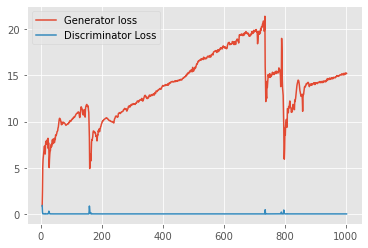

In [68]:
# plot and save the generator and discriminator loss
plt.figure()
losses_g_fixed = [i.detach() for i in losses_g]
losses_d_fixed = [i.detach() for i in losses_d]
plt.plot(losses_g_fixed, label='Generator loss')
plt.plot(losses_d_fixed, label='Discriminator Loss')
plt.legend()
plt.savefig('./outputs/loss.png')